# Projeto 3 - MC886

## Alunos: 
&emsp;&emsp;&emsp;&emsp;Felipe Escórcio de Sousa - RA:171043\
&emsp;&emsp;&emsp;&emsp;Miguel Augusto S Guida&nbsp;&nbsp;&nbsp;- RA:174847

## Objetivo
&emsp;Este projeto tem como objetivo aplicar os conceitos de Algoritmos Evolutivos e Métodos de Aprendizagem por Reforço para treinar um modelo capaz de jogar Pac-Man. O trabalho foi então dividido em duas partes:

<li>
    <ul>Parte 1: Modelo Evolutivo</ul>
    <ul>Parte 2: Modelo de Aprendizagem por Reforço</ul>
</li>

## Jogo do Pacman 
&emsp;&emsp;O jogo do Pac-Man consiste em um agente que percorre um labirinto e precisa comer todas comidas do labirinto, enquanto escapa de inimigos fantasmas.\
&emsp;&emsp;As ações do agente são limitadas pelo labirinto, e são compostas pelas direções que o agente pode escolher (Norte, Sul, Leste, Oeste e Stop). Em nossa implementação, removemos a ação Stop das escolhas possíveis, para ajudar a maximizar o score do agente.\
&emsp;&emsp;A interação do algoritmo com o jogo é formada pelo agente, mais especificamente o método getAction, que recebe o estado atual como parâmetro e retorna qual a próxima ação do Pac-Man.\

## Parte 1 - Modelo Evolutivo
Essa etapa tem o objetivo de utilizar algoritmos evolutivos para criar um agente que consiga jogar e vencer uma partida de pacman.

Nossa ideia inicial de algoritmo evolutivo foi gerar uma sequência de ações para o pacman seguir e percorrer o labirinto proposto, gerando um vetor que guardaria a sequência de ações que deveria ser tomada pelo indivíduo, porém, esta ideia não se provou muito apropriada, pois a natureza dos outros agentes (fantasmas) é não determinística, inviabilizando a ideia inicial.

Assim, nos inspiramos no paper de Brandstetter e Ahmadi para implementar um algoritmo genético baseado em árvores genéticas, possibilitando ao agente tomar decisões baseado nos estados do jogo e não mais apenas no percurso. 

Também utilizamos do paper o princípio de tomar ações simples e direcionais apenas, não dependendo de definir estratégias mais complexas e subjetivas ao jogo, como também da adoção de constantes para os cálculos. No entanto, adotamos menos variáveis dos estados para definir a movimentação do pacman, simplificando ou ignorando algumas adotadas pelos autores.


In [1]:
from search import *
from game import *
from util import *
from pacman import *
import util, layout
import sys, types, time, random, os
import numpy as np
import math
import matplotlib.pyplot as plt
from random import random, randint, seed, choice
import matplotlib.pyplot as plt
import graphicsDisplay

## Biblioteca
Para a implementação do algoritmo evolutivo utilizamos uma estrutura de árvores genéticas a partir do algoritmo encontrado em [Tiny_GP](https://github.com/moshesipper/tiny_gp), com algumas pequenas alterações, além de também usar de referência o artigo Reactive Control of Ms. Pac Man using Information Retrieval based on Genetic Programming de Brandstetter e Ahmadi.

Mantemos da biblioteca a classe GPTree, com seus métodos básicos, fazendo alterações na mutação e na computação dos nós da árvore a partir dos terminais (bottom-up), e semelhantemente ao artigo, buscamos calcular atomicamente as próximas ações a partir dos estados atuais.

Essa biblioteca nos chamou a atenção pela implementação do método random_tree, pois este método gera árvores genéticas aleatoriamente atribuindo as funções aos nós intermediários e os terminais aos nós folhas ( muito útil na inicialização e mutação dos indivíduos). Além desse método, o método scan_tree também nos pareceu muito interessante, pois este é muito útil para o crossover (seleção e troca dos genes).

### Funções
As funções são as operações executadas nos nós da árvore (add, sub e mul).

### Terminais
Os terminais são os tipos possíveis de nós folha, determinados pelas variáveis de estado e por constantes para possibilitar a associação de pesos às variáveis de estado.

Decidimos calcular terminais a partir, basicamente, da posição atual do pacman, posição e score futuros do pacman, distância aos fantasmas (comestível ou não), às pílulas e à comida, além de se haverá encontro com alguma comida ou ao fantasma.

In [2]:
# tiny genetic programming by © moshe sipper, www.moshesipper.com
MIN_DEPTH       = 2    # minimal initial random tree depth
MAX_DEPTH       = 5    # maximal initial random tree depth

def add(x, y): return x + y
def sub(x, y): return x - y
def mul(x, y): return x * y

FUNCTIONS = [add, sub, mul]
TERMINALS = ['actionScore', 
             'eatFood', 
             'minGhostDist', 
             'minDistToFood', 
             'distToPill', 
             'minDistEdibleGhost', 
             'encounterGhost',
             -1.0, 0.5, 1.0, 2.0] # 0.0,  -0.5,

STATE_VARS = ['actionScore', 
              'eatFood', 
              'minGhostDist', 
              'minDistToFood', 
              'distToPill', 
              'minDistEdibleGhost', 
              'encounterGhost']

class GPTree:
    def __init__(self, data = None, left = None, right = None):
        self.data  = data
        self.left  = left
        self.right = right
        
    def setLeft(self, tree):
        self.left = tree
        
    def setRight(self, tree):
        self.right = tree
        
    def node_label(self): # string label
        if (self.data in FUNCTIONS):
            return self.data.__name__
        else: 
            return str(self.data)
    
    def print_tree(self, prefix = ""): # textual printout
        print("%s%s" % (prefix, self.node_label()))        
        if self.left:  self.left.print_tree (prefix + "   ")
        if self.right: self.right.print_tree(prefix + "   ")

    def computeTree(self, stateVars): 
        if (self.data in FUNCTIONS): 
            return self.data(self.left.computeTree(stateVars), self.right.computeTree(stateVars))
        elif (self.data in STATE_VARS): 
            return stateVars[self.data]
        else: return self.data
        
    def size(self): # tree size in nodes
        if self.data in TERMINALS: return 1
        l = self.left.size()  if self.left  else 0
        r = self.right.size() if self.right else 0
        return 1 + l + r
    
    def random_tree(self, grow, max_depth=MAX_DEPTH, depth = 0): # create random tree using either grow or full method
        if depth < MIN_DEPTH or (depth < max_depth and not grow): 
            self.data = FUNCTIONS[randint(0, len(FUNCTIONS)-1)]
        elif depth >= max_depth:   
            self.data = TERMINALS[randint(0, len(TERMINALS)-1)]
        else: # intermediate depth, grow
            if random () > 0.5: 
                self.data = TERMINALS[randint(0, len(TERMINALS)-1)]
            else:
                self.data = FUNCTIONS[randint(0, len(FUNCTIONS)-1)]
        if self.data in FUNCTIONS:
            self.left = GPTree()          
            self.left.random_tree(grow, max_depth, depth = depth + 1)            
            self.right = GPTree()
            self.right.random_tree(grow, max_depth, depth = depth + 1)
            
    def getSubtree(self):
        t = GPTree()
        t.data = self.data
        if self.left:  t.left  = self.left.getSubtree()
        if self.right: t.right = self.right.getSubtree()
        return t
    
    def scan_tree(self, count, second): # note: count is list, so it's passed "by reference"
        count[0] -= 1            
        if count[0] <= 1: 
            if not second: # return subtree rooted here
                return self.getSubtree()
            else: # glue subtree here
                self.data  = second.data
                self.left  = second.left
                self.right = second.right
        else:  
            ret = None
            if self.left  and count[0] > 1: ret = self.left.scan_tree(count, second)  
            if self.right and count[0] > 1: ret = self.right.scan_tree(count, second)
            return ret
        
    def mutation(self, probability=0.1):
        if random() < probability: # mutate at this node
            self.random_tree(grow = True, max_depth= 3)
        else:
            if random() < 0.5:
                if self.left: self.left.mutation(probability)
                elif self.right: self.right.mutation(probability)
            else:
                if self.right: self.right.mutation(probability)
                elif self.left: self.left.mutation(probability)
        

## O Agente
Nosso agente, para cada movimento possível, calcula os score relacionados à escolha de cada e a partir disso retorna a função de maior score possível ou escolhe aleatoriamente dentre as que tiverem maior score empatadas a fim de evitar comportamentos excessivamente repetitivos do agente dado algum estado. 

Para o cálculo de cada ação, buscamos levar em conta o estado atual (distâncias e recursos disponíveis) do pacman, do mapa e dos fantasmas, como também o estado futuro destes se escolhida tal ação. De posse destas variáveis, então realizamos o cálculo segundo a equação dada pela árvore que representa os genes do indivíduo.

Em princípio, usamos um cálculo de distâncias bem mais simples (distância manhattan) que até então parecia suficiente, porém, para atingir resultados melhores, foi necessário utilizar de uma forma mais precisa de cálculo, daí então escolhemos utilizar o algoritmo de busca em profundidade.

Também, percebemos conforme a implementação que algumas variáveis que indicassem que o pacman comeria alguma comida ou encontrasse um fantasma com a ação também ajudavam com a performance, aumentando os scores ou a evasão, por exemplo.

In [3]:
" AGENTE & FUNÇÕES AUXILIARES "
n = Directions.NORTH
s = Directions.SOUTH
e = Directions.EAST
w = Directions.WEST

def minDistBFS(agentPos, positions, wallGrid):
    # Toma paredes como celulas ja visitadas
    visited = wallGrid.copy()
    queue = []
    queue.append((agentPos,1))
    visited[agentPos[0]][agentPos[1]] = True
    if len(positions) > 0:
        while queue:
            el = queue.pop(0)
            h = el[1]
            s = el[0]

            north = (s[0],s[1]+1)
            south = (s[0],s[1]-1)
            west = (s[0]-1,s[1])
            east = (s[0]+1,s[1])

            for i in [north, south, west, east]:    
                if visited[i[0]][i[1]] == False:
                    queue.append((i,h+1))
                    visited[i[0]][i[1]] = True

                    if(i in positions):
                        return h
                
    return 0

def findFoodMinDistBFS(agentPos, foodGrid, wallGrid):
    # Toma paredes como celulas ja visitadas
    visited = wallGrid.copy()
    queue = []
    queue.append((agentPos,1))
    visited[agentPos[0]][agentPos[1]] = True

    while queue:
        el = queue.pop(0)
        h = el[1]
        s = el[0]

        north = (s[0],s[1]+1)
        south = (s[0],s[1]-1)
        west = (s[0]-1,s[1])
        east = (s[0]+1,s[1])

        for i in [north, south, west, east]:    
            if visited[i[0]][i[1]] == False:
                queue.append((i,h+1))
                visited[i[0]][i[1]] = True

                if(foodGrid[i[0]][i[1]]):
                    return h
                
    return 0

def getMinDistEdibleGhost(agentPos,state):
    ghostPos = []
    ghostStates = state.getGhostStates()
    for gs in ghostStates:
        if gs.scaredTimer > 0:
            ghostPos.append(gs.getPosition())
            
    return minDistBFS(agentPos, ghostPos, state.getWalls())

def normalizeDistance(x):
    if x == 0:
        return 0
    return 1/(x**2)


class MyGoWestAgent(Agent):
    "An agent that goes West until it can't."
    def __init__(self, tree = None):
        self.tree = tree
        
    def setTree(self, tree):
        selt.tree = tree

    def getAction(self, state):
        "The agent receives a GameState (defined in pacman.py)."
        count = 0
        legalActions = state.getLegalPacmanActions()
        legalActions.remove(Directions.STOP) #remove a opcao Stop
        actionScore = []
        stateVars = {}
        for action in legalActions:
            
            futureState = state.generatePacmanSuccessor(action)
            
            future_pos = futureState.getPacmanPosition()
            
            futureScore = futureState.getScore() - state.getScore()
            eatFood = state.getNumFood() - futureState.getNumFood()
            
            ghostDist = minDistBFS(future_pos, futureState.getGhostPositions(), state.getWalls())
            foodDist = findFoodMinDistBFS(future_pos,state.getFood(),state.getWalls())
            pillDist = minDistBFS(future_pos, state.getCapsules(), state.getWalls())
            edibleGhost = getMinDistEdibleGhost(future_pos,futureState)
            if ghostDist == 1 and ghostDist != edibleGhost:
                encounterGhost = 1
                futureScore -= 200
            else:
                encounterGhost = 0
                
            
            stateVars[STATE_VARS[0]] = futureScore/200
            stateVars[STATE_VARS[1]] = eatFood
            stateVars[STATE_VARS[2]] = -normalizeDistance(ghostDist)
            stateVars[STATE_VARS[3]] = normalizeDistance(foodDist)
            stateVars[STATE_VARS[4]] = normalizeDistance(pillDist)
            stateVars[STATE_VARS[5]] = normalizeDistance(edibleGhost)
            stateVars[STATE_VARS[6]] = encounterGhost

            treeValue = self.tree.computeTree(stateVars)
            actionScore.append(treeValue)
        
        maxScore = max(actionScore)
        if actionScore.count(maxScore) > 1:
            indexes = [i for i, j in enumerate(actionScore) if j == maxScore]
            maxIndex = choice(indexes)
        else:
            maxIndex = actionScore.index(maxScore)
        
        action = legalActions[maxIndex]
        if action in state.getLegalPacmanActions():
            return action
        else:
            return Directions.STOP

### População Inicial
Iniciamos uma primeira geração com um número N de indivíduos gerados aleatóriamente com uma altura máxima inicial pré estabelecida de 4. Escolhemos esta quantidade inicial de indivíduos pois nos pareceu uma quantidade razoável dada nossa capacidade computacional e tempo disponíveis para a realização dos treinos, garantindo certa variabilidade aos indivíduos, assim como também a altura da árvore, que nos garante variabilidade e também complexidade comportamental a estes.  

In [4]:
def initialPopulation(populationSize=32,treeDepth=3):
    population = []
    for _ in range(populationSize):
        tree = GPTree()
        tree.random_tree(True, treeDepth)
        population.append(tree)
    return population

### Técnica de seleção
Como técnica de seleção para o pais dos indivíduos da próxima geração utilizamos a técnica de torneio. implementamos o torneio selecionando um número aleatório de indivíduos determinado por um parametro, e escolhemos o indíviduo com o maior fitness (score final). 

In [5]:
def tournament(population, fitness, size):
    indexes = np.random.choice(range(0,len(population)),size,False)
    chosen = [fitness[i] for i in indexes]
    return population[indexes[chosen.index(max(chosen))]]

def getParent(population, fitness,size=4):
    return tournament(population, fitness, size)

### Crossover
Para função de crossover da população, selecionamos dois indivíduos por meio do torneio e a partir destes criamos dois novos filhos, repetindo isso até que tenhamos completado o número de indivíduos menos dois da próxima geração. 
O crossover propriamente dito se dá pela função scan_tree, que percorre cada uma das árvores buscando por algum nó aleatório e então os troca, gerando os novos filhos a partir dessa combinação.

In [6]:
def crossover(treeA, treeB):
    child1 = treeA.getSubtree()
    child2 = treeB.getSubtree()
    
    geneA = child1.scan_tree([randint(1, treeA.size())], None) # 1st random subtree
    geneB = child2.scan_tree([randint(1, treeB.size())], None) # 2nd random subtree
    child1.scan_tree([randint(1, treeA.size())], geneB) # 2nd subtree "glued" inside 1st tree
    child2.scan_tree([randint(1, treeB.size())], geneA) # 1st subtree "glued" inside 2nd tree
    
    return child1, child2

### Treino
O treino é realizado por meio de 5 jogos por padrão, salvando sempre ao final a taxa de vitórias do indivíduo, retornando ao final o score médio das partidas.

In [22]:
winsDict = {}
def trainIndividual(ind, gen, layoutType='smallClassic', numGames=5):
    if gen < GEN_TRAIN_OFFSET:
        numGames = 2
    else:
        numGames=NUM_GAMES
    
        
    gameLayout = layout.getLayout( layoutType )
    print("------------------------------------------ train ---------------------------------------------")
    ind.print_tree()

    pacman = MyGoWestAgent(ind)

    ghostType = loadAgent('RandomGhost', True)
    ghosts = [ghostType( i+1 ) for i in range( 4 )]

    import textDisplay
    textDisplay.SLEEP_TIME = 0.1
    gameDisplay = graphicsDisplay.PacmanGraphics(1.0, frameTime = 0.1)

    games = runGames( gameLayout, pacman, ghosts, gameDisplay, numGames, False)
    scores = [game.state.getScore() for game in games]
    wins = [game.state.isWin() for game in games]
    winRate = wins.count(True)/ float(len(wins))
    
    winsDict[str(gen)].append(winRate)
    
    avgScore = sum(scores) / float(len(scores))
    return avgScore, scores, wins

### Fitness Function
Para calcularmos a função de fitness para cada indivíduo utilizamos prontamente o valor de média dos scores finais de cada partida realizada por esse ao final da quantidade de partidas estipuladas.


In [21]:
def getFitness(individuo, gen, gameLayout= 'smallClassic'):
    avgScore,scores,wins = trainIndividual(individuo, gen, gameLayout)
    return avgScore

def getPopFitness(population, gen, gameLayout= 'smallClassic'):
    return [getFitness(population[i], gen, gameLayout) for i in range(0,len(population))]

## Nova População
A nova população será composta pelos filhos gerados através do crossover e os dois indivídos com maior fitness da população anterior (elitismo).

### Mutação
O processo de mutação se dá pela escolha de um número determinado por um parâmetro dentre os indivíduos da próxima população, que poderão ter algum de seus nós aleatoriamente substituídos por uma nova sub-árvore a depender de uma taxa de mutação pré estipulada, alterando ou gerando novos genes nos indivíduos.

In [9]:
pops = []
def generationLoop(gameLayout = 'smallClassic', population=None):
    if population == None:
        population = initialPopulation(POP_SIZE, TREE_SIZE) # popSize, tam GPTree
    
    genFits = []
    maxFits = []
    minFits = []
    
    count = 1
    
    winsDict[str(count)] = []
    
    for p in population:
        p.print_tree()
        print(" - - - - ")
    print("G - ",count,"    ============================================  ")
    
    # train population to get fitness
    fitness = getPopFitness(population, count, gameLayout)
    print("G",count," - FITNESS: ", fitness )
    pops.append(population)
    while count <= NUM_GEN:
        children = []
        
        # crossover
        for i in range(0,int(len(population)/2)-1):
            father = getParent(population, fitness,4)
            mother = getParent(population, fitness,4)
            
            child1, child2 = crossover(father, mother)
            children.append(child1)
            children.append(child2)
        
        # mutation
        indexes = np.random.choice(range(0,len(children)),int(len(children)*0.6),False)
        for i in indexes:
            children[i].mutation(0.1)
        
        # elitism
        maxIndex = fitness.index(max(fitness))
        children.append(population[maxIndex])
        
        fitness.remove(max(fitness))
        population.remove(population[maxIndex])
        
        maxIndex = fitness.index(max(fitness))
        children.append(population[maxIndex])
        
        count += 1
        
        winsDict[str(count)] = []
        
        # train population to get fitness
        print("G", count," - POPULATION")
        
        population = children[:]
        for p in population:
            p.print_tree()
            print(" - - - - ")
            
        fitness = getPopFitness(population, count, gameLayout)
        pops.append(population)
       
        print("FITNESS: ", fitness )
        avgFit = sum(fitness) / float(len(fitness))
        print("Avg: ", avgFit)
        genFits.append(avgFit)
        maxFit = max(fitness)
        print("Max: ", maxFit)
        maxFits.append(maxFit)
        minFit = min(fitness)
        print("Min: ", minFit)
        minFits.append(minFit)
    
    print("gen means: ", genFits)
    print("gen maxes: ", maxFits)
    print("gen mins: ", minFits)
    
    x = np.linspace(1, NUM_GEN, num= NUM_GEN, endpoint=True)
    y1 = np.array(genFits)
    y2 = np.array(maxFits)
    y3 = np.array(minFits)
    
    plt.plot(x, y1, '-', x, y2, '-', x, y3, '-')
    plt.legend(['mean', 'max', 'min'], loc='best')
    plt.show()
    
    return population, fitness, x, y1, y2, y3

### Treinamentos

mul
   mul
      0.5
      sub
         add
            sub
               actionScore
               minDistEdibleGhost
            sub
               0.5
               distToPill
         encounterGhost
   sub
      add
         1.0
         minDistEdibleGhost
      sub
         1.0
         sub
            add
               -1.0
               -1.0
            mul
               -1.0
               minDistEdibleGhost
 - - - - 
add
   add
      mul
         mul
            mul
               0.5
               2.0
            add
               minGhostDist
               -1.0
         distToPill
      sub
         eatFood
         add
            actionScore
            mul
               eatFood
               distToPill
   add
      add
         0.5
         0.5
      mul
         minDistEdibleGhost
         eatFood
 - - - - 
sub
   add
      encounterGhost
      mul
         add
            minDistEdibleGhost
            -1.0
         -1.0
   mul
      add
         -1.0
       

Pacman died! Score: -437
Pacman died! Score: -422
Average Score: -429.5
Scores:        -437.0, -422.0
Win Rate:      0/2 (0.00)
Record:        Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
sub
   add
      encounterGhost
      mul
         add
            minDistEdibleGhost
            -1.0
         -1.0
   mul
      add
         -1.0
         sub
            0.5
            mul
               0.5
               0.5
      add
         add
            mul
               minDistEdibleGhost
               0.5
            mul
               minDistEdibleGhost
               0.5
         mul
            1.0
            sub
               1.0
               distToPill
Pacman died! Score: -524
Pacman died! Score: -519
Average Score: -521.5
Scores:        -524.0, -519.0
Win Rate:      0/2 (0.00)
Record:        Loss, Loss
layout:  smallClassic
------------------------------------------ train ----------------------

Pacman died! Score: 12
Pacman died! Score: -278
Average Score: -133.0
Scores:        12.0, -278.0
Win Rate:      0/2 (0.00)
Record:        Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
add
   sub
      mul
         add
            2.0
            add
               encounterGhost
               -1.0
         minDistToFood
      0.5
   mul
      mul
         0.5
         encounterGhost
      sub
         mul
            add
               minGhostDist
               eatFood
            mul
               minGhostDist
               distToPill
         add
            distToPill
            sub
               0.5
               -1.0
Pacman died! Score: -446
Pacman died! Score: -228
Average Score: -337.0
Scores:        -446.0, -228.0
Win Rate:      0/2 (0.00)
Record:        Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   a

Pacman died! Score: -191
Pacman died! Score: -383
Average Score: -287.0
Scores:        -191.0, -383.0
Win Rate:      0/2 (0.00)
Record:        Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
eatFood
Pacman died! Score: -255
Pacman died! Score: -350
Average Score: -302.5
Scores:        -255.0, -350.0
Win Rate:      0/2 (0.00)
Record:        Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
add
   add
      add
         eatFood
         add
            sub
               1.0
               minGhostDist
            -1.0
      0.5
   sub
      mul
         minDistToFood
         mul
            actionScore
            minGhostDist
      minDistEdibleGhost
Pacman died! Score: -437
Pacman died! Score: -429
Average Score: -433.0
Scores:        -437.0, -429.0
Win Rate:      0/2 (0.00)
Record:        Loss, Loss
layout:  smallClassic
------

Pacman died! Score: -529
Pacman died! Score: -512
Average Score: -520.5
Scores:        -529.0, -512.0
Win Rate:      0/2 (0.00)
Record:        Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         0.5
         encounterGhost
      actionScore
   sub
      add
         mul
            -1.0
            minGhostDist
         distToPill
      sub
         minDistToFood
         eatFood
Pacman died! Score: -493
Pacman died! Score: -490
Average Score: -491.5
Scores:        -493.0, -490.0
Win Rate:      0/2 (0.00)
Record:        Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
add
   add
      add
         eatFood
         add
            sub
               1.0
               minGhostDist
            -1.0
      1.0
   sub
      distToPill
      minDistEdibleGhost
Pacman died! Score: -374
Pacman died! Score: -351


Pacman died! Score: -477
Pacman died! Score: -478
Average Score: -477.5
Scores:        -477.0, -478.0
Win Rate:      0/2 (0.00)
Record:        Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
sub
   sub
      mul
         mul
            add
               mul
                  sub
                     mul
                        minDistToFood
                        minDistEdibleGhost
                     add
                        -1.0
                        minGhostDist
                  add
                     sub
                        2.0
                        minDistEdibleGhost
                     minDistEdibleGhost
               mul
                  -1.0
                  eatFood
            distToPill
         add
            minDistEdibleGhost
            minDistEdibleGhost
      sub
         sub
            sub
               add
                  distToPill
                  0.5
        

Pacman died! Score: -276
Pacman died! Score: -244
Average Score: -260.0
Scores:        -276.0, -244.0
Win Rate:      0/2 (0.00)
Record:        Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      distToPill
      mul
         2.0
         add
            mul
               minGhostDist
               minGhostDist
            add
               eatFood
               1.0
   add
      eatFood
      actionScore
Pacman died! Score: -258
Pacman died! Score: -200
Average Score: -229.0
Scores:        -258.0, -200.0
Win Rate:      0/2 (0.00)
Record:        Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
minGhostDist
Pacman died! Score: -412
Pacman died! Score: -325
Average Score: -368.5
Scores:        -412.0, -325.0
Win Rate:      0/2 (0.00)
Record:        Loss, Loss
layout:  smallClassic
------------------------------------

Pacman died! Score: -388
Pacman died! Score: -407
Average Score: -397.5
Scores:        -388.0, -407.0
Win Rate:      0/2 (0.00)
Record:        Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         2.0
         add
            add
               eatFood
               minGhostDist
            add
               eatFood
               1.0
   add
      minDistToFood
      actionScore
Pacman emerges victorious! Score: 1370
Pacman emerges victorious! Score: 896
Average Score: 1133.0
Scores:        1370.0, 896.0
Win Rate:      2/2 (1.00)
Record:        Win, Win
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      sub
         sub
            actionScore
            2.0
         add
            0.5
            add
               -1.0
               minGhostDist
   

Pacman died! Score: -365
Pacman died! Score: -359
Average Score: -362.0
Scores:        -365.0, -359.0
Win Rate:      0/2 (0.00)
Record:        Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      eatFood
      mul
         2.0
         1.0
   add
      minDistToFood
      actionScore
Pacman died! Score: -293
Pacman died! Score: -219
Average Score: -256.0
Scores:        -293.0, -219.0
Win Rate:      0/2 (0.00)
Record:        Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         2.0
         add
            add
               mul
                  2.0
                  add
                     mul
                        minGhostDist
                        minGhostDist
                     add
                        eatFood
                       

Pacman died! Score: -386
Pacman died! Score: -36
Pacman died! Score: 59
Average Score: -121.0
Scores:        -386.0, -36.0, 59.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      2.0
      add
         minDistToFood
         mul
            2.0
            encounterGhost
   add
      minDistToFood
      actionScore
Pacman emerges victorious! Score: 883
Pacman died! Score: -452
Pacman died! Score: -211
Average Score: 73.33333333333333
Scores:        883.0, -452.0, -211.0
Win Rate:      1/3 (0.33)
Record:        Win, Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
add
   minDistToFood
   actionScore
Pacman died! Score: -175
Pacman died! Score: -262
Pacman died! Score: -120
Average Score: -185.66666666666666
Scores:        -175.0, -262.0, -120.0
Win Rate:      0/3 (0.00)

Pacman emerges victorious! Score: 738
Pacman died! Score: -15
Pacman died! Score: 95
Average Score: 272.6666666666667
Scores:        738.0, -15.0, 95.0
Win Rate:      1/3 (0.33)
Record:        Win, Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         2.0
         add
            mul
               0.5
               minGhostDist
            add
               add
                  minDistToFood
                  actionScore
               1.0
   add
      minDistToFood
      actionScore
Pacman died! Score: -187
Pacman died! Score: -354
Pacman died! Score: -331
Average Score: -290.6666666666667
Scores:        -187.0, -354.0, -331.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      2.0
      add
   

Pacman died! Score: -370
Average Score: -371.6666666666667
Scores:        -368.0, -377.0, -370.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      2.0
      minDistToFood
   add
      minDistToFood
      actionScore
Pacman died! Score: -322
Pacman died! Score: -68
Pacman died! Score: -76
Average Score: -155.33333333333334
Scores:        -322.0, -68.0, -76.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      2.0
      add
         minDistToFood
         mul
            2.0
            encounterGhost
   eatFood
Pacman died! Score: -152
Pacman died! Score: -320
Pacman died! Score: -329
Average Score: -267.0
Scores:        -152.0, -320.0, -329.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  

Pacman died! Score: -287
Pacman died! Score: -309
Pacman died! Score: -347
Average Score: -314.3333333333333
Scores:        -287.0, -309.0, -347.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   2.0
   add
      mul
         0.5
         minGhostDist
      add
         eatFood
         1.0
Pacman died! Score: -159
Pacman died! Score: -5
Pacman died! Score: -258
Average Score: -140.66666666666666
Scores:        -159.0, -5.0, -258.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   eatFood
   add
      minDistToFood
      actionScore
Pacman died! Score: -299
Pacman died! Score: -98
Pacman died! Score: -383
Average Score: -260.0
Scores:        -299.0, -98.0, -383.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layou

Pacman emerges victorious! Score: 922
Pacman emerges victorious! Score: 928
Pacman emerges victorious! Score: 940
Average Score: 930.0
Scores:        922.0, 928.0, 940.0
Win Rate:      3/3 (1.00)
Record:        Win, Win, Win
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         2.0
         add
            add
               0.5
               minGhostDist
            add
               eatFood
               1.0
   add
      minDistToFood
      actionScore
Pacman emerges victorious! Score: 852
Pacman died! Score: -382
Pacman died! Score: -348
Average Score: 40.666666666666664
Scores:        852.0, -382.0, -348.0
Win Rate:      1/3 (0.33)
Record:        Win, Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      m

Pacman died! Score: -176
Pacman died! Score: -67
Pacman emerges victorious! Score: 980
Average Score: 245.66666666666666
Scores:        -176.0, -67.0, 980.0
Win Rate:      1/3 (0.33)
Record:        Loss, Loss, Win
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         1.0
      mul
         2.0
         add
            mul
               minGhostDist
               minGhostDist
            mul
               2.0
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
   add
      minDistToFood
      actionScore
Pacman emerges victorious! Score: 970
Pacman emerges victorious! Score: 796
Pacman emerges victorious! Score: 954
Average Score: 906.6666666666666
Scores:        970.0, 796.0, 954.0
Win Rate:      3/3 (1.00)
Record:        Win, Win, Win
layout:  smallCla

Pacman died! Score: -520
Pacman died! Score: -534
Pacman died! Score: -507
Average Score: -520.3333333333334
Scores:        -520.0, -534.0, -507.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   2.0
   add
      add
         add
            eatFood
            minGhostDist
         add
            eatFood
            1.0
      mul
         add
            mul
               2.0
               encounterGhost
            mul
               2.0
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
         add
            minDistToFood
            actionScore
Pacman died! Score: -61
Pacman emerges victorious! Score: 966
Pacman died! Score: -149
Average Score: 252.0
Scores:        -61.0, 966.0, -149.0
Win Rate:      1/3 (0.33)
Record:

Pacman died! Score: -129
Pacman died! Score: 34
Pacman died! Score: -438
Average Score: -177.66666666666666
Scores:        -129.0, 34.0, -438.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         mul
            add
               encounterGhost
               encounterGhost
            mul
               eatFood
               minDistToFood
         add
            mul
               encounterGhost
               distToPill
            minDistToFood
   add
      minDistToFood
      actionScore
Pacman died! Score: -395
Pacman died! Score: -150
Pacman died! Score: -489
Average Score: -344.6666666666667
Scores:        -395.0, -150.0, -489.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train ------------------------

Pacman died! Score: -508
Pacman died! Score: -494
Pacman died! Score: -541
Average Score: -514.3333333333334
Scores:        -508.0, -494.0, -541.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         mul
            2.0
            encounterGhost
         1.0
      mul
         2.0
         add
            add
               0.5
               minGhostDist
            add
               eatFood
               1.0
   add
      minDistToFood
      actionScore
Pacman died! Score: -94
Pacman died! Score: -102
Pacman died! Score: -548
Average Score: -248.0
Scores:        -94.0, -102.0, -548.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   2.0
   add
      mul
         0.5
         mul
            2.0
        

Pacman died! Score: -273
Pacman died! Score: -169
Pacman died! Score: -346
Average Score: -262.6666666666667
Scores:        -273.0, -169.0, -346.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         minDistToFood
         minGhostDist
      add
         eatFood
         1.0
   add
      minDistToFood
      actionScore
Pacman died! Score: -138
Pacman died! Score: -304
Pacman died! Score: -131
Average Score: -191.0
Scores:        -138.0, -304.0, -131.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
     

Pacman died! Score: -401
Pacman died! Score: -267
Pacman died! Score: -46
Average Score: -238.0
Scores:        -401.0, -267.0, -46.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      eatFood
      1.0
   mul
      add
         mul
            2.0
            encounterGhost
         mul
            2.0
            add
               eatFood
               1.0
      add
         add
            mul
               0.5
               minGhostDist
            mul
               add
                  mul
                     2.0
                     encounterGhost
                  mul
                     2.0
                     mul
                        2.0
                        eatFood
               add
                  minDistToFood
                  actionScore
         actionScore
Pacman died! Score: -163
Pacman died! Score: 194
Pacman die

Pacman emerges victorious! Score: 904
Pacman died! Score: -389
Pacman emerges victorious! Score: 1100
Average Score: 538.3333333333334
Scores:        904.0, -389.0, 1100.0
Win Rate:      2/3 (0.67)
Record:        Win, Loss, Win
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   2.0
   add
      mul
         0.5
         mul
            2.0
            add
               eatFood
               1.0
      mul
         add
            mul
               2.0
               encounterGhost
            mul
               2.0
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     mul
                        2.0
                        encounterGhost
         add
            minDistToFood
            actionScore
Pacman died! Score: -354
Pacman died! Score: -338
Pacman died! Score: -322
Average Score: -338

Pacman died! Score: -356
Pacman died! Score: -312
Pacman died! Score: -350
Average Score: -339.3333333333333
Scores:        -356.0, -312.0, -350.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            1.0
            add
               eatFood
               1.0
         add
            add
               eatFood
               minGhostDist
            add
               eatFood
               1.0
   add
      minDistToFood
      actionScore
Pacman died! Score: -132
Pacman emerges victorious! Score: 932
Pacman emerges victorious! Score: 935
Average Score: 578.3333333333334
Scores:        -132.0, 932.0, 935.0
Win Rate:      2/3 (0.67)
Record:        Loss, Win, Win
layout:  smallClassic
------------------------------------------ train -------------------------------------------

Pacman died! Score: -356
Pacman died! Score: -335
Pacman died! Score: -421
Average Score: -370.6666666666667
Scores:        -356.0, -335.0, -421.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   2.0
   add
      mul
         0.5
         minGhostDist
      mul
         add
            mul
               2.0
               eatFood
            mul
               2.0
               add
                  eatFood
                  add
                     eatFood
                     1.0
         add
            minDistToFood
            actionScore
Pacman emerges victorious! Score: 786
Pacman died! Score: 95
Pacman emerges victorious! Score: 959
Average Score: 613.3333333333334
Scores:        786.0, 95.0, 959.0
Win Rate:      2/3 (0.67)
Record:        Win, Loss, Win
layout:  smallClassic
------------------------------------------ train ----------------------

Pacman died! Score: -271
Pacman died! Score: -284
Pacman emerges victorious! Score: 1157
Average Score: 200.66666666666666
Scores:        -271.0, -284.0, 1157.0
Win Rate:      1/3 (0.33)
Record:        Loss, Loss, Win
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     2.0
                     encounterGhost
                  mul
                     add
                        mul
         

Pacman died! Score: -62
Pacman emerges victorious! Score: 931
Pacman emerges victorious! Score: 977
Average Score: 615.3333333333334
Scores:        -62.0, 931.0, 977.0
Win Rate:      2/3 (0.67)
Record:        Loss, Win, Win
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   2.0
   add
      mul
         eatFood
         minGhostDist
      mul
         add
            mul
               2.0
               eatFood
            mul
               2.0
               add
                  eatFood
                  add
                     eatFood
                     1.0
         add
            minDistToFood
            actionScore
Pacman died! Score: -108
Pacman died! Score: -245
Pacman emerges victorious! Score: 1374
Average Score: 340.3333333333333
Scores:        -108.0, -245.0, 1374.0
Win Rate:      1/3 (0.33)
Record:        Loss, Loss, Win
layout:  smallClassic
------------------------------------------ train ----

Pacman died! Score: -350
Pacman died! Score: 85
Pacman died! Score: -171
Average Score: -145.33333333333334
Scores:        -350.0, 85.0, -171.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     2.0
                     encounterGhost
                  mul
                     add
                        mul
                         

Pacman emerges victorious! Score: 977
Pacman died! Score: -268
Pacman emerges victorious! Score: 1342
Average Score: 683.6666666666666
Scores:        977.0, -268.0, 1342.0
Win Rate:      2/3 (0.67)
Record:        Win, Loss, Win
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   2.0
   add
      mul
         eatFood
         minGhostDist
      mul
         add
            mul
               2.0
               eatFood
            mul
               2.0
               add
                  eatFood
                  minDistToFood
         add
            minDistToFood
            actionScore
Pacman emerges victorious! Score: 974
Pacman died! Score: -382
Pacman emerges victorious! Score: 950
Average Score: 514.0
Scores:        974.0, -382.0, 950.0
Win Rate:      2/3 (0.67)
Record:        Win, Loss, Win
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
m

Pacman died! Score: -480
Pacman died! Score: -293
Pacman died! Score: -394
Average Score: -389.0
Scores:        -480.0, -293.0, -394.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            1.0
            add
               eatFood
               eatFood
         add
            mul
               2.0
               encounterGhost
            mul
               add
                  mul
                     minDistToFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               add
                  add
                     eatFood
                     1.0
                  mul
                     add
                        1.0
                        add
                           eatFood
                  

Pacman died! Score: -237
Pacman emerges victorious! Score: 976
Pacman died! Score: -330
Average Score: 136.33333333333334
Scores:        -237.0, 976.0, -330.0
Win Rate:      1/3 (0.33)
Record:        Loss, Win, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     2.0
                     encounterGhost
                  mul
                     add
                        mul
           

Pacman emerges victorious! Score: 954
Pacman died! Score: -383
Pacman died! Score: -329
Average Score: 80.66666666666667
Scores:        954.0, -383.0, -329.0
Win Rate:      1/3 (0.33)
Record:        Win, Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            add
               mul
                  minDistToFood
                  minGhostDist
               add
                  eatFood
                  1.0
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     2.0
                     encounterG

Pacman emerges victorious! Score: 988
Pacman emerges victorious! Score: 1176
Pacman emerges victorious! Score: 957
Average Score: 1040.3333333333333
Scores:        988.0, 1176.0, 957.0
Win Rate:      3/3 (1.00)
Record:        Win, Win, Win
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         sub
            sub
               0.5
               0.5
            mul
               mul
                  minDistEdibleGhost
                  actionScore
               distToPill
      mul
         add
            1.0
            add
               eatFood
               1.0
         add
            mul
               2.0
               encounterGhost
            mul
               add
                  mul
                     minDistToFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               add
                  

Pacman died! Score: -206
Pacman died! Score: -94
Pacman emerges victorious! Score: 965
Average Score: 221.66666666666666
Scores:        -206.0, -94.0, 965.0
Win Rate:      1/3 (0.33)
Record:        Loss, Loss, Win
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     2.0
                     encounterGhost
                  mul
                     add
                        mul
             

Pacman died! Score: -749
Pacman died! Score: -223
Pacman died! Score: -94
Average Score: -355.3333333333333
Scores:        -749.0, -223.0, -94.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     encounterGhost
               1.0
            add
               eatFood
               add
                  mul
                     2.0
                     encounterGhost
                  mul
                     add
                        mul
             

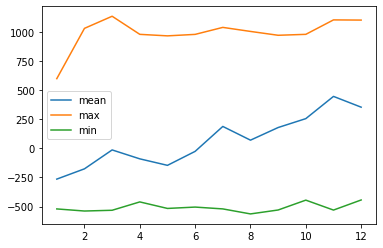

mul
   2.0
   add
      mul
         0.5
         add
            eatFood
            1.0
      mul
         add
            mul
               2.0
               eatFood
            mul
               2.0
               add
                  eatFood
                  add
                     mul
                        2.0
                        encounterGhost
                     1.0
         add
            minDistToFood
            actionScore
 - - - - 
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            add
               mul
                  minDistToFood
                  minGhostDist
               add
                  eatFood
                  1.0
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
     

In [10]:
NUM_GEN = 12
POP_SIZE = 24
TREE_SIZE = 5
GEN_TRAIN_OFFSET=5
NUM_GAMES = 3
population, fitness, x, y1, y2, y3 = generationLoop('smallClassic')
for p in population:
    p.print_tree()
    print(" - - - - ")
print(fitness)

print(winsDict)

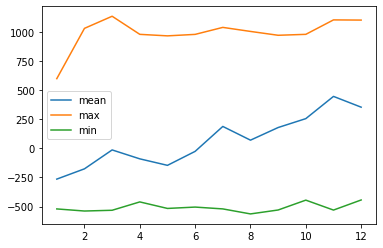

In [11]:
plt.plot(x, y1, '-', x, y2, '-', x, y3, '-')
plt.legend(['mean', 'max', 'min'], loc='best')
plt.show()

mul
   2.0
   add
      mul
         0.5
         add
            eatFood
            1.0
      mul
         add
            mul
               2.0
               eatFood
            mul
               2.0
               add
                  eatFood
                  add
                     mul
                        2.0
                        encounterGhost
                     1.0
         add
            minDistToFood
            actionScore
 - - - - 
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            add
               mul
                  minDistToFood
                  minGhostDist
               add
                  eatFood
                  1.0
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
     

               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     2.0
                     encounterGhost
                  mul
                     add
                        mul
                           minDistToFood
                           1.0
                        add
                           eatFood
                           1.0
                     add
                        add
                           eatFood
                           1.0
                        add
                           eatFood
                           1.0
   add
      minDistToFood
      actionScore
 - - - - 
G -  1     ============================================  
layout:  mediumClassic

Pacman emerges victorious! Score: 1733
Pacman emerges victorious! Score: 1333
Average Score: 1533.0
Scores:        1733.0, 1333.0
Win Rate:      2/2 (1.00)
Record:        Win, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         sub
            sub
               0.5
               0.5
            mul
               mul
                  minDistEdibleGhost
                  actionScore
               distToPill
      mul
         add
            1.0
            add
               eatFood
               1.0
         add
            mul
               2.0
               encounterGhost
            mul
               add
                  mul
                     minDistToFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               add
                  add
                     eatFood
                     1.0
 

Pacman emerges victorious! Score: 1662
Pacman died! Score: 52
Average Score: 857.0
Scores:        1662.0, 52.0
Win Rate:      1/2 (0.50)
Record:        Win, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     2.0
                     encounterGhost
                  mul
                     add
                        mul
                           minDistToFood
                       

Pacman died! Score: 300
Pacman died! Score: 302
Average Score: 301.0
Scores:        300.0, 302.0
Win Rate:      0/2 (0.00)
Record:        Loss, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     2.0
                     encounterGhost
                  mul
                     add
                        mul
                           minDistToFood
                           eatFood
 

Pacman emerges victorious! Score: 1539
Pacman emerges victorious! Score: 1520
Average Score: 1529.5
Scores:        1539.0, 1520.0
Win Rate:      2/2 (1.00)
Record:        Win, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            add
               mul
                  minDistToFood
                  minGhostDist
               add
                  eatFood
                  1.0
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     2.0
                     encounterGhost
                  mul
       

Pacman died! Score: 144
Pacman died! Score: 149
Average Score: 146.5
Scores:        144.0, 149.0
Win Rate:      0/2 (0.00)
Record:        Loss, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     minDistToFood
                     minGhostDist
                  mul
                     add
                        mul
                           minDistToFood
                           m

Pacman emerges victorious! Score: 1489
Pacman emerges victorious! Score: 1211
Average Score: 1350.0
Scores:        1489.0, 1211.0
Win Rate:      2/2 (1.00)
Record:        Win, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     2.0
                     encounterGhost
                  mul
                     add
                        mul
                           minDistToFood
     

Pacman died! Score: 52
Pacman emerges victorious! Score: 1689
Average Score: 870.5
Scores:        52.0, 1689.0
Win Rate:      1/2 (0.50)
Record:        Loss, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     2.0
                     encounterGhost
                  mul
                     add
                        mul
                           minDistToFood
                       

Pacman emerges victorious! Score: 1536
Pacman emerges victorious! Score: 1542
Average Score: 1539.0
Scores:        1536.0, 1542.0
Win Rate:      2/2 (1.00)
Record:        Win, Win
FITNESS:  [1529.5, 513.5, 530.0, 1632.0, 1615.5, 146.5, 1624.0, 623.0, 1229.5, 737.5, 1602.5, 1350.0, 1623.0, 1731.0, -61.5, 1729.5, -648.5, 870.5, 990.0, 1167.0, -473.5, 1234.0, 1596.0, 1539.0]
Avg:  1017.9166666666666
Max:  1731.0
Min:  -648.5
G 3  - POPULATION
mul
   add
      mul
         eatFood
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     add
                        eatFood
                        1.0
               1.0
            add
               eatFood
             

Pacman emerges victorious! Score: 1733
Pacman emerges victorious! Score: 1721
Average Score: 1727.0
Scores:        1733.0, 1721.0
Win Rate:      2/2 (1.00)
Record:        Win, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     add
                        eatFood
                        1.0
               1.0
            add
               eatFood
               add
                  mul
                     2.0
                     encounterGhost
                  mul
                     add
              

Pacman died! Score: -252
Pacman emerges victorious! Score: 1524
Average Score: 636.0
Scores:        -252.0, 1524.0
Win Rate:      1/2 (0.50)
Record:        Loss, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
                        eatFood
                        add
                           mul
                              minDistToFood
                              minGho

Pacman emerges victorious! Score: 1328
Pacman died! Score: 693
Average Score: 1010.5
Scores:        1328.0, 693.0
Win Rate:      1/2 (0.50)
Record:        Win, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            add
               mul
                  minDistToFood
                  minGhostDist
               add
                  eatFood
                  1.0
            add
               eatFood
               1.0
         add
            add
               minDistToFood
               1.0
            add
               eatFood
               add
                  mul
                     2.0
                     encounterGhost
                  mul
                     add
                        mul
                           minDistToFood
                           minGhostDist
                        add
           

Pacman emerges victorious! Score: 1470
Average Score: 1367.0
Scores:        1264.0, 1470.0
Win Rate:      2/2 (1.00)
Record:        Win, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
minGhostDist
Pacman died! Score: -444
Pacman died! Score: -455
Average Score: -449.5
Scores:        -444.0, -455.0
Win Rate:      0/2 (0.00)
Record:        Loss, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     1.0
                  add
                     eatFood
                     1.0
               1.0
            add
         

Pacman emerges victorious! Score: 1534
Pacman died! Score: 20
Average Score: 777.0
Scores:        1534.0, 20.0
Win Rate:      1/2 (0.50)
Record:        Win, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            add
               mul
                  minDistToFood
                  minGhostDist
               add
                  eatFood
                  1.0
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               eatFood
   add
      minDistToFood
      actionScore
Pacman emerges victorious! Score: 1534
Pacman emerges victorious! Score: 1259
Ave

Pacman emerges victorious! Score: 1850
Pacman emerges victorious! Score: 1455
Pacman died! Score: -188
Pacman died! Score: 487
Average Score: 901.0
Scores:        1850.0, 1455.0, -188.0, 487.0
Win Rate:      2/4 (0.50)
Record:        Win, Win, Loss, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         sub
            sub
               sub
                  minDistToFood
                  minDistToFood
               actionScore
            mul
               minGhostDist
               2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     add
                 

Pacman emerges victorious! Score: 1742
Pacman emerges victorious! Score: 1536
Pacman emerges victorious! Score: 1329
Pacman died! Score: -35
Average Score: 1143.0
Scores:        1742.0, 1536.0, 1329.0, -35.0
Win Rate:      3/4 (0.75)
Record:        Win, Win, Win, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      add
         -1.0
         actionScore
      minDistEdibleGhost
   sub
      0.5
      eatFood
Pacman died! Score: -392
Pacman died! Score: 106
Pacman died! Score: -185
Pacman died! Score: -410
Average Score: -220.25
Scores:        -392.0, 106.0, -185.0, -410.0
Win Rate:      0/4 (0.00)
Record:        Loss, Loss, Loss, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         sub
            add
               minDistEdibleGhost
               distToPill
            add
             

Pacman emerges victorious! Score: 1744
Pacman emerges victorious! Score: 1331
Pacman emerges victorious! Score: 1733
Pacman died! Score: -12
Average Score: 1199.0
Scores:        1744.0, 1331.0, 1733.0, -12.0
Win Rate:      3/4 (0.75)
Record:        Win, Win, Win, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            add
               mul
                  minDistToFood
                  minGhostDist
               mul
                  2.0
                  encounterGhost
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            minGhostDist
   add
      minDistToFood
      actionScore
Pacm

Pacman emerges victorious! Score: 1502
Pacman died! Score: -23
Pacman emerges victorious! Score: 1535
Pacman emerges victorious! Score: 1517
Average Score: 1132.75
Scores:        1502.0, -23.0, 1535.0, 1517.0
Win Rate:      3/4 (0.75)
Record:        Win, Loss, Win, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
add
   add
      mul
         add
            -1.0
            sub
               eatFood
               encounterGhost
         mul
            add
               0.5
               minDistToFood
            mul
               -1.0
               minDistToFood
      1.0
   add
      eatFood
      eatFood
Pacman died! Score: 504
Pacman died! Score: 462
Pacman died! Score: -315
Pacman died! Score: 337
Average Score: 247.0
Scores:        504.0, 462.0, -315.0, 337.0
Win Rate:      0/4 (0.00)
Record:        Loss, Loss, Loss, Loss
layout:  mediumClassic
------------------------------------------ train --------

Pacman died! Score: -443
Pacman died! Score: 231
Pacman died! Score: -79
Pacman died! Score: 188
Average Score: -25.75
Scores:        -443.0, 231.0, -79.0, 188.0
Win Rate:      0/4 (0.00)
Record:        Loss, Loss, Loss, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            add
               mul
                  minDistToFood
                  minGhostDist
               add
                  eatFood
                  1.0
            add
               eatFood
               1.0
         add
            add
               add
                  1.0
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               eatFood
   add
      minDistToFood
      actionScore
Pacman emerges victorious! Score: 1400
Pacman emerges victorious! Score: 1547
Pa

Pacman emerges victorious! Score: 1938
Pacman died! Score: 160
Pacman emerges victorious! Score: 1744
Pacman emerges victorious! Score: 1723
Average Score: 1391.25
Scores:        1938.0, 160.0, 1744.0, 1723.0
Win Rate:      3/4 (0.75)
Record:        Win, Loss, Win, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         minDistToFood
      mul
         add
            add
               mul
                  minDistToFood
                  minGhostDist
               add
                  eatFood
                  1.0
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
 

Pacman died! Score: -618
Pacman died! Score: -530
Pacman died! Score: -543
Pacman died! Score: -534
Average Score: -556.25
Scores:        -618.0, -530.0, -543.0, -534.0
Win Rate:      0/4 (0.00)
Record:        Loss, Loss, Loss, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            add
               mul
                  minDistToFood
                  minGhostDist
               add
                  eatFood
                  1.0
            add
               eatFood
               1.0
         add
            add
               add
                  mul
                     add
                        mul
                           minDistToFood
                           minGhostDist
                        add
                           eatFood
                           1.0
                     add
                      

Pacman emerges victorious! Score: 1340
Pacman died! Score: 3
Pacman died! Score: -311
Pacman emerges victorious! Score: 1727
Average Score: 689.75
Scores:        1340.0, 3.0, -311.0, 1727.0
Win Rate:      2/4 (0.50)
Record:        Win, Loss, Loss, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         minDistToFood
      mul
         add
            add
               mul
                  minDistToFood
                  minGhostDist
               add
                  eatFood
                  1.0
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     mul
                        minDistToFood
                        minGhostDist
               1.0
            add
        

Pacman emerges victorious! Score: 1721
Pacman emerges victorious! Score: 1736
Pacman emerges victorious! Score: 1745
Pacman emerges victorious! Score: 1707
Average Score: 1727.25
Scores:        1721.0, 1736.0, 1745.0, 1707.0
Win Rate:      4/4 (1.00)
Record:        Win, Win, Win, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     add
                        eatFood
                        1.0
                     add
                        eatFood
                        1.0
               1.0
            add
               eatFood
  

Pacman died! Score: 424
Pacman emerges victorious! Score: 1543
Pacman emerges victorious! Score: 1545
Pacman emerges victorious! Score: 1934
Average Score: 1361.5
Scores:        424.0, 1543.0, 1545.0, 1934.0
Win Rate:      3/4 (0.75)
Record:        Loss, Win, Win, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   sub
      add
         0.5
         minDistEdibleGhost
      mul
         add
            eatFood
            actionScore
         minGhostDist
   add
      minDistToFood
      actionScore
Pacman died! Score: 367
Pacman died! Score: -105
Pacman died! Score: 220
Pacman died! Score: 503
Average Score: 246.25
Scores:        367.0, -105.0, 220.0, 503.0
Win Rate:      0/4 (0.00)
Record:        Loss, Loss, Loss, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   sub
      2.0
      mul
         eatFood
         distToPill
   su

Pacman died! Score: -549
Pacman died! Score: -535
Pacman died! Score: -555
Pacman died! Score: -529
Average Score: -542.0
Scores:        -549.0, -535.0, -555.0, -529.0
Win Rate:      0/4 (0.00)
Record:        Loss, Loss, Loss, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            add
               mul
                  minDistToFood
                  minGhostDist
               add
                  eatFood
                  1.0
            add
               minDistToFood
               1.0
         add
            add
               add
                  1.0
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               eatFood
   add
      minDistToFood
      actionScore
Pacman died! Score: -536
Pacman emerges victorious! Score: 1396
Pacm

Pacman died! Score: -383
Pacman emerges victorious! Score: 1536
Pacman emerges victorious! Score: 1539
Pacman emerges victorious! Score: 1541
Average Score: 1058.25
Scores:        -383.0, 1536.0, 1539.0, 1541.0
Win Rate:      3/4 (0.75)
Record:        Loss, Win, Win, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         minDistToFood
      mul
         add
            add
               mul
                  minDistToFood
                  minGhostDist
               add
                  eatFood
                  1.0
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul

Pacman died! Score: 674
Pacman emerges victorious! Score: 1542
Pacman emerges victorious! Score: 1523
Pacman emerges victorious! Score: 1529
Average Score: 1317.0
Scores:        674.0, 1542.0, 1523.0, 1529.0
Win Rate:      3/4 (0.75)
Record:        Loss, Win, Win, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     add
                        eatFood
                        1.0
               1.0
            add
               eatFood
               add
                  mul
                     2.0
        

Average Score: 1581.75
Scores:        1517.0, 1537.0, 1338.0, 1935.0
Win Rate:      4/4 (1.00)
Record:        Win, Win, Win, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         eatFood
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     mul
                        add
                           add
                              mul
                                 minDistToFood
                                 minGhostDist
                              add
                                 eatFood
                                 1.0
                           add
          

Pacman died! Score: 734
Pacman died! Score: 218
Pacman died! Score: 25
Pacman emerges victorious! Score: 1538
Average Score: 628.75
Scores:        734.0, 218.0, 25.0, 1538.0
Win Rate:      1/4 (0.25)
Record:        Loss, Loss, Loss, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
eatFood
Pacman died! Score: 145
Pacman died! Score: 44
Pacman died! Score: -138
Pacman died! Score: -9
Average Score: 10.5
Scores:        145.0, 44.0, -138.0, -9.0
Win Rate:      0/4 (0.00)
Record:        Loss, Loss, Loss, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         minDistToFood
      mul
         add
            eatFood
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
        

Pacman died! Score: 318
Pacman died! Score: -15
Pacman died! Score: -55
Pacman died! Score: 145
Average Score: 98.25
Scores:        318.0, -15.0, -55.0, 145.0
Win Rate:      0/4 (0.00)
Record:        Loss, Loss, Loss, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         eatFood
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     add
                        eatFood
                        1.0
               1.0
            add
               eatFood
               add
                  mul
                     2.0
                     1.0
                  mul
   

Average Score: 1636.5
Scores:        1733.0, 1537.0, 1533.0, 1743.0
Win Rate:      4/4 (1.00)
Record:        Win, Win, Win, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         mul
            1.0
            minGhostDist
      mul
         add
            add
               mul
                  minDistToFood
                  minGhostDist
               add
                  eatFood
                  1.0
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               add
                  add
                     mul
                        add
                           mul
                              minDistToFood
       

Average Score: 1047.75
Scores:        1334.0, 1537.0, -401.0, 1721.0
Win Rate:      3/4 (0.75)
Record:        Win, Win, Loss, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     add
                        eatFood
                        1.0
               1.0
            add
               eatFood
               add
                  mul
                     2.0
                     1.0
                  mul
                     add
                        mul
                           minDistToFood
      

Pacman emerges victorious! Score: 1541
Pacman emerges victorious! Score: 1525
Pacman died! Score: 288
Pacman emerges victorious! Score: 1939
Average Score: 1323.25
Scores:        1541.0, 1525.0, 288.0, 1939.0
Win Rate:      3/4 (0.75)
Record:        Win, Win, Loss, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     add
                        eatFood
                        1.0
               1.0
            add
               eatFood
               add
                  mul
                     2.0
       

Pacman emerges victorious! Score: 1545
Pacman emerges victorious! Score: 1347
Pacman emerges victorious! Score: 1336
Pacman emerges victorious! Score: 1537
Average Score: 1441.25
Scores:        1545.0, 1347.0, 1336.0, 1537.0
Win Rate:      4/4 (1.00)
Record:        Win, Win, Win, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         minDistToFood
      mul
         add
            add
               mul
                  minDistToFood
                  minGhostDist
               add
                  1.0
                  1.0
            add
               eatFood
               eatFood
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               add
                  add
         

Pacman emerges victorious! Score: 1542
Pacman died! Score: -242
Pacman died! Score: 519
Pacman died! Score: -261
Average Score: 389.5
Scores:        1542.0, -242.0, 519.0, -261.0
Win Rate:      1/4 (0.25)
Record:        Win, Loss, Loss, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   mul
      2.0
      mul
         minDistEdibleGhost
         minGhostDist
   add
      distToPill
      distToPill
Pacman died! Score: -432
Pacman died! Score: -382
Pacman died! Score: -472
Pacman died! Score: -307
Average Score: -398.25
Scores:        -432.0, -382.0, -472.0, -307.0
Win Rate:      0/4 (0.00)
Record:        Loss, Loss, Loss, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         minDistToFood
      mul
         add
            add
               mul
                  minDistToFood
                  mi

Pacman emerges victorious! Score: 1690
Pacman emerges victorious! Score: 1291
Pacman died! Score: -26
Pacman emerges victorious! Score: 746
Average Score: 925.25
Scores:        1690.0, 1291.0, -26.0, 746.0
Win Rate:      3/4 (0.75)
Record:        Win, Win, Loss, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     add
                        eatFood
                        1.0
               1.0
            add
               eatFood
               add
                  mul
                     2.0
          

Pacman emerges victorious! Score: 1540
Pacman emerges victorious! Score: 1731
Pacman emerges victorious! Score: 1475
Pacman emerges victorious! Score: 1517
Average Score: 1565.75
Scores:        1540.0, 1731.0, 1475.0, 1517.0
Win Rate:      4/4 (1.00)
Record:        Win, Win, Win, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         minDistToFood
      mul
         1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     2.0
                     encounterGhost
                  eatFood
   add
      minDistToFood
      mul
         sub
            add
               distToPill
               eatFood
       

Pacman emerges victorious! Score: 1537
Pacman emerges victorious! Score: 1349
Pacman emerges victorious! Score: 1537
Pacman died! Score: 356
Average Score: 1194.75
Scores:        1537.0, 1349.0, 1537.0, 356.0
Win Rate:      3/4 (0.75)
Record:        Win, Win, Win, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     add
                        eatFood
                        1.0
               1.0
            add
               eatFood
               add
                  mul
                     2.0
       

Pacman emerges victorious! Score: 1738
Pacman emerges victorious! Score: 1937
Pacman died! Score: -195
Pacman emerges victorious! Score: 1735
Average Score: 1303.75
Scores:        1738.0, 1937.0, -195.0, 1735.0
Win Rate:      3/4 (0.75)
Record:        Win, Win, Loss, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     add
                        eatFood
                        1.0
               1.0
            add
               eatFood
               add
                  mul
                     2.0
     

Pacman died! Score: 125
Pacman died! Score: 154
Pacman died! Score: -311
Pacman died! Score: 215
Average Score: 45.75
Scores:        125.0, 154.0, -311.0, 215.0
Win Rate:      0/4 (0.00)
Record:        Loss, Loss, Loss, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     add
                        eatFood
                        1.0
               1.0
            add
               eatFood
               add
                  mul
                     mul
                        add
                        

Pacman emerges victorious! Score: 1733
Pacman emerges victorious! Score: 1344
Pacman died! Score: 186
Pacman emerges victorious! Score: 1547
Average Score: 1202.5
Scores:        1733.0, 1344.0, 186.0, 1547.0
Win Rate:      3/4 (0.75)
Record:        Win, Win, Loss, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
                        eatFood
                        add
        

Pacman died! Score: 183
Pacman died! Score: -284
Pacman died! Score: 258
Pacman died! Score: 127
Average Score: 71.0
Scores:        183.0, -284.0, 258.0, 127.0
Win Rate:      0/4 (0.00)
Record:        Loss, Loss, Loss, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         minDistToFood
      mul
         add
            add
               mul
                  minDistToFood
                  minGhostDist
               add
                  1.0
                  1.0
            add
               eatFood
               eatFood
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               add
                  add
                     mul
                        add
                 

Pacman emerges victorious! Score: 1477
Pacman died! Score: 515
Pacman emerges victorious! Score: 2142
Pacman emerges victorious! Score: 1530
Average Score: 1416.0
Scores:        1477.0, 515.0, 2142.0, 1530.0
Win Rate:      3/4 (0.75)
Record:        Win, Loss, Win, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
minDistToFood
Pacman died! Score: -245
Pacman died! Score: -194
Pacman died! Score: -170
Pacman died! Score: -127
Average Score: -184.0
Scores:        -245.0, -194.0, -170.0, -127.0
Win Rate:      0/4 (0.00)
Record:        Loss, Loss, Loss, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         minDistToFood
      mul
         add
            add
               mul
                  add
                     eatFood
                     add
                        eatFood
                        1.

Pacman emerges victorious! Score: 1939
Pacman died! Score: 264
Pacman emerges victorious! Score: 1339
Pacman emerges victorious! Score: 2122
Average Score: 1416.0
Scores:        1939.0, 264.0, 1339.0, 2122.0
Win Rate:      3/4 (0.75)
Record:        Win, Loss, Win, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      add
         sub
            sub
               minDistToFood
               1.0
            1.0
         mul
            mul
               minDistEdibleGhost
               1.0
            0.5
      mul
         add
            eatFood
            add
               eatFood
               1.0
         add
            add
               mul
                  2.0
                  encounterGhost
               mul
                  add
                     mul
                        minDistToFood
                        1.0
                     add
                        eatFood
        

Pacman died! Score: 146
Pacman emerges victorious! Score: 1311
Pacman emerges victorious! Score: 1930
Pacman emerges victorious! Score: 1944
Average Score: 1332.75
Scores:        146.0, 1311.0, 1930.0, 1944.0
Win Rate:      3/4 (0.75)
Record:        Loss, Win, Win, Win
FITNESS:  [1303.75, 809.0, 1473.75, 1581.5, 45.75, 348.75, 1141.75, 1202.5, 1426.0, -333.5, 71.0, -566.25, -569.5, 1678.75, 1416.0, -184.0, 1551.0, 1178.25, 1197.0, 1416.0, 814.25, 1356.0, 946.0, 1332.75]
Avg:  859.8541666666666
Max:  1678.75
Min:  -569.5
G 9  - POPULATION
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add


Pacman emerges victorious! Score: 1484
Pacman emerges victorious! Score: 1676
Pacman emerges victorious! Score: 1329
Pacman died! Score: -157
Average Score: 1083.0
Scores:        1484.0, 1676.0, 1329.0, -157.0
Win Rate:      3/4 (0.75)
Record:        Win, Win, Win, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         minDistToFood
      mul
         add
            add
               mul
                  add
                     eatFood
                     add
                        eatFood
                        1.0
                  minGhostDist
               add
                  1.0
                  1.0
            add
               eatFood
               eatFood
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                    

Pacman emerges victorious! Score: 1728
Pacman emerges victorious! Score: 1529
Pacman emerges victorious! Score: 1728
Pacman died! Score: 667
Average Score: 1413.0
Scores:        1728.0, 1529.0, 1728.0, 667.0
Win Rate:      3/4 (0.75)
Record:        Win, Win, Win, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
                        eatFood
                        add
        

Pacman emerges victorious! Score: 1535
Pacman died! Score: -130
Pacman emerges victorious! Score: 1739
Pacman emerges victorious! Score: 1541
Average Score: 1171.25
Scores:        1535.0, -130.0, 1739.0, 1541.0
Win Rate:      3/4 (0.75)
Record:        Win, Loss, Win, Win
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         minDistToFood
      mul
         add
            add
               mul
                  add
                     eatFood
                     add
                        eatFood
                        1.0
                  minGhostDist
               add
                  1.0
                  1.0
            add
               eatFood
               eatFood
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                   

Pacman died! Score: 50
Pacman emerges victorious! Score: 1726
Pacman died! Score: -311
Pacman died! Score: -230
Average Score: 308.75
Scores:        50.0, 1726.0, -311.0, -230.0
Win Rate:      1/4 (0.25)
Record:        Loss, Win, Loss, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     add
                        eatFood
                        1.0
               1.0
            add
               eatFood
               add
                  mul
                     2.0
                     1.0
           

Pacman died! Score: 269
Pacman died! Score: 491
Pacman emerges victorious! Score: 1349
Pacman died! Score: 422
Average Score: 632.75
Scores:        269.0, 491.0, 1349.0, 422.0
Win Rate:      1/4 (0.25)
Record:        Loss, Loss, Win, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  eatFood
                  add
                     eatFood
                     add
                        eatFood
                        1.0
               1.0
            add
               eatFood
               add
                  mul
                     2.0
                     1.0
                  mul
                     add
                        m

Pacman emerges victorious! Score: 1540
Pacman emerges victorious! Score: 1325
Pacman emerges victorious! Score: 1334
Pacman died! Score: 707
Average Score: 1226.5
Scores:        1540.0, 1325.0, 1334.0, 707.0
Win Rate:      3/4 (0.75)
Record:        Win, Win, Win, Loss
layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
                        eatFood
                        add
        

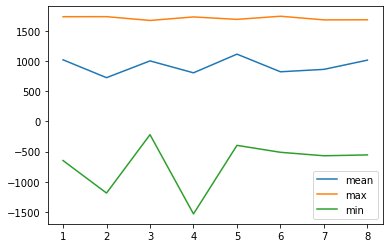

mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
                        eatFood
                        add
                           mul
                              1.0
                              minGhostDist
                           mul
                              add
                                 mul
                                    minDistToFood
                                    minGhostDist
                                 add
                                    2.0
         

In [12]:
NUM_GEN = 8
GEN_TRAIN_OFFSET=4
NUM_GAMES = 4
population, fitness, x, y1, y2, y3 = generationLoop('mediumClassic', population)
winsDict = {}
for p in population:
    p.print_tree()
    print(" - - - - ")
print(fitness)

print(winsDict)

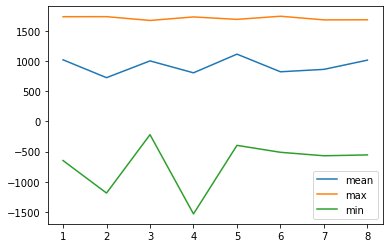

In [13]:
plt.plot(x, y1, '-', x, y2, '-', x, y3, '-')
plt.legend(['mean', 'max', 'min'], loc='best')
plt.show()

mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
                        eatFood
                        add
                           mul
                              1.0
                              minGhostDist
                           mul
                              add
                                 mul
                                    minDistToFood
                                    minGhostDist
                                 add
                                    2.0
         

                                    1.0
                              add
                                 add
                                    eatFood
                                    1.0
                                 add
                                    eatFood
                                    1.0
                     encounterGhost
                  mul
                     add
                        mul
                           minDistToFood
                           minDistToFood
                        add
                           add
                              add
                                 add
                                    eatFood
                                    minGhostDist
                                 add
                                    eatFood
                                    1.0
                              minGhostDist
                           add
                              eatFood
                              add
 

Pacman died! Score: 425
Pacman died! Score: 873
Average Score: 649.0
Scores:        425.0, 873.0
Win Rate:      0/2 (0.00)
Record:        Loss, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         minDistToFood
      mul
         add
            add
               mul
                  add
                     eatFood
                     add
                        eatFood
                        1.0
                  minGhostDist
               add
                  1.0
                  1.0
            add
               eatFood
               eatFood
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               mul
                  2.0
                  encounterGhost
            add
               add
      

Pacman died! Score: 2156
Pacman died! Score: 1136
Average Score: 1646.0
Scores:        2156.0, 1136.0
Win Rate:      0/2 (0.00)
Record:        Loss, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  minDistToFood
               1.0
            add
               eatFood
               add
                  mul
                     2.0
                     1.0
                  mul
                     add
                        mul
                           minDistToFood
                           minDistToFood
                        add
               

Pacman emerges victorious! Score: 2877
Pacman emerges victorious! Score: 2476
Average Score: 2676.5
Scores:        2877.0, 2476.0
Win Rate:      2/2 (1.00)
Record:        Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      add
         mul
            add
               -1.0
               minDistEdibleGhost
            minDistEdibleGhost
         mul
            mul
               2.0
               2.0
            add
               eatFood
               -1.0
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     add
                        eatFood
                        minGhostDist
       

Pacman emerges victorious! Score: 2879
Pacman died! Score: 1093
Average Score: 1986.0
Scores:        2879.0, 1093.0
Win Rate:      1/2 (0.50)
Record:        Win, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      sub
         sub
            encounterGhost
            sub
               2.0
               distToPill
         sub
            add
               minDistToFood
               eatFood
            minGhostDist
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     ad

Pacman emerges victorious! Score: 2410
Pacman emerges victorious! Score: 2539
Average Score: 2474.5
Scores:        2410.0, 2539.0
Win Rate:      2/2 (1.00)
Record:        Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     add
                        eatFood
                        1.0
               1.0
            add
               eatFood
               add
                  mul
                     2.0
                     1.0
                  mul
                     add
                       

Pacman emerges victorious! Score: 2855
Pacman emerges victorious! Score: 2893
Average Score: 2874.0
Scores:        2855.0, 2893.0
Win Rate:      2/2 (1.00)
Record:        Win, Win
G 1  - FITNESS:  [649.0, 2988.0, 2281.5, -715.5, 1664.5, 3536.0, 1939.0, 1646.0, 2639.5, 1789.0, 1037.5, -726.0, 403.0, 2676.5, 1486.0, 1686.5, 2577.0, 1986.0, 431.5, 2302.0, 2474.5, 61.5, 2779.5, 2874.0]
G 2  - POPULATION
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            mul
               mul
                  minDistEdibleGhost
                  minDistEdibleGhost
               minGhostDist
            add
               eatFood
               1.0
   add
      minDistToFood
      add
         add
            add
               minGhostDist
               1.0
            actionScore
         sub
            mul
           

Pacman emerges victorious! Score: 2625
Pacman emerges victorious! Score: 2454
Pacman died! Score: 998
Pacman emerges victorious! Score: 2459
Pacman emerges victorious! Score: 2649
Average Score: 2237.0
Scores:        2625.0, 2454.0, 998.0, 2459.0, 2649.0
Win Rate:      4/5 (0.80)
Record:        Win, Win, Loss, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
sub
   sub
      -1.0
      add
         minGhostDist
         minDistEdibleGhost
   sub
      mul
         actionScore
         actionScore
      minDistEdibleGhost
Pacman died! Score: -329
Pacman died! Score: -451
Pacman died! Score: 407
Pacman died! Score: 375
Pacman died! Score: 299
Average Score: 60.2
Scores:        -329.0, -451.0, 407.0, 375.0, 299.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add

Pacman emerges victorious! Score: 2852
Pacman died! Score: 1974
Pacman emerges victorious! Score: 2669
Pacman emerges victorious! Score: 2475
Pacman emerges victorious! Score: 2679
Average Score: 2529.8
Scores:        2852.0, 1974.0, 2669.0, 2475.0, 2679.0
Win Rate:      4/5 (0.80)
Record:        Win, Loss, Win, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     add
                        eatFood
                        1.0
               1.0
            add
               eatFood
               add

Pacman emerges victorious! Score: 3181
Pacman emerges victorious! Score: 3022
Pacman emerges victorious! Score: 2629
Pacman emerges victorious! Score: 3552
Pacman emerges victorious! Score: 2800
Average Score: 3036.8
Scores:        3181.0, 3022.0, 2629.0, 3552.0, 2800.0
Win Rate:      5/5 (1.00)
Record:        Win, Win, Win, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
add
   add
      add
         add
            eatFood
            minGhostDist
         add
            eatFood
            1.0
      1.0
   add
      eatFood
      add
         mul
            add
               eatFood
               add
                  mul
                     1.0
                     minGhostDist
                  mul
                     add
                        mul
                           minDistToFood
                           minGhostDist
                        add
                           2.0
        

Pacman emerges victorious! Score: 2751
Pacman emerges victorious! Score: 2676
Pacman died! Score: 1527
Pacman emerges victorious! Score: 3217
Pacman died! Score: 669
Average Score: 2168.0
Scores:        2751.0, 2676.0, 1527.0, 3217.0, 669.0
Win Rate:      3/5 (0.60)
Record:        Win, Win, Loss, Win, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               encounterGhost
   add
      minDistToFood
      add
         add
            a

Pacman emerges victorious! Score: 2885
Pacman emerges victorious! Score: 2595
Pacman emerges victorious! Score: 2414
Pacman emerges victorious! Score: 3050
Pacman emerges victorious! Score: 2537
Average Score: 2696.2
Scores:        2885.0, 2595.0, 2414.0, 3050.0, 2537.0
Win Rate:      5/5 (1.00)
Record:        Win, Win, Win, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  minDistToFood
               1.0
            add
               eatFood
               add
                  mul
                     2.0
                     1.0
                  

Pacman died! Score: -461
Pacman died! Score: -420
Pacman died! Score: -363
Pacman died! Score: -446
Pacman died! Score: -456
Average Score: -429.2
Scores:        -461.0, -420.0, -363.0, -446.0, -456.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  minDistToFood
               add
                  add
                     eatFood
                     1.0
                  add
                     eatFood
                     1.0
            add
               eatFood
               add
   

Pacman died! Score: 499
Pacman emerges victorious! Score: 2611
Pacman emerges victorious! Score: 3139
Pacman died! Score: 1742
Pacman emerges victorious! Score: 3026
Average Score: 2203.4
Scores:        499.0, 2611.0, 3139.0, 1742.0, 3026.0
Win Rate:      3/5 (0.60)
Record:        Loss, Win, Win, Loss, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
                        eat

Pacman died! Score: 1446
Pacman emerges victorious! Score: 2626
Pacman emerges victorious! Score: 2870
Pacman emerges victorious! Score: 3271
Pacman died! Score: 1409
Average Score: 2324.4
Scores:        1446.0, 2626.0, 2870.0, 3271.0, 1409.0
Win Rate:      3/5 (0.60)
Record:        Loss, Win, Win, Win, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            sub
               add
                  sub
                     1.0
                     1.0
                  mul
                     minDistToFood
                     minDistToFood
               sub
                  1.0
                  sub
                     minDistEdibleGhost
                     minGhostDist
         add
            add
               add
                  add
          

Pacman emerges victorious! Score: 2607
Pacman emerges victorious! Score: 2446
Pacman emerges victorious! Score: 2457
Pacman emerges victorious! Score: 3452
Pacman emerges victorious! Score: 2865
Average Score: 2765.4
Scores:        2607.0, 2446.0, 2457.0, 3452.0, 2865.0
Win Rate:      5/5 (1.00)
Record:        Win, Win, Win, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      eatFood
      add
         minDistToFood
         add
            add
               add
                  minGhostDist
                  1.0
               actionScore
            sub
               mul
                  minDistEdibleGhost
                  add
                     eatFood
                     1.0
               mul
                  minDistEdibleGhost
                  minDistEdibleGhost
   add
      minDistToFood
      add
         add
            add
               minGhostDist
               1.0
    

Pacman died! Score: 863
Pacman died! Score: 554
Pacman died! Score: 705
Pacman died! Score: 611
Pacman emerges victorious! Score: 3057
Average Score: 1158.0
Scores:        863.0, 554.0, 705.0, 611.0, 3057.0
Win Rate:      1/5 (0.20)
Record:        Loss, Loss, Loss, Loss, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            eatFood
            1.0
         add
            minDistToFood
            add
               add
                  add
                     minGhostDist
                     1.0
                  actionScore
               add
                  minDistToFood
                  add
                     add
                        add
                           minGhostDist
                           1.0
                        actionScore
                     sub
                        mul
                

Pacman died! Score: -230
Pacman died! Score: 851
Pacman died! Score: 1275
Pacman died! Score: -347
Pacman died! Score: 712
Average Score: 452.2
Scores:        -230.0, 851.0, 1275.0, -347.0, 712.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
add
   mul
      add
         encounterGhost
         2.0
      minDistToFood
   sub
      mul
         0.5
         1.0
      add
         0.5
         minDistEdibleGhost
Pacman died! Score: -321
Pacman died! Score: -139
Pacman died! Score: -98
Pacman died! Score: -227
Pacman died! Score: -225
Average Score: -202.0
Scores:        -321.0, -139.0, -98.0, -227.0, -225.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterG

Pacman emerges victorious! Score: 2846
Pacman emerges victorious! Score: 2558
Pacman emerges victorious! Score: 3245
Pacman emerges victorious! Score: 2850
Pacman emerges victorious! Score: 3470
Average Score: 2993.8
Scores:        2846.0, 2558.0, 3245.0, 2850.0, 3470.0
Win Rate:      5/5 (1.00)
Record:        Win, Win, Win, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               minDistToFood
               add
                  add
                     add
                        minGhostDist
                        1.0
                     actionScore
                  sub
                     mul
                        minDistEdibleGhost
                    

Pacman died! Score: 1467
Pacman died! Score: 1411
Pacman emerges victorious! Score: 2365
Pacman died! Score: 1095
Pacman emerges victorious! Score: 3073
Average Score: 1882.2
Scores:        1467.0, 1411.0, 2365.0, 1095.0, 3073.0
Win Rate:      2/5 (0.40)
Record:        Loss, Loss, Win, Loss, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  minDistToFood
               1.0
            add
               eatFood
               add
                  mul
                     2.0
                     1.0
                  mul
                     add
          

Pacman died! Score: 1781
Pacman died! Score: 1523
Pacman died! Score: 1516
Pacman died! Score: 1813
Pacman died! Score: 1071
Average Score: 1540.8
Scores:        1781.0, 1523.0, 1516.0, 1813.0, 1071.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
                        eatFood
                        add
    

Pacman emerges victorious! Score: 2594
Pacman emerges victorious! Score: 2606
Pacman died! Score: 1273
Pacman emerges victorious! Score: 2965
Pacman emerges victorious! Score: 2821
Average Score: 2451.8
Scores:        2594.0, 2606.0, 1273.0, 2965.0, 2821.0
Win Rate:      4/5 (0.80)
Record:        Win, Win, Loss, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
            

Pacman emerges victorious! Score: 3256
Pacman emerges victorious! Score: 2882
Pacman died! Score: 1456
Pacman emerges victorious! Score: 2807
Pacman died! Score: 1773
Average Score: 2434.8
Scores:        3256.0, 2882.0, 1456.0, 2807.0, 1773.0
Win Rate:      3/5 (0.60)
Record:        Win, Win, Loss, Win, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
                        e

Pacman emerges victorious! Score: 2582
Pacman emerges victorious! Score: 3443
Pacman died! Score: 15
Pacman died! Score: 610
Pacman died! Score: 164
Average Score: 1362.8
Scores:        2582.0, 3443.0, 15.0, 610.0, 164.0
Win Rate:      2/5 (0.40)
Record:        Win, Win, Loss, Loss, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      eatFood
      1.0
   add
      minDistToFood
      add
         add
            add
               add
                  sub
                     1.0
                     1.0
                  mul
                     0.5
                     add
                        eatFood
                        1.0
               mul
                  2.0
                  actionScore
            actionScore
         add
            eatFood
            1.0
Pacman emerges victorious! Score: 3037
Pacman died! Score: 1150
Pacman died! Score: 1559
Pacman died! Score: 683
Pacman die

Pacman emerges victorious! Score: 3015
Pacman emerges victorious! Score: 3073
Pacman emerges victorious! Score: 2645
Pacman died! Score: 1608
Pacman emerges victorious! Score: 2846
Average Score: 2637.4
Scores:        3015.0, 3073.0, 2645.0, 1608.0, 2846.0
Win Rate:      4/5 (0.80)
Record:        Win, Win, Win, Loss, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
add
   mul
      minDistToFood
      2.0
   add
      eatFood
      1.0
Pacman died! Score: 1202
Pacman died! Score: 502
Pacman died! Score: -77
Pacman died! Score: 1859
Pacman died! Score: -194
Average Score: 658.4
Scores:        1202.0, 502.0, -77.0, 1859.0, -194.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
  

Pacman emerges victorious! Score: 2661
Pacman emerges victorious! Score: 3269
Pacman emerges victorious! Score: 3016
Pacman died! Score: 958
Pacman emerges victorious! Score: 2571
Average Score: 2495.0
Scores:        2661.0, 3269.0, 3016.0, 958.0, 2571.0
Win Rate:      4/5 (0.80)
Record:        Win, Win, Win, Loss, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
              

Pacman emerges victorious! Score: 2963
Pacman emerges victorious! Score: 3005
Pacman emerges victorious! Score: 3585
Pacman emerges victorious! Score: 3268
Pacman emerges victorious! Score: 3187
Average Score: 3201.6
Scores:        2963.0, 3005.0, 3585.0, 3268.0, 3187.0
Win Rate:      5/5 (1.00)
Record:        Win, Win, Win, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      add
         eatFood
         1.0
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
      

Pacman died! Score: 1689
Pacman emerges victorious! Score: 2469
Pacman emerges victorious! Score: 2450
Pacman emerges victorious! Score: 2644
Pacman emerges victorious! Score: 2889
Average Score: 2428.2
Scores:        1689.0, 2469.0, 2450.0, 2644.0, 2889.0
Win Rate:      4/5 (0.80)
Record:        Loss, Win, Win, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               minDistToFood
               add
                  add
                     add
                        minGhostDist
                        1.0
                     actionScore
                  sub
                     mul
                        mul
                           add
                 

Pacman emerges victorious! Score: 2855
Pacman emerges victorious! Score: 2600
Pacman emerges victorious! Score: 2649
Pacman emerges victorious! Score: 2847
Pacman emerges victorious! Score: 3000
Average Score: 2790.2
Scores:        2855.0, 2600.0, 2649.0, 2847.0, 3000.0
Win Rate:      5/5 (1.00)
Record:        Win, Win, Win, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      add
         eatFood
         1.0
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            mul
               2.0
               encounterGhost
            add
               mul
                  add
                     mul
                        minDistToFood
                        minGhostDist
                     eatFood
                  add
                     add
                        eatF

Pacman emerges victorious! Score: 2805
Pacman died! Score: 1642
Pacman emerges victorious! Score: 2446
Pacman emerges victorious! Score: 2587
Pacman emerges victorious! Score: 3042
Average Score: 2504.4
Scores:        2805.0, 1642.0, 2446.0, 2587.0, 3042.0
Win Rate:      4/5 (0.80)
Record:        Win, Loss, Win, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      add
         eatFood
         1.0
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            mul
               2.0
               encounterGhost
            add
               eatFood
               add
                  mul
                     add
                        eatFood
                        add
                           mul
                              1.0
                              minGhostDist
 

Pacman emerges victorious! Score: 2943
Pacman emerges victorious! Score: 3079
Pacman emerges victorious! Score: 2578
Pacman emerges victorious! Score: 2875
Pacman died! Score: 1384
Average Score: 2571.8
Scores:        2943.0, 3079.0, 2578.0, 2875.0, 1384.0
Win Rate:      4/5 (0.80)
Record:        Win, Win, Win, Win, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
            

Pacman died! Score: -402
Pacman died! Score: -495
Pacman died! Score: -403
Pacman died! Score: -425
Pacman died! Score: -352
Average Score: -415.4
Scores:        -402.0, -495.0, -403.0, -425.0, -352.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      eatFood
      1.0
   add
      minDistToFood
      add
         add
            add
               minGhostDist
               1.0
            actionScore
         sub
            mul
               minDistEdibleGhost
               add
                  eatFood
                  add
                     mul
                        2.0
                        encounterGhost
                     mul
                        add
                           mul
                              minDistToFood
                              minGhostDist
                           add
             

Pacman emerges victorious! Score: 2848
Pacman emerges victorious! Score: 2671
Pacman emerges victorious! Score: 2594
Pacman emerges victorious! Score: 3078
Pacman emerges victorious! Score: 2847
Average Score: 2807.6
Scores:        2848.0, 2671.0, 2594.0, 3078.0, 2847.0
Win Rate:      5/5 (1.00)
Record:        Win, Win, Win, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add

Pacman emerges victorious! Score: 2576
Pacman emerges victorious! Score: 2421
Pacman emerges victorious! Score: 2625
Pacman emerges victorious! Score: 2594
Pacman emerges victorious! Score: 2650
Average Score: 2573.2
Scores:        2576.0, 2421.0, 2625.0, 2594.0, 2650.0
Win Rate:      5/5 (1.00)
Record:        Win, Win, Win, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      eatFood
      1.0
   add
      minDistToFood
      add
         add
            add
               add
                  add
                     add
                        eatFood
                        minGhostDist
                     add
                        eatFood
                        1.0
                  1.0
               add
                  eatFood
                  add
                     mul
                        add
                           eatFood
                           add
               

Pacman died! Score: 1195
Pacman died! Score: 265
Pacman died! Score: 460
Pacman died! Score: 287
Pacman died! Score: 955
Average Score: 632.4
Scores:        1195.0, 265.0, 460.0, 287.0, 955.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
                        eatFood
                        add
             

Pacman emerges victorious! Score: 2607
Pacman emerges victorious! Score: 2387
Pacman emerges victorious! Score: 3243
Pacman emerges victorious! Score: 2587
Pacman emerges victorious! Score: 2947
Average Score: 2754.2
Scores:        2607.0, 2387.0, 3243.0, 2587.0, 2947.0
Win Rate:      5/5 (1.00)
Record:        Win, Win, Win, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      eatFood
      1.0
   add
      minDistToFood
      add
         add
            add
               minGhostDist
               1.0
            add
               minDistToFood
               1.0
         sub
            mul
               minDistEdibleGhost
               add
                  eatFood
                  add
                     mul
                        2.0
                        encounterGhost
                     mul
                        add
                           mul
                          

Pacman died! Score: 275
Pacman emerges victorious! Score: 3666
Pacman emerges victorious! Score: 3065
Pacman emerges victorious! Score: 2837
Pacman emerges victorious! Score: 2889
Average Score: 2546.4
Scores:        275.0, 3666.0, 3065.0, 2837.0, 2889.0
Win Rate:      4/5 (0.80)
Record:        Loss, Win, Win, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
              

Pacman emerges victorious! Score: 3152
Pacman died! Score: 1811
Pacman emerges victorious! Score: 2761
Pacman emerges victorious! Score: 3597
Pacman emerges victorious! Score: 3814
Average Score: 3027.0
Scores:        3152.0, 1811.0, 2761.0, 3597.0, 3814.0
Win Rate:      4/5 (0.80)
Record:        Win, Loss, Win, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      add
         eatFood
         1.0
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            mul
               2.0
               encounterGhost
            add
               eatFood
               add
                  eatFood
                  minGhostDist
   add
      minDistToFood
      add
         add
            add
               minGhostDist
               1.0
            actionScore
         sub
         

Pacman died! Score: 2012
Pacman emerges victorious! Score: 2846
Pacman died! Score: 1586
Pacman emerges victorious! Score: 2992
Pacman emerges victorious! Score: 3007
Average Score: 2488.6
Scores:        2012.0, 2846.0, 1586.0, 2992.0, 3007.0
Win Rate:      3/5 (0.60)
Record:        Loss, Win, Loss, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   sub
      actionScore
      actionScore
   sub
      add
         encounterGhost
         distToPill
      minGhostDist
Pacman died! Score: -384
Pacman died! Score: -107
Pacman died! Score: -406
Pacman died! Score: -474
Pacman died! Score: -415
Average Score: -357.2
Scores:        -384.0, -107.0, -406.0, -474.0, -415.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      eatFood
      1.0
   add
      minD

Pacman emerges victorious! Score: 2487
Pacman emerges victorious! Score: 2657
Pacman died! Score: 1671
Pacman emerges victorious! Score: 3041
Pacman emerges victorious! Score: 2654
Average Score: 2502.0
Scores:        2487.0, 2657.0, 1671.0, 3041.0, 2654.0
Win Rate:      4/5 (0.80)
Record:        Win, Win, Loss, Win, Win
FITNESS:  [-415.4, 2906.2, 2807.6, 2345.0, 718.6, 2787.0, -55.6, -360.0, 2573.2, 632.4, 1952.2, 2754.2, 632.6, -382.4, 2546.4, 1914.6, 2321.4, 3027.0, 2251.6, 2220.4, 2488.6, -357.2, 2003.4, 2502.0]
Avg:  1658.908333333333
Max:  3027.0
Min:  -415.4
G 6  - POPULATION
mul
   add
      eatFood
      mul
         add
            eatFood
            mul
               distToPill
               2.0
         add
            minGhostDist
            distToPill
   add
      minDistToFood
      add
         add
            add
               minGhostDist
               minGhostDist
            actionScore
         sub
            mul
               minDistEdibleGhost
           

Pacman died! Score: -420
Pacman died! Score: 8
Pacman died! Score: -268
Pacman died! Score: -62
Pacman died! Score: -103
Average Score: -169.0
Scores:        -420.0, 8.0, -268.0, -62.0, -103.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      eatFood
      1.0
   add
      minDistToFood
      add
         add
            add
               minGhostDist
               1.0
            actionScore
         sub
            mul
               minDistEdibleGhost
               add
                  eatFood
                  add
                     mul
                        2.0
                        encounterGhost
                     mul
                        add
                           mul
                              minDistToFood
                              minGhostDist
                           add
                     

Pacman died! Score: -539
Pacman died! Score: -570
Pacman died! Score: -543
Pacman died! Score: -568
Pacman died! Score: -537
Average Score: -551.4
Scores:        -539.0, -570.0, -543.0, -568.0, -537.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      eatFood
      1.0
   2.0
Pacman died! Score: 568
Pacman died! Score: 65
Pacman died! Score: -37
Pacman died! Score: -67
Pacman died! Score: 644
Average Score: 234.6
Scores:        568.0, 65.0, -37.0, -67.0, 644.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatF

Pacman emerges victorious! Score: 3015
Pacman died! Score: 1738
Pacman emerges victorious! Score: 3097
Pacman emerges victorious! Score: 2788
Pacman emerges victorious! Score: 2809
Average Score: 2689.4
Scores:        3015.0, 1738.0, 3097.0, 2788.0, 2809.0
Win Rate:      4/5 (0.80)
Record:        Win, Loss, Win, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      add
         eatFood
         1.0
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            mul
               2.0
               encounterGhost
            add
               eatFood
               add
                  eatFood
                  minGhostDist
   add
      minDistToFood
      add
         add
            add
               minGhostDist
               1.0
            actionScore
         sub
         

Pacman emerges victorious! Score: 3240
Pacman emerges victorious! Score: 4056
Pacman emerges victorious! Score: 2849
Pacman emerges victorious! Score: 2654
Pacman emerges victorious! Score: 2420
Average Score: 3043.8
Scores:        3240.0, 4056.0, 2849.0, 2654.0, 2420.0
Win Rate:      5/5 (1.00)
Record:        Win, Win, Win, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   mul
      add
         sub
            minGhostDist
            actionScore
         encounterGhost
      add
         2.0
         1.0
   add
      minDistToFood
      add
         add
            add
               minGhostDist
               1.0
            actionScore
         sub
            mul
               minDistEdibleGhost
               add
                  eatFood
                  1.0
            mul
               minDistEdibleGhost
               minDistEdibleGhost
Pacman died! Score: -532
Pacman died! Score: -540


Pacman died! Score: 2070
Pacman emerges victorious! Score: 2254
Pacman died! Score: 1318
Pacman emerges victorious! Score: 2191
Pacman died! Score: 1353
Average Score: 1837.2
Scores:        2070.0, 2254.0, 1318.0, 2191.0, 1353.0
Win Rate:      2/5 (0.40)
Record:        Loss, Win, Loss, Win, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
                        eatFood
      

Pacman emerges victorious! Score: 2790
Pacman emerges victorious! Score: 2669
Pacman died! Score: 866
Pacman emerges victorious! Score: 2939
Pacman emerges victorious! Score: 3206
Average Score: 2494.0
Scores:        2790.0, 2669.0, 866.0, 2939.0, 3206.0
Win Rate:      4/5 (0.80)
Record:        Win, Win, Loss, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      eatFood
      1.0
   add
      minDistToFood
      add
         sub
            mul
               add
                  minDistEdibleGhost
                  actionScore
               eatFood
            sub
               add
                  minDistToFood
                  minDistEdibleGhost
               eatFood
         sub
            mul
               minDistEdibleGhost
               add
                  eatFood
                  add
                     mul
                        2.0
                        encounterGhost


Pacman emerges victorious! Score: 2420
Pacman died! Score: 435
Pacman died! Score: 1568
Pacman emerges victorious! Score: 3281
Pacman emerges victorious! Score: 2839
Average Score: 2108.6
Scores:        2420.0, 435.0, 1568.0, 3281.0, 2839.0
Win Rate:      3/5 (0.60)
Record:        Win, Loss, Loss, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
                        eat

Pacman died! Score: 1901
Pacman emerges victorious! Score: 2670
Average Score: 2512.6
Scores:        2399.0, 2930.0, 2663.0, 1901.0, 2670.0
Win Rate:      4/5 (0.80)
Record:        Win, Win, Win, Loss, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
                        1.0
                        add
                           mul
                              1.0
        

Pacman emerges victorious! Score: 3698
Pacman died! Score: 1302
Pacman emerges victorious! Score: 2539
Pacman died! Score: 253
Pacman emerges victorious! Score: 2854
Average Score: 2129.2
Scores:        3698.0, 1302.0, 2539.0, 253.0, 2854.0
Win Rate:      3/5 (0.60)
Record:        Win, Loss, Win, Loss, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      eatFood
      1.0
   add
      minDistToFood
      add
         add
            add
               minGhostDist
               1.0
            actionScore
         sub
            mul
               minDistEdibleGhost
               add
                  eatFood
                  add
                     mul
                        2.0
                        encounterGhost
                     mul
                        add
                           mul
                              minDistToFood
                              minGhostDist
       

Pacman died! Score: 1738
Pacman died! Score: 1911
Pacman emerges victorious! Score: 2520
Pacman emerges victorious! Score: 2700
Pacman died! Score: 525
Average Score: 1878.8
Scores:        1738.0, 1911.0, 2520.0, 2700.0, 525.0
Win Rate:      2/5 (0.40)
Record:        Loss, Loss, Win, Win, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
add
   minDistToFood
   add
      add
         add
            eatFood
            mul
               2.0
               mul
                  add
                     mul
                        2.0
                        encounterGhost
                     mul
                        add
                           mul
                              minDistToFood
                              minGhostDist
                           add
                              eatFood
                              1.0
                        add
                           add
             

Pacman died! Score: 461
Pacman emerges victorious! Score: 2949
Pacman emerges victorious! Score: 2636
Pacman emerges victorious! Score: 2874
Pacman emerges victorious! Score: 3573
Average Score: 2498.6
Scores:        461.0, 2949.0, 2636.0, 2874.0, 3573.0
Win Rate:      4/5 (0.80)
Record:        Loss, Win, Win, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
              

Pacman died! Score: 239
Pacman died! Score: 388
Pacman emerges victorious! Score: 2617
Pacman died! Score: 839
Pacman emerges victorious! Score: 2782
Average Score: 1373.0
Scores:        239.0, 388.0, 2617.0, 839.0, 2782.0
Win Rate:      2/5 (0.40)
Record:        Loss, Loss, Win, Loss, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      minDistToFood
   add
      minDistToFood
      add
         add
            add
               minGhostDist
               1.0
            actionScore
         sub
            mul
               minDistEdibleGhost
               add
                  1.0
                  add
                     eatFood
                     add
                        mul
                           add
                              eatFood
                              add
                                 mul
                          

Pacman emerges victorious! Score: 3211
Pacman emerges victorious! Score: 3055
Pacman emerges victorious! Score: 2654
Pacman emerges victorious! Score: 3051
Pacman died! Score: 1791
Average Score: 2752.4
Scores:        3211.0, 3055.0, 2654.0, 3051.0, 1791.0
Win Rate:      4/5 (0.80)
Record:        Win, Win, Win, Win, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
            

Pacman emerges victorious! Score: 2303
Pacman emerges victorious! Score: 2604
Pacman emerges victorious! Score: 2499
Pacman emerges victorious! Score: 2637
Pacman emerges victorious! Score: 2793
Average Score: 2567.2
Scores:        2303.0, 2604.0, 2499.0, 2637.0, 2793.0
Win Rate:      5/5 (1.00)
Record:        Win, Win, Win, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add

Pacman died! Score: 2183
Pacman emerges victorious! Score: 2839
Pacman emerges victorious! Score: 2820
Pacman emerges victorious! Score: 3260
Pacman emerges victorious! Score: 2902
Average Score: 2800.8
Scores:        2183.0, 2839.0, 2820.0, 3260.0, 2902.0
Win Rate:      4/5 (0.80)
Record:        Loss, Win, Win, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
            

Pacman emerges victorious! Score: 3021
Pacman died! Score: 255
Pacman emerges victorious! Score: 2826
Pacman emerges victorious! Score: 3011
Pacman died! Score: 1814
Average Score: 2185.4
Scores:        3021.0, 255.0, 2826.0, 3011.0, 1814.0
Win Rate:      3/5 (0.60)
Record:        Win, Loss, Win, Win, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
                        eat

Pacman died! Score: 1778
Pacman emerges victorious! Score: 2642
Pacman emerges victorious! Score: 3014
Pacman emerges victorious! Score: 2858
Pacman died! Score: 2040
Average Score: 2466.4
Scores:        1778.0, 2642.0, 3014.0, 2858.0, 2040.0
Win Rate:      3/5 (0.60)
Record:        Loss, Win, Win, Win, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      eatFood
      1.0
   add
      minDistToFood
      add
         add
            add
               minGhostDist
               1.0
            actionScore
         sub
            mul
               minDistEdibleGhost
               add
                  eatFood
                  add
                     mul
                        2.0
                        encounterGhost
                     mul
                        add
                           mul
                              minDistToFood
                              mul
              

Pacman died! Score: 1662
Pacman emerges victorious! Score: 2750
Pacman died! Score: 1643
Pacman emerges victorious! Score: 2623
Pacman emerges victorious! Score: 2348
Average Score: 2205.2
Scores:        1662.0, 2750.0, 1643.0, 2623.0, 2348.0
Win Rate:      3/5 (0.60)
Record:        Loss, Win, Loss, Win, Win
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
                        e

Pacman died! Score: -490
Pacman died! Score: -186
Pacman died! Score: 572
Pacman died! Score: 23
Pacman died! Score: 355
Average Score: 54.8
Scores:        -490.0, -186.0, 572.0, 23.0, 355.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
                        eatFood
                        add
              

Pacman died! Score: -199
Pacman died! Score: -463
Pacman died! Score: -413
Pacman died! Score: -442
Pacman died! Score: -659
Average Score: -435.2
Scores:        -199.0, -463.0, -413.0, -442.0, -659.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
                        eatFood
                        add
    

Pacman emerges victorious! Score: 3036
Pacman died! Score: 785
Pacman emerges victorious! Score: 3198
Pacman died! Score: 469
Pacman emerges victorious! Score: 2647
Average Score: 2027.0
Scores:        3036.0, 785.0, 3198.0, 469.0, 2647.0
Win Rate:      3/5 (0.60)
Record:        Win, Loss, Win, Loss, Win
FITNESS:  [1878.8, 1574.2, 2498.6, 1955.0, 1373.0, 462.0, 2752.4, 1933.0, 2567.2, 2894.0, 2800.8, 2469.4, 2185.4, 3013.0, 2466.4, 1923.6, 2205.2, 2984.6, 695.6, -563.4, 54.8, -435.2, 2873.2, 2027.0]
Avg:  1857.8583333333333
Max:  3013.0
Min:  -563.4
gen means:  [1655.8833333333332, 1786.708333333334, 2163.4, 1658.908333333333, 1672.6916666666666, 1857.8583333333333]
gen maxes:  [3036.8, 2993.8, 3201.6, 3027.0, 3043.8, 3013.0]
gen mins:  [-551.8, -251.4, 629.8, -415.4, -551.4, -563.4]


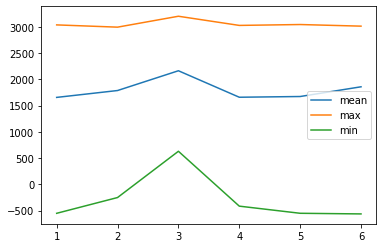

mul
   add
      mul
         2.0
         encounterGhost
      add
         sub
            add
               encounterGhost
               0.5
            actionScore
         add
            add
               0.5
               minDistToFood
            distToPill
   add
      add
         minDistToFood
         add
            add
               add
                  eatFood
                  mul
                     2.0
                     actionScore
               actionScore
            add
               1.0
               1.0
      add
         add
            add
               minGhostDist
               1.0
            actionScore
         sub
            mul
               minDistEdibleGhost
               add
                  eatFood
                  1.0
            mul
               mul
                  sub
                     1.0
                     minDistEdibleGhost
                  0.5
               mul
                  mul
                     eatFood
 

      1.0
   add
      minDistToFood
      add
         add
            add
               minGhostDist
               1.0
            actionScore
         sub
            mul
               minDistEdibleGhost
               add
                  eatFood
                  add
                     mul
                        2.0
                        encounterGhost
                     mul
                        add
                           mul
                              minDistToFood
                              minGhostDist
                           add
                              eatFood
                              1.0
                        add
                           add
                              add
                                 add
                                    eatFood
                                    minGhostDist
                                 minDistToFood
                              1.0
                           add
                      

In [14]:
NUM_GEN = 6
GEN_TRAIN_OFFSET=2
NUM_GAMES = 5
population, fitness, x, y1, y2, y3 = generationLoop('originalClassic', population)
winsDict = {}
for p in population:
    p.print_tree()
    print(" - - - - ")
print(fitness)

print(winsDict)

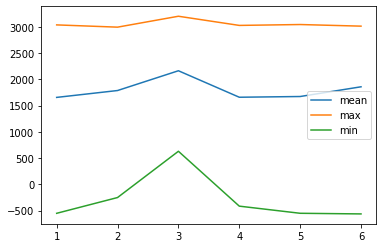

In [15]:
plt.plot(x, y1, '-', x, y2, '-', x, y3, '-')
plt.legend(['mean', 'max', 'min'], loc='best')
plt.show()

In [18]:
GPFinalPopulation = population
fittestInd = population[fitness.index(max(fitness))]

In [50]:
winsDict[str(30)] = []
NUM_GAMES=10
avgScore, scores, wins = trainIndividual(fittestInd, 30, layoutType='smallClassic')

layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
                        eatFood
                        add
                           mul
                              1.0
                              minGhostDist
                           1.0
                     encounterGhost
                  mul
                     add
                        mul
                           m

Average Score:  528.0


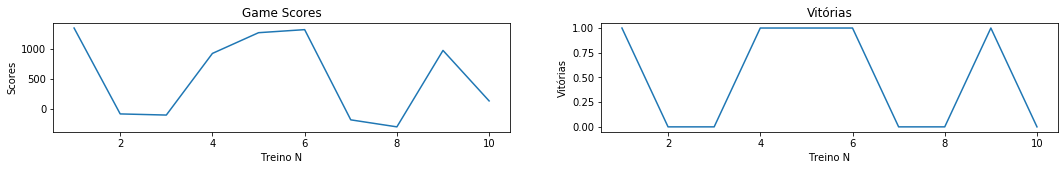

In [51]:
# graficos de GP
print("Average Score: ",avgScore)
fig = plt.figure(figsize=(18, 2))
plt.subplot(121)
plt.xlabel('Treino N')
plt.ylabel('Scores')
plt.title('Game Scores')
plt.plot(range(1,len(scores)+1),scores[:])

plt.subplot(122)
plt.xlabel('Treino N')
plt.ylabel('Vitórias')
plt.title('Vitórias')
plt.plot(range(1,len(wins)+1),wins[:])

In [52]:
avgScore, scores, wins = trainIndividual(fittestInd, 30, layoutType='mediumClassic')

layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
                        eatFood
                        add
                           mul
                              1.0
                              minGhostDist
                           1.0
                     encounterGhost
                  mul
                     add
                        mul
                           

Average Score:  1261.8


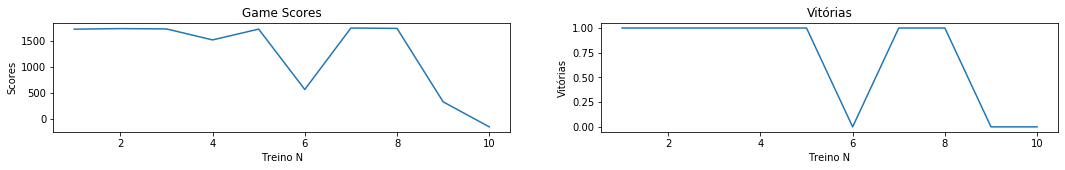

In [53]:
# graficos de GP
print("Average Score: ",avgScore)
fig = plt.figure(figsize=(18, 2))
plt.subplot(121)
plt.xlabel('Treino N')
plt.ylabel('Scores')
plt.title('Game Scores')
plt.plot(range(1,len(scores)+1),scores[:])

plt.subplot(122)
plt.xlabel('Treino N')
plt.ylabel('Vitórias')
plt.title('Vitórias')
plt.plot(range(1,len(wins)+1),wins[:])

In [54]:
avgScore, scores, wins = trainIndividual(fittestInd, 30, layoutType='originalClassic')

layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
                        eatFood
                        add
                           mul
                              1.0
                              minGhostDist
                           1.0
                     encounterGhost
                  mul
                     add
                        mul
                         

Average Score:  2729.4


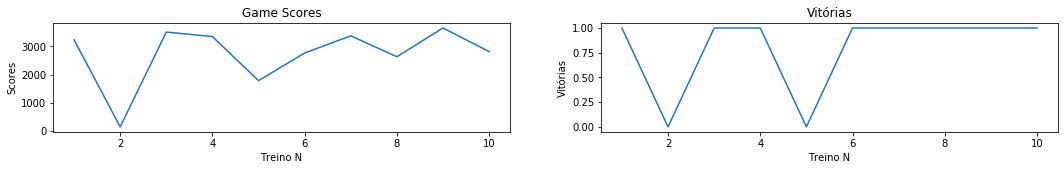

In [55]:
# graficos de GP
print("Average Score: ",avgScore)
fig = plt.figure(figsize=(18, 2))
plt.subplot(121)
plt.xlabel('Treino N')
plt.ylabel('Scores')
plt.title('Game Scores')
plt.plot(range(1,len(scores)+1),scores[:])

plt.subplot(122)
plt.xlabel('Treino N')
plt.ylabel('Vitórias')
plt.title('Vitórias')
plt.plot(range(1,len(wins)+1),wins[:])

### Resultados
&emsp;&emsp;Podemos observar acima o resultado dos treinamentos e de testes com o melhor indivíduo da população final. No início do treinamento, os indivíduos eram compostos por árvores pequenas, porém no decorrer das gerações, as árvores foram ficando mais complexas, para poder criar uma lógica de atuação para o agente, utilizando as funções básicas e os terminais escolhidos (features e constantes numéricas).\
&emsp;&emsp;As features desempenharam um papel importante durante o treinamento. Percebemos que nas gerações iniciais, a feature *actionScore* era dominante, pois era capaz de guiar o agente para a comida e longe dos fantasmas, mas que sozinha ela não era capaz de entregar resultados interessantes. O sucesso desta feature era limitado ao mapa pequeno, e quando iniciou-se o treinamento no mapa médio, a associação com as outras features garantiu o sucesso dos indivíduos. Com associações complexas de features, o agente agora era capaz de explorar o mapa em busca das comidas, e não apenas depender do fantasma para guiá-lo pelo labirinto enquanto foge. Esses genes foram propagados, e o tempo de treinamento e as vitórias foram mais frequentes.\
&emsp;&emsp;O algoritmo foi capaz de resolver o problema do jogo do Pac-Man, apresentando um ótimo desempenho, principalmente para os mapas médio e original.\
&emsp;&emsp;Percebemos que o mapa pequeno é muito eficiente para o treinamento do algoritmo, e que o score máximo 
durante as execuções nos mapas médio e original não variam muito, mas o score médio e mínimo sofrem alterações a cada geração.\
&emsp;&emsp;O único caso em que o agente perde o jogo, é quando ele é encurralado por 2 fantasmas. No restante do tempo, o agente aprende a escapar dos fantasmas e ir em busca das comidas, para ganhar o jogo. O agente também é capaz de comer as pílulas e perseguir os fantasmas quando estão vulneráveis.\
 \
&emsp;&emsp;Apesar dos bons resultados do algoritmo, seu treinamento se apresentou muito custoso. O período de treinamento do modelo foi de 21 horas. Talvez pudéssemos fazer alterações nos parâmetros, ou até limitações no tempo de execução de alguns jogos, pois ás vezes o agente realizava movimentos repetitivos, atrasando o treinamento. Outra ideia também seria utilizar threads para paralelizar o treinamento dos indivíduos, mas isso fica como sugestão para melhorias.


## Parte 2 - Modelo de Aprendizagem por Reforço
&emsp;&emsp;Para nosso modelo de aprendizagem por reforço, levamos em consideração que o agente do jogo precisava estar a par do ambiente para que ele tome uma decisão. Assim, utilizamos as mesmas variáveis de ambiente do algoritmo evolutivo para compor nosso algoritmo.\
&emsp;&emsp;Nossa ideia inicial seria implementar um algoritmo de aprendizagem por reforço que permitisse ao agente tomar decisões baseadas nas observações do estado atual e nas suposições do próximo estado, sem depender de uma tabela de valores para rankear os estados, já que o jogo é composto por inimigos que se movem aleatoriamente.\
&emsp;&emsp;Com isso em mente, adotamos o algoritmo Approximate Q-Learning para resolver o problema, pois ele é policy free e model free, e a atualização dos pesos de Q são obtidos a cada ação do agente.
### MDP (Markov Decision Process)
&emsp;&emsp;Definimos nosso estado como sendo o estado atual e os possíveis estados futuros, dado cada ação disponível para o agente no estado atual. O reforço foi calculado com base na feature *futureScore* que carrega também um reforço durante o treinamento.




### Features
&emsp;Escolhemos as features para nosso modelo de acordo com o que achamos mais importante para a sobrevivência e sucesso do agente durante o jogo. As features relacionadas a distância foram calculadas utilizando o algoritmo BFS (breadth first search), assim conseguimos calcular a distância entre o pacman e o objeto de interesse (fantasmas, comida ou pilula). As features escolhidas são:
- **futureScore**: composto pela diferença entre score futuro e score atual, somado com as variáveis minGhostDist$*200$ (caso minGhostDist = 1) e minDistToFood$*200$ (caso minGhostDist < 1)
- **minGhostDist**: distância para o fantasma perigoso mais próximo ou zero (caso minGhostDist = edibleGhost)
- **minDistToFood**: distância para a comida mais próxima 
- **distToPill**: distância para a pilula mais próxima.
- **edibleGhost**: distância para o fantasma comível mais próximo.

&emsp;Para nosso modelo aprender com mais facilidade, normalizamos o valor absoluto das features de distância entre 0 e 1, computando o valor das features através da funcao $f(x)=1/x^2$. Para o tratamento da feature *futureScore*, dividimos o valor calculado por 500, pois é o valor máximo absoluto do score de uma ação. Essas configurações foram implementadas na intenção de ajudar o modelo a convergir e encontrar valores em uma mesma escala para os pesos.

### Rewards
&emsp;&emsp;As Rewards são calculadas de acordo com a feature *futureScore*, recebendo o valor da feature sem a multiplicação com o peso. Como descrito, uma lógica de reforço positivo e negativo é realizada no cálculo da feature. Isso contribuiu para que o agente aprendesse a a fugir dos fantasmas e ao mesmo tempo fosse em busca das comidas.

In [26]:

"Calcula a distancia minima do agente para as posicoes na lista positionsInput. "
def minDistBFS(agentPos, positionsInput, wallGrid):
    positions = []
    for pos in positionsInput:
        positions.append((math.floor(pos[0]),math.floor(pos[1])))
    # Toma paredes como celulas ja visitadas
    visited = wallGrid.copy()
    queue = []
    queue.append((agentPos,1))
    visited[agentPos[0]][agentPos[1]] = True
    if len(positions) > 0:
        if(agentPos in positions):
            return 1
        while queue:
            el = queue.pop(0)
            h = el[1]
            s = el[0]

            north = (s[0],s[1]+1)
            south = (s[0],s[1]-1)
            west = (s[0]-1,s[1])
            east = (s[0]+1,s[1])

            for i in [north, south, west, east]:    
                if visited[i[0]][i[1]] == False:
                    queue.append((i,h+1))
                    visited[i[0]][i[1]] = True

                    if(i in positions):    
                        return h
                
    return 0

"Calcula a distancia minima do agente para a comida mais proxima. "
def findFoodMinDistBFS(agentPos, foodGrid, wallGrid):
    # Toma paredes como celulas ja visitadas
    visited = wallGrid.copy()
    queue = []
    queue.append((agentPos,1))
    visited[agentPos[0]][agentPos[1]] = True
    if(foodGrid[agentPos[0]][agentPos[1]]):  
        return 1
    while queue:
        el = queue.pop(0)
        h = el[1]
        s = el[0]

        north = (s[0],s[1]+1)
        south = (s[0],s[1]-1)
        west = (s[0]-1,s[1])
        east = (s[0]+1,s[1])

        for i in [north, south, west, east]:    
            if visited[i[0]][i[1]] == False:
                queue.append((i,h+1))
                visited[i[0]][i[1]] = True

                if(foodGrid[i[0]][i[1]]):    
                    return h
                
    return 0

" Verifica se existem fantasmas comiveis e retorna a distancia minima para eles."
"         - Se nenhum fantasma for comivel, retorna 0 "
def getMinDistEdibleGhost(agentPos,state):
    ghostPos = []
    ghostStates = state.getGhostStates()
    for gs in ghostStates:
        if gs.scaredTimer > 0:
            ghostPos.append(gs.getPosition())
            
    return minDistBFS(agentPos, ghostPos, state.getWalls())

def normalizeDistance(x):
    if x == 0:
        return 0
    return 1/(x**2)

" Realiza todo o calculo das features e retorna um array (1,5) com as features tratadas."
def calcFeatures(state, action):
    futureState = state.generatePacmanSuccessor(action)
    pos = state.getPacmanPosition()
    future_pos = futureState.getPacmanPosition()
    
    futureScore = futureState.getScore() - state.getScore()
    ghostDist = minDistBFS(future_pos, futureState.getGhostPositions(), state.getWalls())
    foodDist = findFoodMinDistBFS(future_pos,state.getFood(),state.getWalls())
    pillDist = minDistBFS(future_pos, state.getCapsules(), state.getWalls())
    edibleGhost = getMinDistEdibleGhost(future_pos,futureState)
    
    foodDist = normalizeDistance(foodDist)
    pillDist = normalizeDistance(pillDist)

    if ghostDist == edibleGhost:
        ghostDist = 0    # atribui zero para nao confundir fantasma comivel com perigoso
        
    else:
        if ghostDist == 1:
            futureScore -= 200 # reforco negativo
        else:
            futureScore += 200*foodDist # reforco positivo
        
        ghostDist = -normalizeDistance(ghostDist)

        
    edibleGhost = normalizeDistance(edibleGhost)    
    
    return np.array([[futureScore/500,ghostDist,foodDist,pillDist,edibleGhost]])

" Realiza todo o calculo das features e retorna um array (1,5) com as features tratadas."
" Necessario pois as vezes quando o pacman prede, o score final da morte nao eh previsto."
def calcFinalFeatures(state, action, lastScore, lastEatFood):
    pos = state.getPacmanPosition()
        
    futureScore = state.getScore() - lastScore
    ghostDist = minDistBFS(pos, state.getGhostPositions(), state.getWalls())
    foodDist = findFoodMinDistBFS(pos,state.getFood(),state.getWalls())
    pillDist = minDistBFS(pos, state.getCapsules(), state.getWalls())
    edibleGhost = 0

    ghostDist = -normalizeDistance(ghostDist)
    foodDist = normalizeDistance(foodDist)
    pillDist = normalizeDistance(pillDist)
    
    if lastEatFood > 0:
        foodDist = lastEatFood
    
    return np.array([[futureScore/500,ghostDist,foodDist,pillDist,edibleGhost]])

### Agente
&emsp;&emsp;Calculamos os scores das possiveis ações do agente no método *getAction*, que determina a ação do pacman a cada iteração do jogo.

In [27]:
class RLAgent(Agent):
    "An agent that rocks until it can't."
    def __init__(self, W = None, Q=0, ls=0):
        self.W = W
        self.Q = Q
        self.lastScore = ls
        self.n_train = 0
        self.isTrain=True
        self.numActions = 0
        
    def setW(self, W):
        if self.isTrain:
            self.W = W
        
    def setQ(self, Q):
        self.Q = Q
        
    def setLastScore(self, lastScore):
        self.lastScore = lastScore
        
    def setNTrain(self, n_train):
        self.n_train = n_train
        
    def setIsTrain(self, isTrain):
        self.isTrain = isTrain
        
    def setNumActions(self, numActions):
        self.numActions = numActions
        
    def setLastEatFood(self, lastEatFood):
        self.lastEatFood = lastEatFood

    def getAction(self, state):
        "The agent receives a GameState (defined in pacman.py)."

        count = 0
        legalActions = state.getLegalPacmanActions()
        legalActions.remove(Directions.STOP) #remove a opcao Stop
        actionScore = []
        
        
        for action in legalActions:    
            stateVars = calcFeatures(state, action)
            actionValue = np.dot(self.W,stateVars.T)
            actionScore.append(actionValue[0][0])
            
        print("Action Score: ",actionScore)
        
        # --- Escolhe action ---
        #   - se estiver em modo de treino, utiliza logica do e-greedy, senao soh greedy
        if self.isTrain:
            epsilon = 0.3 - 0.015*self.n_train
            if epsilon < 0:
                epsilon = 0
            print("-- epsilon: ",epsilon)
            eGreedy = np.random.choice(2, p=[epsilon,1-epsilon])
            
            if eGreedy > 0:
                action = legalActions[actionScore.index(max(actionScore))]
            else:
                action = np.random.choice(legalActions)
        else:
            action = legalActions[actionScore.index(max(actionScore))]
        
        
        # --- Define variaveis ---
        gama = 0.9
        r = stateVars[0][0] # futureScore/500
        alfa = 0.008
        
        stateVars = calcFeatures(state, action)        
        chosenScore = np.dot(self.W,stateVars.T) # Q(s',a')
        
        self.setLastEatFood(stateVars[0][1])
        
        difference = (r+gama*chosenScore[0][0]) - self.Q # (r-gamma*Q(s',a')-Q(s,a))
        self.setQ(chosenScore[0][0])
        self.setLastScore(state.getScore())
        self.setW(self.W + alfa*difference*np.array(stateVars)) # atualiza pesos W
        
        print("W: ", self.W, "  -  ACTION: ",action)
        
        if action in state.getLegalPacmanActions():
            self.setNumActions(self.numActions+1)
            return action
        else:
            return Directions.STOP

### Approximate Q-Learning

&emsp;&emsp;O algoritmo funciona de forma simples. Primeiro identificamos quais features seriam utilizadas para o cálculo de Q, e também definimos um padrão para o cálculo de Reward (descrito acima). Assim, podemos definir o cálculo e atualização de Q da seguinte forma:\
\
$$ W=\{w_1,w_2,w_3,w_5,w_5\},  F=\{f_1,f_2,f_3,f_4,f_5\}$$\
$$ Q(s',a')=w_1*f_1+w_2*f_2+...+w_5*f_5 $$\
$$ W = W + \alpha*( (r + \gamma*Q(s',a') )-Q(s,a))*F $$


&emsp;&emsp;Para a escolha de qual ação o agente deve escolher, utilizamos uma abordagem $\epsilon$-Greedy, com $\epsilon=0.3$ no início do treinamento, e diminuindo esse valor por 0.015 nos treinamentos seguintes, até chegar a zero.
<br>


In [28]:
def approxQLearning(pacman, layoutType, maxTrain=30, n_train=0):
    numGames=1
    gameLayout = layout.getLayout( layoutType )
    ghostType = loadAgent('RandomGhost', True)
    ghosts = [ghostType( i+1 ) for i in range( 4 )]

#     import textDisplay
#     textDisplay.SLEEP_TIME = 0.1
#     gameDisplay = textDisplay.PacmanGraphics()
    import graphicsDisplay
    gameDisplay = graphicsDisplay.PacmanGraphics(1.0, frameTime = 0.1)

    results = []
    gamesScores = []
    numActions = []
    
    count = 0
    while count < maxTrain:
        print("------------------------------------------ train --------------------")
        pacman.setNumActions(0)
        count += 1
        pacman.setNTrain(n_train)
        n_train += 1
        games = runGames( gameLayout, pacman, ghosts, gameDisplay, numGames, False)
        scores = [game.state.getScore() for game in games]
        
        # se o pacman perdeu, recalcula o ultimo Q(s,a), para pegar o reforco negativo da morte
        if games[0].state.isLose():
            stateVars = calcFinalFeatures(games[0].state, None, pacman.lastScore, pacman.lastEatFood)
            actionValue = np.dot(pacman.W,stateVars.T)

            gama = 0.9
            r = stateVars[0][0]
            alfa = 0.008

            difference = (r+gama*actionValue[0][0]) - pacman.Q
            pacman.setW(pacman.W + alfa*difference*stateVars)
        
        results.append(games[0].state.isWin())
        gamesScores.append(scores[0])
        numActions.append(pacman.numActions)

    print(results)
    print("Wins: ",results.count(True)," Loss: ",results.count(False))
    print(gamesScores)
    return gamesScores, results, numActions

### Treinamento
&emsp;&emsp;Para o treinamento do modelo de aprendizagem por reforco, treinamos para os 3 mapas da seguinte maneira:
- smallClassic: 15 jogos
- mediumClassic: 10 jogos
- originalClassic: 10 jogos

&emsp;&emsp;Escolhemos esse numero de treinamento atraves de observacoes. Percebemos que quando o pacman treinava muitos jogos em um mapa, os pesos convergiam para um overfit. \
&emsp;&emsp;Para os valores de $\alpha$ e $\gamma$, utilizamos os valores a seguir:
- $\alpha=0.008$
- $\gamma=0.9$

In [29]:
def printGraphs(gamesScores,results,numActions):
    fig = plt.figure(figsize=(18, 3))
    plt.subplot(131)
    plt.xlabel('Treino N')
    plt.ylabel('Scores')
    plt.title('Game Scores')
    plt.plot(range(1,len(gamesScores)+1),gamesScores[:])

    plt.subplot(132)
    plt.xlabel('Treino N')
    plt.ylabel('Vitórias')
    plt.title('Vitórias')
    plt.plot(range(1,len(gamesScores)+1),results[:])

    plt.subplot(133)
    plt.xlabel('Treino N')
    plt.ylabel('Num Actions')
    plt.title('Number of Actions')
    plt.plot(range(1,len(gamesScores)+1),numActions[:])
    plt.show()

    print("Wins: ",results.count(True)," Loss: ",results.count(False))
    print("Avg Score: ",sum(gamesScores)/len(gamesScores))
    print("Avg NumActions: ",sum(numActions)/len(numActions))

In [30]:
W = np.zeros((1,5))
W[:] = 0.7
pacman = RLAgent(W)

In [31]:
layoutType='smallClassic'

gamesScores, results, numActions = approxQLearning(pacman, layoutType, 15)

layout:  smallClassic
------------------------------------------ train --------------------
Action Score:  [0.9977523760330578, 0.9998857142857142]
-- epsilon:  0.3
W:  [[0.70440063 0.69991299 0.71052782 0.7001645  0.7       ]]   -  ACTION:  East
Action Score:  [1.010615449642771, 0.9948202072080778]
-- epsilon:  0.3
W:  [[0.7054366  0.6998824  0.71300623 0.70021508 0.7       ]]   -  ACTION:  East
Action Score:  [1.0163934861256068, 0.2513263811349134]
-- epsilon:  0.3
W:  [[0.70544376 0.69988213 0.71302334 0.70021555 0.7       ]]   -  ACTION:  East
Action Score:  [1.0216241420455032, 0.25303891597169675]
-- epsilon:  0.3
W:  [[0.70490228 0.69995034 0.71164202 0.70010279 0.7       ]]   -  ACTION:  West
Action Score:  [0.9973557280414731, 0.2492886727407077]
-- epsilon:  0.3
W:  [[0.70726666 0.6998291  0.71758267 0.70026781 0.7       ]]   -  ACTION:  East
Action Score:  [1.0217911499677, 0.25206415049396674]
-- epsilon:  0.3
W:  [[0.70673942 0.69991317 0.71623768 0.70015801 0.7       ]]

Action Score:  [0.2566139523768171, 0.26233344462662767, 1.0560699104502582]
-- epsilon:  0.3
W:  [[0.74620906 0.69896842 0.81325408 0.70942895 0.7       ]]   -  ACTION:  West
Action Score:  [0.20753723143106168, 0.20986367668359585, -0.15628806137635165]
-- epsilon:  0.3
W:  [[0.74522969 0.70007881 0.81075569 0.7092728  0.7       ]]   -  ACTION:  East
Action Score:  [0.05268474551565948, 0.058403246322730334, -0.1778230699664407]
-- epsilon:  0.3
W:  [[0.74503978 0.70057597 0.81025854 0.70918149 0.7       ]]   -  ACTION:  East
Action Score:  [0.009634784703458757, -0.7864363662856649]
-- epsilon:  0.3
W:  [[0.74495666 0.70097751 0.81003267 0.7090811  0.7       ]]   -  ACTION:  East
Action Score:  [0.043154843798681584, 0.058207554505156425]
-- epsilon:  0.3
W:  [[0.74498559 0.70090178 0.8101084  0.70909501 0.7       ]]   -  ACTION:  West
Action Score:  [0.009585551727313332, -0.786779276446335]
-- epsilon:  0.3
W:  [[0.7449025  0.70130318 0.80988261 0.70899466 0.7       ]]   -  ACTION

Action Score:  [0.08747828050429417, 0.08818083938080862, 0.04709114256166298]
-- epsilon:  0.3
W:  [[0.77132469 0.70142141 0.87486322 0.7168522  0.7       ]]   -  ACTION:  South
Action Score:  [0.07031673992405572, 0.15282268893315926]
-- epsilon:  0.3
W:  [[0.77135586 0.70141534 0.87494482 0.71688158 0.7       ]]   -  ACTION:  South
Action Score:  [0.08654179231456778, 0.08367916465962044, 0.33333735719752255]
-- epsilon:  0.3
W:  [[0.77154808 0.70139913 0.87543518 0.71700417 0.7       ]]   -  ACTION:  West
Action Score:  [0.15003942384621297, 1.2563817618696524]
-- epsilon:  0.3
W:  [[0.77535426 0.7013201  0.88499843 0.71806676 0.7       ]]   -  ACTION:  West
Action Score:  [0.4718807354897584, 0.3351002962637962, 1.2491054044204173]
-- epsilon:  0.3
W:  [[0.77631002 0.70130422 0.88728494 0.71820966 0.7       ]]   -  ACTION:  West
Action Score:  [0.3728305209901761, 1.236932826463214]
-- epsilon:  0.3
W:  [[0.77725347 0.7012927  0.88954201 0.71829995 0.7       ]]   -  ACTION:  West


Action Score:  [0.25891801305064865, 0.3651717446546093, 0.12166494500621598]
-- epsilon:  0.285
W:  [[0.82876721 0.70064881 0.97627412 0.73208262 0.7       ]]   -  ACTION:  East
Action Score:  [1.3296162917086614, 0.2208481286415524]
-- epsilon:  0.285
W:  [[0.8315498  0.70059103 0.98326554 0.73236228 0.7       ]]   -  ACTION:  East
Action Score:  [1.344190842800225, 0.3406457516905159, 0.3682156921857069]
-- epsilon:  0.285
W:  [[0.83147675 0.70059278 0.98309078 0.73235742 0.7       ]]   -  ACTION:  North
Action Score:  [1.3489956008704895, 0.34954578673787573]
-- epsilon:  0.285
W:  [[0.83136942 0.70059679 0.98283403 0.73234715 0.7       ]]   -  ACTION:  North
Action Score:  [1.3691121749388724, 0.34051971872863107, 1.3397425974767445]
-- epsilon:  0.285
W:  [[0.83237665 0.70057269 0.98524367 0.73249775 0.7       ]]   -  ACTION:  North
Action Score:  [1.3576119331939989, 1.33882376130675, 0.4044073806716251]
-- epsilon:  0.285
W:  [[0.83166545 0.70062309 0.98342938 0.7316914  0.7   

Action Score:  [0.26305304139523317, 0.3839846233603821, 0.12483895144261015]
-- epsilon:  0.27
W:  [[0.88283139 0.71984234 1.05090542 0.73721354 0.7       ]]   -  ACTION:  East
Action Score:  [1.420513315219745, 0.22895274907936722]
-- epsilon:  0.27
W:  [[0.88581455 0.71972522 1.05840079 0.73751336 0.7       ]]   -  ACTION:  East
Action Score:  [1.4379120482453707, 0.36301100924406754, 0.3903073563407359]
-- epsilon:  0.27
W:  [[0.8857196  0.71972877 1.05817365 0.73750705 0.7       ]]   -  ACTION:  North
Action Score:  [1.4379122622325817, 0.36959845406021735]
-- epsilon:  0.27
W:  [[0.8849299  0.71985468 1.05615911 0.73718472 0.7       ]]   -  ACTION:  South
Action Score:  [1.4088425956856394, 0.16414099371996774, 0.18973768546581207]
-- epsilon:  0.27
W:  [[0.88792542 0.71964561 1.06368554 0.73739379 0.7       ]]   -  ACTION:  North
Action Score:  [1.4193562668475388, 0.3624436719729941]
-- epsilon:  0.27
W:  [[0.88781366 0.71966232 1.06341816 0.73738309 0.7       ]]   -  ACTION:  

Action Score:  [1.4527739481511974, 0.3248064439988519]
-- epsilon:  0.27
W:  [[0.88616319 0.72591835 1.07256076 0.74000061 0.70853563]]   -  ACTION:  East
Action Score:  [1.469062619517407, 1.443368153743195, 0.33016986017600464]
-- epsilon:  0.27
W:  [[0.88605412 0.72592559 1.07229982 0.73998431 0.70853563]]   -  ACTION:  North
Action Score:  [1.46092723109084, 1.4343841362335805, 1.5135483372598721]
-- epsilon:  0.27
W:  [[0.88693617 0.72589262 1.07441    0.74006871 0.70853563]]   -  ACTION:  North
Action Score:  [1.4535012066990922, 1.4800615419251093]
-- epsilon:  0.27
W:  [[0.88778065 0.72583368 1.07653179 0.74020132 0.70853563]]   -  ACTION:  South
Action Score:  [1.448135388783417, 1.4393144933247366, 1.5185275403641123]
-- epsilon:  0.27
W:  [[0.88888809 0.72579229 1.07918118 0.7404957  0.70853563]]   -  ACTION:  East
Action Score:  [1.4856768773103144, 1.6245198212382543, 0.38302641197621157]
-- epsilon:  0.27
W:  [[0.889027   0.72578709 1.0795135  0.74057878 0.70853563]]   -

Action Score:  [1.5870441721663526, 1.581173277272082, 0.5600111038131532]
-- epsilon:  0.255
W:  [[0.93724329 0.72818364 1.15643412 0.75125591 0.70853563]]   -  ACTION:  North
Action Score:  [1.5980689347941541, 1.5633911583478466, 1.6039399038935078]
-- epsilon:  0.255
W:  [[0.93805362 0.7281585  1.15847013 0.75148213 0.70853563]]   -  ACTION:  West
Action Score:  [0.5545569429489592, 1.563922729098081, 1.5885545680012845]
-- epsilon:  0.255
W:  [[0.93886875 0.72813443 1.16042021 0.75160401 0.70853563]]   -  ACTION:  West
Action Score:  [0.4507658595967869, 1.5739421908054718]
-- epsilon:  0.255
W:  [[0.93969136 0.72811013 1.16238815 0.75168273 0.70853563]]   -  ACTION:  West
Action Score:  [0.4148075710581821, 1.5670702009699151]
-- epsilon:  0.255
W:  [[0.94054214 0.728085   1.16442352 0.75173927 0.70853563]]   -  ACTION:  West
Action Score:  [1.5639230486348485, 0.3984897028121047]
-- epsilon:  0.255
W:  [[0.94033635 0.72809108 1.1639312  0.75172922 0.70853563]]   -  ACTION:  Sout

Action Score:  [1.6469601040883193, 1.623459036524099, 1.700339488549067]
-- epsilon:  0.255
W:  [[0.96799756 0.73860303 1.22170154 0.75071632 0.70853563]]   -  ACTION:  South
Action Score:  [1.646498312292188, 1.6397917245849867, 0.40960170557399056]
-- epsilon:  0.255
W:  [[0.96709062 0.73874763 1.21938791 0.75045925 0.70853563]]   -  ACTION:  West
Action Score:  [1.6269208671388569, 0.18030773242858747]
-- epsilon:  0.255
W:  [[0.97058369 0.73865987 1.22816448 0.75081031 0.70853563]]   -  ACTION:  East
Action Score:  [1.6562528519184472, 1.6495947232045918, 0.4156275652632237]
-- epsilon:  0.255
W:  [[0.96967828 0.73875226 1.22585477 0.75055368 0.70853563]]   -  ACTION:  West
Action Score:  [1.6344213501669707, 0.1811379594631028]
-- epsilon:  0.255
W:  [[0.96960692 0.73877853 1.22566796 0.75051937 0.70853563]]   -  ACTION:  West
Action Score:  [0.4148984435734731, 0.0990886574168651]
-- epsilon:  0.255
W:  [[0.9697757  0.7387613  1.2260985  0.75056721 0.70853563]]   -  ACTION:  Eas

Action Score:  [0.2596381685948719, 0.08920906895176563]
-- epsilon:  0.24
W:  [[1.02187569 0.77294833 1.27353904 0.75892974 0.70853563]]   -  ACTION:  East
Action Score:  [0.283289194586013, 0.450187229728739, 0.14098986762552682]
-- epsilon:  0.24
W:  [[1.02200782 0.77292081 1.2738761  0.75901401 0.70853563]]   -  ACTION:  East
Action Score:  [1.695221873399659, 0.2597130001097612]
-- epsilon:  0.24
W:  [[1.02556739 0.77273829 1.28281975 0.75937176 0.70853563]]   -  ACTION:  East
Action Score:  [1.7016910492843516, 0.4265340329336373, 0.4529011077658105]
-- epsilon:  0.24
W:  [[1.02534769 0.77275931 1.28229415 0.75935716 0.70853563]]   -  ACTION:  North
Action Score:  [1.6554016271749634, 0.4205215254455275]
-- epsilon:  0.24
W:  [[1.02496704 0.77286049 1.28138352 0.75932073 0.70853563]]   -  ACTION:  North
Action Score:  [1.7263628657633776, 0.41097047196563874, 1.645038594269978]
-- epsilon:  0.24
W:  [[1.02578008 0.77264437 1.28332858 0.75937476 0.70853563]]   -  ACTION:  East
Act

Action Score:  [1.8109679083453976, 1.1010179257736938, 1.8109679083453976]
-- epsilon:  0.22499999999999998
W:  [[1.06244364 0.81717577 1.31694531 0.75905137 0.71219627]]   -  ACTION:  North
Action Score:  [1.8968736927074552, 1.7918104072768308, 1.7918104072768308]
-- epsilon:  0.22499999999999998
W:  [[1.06344411 0.81707522 1.31945906 0.75967981 0.71219627]]   -  ACTION:  South
Action Score:  [1.8104436784039564, 1.1610790891796046, 1.8317125606694673]
-- epsilon:  0.22499999999999998
W:  [[1.06401148 0.81704752 1.3208164  0.75983063 0.71219627]]   -  ACTION:  West
Action Score:  [1.7963881732246632, 0.6077604422736577, 1.800296244906594]
-- epsilon:  0.22499999999999998
W:  [[1.0647022  0.8170217  1.32246883 0.7599339  0.71219627]]   -  ACTION:  West
Action Score:  [1.7812377942335398, 1.7851457424177468, 1.8139834944818567]
-- epsilon:  0.22499999999999998
W:  [[1.06543544 0.8169841  1.32431114 0.7601386  0.71219627]]   -  ACTION:  East
Action Score:  [1.784492454507351, 0.5928457

Action Score:  [0.1874418106039611, 0.17126518476886793, 0.7877496473460478]
-- epsilon:  0.22499999999999998
W:  [[1.06995608 0.82568194 1.33476108 0.76719217 0.71219086]]   -  ACTION:  West
Action Score:  [0.02990918596885001]
-- epsilon:  0.22499999999999998
W:  [[1.06996828 0.82568194 1.3347187  0.76716834 0.71202135]]   -  ACTION:  East
Action Score:  [0.026831481395862174, 0.032078804233497724, 0.019537702452256795]
-- epsilon:  0.22499999999999998
W:  [[1.06996833 0.82568194 1.3347185  0.76716823 0.71202067]]   -  ACTION:  South
Action Score:  [0.024656726770486602, 0.04360219873105074]
-- epsilon:  0.22499999999999998
W:  [[1.06996825 0.82568194 1.33471891 0.76716844 0.71202232]]   -  ACTION:  South
Action Score:  [0.026831503613623995, 0.04735842585874835, 0.026831503613623995]
-- epsilon:  0.22499999999999998
W:  [[1.06996829 0.82568194 1.33471862 0.7671683  0.71202137]]   -  ACTION:  East
Action Score:  [0.06854393496470998, 0.034899744899596116]
-- epsilon:  0.2249999999999

Action Score:  [1.8358247938722934, 0.4617577320390507]
-- epsilon:  0.21
W:  [[1.09138032 0.82454806 1.3736015  0.76966444 0.71452007]]   -  ACTION:  North
Action Score:  [1.8397798843805546, 0.45924863742749805]
-- epsilon:  0.21
W:  [[1.09110604 0.82455261 1.37294532 0.76965105 0.71452007]]   -  ACTION:  North
Action Score:  [1.8446807768338085, 0.45731150903216466]
-- epsilon:  0.21
W:  [[1.09083328 0.82455714 1.37229278 0.76963292 0.71452007]]   -  ACTION:  North
Action Score:  [0.46147472615125906, 1.853320315016085]
-- epsilon:  0.21
W:  [[1.09164021 0.82454374 1.37422324 0.76971014 0.71452007]]   -  ACTION:  East
Action Score:  [1.8703902935462484, 0.46619138945406047]
-- epsilon:  0.21
W:  [[1.09139955 0.8245495  1.37364749 0.76967416 0.71452007]]   -  ACTION:  East
Action Score:  [1.902488261727206, 0.4729104984471425]
-- epsilon:  0.21
W:  [[1.0911984  0.82455701 1.37316628 0.76962069 0.71452007]]   -  ACTION:  East
Action Score:  [1.9987880221808882, 1.8544841432375627, 0.4

Action Score:  [1.495679258838357, 1.473843841810821, 1.6826782133905824]
-- epsilon:  0.21
W:  [[1.09176858 0.82493265 1.40110649 0.76469212 0.70727437]]   -  ACTION:  East
Action Score:  [1.5127562319893346, 1.7887499496306702, 1.4909208603323958]
-- epsilon:  0.21
W:  [[1.09175781 0.82493265 1.40050807 0.76454252 0.70712476]]   -  ACTION:  East
Action Score:  [1.8501528152626063, 0.923066443460232, 1.8283176590390524]
-- epsilon:  0.21
W:  [[1.09267536 0.82468875 1.40270317 0.76478642 0.70712476]]   -  ACTION:  North
Action Score:  [1.9371524810528347, 1.8742530689067625, 1.8742530689067625]
-- epsilon:  0.21
W:  [[1.093527   0.82460726 1.40474057 0.76491375 0.70712476]]   -  ACTION:  East
Action Score:  [1.8756026808320199, 1.8919704370644115]
-- epsilon:  0.21
W:  [[1.09423522 0.82457268 1.40643488 0.76498153 0.70712476]]   -  ACTION:  East
Action Score:  [1.8520917820635945, 0.48982710319024847]
-- epsilon:  0.21
W:  [[1.09386497 0.82460811 1.40554912 0.76495692 0.70712476]]   - 

Action Score:  [0.3668113512992351, 0.16673385599855078, 1.4510596843858312]
-- epsilon:  0.195
W:  [[1.12796387 0.84121189 1.44804254 0.78962257 0.70715632]]   -  ACTION:  West
Action Score:  [1.4551403088570187, 0.3691084069621838, 1.4817485333108724]
-- epsilon:  0.195
W:  [[1.12794954 0.84121189 1.44724665 0.78961786 0.70714649]]   -  ACTION:  West
Action Score:  [1.4786498670718131, 1.4840823609002434, 0.3706558903459293]
-- epsilon:  0.195
W:  [[1.12792822 0.84121189 1.44606205 0.78960964 0.70712798]]   -  ACTION:  South
Action Score:  [1.4555497223019973, 1.47976698197232, 1.4839393347082253]
-- epsilon:  0.195
W:  [[1.12793072 0.84121189 1.44481335 0.78960225 0.7071155 ]]   -  ACTION:  North
Action Score:  [1.4740552117494032, 1.4551119941220467, 0.36788658364575505]
-- epsilon:  0.195
W:  [[1.12794874 0.84121189 1.44256045 0.78955627 0.70705291]]   -  ACTION:  East
Action Score:  [1.4479974346242839, 0.1657214807790775, 1.450819893697272]
-- epsilon:  0.195
W:  [[1.12793377 0.

Action Score:  [-0.14783345404308948, 0.018434091995591033, 0.0017413659178608931]
-- epsilon:  0.195
W:  [[1.13080546 0.84507452 1.46360757 0.79771496 0.71253478]]   -  ACTION:  East
Action Score:  [-0.16246234376311422, 0.006766232770413959, -0.10573594645314063]
-- epsilon:  0.195
W:  [[1.13080511 0.84507969 1.46360628 0.79771165 0.71253478]]   -  ACTION:  South
Action Score:  [-0.1400211178453729, -0.009266997637613766, 0.006180144284184716]
-- epsilon:  0.195
W:  [[1.13080213 0.84533293 1.46359377 0.79764834 0.71253478]]   -  ACTION:  North
Action Score:  [-0.16252975730459931, -0.15175273753866525, -2.3274539907605076]
-- epsilon:  0.195
W:  [[1.13075458 0.84813004 1.46341895 0.7972008  0.71253478]]   -  ACTION:  South
Action Score:  [-2.3655560173974908, -0.1684986796258489, -0.15305321096254515]
-- epsilon:  0.195
W:  [[1.13075558 0.84808971 1.46342225 0.79720528 0.71253478]]   -  ACTION:  East
Action Score:  [-0.14479987382163229, -2.378654842196405]
-- epsilon:  0.195
W:  [[1

Action Score:  [0.21167227587942938, 1.9830810408270632, 0.19768537327682653]
-- epsilon:  0.18
W:  [[1.16734074 0.84801091 1.53803215 0.80312879 0.71253478]]   -  ACTION:  East
Action Score:  [2.0247338540938262, 0.47753588114528334]
-- epsilon:  0.18
W:  [[1.16713067 0.84802487 1.53752958 0.80311483 0.71253478]]   -  ACTION:  East
Action Score:  [2.0045132439145545, 0.48123030575205883]
-- epsilon:  0.18
W:  [[1.16672046 0.8480862  1.53654821 0.80307557 0.71253478]]   -  ACTION:  East
Action Score:  [1.8624080324727093, 1.9935396267881516, 0.4677779241119029]
-- epsilon:  0.18
W:  [[1.16634483 0.84814237 1.53564959 0.80305061 0.71253478]]   -  ACTION:  South
Action Score:  [1.8199412647816477, 2.002294854955386]
-- epsilon:  0.18
W:  [[1.16654354 0.84801755 1.53614885 0.80307058 0.71253478]]   -  ACTION:  North
Action Score:  [1.861951571093162, 1.9697395958253203, 0.42644182271355313]
-- epsilon:  0.18
W:  [[1.1663891  0.84810992 1.53577937 0.80304749 0.71253478]]   -  ACTION:  Nort

Action Score:  [0.4787138532771918, 0.1896315877625163, 0.19532184145708964]
-- epsilon:  0.18
W:  [[1.17133843 0.85945594 1.5462263  0.80760144 0.71232936]]   -  ACTION:  North
Action Score:  [0.010921352070773098, 0.008053053384527489, 0.010921352070773098]
-- epsilon:  0.18
W:  [[1.17133355 0.85950212 1.54619538 0.80758482 0.71231028]]   -  ACTION:  South
Action Score:  [0.007357819477000096, 0.007357819477000096, 0.008598945702050496]
-- epsilon:  0.18
W:  [[1.17133353 0.85950231 1.54619529 0.80758477 0.71231022]]   -  ACTION:  West
Action Score:  [0.0045712388045540744, 0.0045712388045540744, -0.001184096391263021]
-- epsilon:  0.18
W:  [[1.17133351 0.85950257 1.54619518 0.80758471 0.71231015]]   -  ACTION:  North
Action Score:  [-0.007508555378238933, 0.0008964982640482684, -0.007508555378238933]
-- epsilon:  0.18
W:  [[1.17133336 0.85950555 1.54619444 0.80758433 0.71230963]]   -  ACTION:  West
Action Score:  [-0.0632449009384115, -0.012848749462230101]
-- epsilon:  0.18
W:  [[1.

Pacman died! Score: -267
Average Score: -267.0
Scores:        -267.0
Win Rate:      0/1 (0.00)
Record:        Loss
------------------------------------------ train --------------------
Action Score:  [2.116583288428115, 2.11886642956526]
-- epsilon:  0.15
W:  [[1.24515958 0.92025505 1.62182845 0.81186682 0.71225494]]   -  ACTION:  West
Action Score:  [2.120884835503395, 2.1504780296412243]
-- epsilon:  0.15
W:  [[1.24594397 0.92022572 1.62370496 0.81191895 0.71225494]]   -  ACTION:  West
Action Score:  [0.533237712327279, 2.1582061813955975]
-- epsilon:  0.15
W:  [[1.2466459  0.92019145 1.62538422 0.81198612 0.71225494]]   -  ACTION:  West
Action Score:  [2.1322297194485764, 0.532293106102472, 2.1784519226052708]
-- epsilon:  0.15
W:  [[1.24738292 0.92015547 1.62714743 0.81209632 0.71225494]]   -  ACTION:  West
Action Score:  [2.1192834617781955, 2.220007727356321]
-- epsilon:  0.15
W:  [[1.2481773  0.92011669 1.62904787 0.81230748 0.71225494]]   -  ACTION:  West
Action Score:  [2.3350

Action Score:  [2.060048111660511, 2.103527122939686]
-- epsilon:  0.15
W:  [[1.25784264 0.98230837 1.59063474 0.80511551 0.72003815]]   -  ACTION:  West
Action Score:  [0.5039992487792025, 2.1089457837548826]
-- epsilon:  0.15
W:  [[1.25855332 0.98227367 1.59233493 0.80514208 0.72003815]]   -  ACTION:  West
Action Score:  [0.20748522429982524, 0.11836128388659867]
-- epsilon:  0.15
W:  [[1.25790843 0.98288142 1.59064675 0.804832   0.72003815]]   -  ACTION:  East
Action Score:  [0.43408411140747, 0.1016075590231092]
-- epsilon:  0.15
W:  [[1.25807009 0.98269814 1.59105913 0.80487782 0.72003815]]   -  ACTION:  East
Action Score:  [2.0147774533598257, 0.20730058600029394]
-- epsilon:  0.15
W:  [[1.26259665 0.98143444 1.60243241 0.80533275 0.72003815]]   -  ACTION:  East
Action Score:  [0.5074555506829371, 2.0714828349140024, 0.5074555506829371]
-- epsilon:  0.15
W:  [[1.26242128 0.98148105 1.60201286 0.80530653 0.72003815]]   -  ACTION:  East
Action Score:  [-0.0010299756361125817, 0.023

Action Score:  [2.2510894686567857, 1.336141133547866, 2.265043555379867]
-- epsilon:  0.135
W:  [[1.29473838 0.98193193 1.66220776 0.80939369 0.72003815]]   -  ACTION:  West
Action Score:  [2.238652820628785, 0.7294420377210553, 2.22671962006166]
-- epsilon:  0.135
W:  [[1.29380499 0.98208075 1.65982667 0.8070126  0.72003815]]   -  ACTION:  East
Action Score:  [2.2523046670369773, 1.0342281674219547, 2.2443866564501636]
-- epsilon:  0.135
W:  [[1.29400851 0.98202155 1.66035944 0.81180751 0.72003815]]   -  ACTION:  South
Action Score:  [0.7295104828027547, 0.7350343540452375, 0.9201923374950249]
-- epsilon:  0.135
W:  [[1.29401184 0.98202155 1.66025541 0.81014307 0.72002151]]   -  ACTION:  East
Action Score:  [0.19629975680272718]
-- epsilon:  0.135
W:  [[1.29402376 0.98202155 1.65959272 0.81011977 0.71992832]]   -  ACTION:  West
Action Score:  [0.43060307964495564, 0.42479866893318, 0.11282768403134627]
-- epsilon:  0.135
W:  [[1.29402074 0.98202155 1.65997121 0.8101265  0.71995921]] 

Action Score:  [0.038562870508191474, 0.05948862095747405, 0.18941206252404785]
-- epsilon:  0.135
W:  [[1.31049372 0.98254892 1.67731849 0.80468572 0.72143203]]   -  ACTION:  West
Action Score:  [0.04066753453133007, 0.7900600079741589, 0.08151067079711678]
-- epsilon:  0.135
W:  [[1.31049697 0.98243255 1.67734758 0.80887485 0.72143203]]   -  ACTION:  South
Action Score:  [0.15639028235851798, 0.1905025237964591, 0.8362187693550701]
-- epsilon:  0.135
W:  [[1.31049017 0.98275821 1.67730452 0.80757223 0.72143203]]   -  ACTION:  North
Action Score:  [-0.14329208557038947, 0.7588170637697442, 0.04770188574978326]
-- epsilon:  0.135
W:  [[1.31049346 0.98249394 1.67733389 0.81180059 0.72143203]]   -  ACTION:  South
Action Score:  [-0.027099848890554057, 0.15711776396921712, 0.8641941616847584]
-- epsilon:  0.135
W:  [[1.31049319 0.98249394 1.67733469 0.81193626 0.72144051]]   -  ACTION:  West
Action Score:  [0.08918722771475218]
-- epsilon:  0.135
W:  [[1.31050576 0.98249394 1.67729103 0.8

Action Score:  [2.234948797304572, 2.2656796987936025]
-- epsilon:  0.12
W:  [[1.32027807 0.98314816 1.70849187 0.81213041 0.72884571]]   -  ACTION:  West
Action Score:  [0.5577226197387356, 2.265543654187328]
-- epsilon:  0.12
W:  [[1.32091781 0.98310565 1.71002235 0.81219163 0.72884571]]   -  ACTION:  West
Action Score:  [2.2232827723752813, 0.5522079217710016, 2.285619483220217]
-- epsilon:  0.12
W:  [[1.32161843 0.98305909 1.71169846 0.81229638 0.72884571]]   -  ACTION:  West
Action Score:  [2.2428872544991973, 2.339029820102664]
-- epsilon:  0.12
W:  [[1.32241265 0.9830294  1.71359852 0.8125075  0.72884571]]   -  ACTION:  West
Action Score:  [2.459663590725124, 0.5934179545920633, 2.307318434135063]
-- epsilon:  0.12
W:  [[1.32339133 0.98300598 1.71593986 0.81309284 0.72884571]]   -  ACTION:  North
Action Score:  [3.0668508048376255, 2.3176337900740083]
-- epsilon:  0.12
W:  [[1.32346841 0.98300296 1.71613351 0.81311435 0.72884571]]   -  ACTION:  South
Action Score:  [2.4307931075

Action Score:  [2.5089937447642336, 2.38236118123573, 2.386441265276237]
-- epsilon:  0.10499999999999998
W:  [[1.36937006 0.9996977  1.77332367 0.82185826 0.72884571]]   -  ACTION:  South
Action Score:  [2.397308589966714, 1.3870454918821453, 2.416635944170201]
-- epsilon:  0.10499999999999998
W:  [[1.36965088 0.99968399 1.7739955  0.8219329  0.72884571]]   -  ACTION:  East
Action Score:  [2.377478659938655, 2.357893014409118, 0.7628061728875168]
-- epsilon:  0.10499999999999998
W:  [[1.36905262 0.9997132  1.77256426 0.82184345 0.72884571]]   -  ACTION:  North
Action Score:  [2.36877461268228, 2.3377134642317854, 2.388360830469857]
-- epsilon:  0.10499999999999998
W:  [[1.36959405 0.99968544 1.77392463 0.8219946  0.72884571]]   -  ACTION:  West
Action Score:  [0.7627982805759663, 2.349995977302422, 2.3854478064216775]
-- epsilon:  0.10499999999999998
W:  [[1.37018441 0.999668   1.77533696 0.82208287 0.72884571]]   -  ACTION:  West
Action Score:  [0.657113274159898, 2.372695642036877]


Action Score:  [2.4308510365760654, 2.463584077984552]
-- epsilon:  0.09
W:  [[1.43363521 1.04293397 1.85983659 0.81802955 0.72884571]]   -  ACTION:  West
Action Score:  [0.6058540343853412, 2.462846897567082]
-- epsilon:  0.09
W:  [[1.43420696 1.04289597 1.86120441 0.81808426 0.72884571]]   -  ACTION:  West
Action Score:  [2.4182464850688516, 0.5996086151318207, 2.4828638542624892]
-- epsilon:  0.09
W:  [[1.43484142 1.04285381 1.86272226 0.81817913 0.72884571]]   -  ACTION:  West
Action Score:  [2.4248021533007442, 2.5321120299153868]
-- epsilon:  0.09
W:  [[1.43555716 1.04281887 1.86443455 0.81836938 0.72884571]]   -  ACTION:  West
Action Score:  [2.6562154821256816, 0.6366593081010746, 2.50277122327136]
-- epsilon:  0.09
W:  [[1.43648171 1.04279156 1.86664641 0.81892234 0.72884571]]   -  ACTION:  North
Action Score:  [3.2731441378981607, 2.5164835309012177]
-- epsilon:  0.09
W:  [[1.43878109 1.04272365 1.87214732 0.82442326 0.72884571]]   -  ACTION:  North
Action Score:  [2.66679050

Action Score:  [0.25401260933722314, 0.09052051572586915]
-- epsilon:  0.09
W:  [[1.42908797 1.05456817 1.84983007 0.82536388 0.72884571]]   -  ACTION:  East
Action Score:  [0.5961413536238551, 0.14490208584593148]
-- epsilon:  0.09
W:  [[1.4293275  1.05450028 1.8504411  0.82543177 0.72884571]]   -  ACTION:  East
Action Score:  [2.3864244488702044, 0.25382545029213827]
-- epsilon:  0.09
W:  [[1.42921705 1.05457256 1.85015199 0.82537867 0.72884571]]   -  ACTION:  West
Action Score:  [0.5596176684281093, 0.1321093509471473]
-- epsilon:  0.09
W:  [[1.42943095 1.05443615 1.85069765 0.8254393  0.72884571]]   -  ACTION:  East
Action Score:  [2.386726480682698, 0.2538602817843258]
-- epsilon:  0.09
W:  [[1.43462368 1.05362071 1.86374469 0.82596118 0.72884571]]   -  ACTION:  East
Action Score:  [2.4205094623822125, 0.6288846256906535, 0.6002054180088154]
-- epsilon:  0.09
W:  [[1.43425494 1.05367584 1.86286255 0.82593668 0.72884571]]   -  ACTION:  North
Action Score:  [0.37589112889883314, 0.1

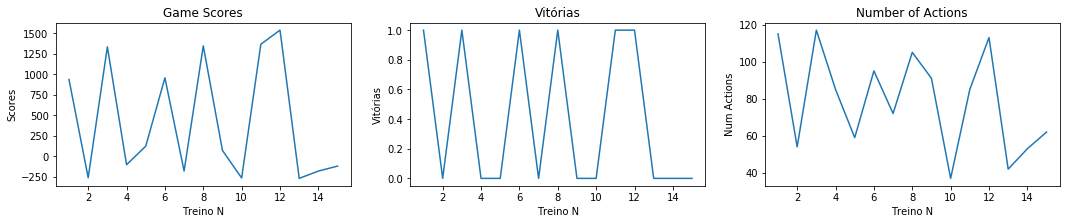

Wins:  6  Loss:  9
Avg Score:  417.6666666666667
Avg NumActions:  79.0


In [32]:
printGraphs(gamesScores,results,numActions)

In [33]:
layoutType='mediumClassic'

gamesScores, results, numActions = approxQLearning(pacman, layoutType,10, pacman.n_train)

layout:  mediumClassic
------------------------------------------ train --------------------
Action Score:  [2.4760898888118943, 2.4738532052314683]
-- epsilon:  0.09
W:  [[1.49908782 1.09285956 1.90089773 0.82417473 0.72884571]]   -  ACTION:  East
Action Score:  [2.527861177689527, 2.496835643963795]
-- epsilon:  0.09
W:  [[1.49974654 1.09285024 1.90247361 0.82418775 0.72884571]]   -  ACTION:  East
Action Score:  [2.530020306355925, 0.6227413236914552]
-- epsilon:  0.09
W:  [[1.49923543 1.09285873 1.90125087 0.82417553 0.72884571]]   -  ACTION:  East
Action Score:  [2.5305169905501663, 0.6234733480314288]
-- epsilon:  0.09
W:  [[1.4987186  1.09286732 1.90001443 0.82416026 0.72884571]]   -  ACTION:  East
Action Score:  [2.5284276358318323, 0.6225302765826115]
-- epsilon:  0.09
W:  [[1.49819382 1.09287987 1.89875897 0.82414065 0.72884571]]   -  ACTION:  North
Action Score:  [2.524746938358627, 0.6207585147117082]
-- epsilon:  0.09
W:  [[1.49766495 1.09289964 1.89749373 0.82411482 0.7288

Action Score:  [2.744484602905404, 0.43862716514706296]
-- epsilon:  0.09
W:  [[1.51160356 1.09249341 1.901134   0.81821543 0.73445726]]   -  ACTION:  North
Action Score:  [0.5016385844539878, 1.948744459296583]
-- epsilon:  0.09
W:  [[1.5114635  1.09249341 1.89335309 0.81821543 0.73424112]]   -  ACTION:  East
Action Score:  [1.949929075944678, 0.4907109317497129]
-- epsilon:  0.09
W:  [[1.51143531 1.09249341 1.89178662 0.81821543 0.73417846]]   -  ACTION:  East
Action Score:  [1.9483595957358928, 0.49031763104246623]
-- epsilon:  0.09
W:  [[1.51140674 1.09249341 1.89019938 0.81821543 0.73411498]]   -  ACTION:  East
Action Score:  [1.9632868852992822, 0.489919113699759]
-- epsilon:  0.09
W:  [[1.51138033 1.09249341 1.88873217 0.81821543 0.73402327]]   -  ACTION:  South
Action Score:  [0.4895498164797765, 1.9618134674374061]
-- epsilon:  0.09
W:  [[1.51135446 1.09249341 1.88729493 0.81821543 0.73393345]]   -  ACTION:  South
Action Score:  [0.49815836117099743, 1.996047469781783, 1.96037

Action Score:  [0.6235495579545147, 2.558761798854461]
-- epsilon:  0.09
W:  [[1.53022196 1.09332862 1.92626259 0.81821543 0.73798802]]   -  ACTION:  East
Action Score:  [2.5603171603693378, 0.6239348393366841]
-- epsilon:  0.09
W:  [[1.5296987  1.093335   1.92501078 0.81821543 0.73798802]]   -  ACTION:  East
Action Score:  [2.558846595550958, 0.6235705630958387]
-- epsilon:  0.09
W:  [[1.52916582 1.09334151 1.92373594 0.81821543 0.73798802]]   -  ACTION:  East
Action Score:  [2.5573489751130047, 0.6231995848590874]
-- epsilon:  0.09
W:  [[1.52863334 1.09334801 1.92246208 0.81821543 0.73798802]]   -  ACTION:  East
Action Score:  [2.555852507870057, 0.6228288922823331]
-- epsilon:  0.09
W:  [[1.52810137 1.0933545  1.92118942 0.81821543 0.73798802]]   -  ACTION:  East
Action Score:  [2.5543574578447874, 0.6224585507671043]
-- epsilon:  0.09
W:  [[1.52756991 1.09336099 1.91991798 0.81821543 0.73798802]]   -  ACTION:  East
Action Score:  [2.552863826186581, 0.6220885605981168]
-- epsilon: 

Action Score:  [2.637339421634124, 0.6485380105730341]
-- epsilon:  0.07500000000000001
W:  [[1.56291752 1.09588645 1.9833127  0.81811724 0.73798802]]   -  ACTION:  East
Action Score:  [2.638436444128753, 0.6495649426619253]
-- epsilon:  0.07500000000000001
W:  [[1.56138501 1.09599504 1.97940324 0.81796087 0.73798802]]   -  ACTION:  West
Action Score:  [2.601874947667298, 0.28535474329153865]
-- epsilon:  0.07500000000000001
W:  [[1.56690787 1.09588036 1.99327978 0.81813218 0.73798802]]   -  ACTION:  East
Action Score:  [2.6475011956808165, 0.6510013750185093]
-- epsilon:  0.07500000000000001
W:  [[1.56650284 1.09589232 1.99231079 0.81811704 0.73798802]]   -  ACTION:  North
Action Score:  [2.650275701845636, 0.6526382232296959]
-- epsilon:  0.07500000000000001
W:  [[1.56595357 1.09590855 1.99099676 0.81809022 0.73798802]]   -  ACTION:  North
Action Score:  [2.6448182790481027, 0.6530362146601483, 2.6573309974177506, 2.6412244431503193]
-- epsilon:  0.07500000000000001
W:  [[1.56648635 

Action Score:  [2.146910459362095, 0.5265212370236129]
-- epsilon:  0.07500000000000001
W:  [[1.57019525 1.09586434 1.93364543 0.81392323 0.73605695]]   -  ACTION:  South
Action Score:  [0.5262745273751156, 2.1459231860358106]
-- epsilon:  0.07500000000000001
W:  [[1.5701668  1.09586434 1.9320648  0.81392323 0.73566179]]   -  ACTION:  South
Action Score:  [0.5616160648247186, 1.2155376589647238, 2.042067998293729]
-- epsilon:  0.07500000000000001
W:  [[1.57012503 1.09586434 1.9297443  0.81392323 0.73540396]]   -  ACTION:  West
Action Score:  [1.9874227097061714, 0.5610073762898902]
-- epsilon:  0.07500000000000001
W:  [[1.57008826 1.09586434 1.9277012  0.81392323 0.73532224]]   -  ACTION:  South
Action Score:  [0.2570064855216993, 1.9449866414215444]
-- epsilon:  0.07500000000000001
W:  [[1.57009208 1.09586434 1.92578972 0.81392323 0.73526914]]   -  ACTION:  South
Action Score:  [0.49873138921675775, 1.9655399601087444, 0.49873138921675775, 0.48979582675265393]
-- epsilon:  0.075000000

Action Score:  [0.010963167851397285, -0.00831011400289815]
-- epsilon:  0.07500000000000001
W:  [[1.57297427 1.09727747 1.90239582 0.81392323 0.7344257 ]]   -  ACTION:  East
Action Score:  [0.025437300588789, 0.005024946218963124]
-- epsilon:  0.07500000000000001
W:  [[1.57297474 1.09727636 1.90239756 0.81392323 0.7344257 ]]   -  ACTION:  East
Action Score:  [0.040899125954384156, 0.01713545307331739]
-- epsilon:  0.07500000000000001
W:  [[1.57297545 1.09727556 1.9023999  0.81392323 0.7344257 ]]   -  ACTION:  East
Action Score:  [0.0615776509456691, 0.02879017485127471]
-- epsilon:  0.07500000000000001
W:  [[1.57297682 1.0972748  1.90240407 0.81392323 0.7344257 ]]   -  ACTION:  East
Action Score:  [0.09324106126795056, 0.04202649597580362]
-- epsilon:  0.07500000000000001
W:  [[1.57298001 1.09727378 1.90241319 0.81392323 0.7344257 ]]   -  ACTION:  East
Action Score:  [0.14858662020916563, 0.0606836621501018]
-- epsilon:  0.07500000000000001
W:  [[1.57298913 1.09727144 1.90243799 0.813

Action Score:  [-0.04065937733144426, -0.025743305107310425]
-- epsilon:  0.07500000000000001
W:  [[1.58360813 1.09746002 1.92903308 0.81392323 0.7344257 ]]   -  ACTION:  South
Action Score:  [-0.039967344753045295, -0.06289176752778168]
-- epsilon:  0.07500000000000001
W:  [[1.5836082  1.09746349 1.92903284 0.81392323 0.7344257 ]]   -  ACTION:  North
Action Score:  [-0.1187014140905923, -0.06384980773470228]
-- epsilon:  0.07500000000000001
W:  [[1.58360831 1.09747262 1.92903239 0.81392323 0.7344257 ]]   -  ACTION:  South
Action Score:  [-0.11801034854543185, -0.2686686744865388]
-- epsilon:  0.07500000000000001
W:  [[1.58360862 1.09751082 1.92903143 0.81392323 0.7344257 ]]   -  ACTION:  North
Action Score:  [-1.7292989109083177, -0.11720399122142901]
-- epsilon:  0.07500000000000001
W:  [[1.58360855 1.09750037 1.92903173 0.81392323 0.7344257 ]]   -  ACTION:  South
Action Score:  [-1.7287674278465697, -0.1162450065585418]
-- epsilon:  0.07500000000000001
W:  [[1.58360849 1.09748973 1.

Action Score:  [1.9663195961745565, 0.48367955792142375]
-- epsilon:  0.06
W:  [[1.60215538 1.09720575 1.9321708  0.81024093 0.73436428]]   -  ACTION:  North
Action Score:  [1.965113436546488, 0.4832059468441878]
-- epsilon:  0.06
W:  [[1.60212662 1.09720575 1.93057306 0.8102373  0.73435935]]   -  ACTION:  North
Action Score:  [1.9629212838079737, 0.4829489546794461, 1.9637034758784488]
-- epsilon:  0.06
W:  [[1.60210074 1.09720575 1.92913482 0.81023371 0.73435491]]   -  ACTION:  West
Action Score:  [1.93003441037985, 1.9630856215320043]
-- epsilon:  0.06
W:  [[1.60207497 1.09720575 1.92770341 0.81022974 0.73434932]]   -  ACTION:  West
Action Score:  [1.9623052416832147, 1.9618301069581552, 0.48328827760740056, 1.9623052416832147]
-- epsilon:  0.06
W:  [[1.60204919 1.09720575 1.92627132 0.81022532 0.73434295]]   -  ACTION:  North
Action Score:  [1.9622569790293631, 1.9285753606930653]
-- epsilon:  0.06
W:  [[1.60202064 1.09720575 1.92468513 0.81021983 0.73433357]]   -  ACTION:  North
A

Action Score:  [1.9540359754651768, 0.4801347318668333]
-- epsilon:  0.06
W:  [[1.61698081 1.09609456 1.91902558 0.8063803  0.72046043]]   -  ACTION:  East
Action Score:  [1.9540854525987401, 0.4807855127311218]
-- epsilon:  0.06
W:  [[1.61695239 1.09609456 1.91744671 0.8063803  0.72044738]]   -  ACTION:  East
Action Score:  [1.9537563238783973, 0.4811308787792852]
-- epsilon:  0.06
W:  [[1.61692392 1.09609456 1.91586507 0.8063803  0.72043156]]   -  ACTION:  South
Action Score:  [0.4829367350214007, 1.956226442710629]
-- epsilon:  0.06
W:  [[1.6168987  1.09609456 1.91446385 0.8063803  0.72040967]]   -  ACTION:  South
Action Score:  [0.4842761113119065, 1.9582702634761182, 1.9524619718735818]
-- epsilon:  0.06
W:  [[1.61687339 1.09609456 1.91305758 0.8063803  0.72038097]]   -  ACTION:  East
Action Score:  [1.9298344188163696, 1.9210797889905056]
-- epsilon:  0.06
W:  [[1.61687696 1.09609456 1.91127023 0.8063803  0.72033132]]   -  ACTION:  East
Action Score:  [1.9603832174626146, 0.51960

Action Score:  [-0.012494048614561543, -0.012494048614561543]
-- epsilon:  0.06
W:  [[1.61382119 1.09648435 1.90310469 0.8063803  0.72286881]]   -  ACTION:  North
Action Score:  [-0.011541410400139389, -0.013300284614832219]
-- epsilon:  0.06
W:  [[1.61382118 1.09648419 1.90310472 0.8063803  0.72286881]]   -  ACTION:  North
Action Score:  [-0.012494056054488212, -0.01040460947119121]
-- epsilon:  0.06
W:  [[1.61382118 1.09648398 1.90310478 0.8063803  0.72286881]]   -  ACTION:  West
Action Score:  [-0.005373681949878941, -0.009032945602608844]
-- epsilon:  0.06
W:  [[1.61382115 1.09648355 1.90310493 0.8063803  0.72286881]]   -  ACTION:  East
Action Score:  [-0.006326325362591222, -0.004236878624032038]
-- epsilon:  0.06
W:  [[1.61382115 1.09648346 1.90310496 0.8063803  0.72286881]]   -  ACTION:  West
Action Score:  [-0.005373676122481349, -0.00286521723924639]
-- epsilon:  0.06
W:  [[1.61382114 1.09648334 1.90310501 0.8063803  0.72286881]]   -  ACTION:  West
Action Score:  [-0.004236876

Pacman emerges victorious! Score: 1903
Average Score: 1903.0
Scores:        1903.0
Win Rate:      1/1 (1.00)
Record:        Win
------------------------------------------ train --------------------
Action Score:  [2.655005193408638, 2.6528018571561867]
-- epsilon:  0.044999999999999984
W:  [[1.64426105 1.09138741 1.95323171 0.80629918 0.72286881]]   -  ACTION:  East
Action Score:  [2.640738549262608, 2.6068503102089045]
-- epsilon:  0.044999999999999984
W:  [[1.6446612  1.09138174 1.95418899 0.80630709 0.72286881]]   -  ACTION:  East
Action Score:  [2.642141399462587, 0.6497551249434409]
-- epsilon:  0.044999999999999984
W:  [[1.64411007 1.0913909  1.9528705  0.80629391 0.72286881]]   -  ACTION:  East
Action Score:  [2.639148842982927, 0.6484248936649402]
-- epsilon:  0.044999999999999984
W:  [[1.64354524 1.09140441 1.95151924 0.80627722 0.72286881]]   -  ACTION:  East
Action Score:  [2.6340660369253537, 0.6460959713811505]
-- epsilon:  0.044999999999999984
W:  [[1.64297512 1.09142572 

Action Score:  [0.6075022495795831, 2.000633859280579]
-- epsilon:  0.044999999999999984
W:  [[1.65113616 1.09095443 1.93632456 0.80249746 0.72544843]]   -  ACTION:  West
Action Score:  [0.6370254738375701, 2.00497032388387]
-- epsilon:  0.044999999999999984
W:  [[1.6511105  1.09095443 1.93489928 0.80247986 0.72539142]]   -  ACTION:  West
Action Score:  [0.5085971580298878, 2.022494975783614]
-- epsilon:  0.044999999999999984
W:  [[1.65108649 1.09095443 1.93356548 0.80245902 0.72530805]]   -  ACTION:  West
Action Score:  [2.4126894907592247, 0.6070675408998389]
-- epsilon:  0.044999999999999984
W:  [[1.65191221 1.09046058 1.93554088 0.80249933 0.72543152]]   -  ACTION:  North
Action Score:  [-1.334967223983531, 0.4147137849016098]
-- epsilon:  0.044999999999999984
W:  [[1.65039012 1.09434347 1.93165799 0.80225665 0.72481025]]   -  ACTION:  South
Action Score:  [-1.4311674351866357, 0.03578913756105989]
-- epsilon:  0.044999999999999984
W:  [[1.65027465 1.09502359 1.93135571 0.80222307 

Action Score:  [0.4979472214322575, 2.0190737336122573]
-- epsilon:  0.02999999999999997
W:  [[1.7375271  1.1411237  1.97722288 0.79890055 0.72376771]]   -  ACTION:  West
Action Score:  [2.018030590438765, 2.020198135615031, 0.49957657945092854]
-- epsilon:  0.02999999999999997
W:  [[1.73749789 1.1411237  1.97559972 0.79889494 0.72374768]]   -  ACTION:  South
Action Score:  [1.9824828831264059, 1.9858990055706514]
-- epsilon:  0.02999999999999997
W:  [[1.73750164 1.1411237  1.97372061 0.79888914 0.72371831]]   -  ACTION:  South
Action Score:  [0.5040275692863069, 0.5034762363127852, 0.5034762363127852, 2.027863244950861]
-- epsilon:  0.02999999999999997
W:  [[1.73748108 1.1411237  1.97257803 0.79888518 0.72368658]]   -  ACTION:  West
Action Score:  [0.5034428430764644, 2.0270757394313432]
-- epsilon:  0.02999999999999997
W:  [[1.73745437 1.1411237  1.97109407 0.79887939 0.72364536]]   -  ACTION:  West
Action Score:  [0.5068311696652245, 2.034864637108056]
-- epsilon:  0.029999999999999

Action Score:  [0.6492629529439655, 2.661001454630996]
-- epsilon:  0.02999999999999997
W:  [[1.74058653 1.1412349  1.95187107 0.79453297 0.72201931]]   -  ACTION:  South
Action Score:  [0.6381258292331742, 2.0032577161857734, 2.6590168203404883, 2.619390608426814]
-- epsilon:  0.02999999999999997
W:  [[1.74108851 1.14120154 1.95307198 0.79453297 0.72203807]]   -  ACTION:  East
Action Score:  [0.23358243344967372, 2.594756721652873]
-- epsilon:  0.02999999999999997
W:  [[1.74132497 1.14116441 1.95366609 0.79453297 0.72205458]]   -  ACTION:  West
Action Score:  [0.6421031659813543, 2.0138921224953927, 0.6421031659813543, 2.6249529602344803]
-- epsilon:  0.02999999999999997
W:  [[1.74194596 1.14107156 1.9551517  0.79453297 0.72208489]]   -  ACTION:  West
Action Score:  [2.591865641843633, 2.4069318450137334]
-- epsilon:  0.02999999999999997
W:  [[1.74234627 1.1410087  1.95615751 0.79453297 0.72210542]]   -  ACTION:  East
Action Score:  [0.5997591644102642, 2.6332036867493707, 0.608534751

Action Score:  [2.0171169613083535, 0.49999578678602863]
-- epsilon:  0.015000000000000013
W:  [[1.79740869 1.18079821 1.96093706 0.79040178 0.74137428]]   -  ACTION:  North
Action Score:  [2.041418599905783, 0.5087273200544623]
-- epsilon:  0.015000000000000013
W:  [[1.7973825  1.18079821 1.95948233 0.79039848 0.74128336]]   -  ACTION:  North
Action Score:  [2.178789114721681, 0.5342390834394553, 2.040141426214951]
-- epsilon:  0.015000000000000013
W:  [[1.7973735  1.18079821 1.95898227 0.79039745 0.74115834]]   -  ACTION:  North
Action Score:  [2.7339874690655126, 2.039530732255643]
-- epsilon:  0.015000000000000013
W:  [[1.79741379 1.18079821 1.96122066 0.79040168 0.74339674]]   -  ACTION:  North
Action Score:  [3.427113728337933, 0.6741925849011624]
-- epsilon:  0.015000000000000013
W:  [[1.79969382 1.18078399 1.96400798 0.79040744 0.74339674]]   -  ACTION:  North
Action Score:  [2.7098724189869046, 0.6628417361749761]
-- epsilon:  0.015000000000000013
W:  [[1.7967169  1.18083345 1

Action Score:  [0.5039722011177546, 2.051126096242599]
-- epsilon:  0.015000000000000013
W:  [[1.82702181 1.18011652 2.01376909 0.78845333 0.74330215]]   -  ACTION:  South
Action Score:  [0.503091794322244, 2.0499590491642694]
-- epsilon:  0.015000000000000013
W:  [[1.82699472 1.18011652 2.01226379 0.78845333 0.74329546]]   -  ACTION:  South
Action Score:  [0.501983914107742, 2.048453228095547]
-- epsilon:  0.015000000000000013
W:  [[1.8269676  1.18011652 2.01075698 0.78845333 0.74328876]]   -  ACTION:  South
Action Score:  [0.5019387811860778, 2.0465458670922687, 2.047434684966924]
-- epsilon:  0.015000000000000013
W:  [[1.82694056 1.18011652 2.00925488 0.78845333 0.7432811 ]]   -  ACTION:  East
Action Score:  [2.0459320630939937, 2.0085044432000423]
-- epsilon:  0.015000000000000013
W:  [[1.82691059 1.18011652 2.00759012 0.78845333 0.7432726 ]]   -  ACTION:  East
Action Score:  [2.045636121890919, 2.0442667137489074, 2.045636121890919, 0.5020359149521408]
-- epsilon:  0.0150000000000

Action Score:  [2.759314646565676, 0.6657694339471747, 2.759314646565676]
-- epsilon:  0.015000000000000013
W:  [[1.83580857 1.17996179 2.00304635 0.78845333 0.74229516]]   -  ACTION:  South
Action Score:  [2.71913073133162, 2.7606625819833734]
-- epsilon:  0.015000000000000013
W:  [[1.83628771 1.17995232 2.0041926  0.78845333 0.74229516]]   -  ACTION:  South
Action Score:  [0.6664370332730406, 2.7620091916739433]
-- epsilon:  0.015000000000000013
W:  [[1.83676639 1.17994285 2.00533777 0.78845333 0.74229516]]   -  ACTION:  West
Action Score:  [0.666770352056322, 2.763354523315522]
-- epsilon:  0.015000000000000013
W:  [[1.83724461 1.1799334  2.00648185 0.78845333 0.74229516]]   -  ACTION:  West
Action Score:  [0.6671033545993578, 2.7646985785573603]
-- epsilon:  0.015000000000000013
W:  [[1.83772238 1.17992395 2.00762484 0.78845333 0.74229516]]   -  ACTION:  West
Action Score:  [2.7612258338664217, 0.6722515659513416]
-- epsilon:  0.015000000000000013
W:  [[1.83711513 1.17994189 2.0061

Action Score:  [0.5912696964365824, 2.785584041346635]
-- epsilon:  0.0
W:  [[1.87054959 1.17721965 2.00385004 0.78347491 0.74658088]]   -  ACTION:  East
Action Score:  [3.5220405453248933, 0.6935391602031946]
-- epsilon:  0.0
W:  [[1.87305105 1.17717187 2.00690806 0.78350019 0.74658088]]   -  ACTION:  East
Action Score:  [2.7768910603758754, 0.6785880333555454]
-- epsilon:  0.0
W:  [[1.86995839 1.17728747 1.99950935 0.78344881 0.74658088]]   -  ACTION:  East
Action Score:  [2.7673926315757735, 0.6750736299086157]
-- epsilon:  0.0
W:  [[1.86932892 1.177311   1.99800345 0.7834399  0.74658088]]   -  ACTION:  East
Action Score:  [2.7593533250833904, 0.6736009475904784]
-- epsilon:  0.0
W:  [[1.86870702 1.17734137 1.99651565 0.78343231 0.74658088]]   -  ACTION:  East
Action Score:  [2.734023453676282, 0.6628705204009588]
-- epsilon:  0.0
W:  [[1.86803577 1.1774056  1.99490979 0.78342517 0.74658088]]   -  ACTION:  East
Action Score:  [2.647986157490995, 0.6386957975039362]
-- epsilon:  0.0


Action Score:  [-0.21954925473452908, -3.6877858206295553]
-- epsilon:  0.0
W:  [[1.87541531 1.19476845 2.01251537 0.78256999 0.74658088]]   -  ACTION:  East
Action Score:  [-0.24143109592755374, -3.7371325711451138]
-- epsilon:  0.0
W:  [[1.87534629 1.19756793 2.01228685 0.78250373 0.74658088]]   -  ACTION:  East
Action Score:  [-0.24277428019164085, -3.765472513663858]
-- epsilon:  0.0
W:  [[1.87527829 1.20032606 2.01206169 0.78244744 0.74658088]]   -  ACTION:  East
Action Score:  [-0.2236274986023475, -3.783773874719536]
-- epsilon:  0.0
W:  [[1.87517913 1.20304704 2.01175936 0.78239907 0.74658088]]   -  ACTION:  East
Action Score:  [-0.19098263086648343, -3.7870000313912104]
-- epsilon:  0.0
W:  [[1.8750279  1.20574755 2.01132728 0.78235687 0.74658088]]   -  ACTION:  East
Action Score:  [-0.12912614961328284, -3.7751893240156127]
-- epsilon:  0.0
W:  [[1.87478369 1.20840201 2.01066366 0.78230968 0.74658088]]   -  ACTION:  South
Action Score:  [-3.7533663028305164, 0.004872098465084

Action Score:  [2.105226382983696, 0.5204552932391462]
-- epsilon:  0.0
W:  [[1.89686654 1.20594526 2.04863439 0.7773788  0.74627907]]   -  ACTION:  East
Action Score:  [2.129420432314553, 0.5290948392719097]
-- epsilon:  0.0
W:  [[1.89683907 1.20594526 2.04710841 0.7773788  0.7461837 ]]   -  ACTION:  East
Action Score:  [2.1641608115849422, 0.5378307718828031]
-- epsilon:  0.0
W:  [[1.89681262 1.20594526 2.045639   0.7773788  0.74602043]]   -  ACTION:  South
Action Score:  [0.5905072842240926, 2.825802058298432]
-- epsilon:  0.0
W:  [[1.8968698  1.20594526 2.04881549 0.7773788  0.74919692]]   -  ACTION:  South
Action Score:  [0.6957093623506219, 3.5842044680042684, 2.2702583769799842]
-- epsilon:  0.0
W:  [[1.89960507 1.20589301 2.05215935 0.7773788  0.74920849]]   -  ACTION:  East
Action Score:  [0.2784781745022999, 2.7919525042464173]
-- epsilon:  0.0
W:  [[1.89746082 1.20597719 2.04677177 0.7773788  0.74918984]]   -  ACTION:  West
Action Score:  [0.6811130229691218, 0.6670712586104

Action Score:  [0.5218293764620471, 2.101155480893772]
-- epsilon:  0
W:  [[1.93235177 1.20303728 2.01815426 0.77126207 0.7487905 ]]   -  ACTION:  South
Action Score:  [0.5306254810278282, 2.0828882105750144, 2.1361355347785684]
-- epsilon:  0
W:  [[1.93232864 1.20303728 2.01686919 0.77126207 0.74864771]]   -  ACTION:  East
Action Score:  [2.8002988176312478, 2.0961876125786603]
-- epsilon:  0
W:  [[1.93238367 1.20303728 2.01992626 0.77126207 0.75170478]]   -  ACTION:  East
Action Score:  [2.806413942538456, 2.13823191721559, 2.13823191721559, 0.5846395503397087]
-- epsilon:  0
W:  [[1.93234385 1.20303728 2.01771405 0.77126207 0.74949257]]   -  ACTION:  North
Action Score:  [2.8066363186950536, 2.7747565264415925]
-- epsilon:  0
W:  [[1.93273696 1.20302259 2.01865452 0.77126207 0.74949257]]   -  ACTION:  North
Action Score:  [0.6752746240474868, 0.27291159909538704]
-- epsilon:  0
W:  [[1.93104631 1.20329214 2.01434163 0.77126207 0.74949257]]   -  ACTION:  South
Action Score:  [0.28697

Action Score:  [0.4031611467744508, 2.791084127872888]
-- epsilon:  0
W:  [[1.94674447 1.20295536 2.05385174 0.77126207 0.74949257]]   -  ACTION:  West
Action Score:  [0.40350505363901634, 2.7924062204259785]
-- epsilon:  0
W:  [[1.94721291 1.20288532 2.05497239 0.77126207 0.74949257]]   -  ACTION:  West
Action Score:  [2.568186057226739, 0.4038486331427151]
-- epsilon:  0
W:  [[1.94593203 1.2036514  2.05190808 0.77126207 0.74949257]]   -  ACTION:  South
Action Score:  [0.009670941516334824, -1.8799400143133007]
-- epsilon:  0
W:  [[1.94458688 1.21157436 2.04838676 0.77126207 0.74949257]]   -  ACTION:  North
Action Score:  [0.3997726152917949, -3.8098609966974397]
-- epsilon:  0
W:  [[1.94376221 1.21367811 2.04628301 0.77126207 0.74949257]]   -  ACTION:  South
Action Score:  [-3.71146795342948, 2.516480845187713]
-- epsilon:  0
W:  [[1.9509678  1.20915199 2.06438749 0.77126207 0.74949257]]   -  ACTION:  South
Action Score:  [-3.4283119669021636, 2.5776040345608138, 0.40500371954560804,

Action Score:  [0.7018544909260314, 3.143264493069551]
-- epsilon:  0
W:  [[2.07160619 1.26896718 2.12308091 0.76637674 0.76036436]]   -  ACTION:  West
Action Score:  [0.7396301565042399, 3.7201399462453533]
-- epsilon:  0
W:  [[2.07368904 1.26882876 2.1280638  0.77135963 0.76036436]]   -  ACTION:  West
Action Score:  [0.4820627763632566, 2.9071567435794434]
-- epsilon:  0
W:  [[2.07370673 1.26882876 2.11921821 0.76251404 0.76022615]]   -  ACTION:  West
Action Score:  [2.1684234644552767, 0.5375356725104495]
-- epsilon:  0
W:  [[2.07356884 1.26882876 2.1115576  0.76251404 0.76010645]]   -  ACTION:  South
Action Score:  [0.5331262937390584, 2.1643942204032527]
-- epsilon:  0
W:  [[2.07353969 1.26882876 2.10993786 0.76251404 0.76007339]]   -  ACTION:  South
Action Score:  [0.5327210066177415, 2.162773271661267]
-- epsilon:  0
W:  [[2.0735109  1.26882876 2.10833867 0.76251404 0.76004076]]   -  ACTION:  South
Action Score:  [0.5348132823275944, 2.1667741086699874]
-- epsilon:  0
W:  [[2.07

Action Score:  [0.09450478697961831, 0.28973206866793066]
-- epsilon:  0
W:  [[2.08821948 1.26720143 2.12382875 0.76251404 0.75832984]]   -  ACTION:  South
Action Score:  [0.1609683223661491, 0.1609683223661491, 0.7004026561410845]
-- epsilon:  0
W:  [[2.08856337 1.26710396 2.12470601 0.76251404 0.75832984]]   -  ACTION:  West
Action Score:  [0.29886709263786043, 2.9052700696815785]
-- epsilon:  0
W:  [[2.09592586 1.26636401 2.14320473 0.76251404 0.75832984]]   -  ACTION:  West
Action Score:  [0.7060251388933182, 2.9934575768353264, 0.7153577534882292, 2.968647179881471]
-- epsilon:  0
W:  [[2.09661754 1.26633024 2.14485946 0.76251404 0.75832984]]   -  ACTION:  South
Action Score:  [2.9286600356149575, 0.3014640106486913]
-- epsilon:  0
W:  [[2.09561388 1.26643111 2.14233771 0.76251404 0.75832984]]   -  ACTION:  North
Action Score:  [0.6902973439085023, 0.6902973439085023, 0.6902973439085023, 2.877589746468401]
-- epsilon:  0
W:  [[2.09587863 1.26636074 2.14297108 0.76251404 0.75832984

Action Score:  [3.075909943298579, 0.753457233162409]
-- epsilon:  0
W:  [[2.12727215 1.26813453 2.18797123 0.76237843 0.75832984]]   -  ACTION:  East
Action Score:  [3.069268550626577, 0.7504079174459924]
-- epsilon:  0
W:  [[2.12655129 1.26816148 2.18624668 0.76235149 0.75832984]]   -  ACTION:  North
Action Score:  [3.0554766099975756, 0.7445604212925436]
-- epsilon:  0
W:  [[2.12581113 1.26821067 2.18447597 0.76231535 0.75832984]]   -  ACTION:  North
Action Score:  [3.005713031351176, 0.7311315861024582, 3.0590123729384007, 3.049748123898083]
-- epsilon:  0
W:  [[2.12619781 1.26818497 2.18540104 0.76234105 0.75832984]]   -  ACTION:  East
Action Score:  [3.0694180114205305, 2.9679241935592415]
-- epsilon:  0
W:  [[2.12653711 1.26816242 2.18621276 0.76237351 0.75832984]]   -  ACTION:  East
Action Score:  [3.102938572686633, 3.06105557400479, 0.7409041334149776]
-- epsilon:  0
W:  [[2.12593929 1.26818477 2.18478257 0.76228413 0.75832984]]   -  ACTION:  South
Action Score:  [3.026170416

Action Score:  [2.242769948884684, 2.2164787083796287, 0.5559841975336729]
-- epsilon:  0
W:  [[2.14000407 1.26775506 2.1552376  0.75232857 0.75708226]]   -  ACTION:  North
Action Score:  [2.1982752347304335, 2.1719876563224187]
-- epsilon:  0
W:  [[2.14000833 1.26775506 2.15310702 0.75232857 0.7569491 ]]   -  ACTION:  North
Action Score:  [0.5642747031840779, 0.5642747031840779, 2.27573262893675, 0.5642747031840779]
-- epsilon:  0
W:  [[2.13998642 1.26775506 2.1518901  0.75232857 0.75681388]]   -  ACTION:  East
Action Score:  [2.379613323208769, 0.5809934190577]
-- epsilon:  0
W:  [[2.13996683 1.26775506 2.15080145 0.75232857 0.75654172]]   -  ACTION:  East
Action Score:  [2.3784562850643396, 0.5807042868930699]
-- epsilon:  0
W:  [[2.13993212 1.26775506 2.14887343 0.75232857 0.75605972]]   -  ACTION:  East
Action Score:  [1.2889982096825034, 3.7637266473138116, 0.6169451285117314]
-- epsilon:  0
W:  [[2.14652126 1.26686004 2.15692861 0.75232857 0.75611566]]   -  ACTION:  East
Action 

Action Score:  [0.03596868211004669, 0.03298161348774281]
-- epsilon:  0
W:  [[2.1669223  1.27269794 2.19409679 0.75232857 0.75562915]]   -  ACTION:  North
Action Score:  [0.050602045405617524, 0.02592386384820771]
-- epsilon:  0
W:  [[2.16692292 1.27269735 2.19409883 0.75232857 0.75562915]]   -  ACTION:  North
Action Score:  [0.07315951160165224, 0.037835783926834565]
-- epsilon:  0
W:  [[2.16692434 1.27269643 2.19410316 0.75232857 0.75562915]]   -  ACTION:  North
Action Score:  [0.0524765165378817, 0.0524765165378817, 0.1105703190459016]
-- epsilon:  0
W:  [[2.16692886 1.27269452 2.19411607 0.75232857 0.75562915]]   -  ACTION:  East
Action Score:  [0.17944088152387844, 0.07503437821808932]
-- epsilon:  0
W:  [[2.16693991 1.27269168 2.19414609 0.75232857 0.75562915]]   -  ACTION:  East
Action Score:  [0.11244659490418096, 0.11057228237732218, 0.32823785066753364, 0.11244659490418096]
-- epsilon:  0
W:  [[2.16698404 1.27268552 2.19426162 0.75232857 0.75562915]]   -  ACTION:  East
Actio

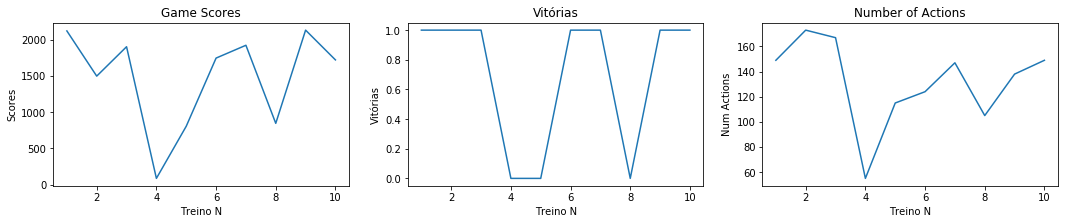

Wins:  7  Loss:  3
Avg Score:  1477.8
Avg NumActions:  132.2


In [34]:
printGraphs(gamesScores,results,numActions)

In [35]:
layoutType='originalClassic'

gamesScores, results, numActions = approxQLearning(pacman, layoutType,10,pacman.n_train)

layout:  originalClassic
------------------------------------------ train --------------------
Action Score:  [3.1748854714936576, 3.174809958372072]
-- epsilon:  0
W:  [[2.19773852 1.2745341  2.23673447 0.75228785 0.75562915]]   -  ACTION:  East
Action Score:  [3.1553467076198305, 3.155957573106129, 3.1116247710469613]
-- epsilon:  0
W:  [[2.19795078 1.2745335  2.23724228 0.75228926 0.75562915]]   -  ACTION:  East
Action Score:  [3.1567920918657837, 3.1121590852952496]
-- epsilon:  0
W:  [[2.19822885 1.27453271 2.23790752 0.75229131 0.75562915]]   -  ACTION:  East
Action Score:  [3.1580440127659957, 0.7754717215645729]
-- epsilon:  0
W:  [[2.1975047  1.27453451 2.2361751  0.75228532 0.75562915]]   -  ACTION:  East
Action Score:  [3.1564260221072, 0.7753049557935716]
-- epsilon:  0
W:  [[2.19677149 1.27453623 2.23442102 0.75227847 0.75562915]]   -  ACTION:  East
Action Score:  [3.1548445915709764, 0.7751656407679409]
-- epsilon:  0
W:  [[2.19603894 1.27453784 2.23266849 0.75227068 0.75

Action Score:  [2.220538312345281, 0.5499513593015206]
-- epsilon:  0
W:  [[2.19218019 1.27453459 2.15317053 0.74738242 0.75456653]]   -  ACTION:  North
Action Score:  [2.2197666674436825, 0.550120754977293]
-- epsilon:  0
W:  [[2.19214782 1.27453459 2.15137254 0.74736756 0.75451659]]   -  ACTION:  North
Action Score:  [2.2284855418557004, 0.5540471900487702]
-- epsilon:  0
W:  [[2.1921167  1.27453459 2.1496435  0.74735027 0.75444743]]   -  ACTION:  North
Action Score:  [2.2137250379107356, 0.5545999774873231, 2.2285060486926587]
-- epsilon:  0
W:  [[2.1920872  1.27453459 2.14800486 0.74733004 0.75438188]]   -  ACTION:  East
Action Score:  [2.246288332791589, 2.1720490419564364]
-- epsilon:  0
W:  [[2.19205713 1.27453459 2.14633409 0.74730394 0.75427746]]   -  ACTION:  East
Action Score:  [2.2481845614427396, 0.5623775346563459]
-- epsilon:  0
W:  [[2.19202474 1.27453459 2.14453471 0.74726721 0.754165  ]]   -  ACTION:  East
Action Score:  [2.2885446920615773, 0.573592278923083]
-- epsi

Action Score:  [0.7377908114675787, 0.17219139436053216]
-- epsilon:  0
W:  [[2.18999786 1.29006797 2.10123596 0.7418427  0.75226378]]   -  ACTION:  North
Action Score:  [2.972550346336983, 0.3179706268537601]
-- epsilon:  0
W:  [[2.19630202 1.28993706 2.11707555 0.7420011  0.75232566]]   -  ACTION:  North
Action Score:  [0.7370355697777755, 0.7429168611470411, 3.036568436907595]
-- epsilon:  0
W:  [[2.19689846 1.28992527 2.11850244 0.74201872 0.75233123]]   -  ACTION:  West
Action Score:  [0.7390200651261667, 3.0410831935569846]
-- epsilon:  0
W:  [[2.19729441 1.28991744 2.11944969 0.74203352 0.75233544]]   -  ACTION:  West
Action Score:  [0.7417769891336864, 3.0468535106880204]
-- epsilon:  0
W:  [[2.19769263 1.28990957 2.12040237 0.74205296 0.75234108]]   -  ACTION:  West
Action Score:  [3.043810533714562, 3.045196649646116, 0.7449827135324668, 3.0528285384323954]
-- epsilon:  0
W:  [[2.19808954 1.28990172 2.12135191 0.74207934 0.75234592]]   -  ACTION:  West
Action Score:  [2.99541

Action Score:  [2.132118628927682, 0.522008901701944]
-- epsilon:  0
W:  [[2.20096304 1.28999375 2.0839537  0.73885609 0.7521941 ]]   -  ACTION:  East
Action Score:  [2.1334965271249935, 0.5233730832318683]
-- epsilon:  0
W:  [[2.20093223 1.28999375 2.08224192 0.73885461 0.75217297]]   -  ACTION:  East
Action Score:  [2.1342898760187707, 0.5242834924634598]
-- epsilon:  0
W:  [[2.20090132 1.28999375 2.08052484 0.73885303 0.75214614]]   -  ACTION:  East
Action Score:  [2.1326148808120617, 2.1416731557376187, 0.5281208363329891]
-- epsilon:  0
W:  [[2.20087126 1.28999375 2.07885457 0.73885158 0.75209974]]   -  ACTION:  East
Action Score:  [0.545999032570727, 2.090480264881037]
-- epsilon:  0
W:  [[2.20087545 1.28999375 2.07675664 0.73884966 0.75205693]]   -  ACTION:  West
Action Score:  [2.1324420293885633, 0.5455088289027328, 0.5307746523855582]
-- epsilon:  0
W:  [[2.2008505  1.28999375 2.07537038 0.7388483  0.75202864]]   -  ACTION:  North
Action Score:  [2.127504967535812, 0.53600904

Action Score:  [0.00286238621535736, 0.007366906492612135]
-- epsilon:  0
W:  [[2.21056602 1.29020765 2.07375709 0.73878745 0.75179487]]   -  ACTION:  East
Action Score:  [0.01049529923969134, 0.005464811012667769]
-- epsilon:  0
W:  [[2.21056602 1.29020761 2.07375718 0.73878747 0.75179487]]   -  ACTION:  East
Action Score:  [0.014057794218521068, 0.008123510957865232]
-- epsilon:  0
W:  [[2.21056604 1.29020758 2.0737573  0.73878748 0.75179487]]   -  ACTION:  East
Action Score:  [0.017929348235008708, 0.010495300696321494]
-- epsilon:  0
W:  [[2.21056606 1.29020754 2.07375746 0.7387875  0.75179487]]   -  ACTION:  East
Action Score:  [0.02303264351130234, 0.013497995610934793]
-- epsilon:  0
W:  [[2.21056612 1.29020748 2.07375775 0.73878752 0.75179487]]   -  ACTION:  East
Action Score:  [0.029383298133185992, 0.017929352278327475]
-- epsilon:  0
W:  [[2.21056623 1.29020738 2.07375821 0.73878754 0.75179487]]   -  ACTION:  East
Action Score:  [0.038354911853709255, 0.02247285099650945]
--

Action Score:  [0.16827503120829135, 0.10086604730244432, 0.10086604730244432, 0.3037925788528359]
-- epsilon:  0
W:  [[2.22354965 1.28962977 2.10668597 0.73875388 0.75179487]]   -  ACTION:  West
Action Score:  [0.15801689112762737, 0.6948410519567154]
-- epsilon:  0
W:  [[2.22387859 1.28949551 2.1075251  0.73876227 0.75179487]]   -  ACTION:  West
Action Score:  [0.2786561240733413, 2.8513979304561334]
-- epsilon:  0
W:  [[2.23110442 1.28747825 2.12568043 0.73881256 0.75179487]]   -  ACTION:  West
Action Score:  [3.0086299807337857, 0.7004162425499671, 0.6092954879998681]
-- epsilon:  0
W:  [[2.23095183 1.28749285 2.12531539 0.73881165 0.75179487]]   -  ACTION:  South
Action Score:  [0.7005089810291761, 3.0332531946946815]
-- epsilon:  0
W:  [[2.23141764 1.28747011 2.12642977 0.73881417 0.75179487]]   -  ACTION:  South
Action Score:  [0.7258585060533683, 3.0447941246513155]
-- epsilon:  0
W:  [[2.23183584 1.28745776 2.12743026 0.73881624 0.75179487]]   -  ACTION:  South
Action Score:  

Action Score:  [0.039798523385069506, -2.2044470501643465]
-- epsilon:  0
W:  [[2.24046581 1.29884858 2.14917004 0.73651516 0.75179487]]   -  ACTION:  East
Action Score:  [0.4526047679651547, -3.856656937229923]
-- epsilon:  0
W:  [[2.2396548  1.30091749 2.14710113 0.73628528 0.75179487]]   -  ACTION:  East
Action Score:  [2.72828059513133, -4.172895310009529]
-- epsilon:  0
W:  [[2.2415679  1.29971579 2.15190791 0.73638338 0.75179487]]   -  ACTION:  East
Action Score:  [2.7754603326673415, 0.4442276735442069, -3.883961911604418]
-- epsilon:  0
W:  [[2.23610926 1.30298052 2.13884898 0.73617933 0.75179487]]   -  ACTION:  South
Action Score:  [-3.888269399307774, 2.7568861540509033]
-- epsilon:  0
W:  [[2.23652304 1.30273305 2.13983888 0.73619155 0.75179487]]   -  ACTION:  South
Action Score:  [-3.8918756411325983, 2.7605252384688814]
-- epsilon:  0
W:  [[2.23700988 1.30244188 2.14100357 0.73620975 0.75179487]]   -  ACTION:  South
Action Score:  [-4.191751437227932, 2.7207477221116427]
-

Action Score:  [2.172808307983069, 0.5367184609469322]
-- epsilon:  0
W:  [[2.24389535 1.30362057 2.10685344 0.74777213 0.75153917]]   -  ACTION:  North
Action Score:  [2.180628552721651, 0.540150549717215]
-- epsilon:  0
W:  [[2.24386479 1.30362057 2.1051555  0.74776458 0.75147126]]   -  ACTION:  North
Action Score:  [2.164696336593436, 0.5400582481347064, 0.5400582481347064, 0.554780950276266]
-- epsilon:  0
W:  [[2.24383103 1.30362057 2.10328028 0.74775501 0.75143299]]   -  ACTION:  North
Action Score:  [2.1598349670249513, 0.5455289025848629]
-- epsilon:  0
W:  [[2.24379894 1.30362057 2.10149752 0.74774446 0.75140513]]   -  ACTION:  North
Action Score:  [2.154592625396224, 0.5364425108638513]
-- epsilon:  0
W:  [[2.24376687 1.30362057 2.09971591 0.74773209 0.75138731]]   -  ACTION:  North
Action Score:  [2.1524931307074335, 0.5341422807005419]
-- epsilon:  0
W:  [[2.24373529 1.30362057 2.09796112 0.74771759 0.75137281]]   -  ACTION:  North
Action Score:  [2.1520352236691602, 0.5314

Action Score:  [2.1176038828961756, 0.5255646299129317]
-- epsilon:  0
W:  [[2.25158782 1.30279191 2.05380106 0.746276   0.75309741]]   -  ACTION:  North
Action Score:  [2.117161740113284, 0.5234270615928552]
-- epsilon:  0
W:  [[2.25155698 1.30279191 2.0520878  0.74625887 0.75306245]]   -  ACTION:  North
Action Score:  [0.5264528648904687, 2.114151873575336, 2.1227472972804327]
-- epsilon:  0
W:  [[2.25152981 1.30279191 2.05057828 0.74624023 0.75302052]]   -  ACTION:  West
Action Score:  [2.0689053928669803, 2.12368306124314]
-- epsilon:  0
W:  [[2.25150195 1.30279191 2.04903082 0.74621605 0.75297753]]   -  ACTION:  West
Action Score:  [0.532334134355412, 2.13490585960562]
-- epsilon:  0
W:  [[2.25147542 1.30279191 2.04755668 0.74618597 0.75291856]]   -  ACTION:  West
Action Score:  [2.1298591377826566, 2.11510808019399, 0.5344110603532407, 2.1241763124212003]
-- epsilon:  0
W:  [[2.25144661 1.30279191 2.04595642 0.74616096 0.75285455]]   -  ACTION:  North
Action Score:  [2.1427477332

Action Score:  [2.034838920020015, 0.4986276933430576]
-- epsilon:  0
W:  [[2.25596821 1.3024045  1.98085919 0.73853589 0.75188382]]   -  ACTION:  North
Action Score:  [2.0368111841197343, 0.4999853770641715]
-- epsilon:  0
W:  [[2.25593887 1.3024045  1.97922952 0.73853589 0.75185057]]   -  ACTION:  North
Action Score:  [2.0407211553670512, 0.5020431667642649, 2.0315840825172393]
-- epsilon:  0
W:  [[2.25591264 1.3024045  1.97777222 0.73853589 0.75181009]]   -  ACTION:  North
Action Score:  [2.039262261590777, 1.985007427827388]
-- epsilon:  0
W:  [[2.25588278 1.3024045  1.97611314 0.73853589 0.751764  ]]   -  ACTION:  North
Action Score:  [2.001671934004396, 0.5048586417791114]
-- epsilon:  0
W:  [[2.25588662 1.3024045  1.97419508 0.73853589 0.75168728]]   -  ACTION:  North
Action Score:  [0.5043775533014947, 0.5043775533014947, 2.044868529585066, 0.5043775533014947]
-- epsilon:  0
W:  [[2.2558631  1.3024045  1.97288876 0.73853589 0.75163502]]   -  ACTION:  East
Action Score:  [2.0604

Action Score:  [-0.00337908030898998, -0.0010275302112369633]
-- epsilon:  0
W:  [[2.26238042 1.30251911 1.96338567 0.73853589 0.75132583]]   -  ACTION:  South
Action Score:  [-0.00038869023901193494, 0.0005161936612360744]
-- epsilon:  0
W:  [[2.26238042 1.30251905 1.96338572 0.73853589 0.75132583]]   -  ACTION:  South
Action Score:  [0.000890710464642337, 0.0024024028051411253, 0.000890710464642337]
-- epsilon:  0
W:  [[2.26238042 1.302519   1.96338577 0.73853589 0.75132583]]   -  ACTION:  East
Action Score:  [0.004740439992722269, 0.002434434452952116]
-- epsilon:  0
W:  [[2.26238042 1.30251892 1.96338585 0.73853589 0.75132583]]   -  ACTION:  East
Action Score:  [0.007687040617257203, 0.004320643814646337]
-- epsilon:  0
W:  [[2.26238044 1.30251881 1.96338597 0.73853589 0.75132583]]   -  ACTION:  East
Action Score:  [0.01147330113353103, 0.006658681678191626]
-- epsilon:  0
W:  [[2.26238047 1.30251867 1.96338617 0.73853589 0.75132583]]   -  ACTION:  North
Action Score:  [0.013394005

Action Score:  [0.1504599717726704, 0.024063060094710147]
-- epsilon:  0
W:  [[2.27524218 1.30229834 1.99534761 0.73853589 0.75132583]]   -  ACTION:  East
Action Score:  [0.2916991633544353, 0.05957536154411543]
-- epsilon:  0
W:  [[2.27528498 1.30227775 1.99545967 0.73853589 0.75132583]]   -  ACTION:  North
Action Score:  [0.695265749886181, 0.12495667413826432]
-- epsilon:  0
W:  [[2.2755649  1.30221946 1.99617375 0.73853589 0.75132583]]   -  ACTION:  North
Action Score:  [2.885771801887867, 0.291806264522882]
-- epsilon:  0
W:  [[2.28175579 1.30202742 2.01172874 0.73853589 0.75132583]]   -  ACTION:  North
Action Score:  [0.7104698396739597, 0.7157836950909136, 2.954742102497094]
-- epsilon:  0
W:  [[2.28239615 1.30201476 2.01326071 0.73853589 0.75132583]]   -  ACTION:  West
Action Score:  [0.7162295474739215, 2.9595980707777]
-- epsilon:  0
W:  [[2.28282049 1.30200876 2.01427588 0.73853589 0.75132583]]   -  ACTION:  West
Action Score:  [-0.0021404089380978606, -0.004160682240843119]

Action Score:  [0.02285559237183341, 0.039463025431112644]
-- epsilon:  0
W:  [[2.29138252 1.30373031 2.03588092 0.73853589 0.75132583]]   -  ACTION:  West
Action Score:  [0.03007865475689666, 0.05358502007813273]
-- epsilon:  0
W:  [[2.29138326 1.30373012 2.03588335 0.73853589 0.75132583]]   -  ACTION:  West
Action Score:  [0.03976067476798255, 0.07534339470258031]
-- epsilon:  0
W:  [[2.29138496 1.30372982 2.03588854 0.73853589 0.75132583]]   -  ACTION:  West
Action Score:  [0.05388277805830114, 0.11142896335665388]
-- epsilon:  0
W:  [[2.29138932 1.30372932 2.035901   0.73853589 0.75132583]]   -  ACTION:  West
Action Score:  [0.1778598001297071, 0.07564152791525246]
-- epsilon:  0
W:  [[2.29139995 1.30372858 2.03592988 0.73853589 0.75132583]]   -  ACTION:  South
Action Score:  [0.11172841509568984, 0.3213856632394277]
-- epsilon:  0
W:  [[2.29145218 1.30372661 2.03606662 0.73853589 0.75132583]]   -  ACTION:  South
Action Score:  [0.1778716013598357, 0.7311144573049082]
-- epsilon:  

Action Score:  [-0.02764632144763603, -0.0171340176188676]
-- epsilon:  0
W:  [[2.3158229  1.30385414 2.09672392 0.73853589 0.75132583]]   -  ACTION:  East
Action Score:  [-0.016872675474005495, -0.027881966148423285]
-- epsilon:  0
W:  [[2.3158229  1.3038541  2.09672392 0.73853589 0.75132583]]   -  ACTION:  East
Action Score:  [-0.016581760815673665, -0.027646319774802766]
-- epsilon:  0
W:  [[2.31582289 1.30385406 2.09672393 0.73853589 0.75132583]]   -  ACTION:  East
Action Score:  [-0.01625663749036492, -0.02738497729091141]
-- epsilon:  0
W:  [[2.31582289 1.30385402 2.09672393 0.73853589 0.75132583]]   -  ACTION:  East
Action Score:  [-0.01589172399612289, -0.02709406217947232]
-- epsilon:  0
W:  [[2.31582288 1.30385397 2.09672394 0.73853589 0.75132583]]   -  ACTION:  East
Action Score:  [-0.025992554322387645, -0.015480252250416323, -0.016256636282601763]
-- epsilon:  0
W:  [[2.31582287 1.30385391 2.09672394 0.73853589 0.75132583]]   -  ACTION:  East
Action Score:  [-0.01501395149

Action Score:  [0.8343295553896862, 3.8194635801501517]
-- epsilon:  0
W:  [[2.34692988 1.30370567 2.11075804 0.74302101 0.75132583]]   -  ACTION:  East
Action Score:  [2.8520200577716825, 0.515874275453495]
-- epsilon:  0
W:  [[2.34694925 1.30370567 2.10107643 0.7333394  0.75128801]]   -  ACTION:  East
Action Score:  [2.1473410616133135, 0.5238293822584204]
-- epsilon:  0
W:  [[2.34681656 1.30370567 2.09370513 0.73332849 0.75125922]]   -  ACTION:  North
Action Score:  [2.140460083547581, 0.5223380998167618]
-- epsilon:  0
W:  [[2.34678446 1.30370567 2.09192171 0.73332564 0.75125129]]   -  ACTION:  North
Action Score:  [2.138775863803771, 0.5219711462862258]
-- epsilon:  0
W:  [[2.34675313 1.30370567 2.09018122 0.73332262 0.75124356]]   -  ACTION:  North
Action Score:  [0.5219596599814406, 2.1376418944346227]
-- epsilon:  0
W:  [[2.34672478 1.30370567 2.08860603 0.73331964 0.75123552]]   -  ACTION:  West
Action Score:  [0.5216656971642554, 2.136195037890592]
-- epsilon:  0
W:  [[2.3466

Action Score:  [3.0154661745356606, 2.9831098359340227]
-- epsilon:  0
W:  [[2.3497428  1.30332476 2.05334224 0.73327943 0.75063191]]   -  ACTION:  North
Action Score:  [3.0149964300772503, 0.7365727586242824]
-- epsilon:  0
W:  [[2.34906073 1.30335806 2.05171049 0.73326594 0.75063191]]   -  ACTION:  North
Action Score:  [3.012110852621845, 0.7343773924864258]
-- epsilon:  0
W:  [[2.34837154 1.30339171 2.05006171 0.73325449 0.75063191]]   -  ACTION:  North
Action Score:  [3.0094199717299723, 0.732624538457502, 0.730903367951283, 0.730903367951283]
-- epsilon:  0
W:  [[2.3476839  1.30342528 2.04841665 0.73324476 0.75063191]]   -  ACTION:  North
Action Score:  [3.007486733957884, 0.7311774928659422]
-- epsilon:  0
W:  [[2.34699945 1.3034587  2.0467792  0.73323507 0.75063191]]   -  ACTION:  North
Action Score:  [3.0063156777650955, 0.7299473313233862]
-- epsilon:  0
W:  [[2.34631793 1.30349197 2.04514878 0.73322375 0.75063191]]   -  ACTION:  North
Action Score:  [3.0053674942224005, 0.729

Action Score:  [2.999324150367359, 0.7341497113311538, 0.7358044452418957]
-- epsilon:  0
W:  [[2.33789308 1.30742703 2.02550358 0.73453261 0.75063191]]   -  ACTION:  South
Action Score:  [0.7350984888231358, 2.99703862834267]
-- epsilon:  0
W:  [[2.33828102 1.30741936 2.02643167 0.73453905 0.75063191]]   -  ACTION:  South
Action Score:  [0.7340938181134575, 2.997374399401984]
-- epsilon:  0
W:  [[2.33867761 1.30741152 2.02738045 0.73454467 0.75063191]]   -  ACTION:  South
Action Score:  [0.7334003612147756, 2.9978903185957884]
-- epsilon:  0
W:  [[2.33907463 1.30740367 2.02833027 0.73454951 0.75063191]]   -  ACTION:  East
Action Score:  [2.9985231416902107, 0.7329222118521663]
-- epsilon:  0
W:  [[2.33840176 1.30741698 2.02672051 0.73454236 0.75063191]]   -  ACTION:  East
Action Score:  [2.996236654403254, 0.7318549703785097]
-- epsilon:  0
W:  [[2.33771988 1.30743046 2.02508923 0.73453599 0.75063191]]   -  ACTION:  East
Action Score:  [0.03331376535809267, 0.027398287062520895]
-- ep

Action Score:  [0.7298542131826949, 0.1747812382668282]
-- epsilon:  0
W:  [[2.34202336 1.30794578 2.00863421 0.72614164 0.75315111]]   -  ACTION:  East
Action Score:  [2.938771243414746, 0.3196054852257362]
-- epsilon:  0
W:  [[2.34825599 1.30787618 2.02429408 0.726174   0.75319944]]   -  ACTION:  East
Action Score:  [3.005036980213654, 3.005036980213654, 0.7353745032653559, 0.7349786624167723]
-- epsilon:  0
W:  [[2.34780041 1.30787996 2.02320418 0.72617194 0.75319607]]   -  ACTION:  North
Action Score:  [2.0688117159040478, 2.022615146899377]
-- epsilon:  0
W:  [[2.34763551 1.30787996 2.01404333 0.72615603 0.7531707 ]]   -  ACTION:  North
Action Score:  [2.0595489604901824, 0.502794383223605]
-- epsilon:  0
W:  [[2.34760423 1.30787996 2.01230558 0.72615325 0.75316588]]   -  ACTION:  North
Action Score:  [0.07875412084856714, 0.2224795697720171]
-- epsilon:  0
W:  [[2.34763401 1.30787996 2.01065108 0.7261274  0.75311993]]   -  ACTION:  South
Action Score:  [0.1244566725736092, 0.5022

Action Score:  [2.9730743677536218, 2.943659078389026, 0.7078981962564997]
-- epsilon:  0
W:  [[2.36186237 1.3074092  2.0289971  0.72621662 0.75286484]]   -  ACTION:  North
Action Score:  [2.972924839757032, 2.893307038407489]
-- epsilon:  0
W:  [[2.36219863 1.30737702 2.02980156 0.72622655 0.75286484]]   -  ACTION:  North
Action Score:  [2.9290088298386197, 0.6644970589842002]
-- epsilon:  0
W:  [[2.36143824 1.30745344 2.02789103 0.72619669 0.75286484]]   -  ACTION:  North
Action Score:  [0.6950609586016367, 0.6656432561725013, 0.6950609586016367, 2.993474403676121]
-- epsilon:  0
W:  [[2.36205059 1.30741275 2.02935597 0.72622659 0.75286484]]   -  ACTION:  West
Action Score:  [0.6684539449570946, 3.000549060333314]
-- epsilon:  0
W:  [[2.36246865 1.30738497 2.03035613 0.72625437 0.75286484]]   -  ACTION:  West
Action Score:  [0.6722209186546486, 3.010601955745673]
-- epsilon:  0
W:  [[2.36289332 1.30735675 2.03137207 0.72629501 0.75286484]]   -  ACTION:  West
Action Score:  [0.6778716

Action Score:  [-0.012109613371697931, -0.008917833590848422]
-- epsilon:  0
W:  [[2.36473177 1.30730996 1.99393253 0.72114957 0.75242673]]   -  ACTION:  East
Action Score:  [-0.006848357927740636, -0.008539317394762122]
-- epsilon:  0
W:  [[2.36473175 1.30730991 1.99393255 0.72114958 0.75242673]]   -  ACTION:  East
Action Score:  [-0.006293683461560593, -0.006509239327079039]
-- epsilon:  0
W:  [[2.36473176 1.30730992 1.99393254 0.72114958 0.75242673]]   -  ACTION:  East
Action Score:  [-0.008011000408240791, -0.005988675394165051]
-- epsilon:  0
W:  [[2.36473176 1.30730994 1.99393254 0.72114958 0.75242673]]   -  ACTION:  West
Action Score:  [-0.008218979000174768, -0.005649557245933658]
-- epsilon:  0
W:  [[2.36473177 1.30730996 1.99393253 0.72114957 0.75242673]]   -  ACTION:  West
Action Score:  [-0.007913971018921395, -0.0052710424713943195]
-- epsilon:  0
W:  [[2.36473178 1.30730997 1.99393253 0.72114956 0.75242673]]   -  ACTION:  West
Action Score:  [-0.004846778497122715, -0.007

Action Score:  [-0.019239243414276318, -0.011090294144574053]
-- epsilon:  0
W:  [[2.36473201 1.30731165 1.99393219 0.72114928 0.75242673]]   -  ACTION:  South
Action Score:  [-0.02053288642825455, -0.022569753219686583]
-- epsilon:  0
W:  [[2.36473206 1.30731302 1.99393198 0.72114911 0.75242673]]   -  ACTION:  North
Action Score:  [-0.04485193764905569, -0.021630503832271504]
-- epsilon:  0
W:  [[2.36473206 1.30731299 1.99393198 0.72114911 0.75242673]]   -  ACTION:  South
Action Score:  [-0.04614557750399632, -0.022569781492950674]
-- epsilon:  0
W:  [[2.36473205 1.30731294 1.99393199 0.72114912 0.75242673]]   -  ACTION:  South
Action Score:  [-0.04724316375243333, -0.023379819689444598, -0.023379819689444598]
-- epsilon:  0
W:  [[2.36473205 1.30731287 1.993932   0.72114913 0.75242673]]   -  ACTION:  South
Action Score:  [-0.04818243913471741, -0.024083305266355742]
-- epsilon:  0
W:  [[2.36473204 1.30731278 1.99393201 0.72114913 0.75242673]]   -  ACTION:  South
Action Score:  [-0.023

Action Score:  [0.05109701504486858, 0.028446086625713848, 0.03138925918727605]
-- epsilon:  0
W:  [[2.36473323 1.30730875 1.99393679 0.7211522  0.75242673]]   -  ACTION:  North
Action Score:  [0.07512739580733303, 0.03933836753950808]
-- epsilon:  0
W:  [[2.36473475 1.30730709 1.9939414  0.72115479 0.75242673]]   -  ACTION:  North
Action Score:  [0.11450831642041852, 0.05509179345695507]
-- epsilon:  0
W:  [[2.36473857 1.30730436 1.99395231 0.72116036 0.75242673]]   -  ACTION:  North
Action Score:  [0.18120063457572877, 0.07912258815402928, 0.07512804706026392, 0.08788668975772845]
-- epsilon:  0
W:  [[2.36474918 1.30730115 1.99398115 0.72116757 0.75242673]]   -  ACTION:  North
Action Score:  [0.32415732604590947, 0.11850495990485854]
-- epsilon:  0
W:  [[2.36479147 1.30729607 1.99409186 0.72117987 0.75242673]]   -  ACTION:  North
Action Score:  [0.7364343379369817, 0.18361950230949436]
-- epsilon:  0
W:  [[2.36507499 1.30728477 1.99481512 0.72122508 0.75242673]]   -  ACTION:  North
A

Action Score:  [0.10050666107261289, 0.30113802164187925, 0.10050666107261289, 0.10125114472828906]
-- epsilon:  0
W:  [[2.37668756 1.30751148 2.01906943 0.69973714 0.75641026]]   -  ACTION:  South
Action Score:  [0.15417174546757625, 0.6853822790802141]
-- epsilon:  0
W:  [[2.37701191 1.30737909 2.01989684 0.69973714 0.75641026]]   -  ACTION:  South
Action Score:  [0.27302876839500995, 2.820683236309254]
-- epsilon:  0
W:  [[2.38417983 1.305378   2.0379067  0.69973714 0.75641026]]   -  ACTION:  South
Action Score:  [0.5980842991678252, -1.754341614973325, 2.8894518719695927]
-- epsilon:  0
W:  [[2.38484135 1.30520216 2.03948929 0.69973714 0.75641026]]   -  ACTION:  East
Action Score:  [2.891330513709341, -1.7540360566989857]
-- epsilon:  0
W:  [[2.38253648 1.30581483 2.03397526 0.69973714 0.75641026]]   -  ACTION:  East
Action Score:  [2.8847849696229506, -1.7551006796727724]
-- epsilon:  0
W:  [[2.38020564 1.3064344  2.02839906 0.69973714 0.75641026]]   -  ACTION:  East
Action Score:

Action Score:  [0.49403105638759676, 2.002342836928299]
-- epsilon:  0
W:  [[2.37827506 1.30703261 1.95058355 0.69435981 0.75595843]]   -  ACTION:  East
Action Score:  [1.9999547999702343, 0.4917615106162287]
-- epsilon:  0
W:  [[2.37824563 1.30703261 1.94894848 0.69435671 0.75594707]]   -  ACTION:  East
Action Score:  [1.9984411551076233, 0.48893574160241215]
-- epsilon:  0
W:  [[2.37821635 1.30703261 1.94732162 0.69435335 0.75593578]]   -  ACTION:  East
Action Score:  [1.9979514126607096, 0.4878595417708053]
-- epsilon:  0
W:  [[2.37818722 1.30703261 1.94570334 0.69434968 0.7559224 ]]   -  ACTION:  East
Action Score:  [0.4909645585015011, 1.9978058069876348, 0.4883535281841463]
-- epsilon:  0
W:  [[2.37815814 1.30703261 1.94408793 0.69434564 0.75590625]]   -  ACTION:  East
Action Score:  [1.9488140706978987, 0.21807728250923084]
-- epsilon:  0
W:  [[2.37816207 1.30703261 1.94212094 0.6943402  0.75588658]]   -  ACTION:  East
Action Score:  [1.9964028198975265, 0.4887567589048689, 0.48

Action Score:  [0.48892908691712345, 0.49070172461306477, 0.48892908691712345, 2.0007628939550064]
-- epsilon:  0
W:  [[2.38587248 1.3066826  1.9508152  0.67644767 0.75517468]]   -  ACTION:  West
Action Score:  [0.4887981637180799, 1.9999205143068555]
-- epsilon:  0
W:  [[2.38584615 1.3066826  1.94935253 0.67644401 0.75516602]]   -  ACTION:  West
Action Score:  [0.48856876379879816, 2.00041260419698]
-- epsilon:  0
W:  [[2.38582001 1.3066826  1.94790013 0.67643999 0.75515402]]   -  ACTION:  West
Action Score:  [2.000087532782414, 0.4891386181969299, 1.9981767955013408]
-- epsilon:  0
W:  [[2.38579375 1.3066826  1.94644146 0.67643634 0.75513943]]   -  ACTION:  South
Action Score:  [1.9510950535521157, 2.0027186722913504]
-- epsilon:  0
W:  [[2.38576789 1.3066826  1.94500434 0.67643309 0.75511698]]   -  ACTION:  South
Action Score:  [0.4907218007129967, 2.001144449738125]
-- epsilon:  0
W:  [[2.38574143 1.3066826  1.94353483 0.67643005 0.75509401]]   -  ACTION:  South
Action Score:  [0.4

Action Score:  [0.7207832493338455, 2.9570754448639294]
-- epsilon:  0
W:  [[2.38365393 1.30706312 1.92241889 0.68342012 0.75431132]]   -  ACTION:  West
Action Score:  [0.7206092557824713, 3.0079498158388516]
-- epsilon:  0
W:  [[2.38421599 1.30697908 1.92376352 0.68375628 0.75431132]]   -  ACTION:  West
Action Score:  [3.5224358903195054, 0.754261992869936]
-- epsilon:  0
W:  [[2.38508624 1.30684896 1.92584546 0.68583822 0.75431132]]   -  ACTION:  South
Action Score:  [0.21038468714813438, 0.7583038362028586]
-- epsilon:  0
W:  [[2.38513171 1.30684896 1.92549022 0.66310252 0.75289033]]   -  ACTION:  South
Action Score:  [0.06548686269947676, 0.10363662322811946]
-- epsilon:  0
W:  [[2.38514238 1.30684896 1.92542434 0.66309462 0.75229742]]   -  ACTION:  South
Action Score:  [0.05631596204994867, 0.10364993947605076]
-- epsilon:  0
W:  [[2.38514258 1.30684896 1.92542312 0.66309446 0.75228644]]   -  ACTION:  South
Action Score:  [0.06699918200963399, 0.07348355914617169, 0.21453726643173

Action Score:  [0.16224358474624392, 0.7124809153411247]
-- epsilon:  0
W:  [[2.38822586 1.30750297 1.94978253 0.6630756  0.75834568]]   -  ACTION:  South
Action Score:  [0.30370418575822483, 2.891784992123868]
-- epsilon:  0
W:  [[2.39551125 1.30735169 1.96808754 0.66313894 0.75834568]]   -  ACTION:  South
Action Score:  [0.7126885672330245, 2.961197065146939, 0.7180241521241085]
-- epsilon:  0
W:  [[2.39508085 1.3073602  1.96705788 0.66313492 0.75834568]]   -  ACTION:  South
Action Score:  [0.712636727240422, 2.960344307068108]
-- epsilon:  0
W:  [[2.39548585 1.30735219 1.96802678 0.66313922 0.75834568]]   -  ACTION:  South
Action Score:  [0.7132145449447411, 2.9619186633397305]
-- epsilon:  0
W:  [[2.39589844 1.30734403 1.96901384 0.66314426 0.75834568]]   -  ACTION:  South
Action Score:  [0.7138587647853373, 2.9636188208782683]
-- epsilon:  0
W:  [[2.39631088 1.30733588 1.97000054 0.6631501  0.75834568]]   -  ACTION:  South
Action Score:  [0.7145820724902583, 2.9654592742138135]
--

Action Score:  [0.47916469507223397, 1.9618691839385634]
-- epsilon:  0
W:  [[2.39996921 1.30729864 1.9133584  0.65752591 0.75804832]]   -  ACTION:  South
Action Score:  [0.47802515339993634, 1.961043334032893, 1.9599269446613459]
-- epsilon:  0
W:  [[2.39994344 1.30729864 1.91192695 0.65752591 0.75803985]]   -  ACTION:  East
Action Score:  [0.47944664369285406, 1.9116125097755787]
-- epsilon:  0
W:  [[2.39994733 1.30729864 1.90998622 0.65752591 0.75802837]]   -  ACTION:  West
Action Score:  [0.47656415129973007, 0.47796074550978546, 1.9570527606919599]
-- epsilon:  0
W:  [[2.39992828 1.30729864 1.9089281  0.65752591 0.75802297]]   -  ACTION:  West
Action Score:  [0.4776962160617206, 1.955994270116055]
-- epsilon:  0
W:  [[2.39990255 1.30729864 1.90749883 0.65752591 0.75801567]]   -  ACTION:  West
Action Score:  [0.4765602031497033, 1.9540660381318489]
-- epsilon:  0
W:  [[2.39987673 1.30729864 1.90606415 0.65752591 0.7580093 ]]   -  ACTION:  West
Action Score:  [0.7039684632253486, 2.

Action Score:  [2.906753691770835, 0.3121361452913223]
-- epsilon:  0
W:  [[2.42579897 1.30715437 1.97010309 0.65752591 0.7580093 ]]   -  ACTION:  East
Action Score:  [0.7194511424940576, 2.976352416631476, 0.7225194299191773]
-- epsilon:  0
W:  [[2.42536413 1.30716052 1.96906279 0.65752591 0.7580093 ]]   -  ACTION:  South
Action Score:  [0.7222167059350586, 2.9770553993946263]
-- epsilon:  0
W:  [[2.42576875 1.30715622 1.97003077 0.65752591 0.7580093 ]]   -  ACTION:  South
Action Score:  [0.7224983785910868, 2.9781925273153984]
-- epsilon:  0
W:  [[2.42617443 1.30715191 1.97100132 0.65752591 0.7580093 ]]   -  ACTION:  South
Action Score:  [0.7227807971887926, 2.979332666643529]
-- epsilon:  0
W:  [[2.42657975 1.3071476  1.97197097 0.65752591 0.7580093 ]]   -  ACTION:  East
Action Score:  [2.9804717627754727, 0.7230629573812344]
-- epsilon:  0
W:  [[2.4259146  1.30715467 1.97037971 0.65752591 0.7580093 ]]   -  ACTION:  East
Action Score:  [-0.006311190197410069, -0.007481011188511626]


Action Score:  [-0.02545485212473871, -0.024178918445265887]
-- epsilon:  0
W:  [[2.42594874 1.30726402 1.9703437  0.65752591 0.7580093 ]]   -  ACTION:  West
Action Score:  [-0.024862448473982404, -0.04899641066222567]
-- epsilon:  0
W:  [[2.42594873 1.30726387 1.97034372 0.65752591 0.7580093 ]]   -  ACTION:  East
Action Score:  [-0.051066577933230085, -0.04979064430948051]
-- epsilon:  0
W:  [[2.4259489  1.30727058 1.9703433  0.65752591 0.7580093 ]]   -  ACTION:  West
Action Score:  [-0.050474415017744155, -0.04899667412060034]
-- epsilon:  0
W:  [[2.42594887 1.30726904 1.9703434  0.65752591 0.7580093 ]]   -  ACTION:  West
Action Score:  [-0.04979085191174133, -0.048066353885635626]
-- epsilon:  0
W:  [[2.42594884 1.30726745 1.97034353 0.65752591 0.7580093 ]]   -  ACTION:  West
Action Score:  [-0.04899654833119906, -0.046967083270231476]
-- epsilon:  0
W:  [[2.42594881 1.30726579 1.97034367 0.65752591 0.7580093 ]]   -  ACTION:  West
Action Score:  [-0.04565532925919848, -0.04806622308

Action Score:  [3.033997916960475, 0.7425937582343428]
-- epsilon:  0
W:  [[2.46482837 1.30619132 2.00078146 0.6574792  0.7580093 ]]   -  ACTION:  East
Action Score:  [3.032372413053051, 0.7423264768144129]
-- epsilon:  0
W:  [[2.46413662 1.30619294 1.99912655 0.65747273 0.7580093 ]]   -  ACTION:  East
Action Score:  [3.030858317833254, 0.7421828171759588]
-- epsilon:  0
W:  [[2.46344575 1.30619446 1.99747375 0.65746539 0.7580093 ]]   -  ACTION:  East
Action Score:  [3.029189288060044, 0.7419951424803518]
-- epsilon:  0
W:  [[2.46275492 1.30619618 1.99582105 0.65745695 0.7580093 ]]   -  ACTION:  East
Action Score:  [3.027783678205447, 0.7420278298167674]
-- epsilon:  0
W:  [[2.46206544 1.30619789 1.99417158 0.65744719 0.7580093 ]]   -  ACTION:  East
Action Score:  [3.026429205934771, 0.7419040460538583]
-- epsilon:  0
W:  [[2.46137658 1.30619973 1.9925236  0.65743575 0.7580093 ]]   -  ACTION:  East
Action Score:  [3.0251462929895805, 0.7417846242506163]
-- epsilon:  0
W:  [[2.46068839 

Action Score:  [2.16336000540581, 1.9686121501496836]
-- epsilon:  0
W:  [[2.4615376  1.30619922 1.91883854 0.65148723 0.75632004]]   -  ACTION:  North
Action Score:  [3.942200946139369, 0.6719096210117915]
-- epsilon:  0
W:  [[2.47058547 1.30615006 1.92989951 0.65171296 0.75635418]]   -  ACTION:  North
Action Score:  [2.9688730225231583, 0.7313045828997357, 2.9767931453316834, 2.9669494353138055]
-- epsilon:  0
W:  [[2.4677595  1.30618011 1.92313881 0.65152517 0.75633727]]   -  ACTION:  East
Action Score:  [2.976203632760008, 2.9127982774987426]
-- epsilon:  0
W:  [[2.4680932  1.30617735 1.92393713 0.6515571  0.75633727]]   -  ACTION:  East
Action Score:  [2.991802761172605, 0.7351509916594002]
-- epsilon:  0
W:  [[2.46747262 1.30618249 1.92245248 0.65146431 0.75633727]]   -  ACTION:  East
Action Score:  [3.022622723354247, 0.7439643462983556]
-- epsilon:  0
W:  [[2.46689262 1.30618633 1.92106494 0.65131014 0.75633727]]   -  ACTION:  East
Action Score:  [3.1114353490583033, 0.75820892

Action Score:  [1.9395155929890857, 0.21755005783677334]
-- epsilon:  0
W:  [[2.47267573 1.30582772 1.94344399 0.62933333 0.75612821]]   -  ACTION:  North
Action Score:  [0.49005026078808855, 0.49005026078808855, 2.0017090405120017]
-- epsilon:  0
W:  [[2.47265845 1.30582772 1.94248417 0.62933037 0.75611321]]   -  ACTION:  West
Action Score:  [0.494233291381426, 2.0101727783282275]
-- epsilon:  0
W:  [[2.47263332 1.30582772 1.94108774 0.62932553 0.75607443]]   -  ACTION:  West
Action Score:  [0.49769912124665977, 2.0182964188585273]
-- epsilon:  0
W:  [[2.47260802 1.30582772 1.93968209 0.62932004 0.7560182 ]]   -  ACTION:  West
Action Score:  [2.0166073415181227, 0.5123936127511208, 2.0709880356477677]
-- epsilon:  0
W:  [[2.47258837 1.30582772 1.93859083 0.62931519 0.75589695]]   -  ACTION:  West
Action Score:  [1.983347478758122, 2.1752824533749986]
-- epsilon:  0
W:  [[2.47257466 1.30582772 1.93782896 0.62931131 0.75570648]]   -  ACTION:  West
Action Score:  [0.671235650776328, 2.97

Action Score:  [1.9888611251316608, 0.48406917918479625]
-- epsilon:  0
W:  [[2.47700497 1.30583822 1.93740293 0.61538327 0.75560654]]   -  ACTION:  East
Action Score:  [1.9889654272241652, 0.4847119136990298]
-- epsilon:  0
W:  [[2.47697606 1.30583822 1.93579659 0.61538136 0.75559326]]   -  ACTION:  East
Action Score:  [1.988621848373811, 0.4850272959304431]
-- epsilon:  0
W:  [[2.47694708 1.30583822 1.93418694 0.61537958 0.75557716]]   -  ACTION:  East
Action Score:  [1.9870594863364446, 0.4845716289933249]
-- epsilon:  0
W:  [[2.47691796 1.30583822 1.9325688  0.61537765 0.75556098]]   -  ACTION:  South
Action Score:  [0.48642772612274066, 1.9897438811209889]
-- epsilon:  0
W:  [[2.47689228 1.30583822 1.93114248 0.61537583 0.7555387 ]]   -  ACTION:  South
Action Score:  [0.48789119211869403, 1.9919898322290297]
-- epsilon:  0
W:  [[2.47686651 1.30583822 1.92971085 0.61537387 0.75550948]]   -  ACTION:  South
Action Score:  [0.06485282266102597, 0.14678389080579704]
-- epsilon:  0
W:  

Action Score:  [0.03163931373592161, 0.07073274063998612]
-- epsilon:  0
W:  [[2.48369643 1.30562887 1.94148377 0.6153369  0.77332956]]   -  ACTION:  West
Action Score:  [0.04584401096081966, 0.10683467973707175]
-- epsilon:  0
W:  [[2.48370084 1.305627   1.94149639 0.61533799 0.77332956]]   -  ACTION:  West
Action Score:  [0.06766861506232948, 0.1731467040443007]
-- epsilon:  0
W:  [[2.48371409 1.3056236  1.94153239 0.61534024 0.77332956]]   -  ACTION:  West
Action Score:  [0.3161549474938089, 0.10377222003950279]
-- epsilon:  0
W:  [[2.48375667 1.30561766 1.94164385 0.6153447  0.77332956]]   -  ACTION:  South
Action Score:  [0.17009260539144958, 0.7242330805108257]
-- epsilon:  0
W:  [[2.48409665 1.30559713 1.94251116 0.6153624  0.77332956]]   -  ACTION:  South
Action Score:  [0.31321556033225156, 0.3171864460887617, 2.9270973947461645]
-- epsilon:  0
W:  [[2.49144582 1.30548787 1.96097639 0.61547166 0.77332956]]   -  ACTION:  West
Action Score:  [0.7267567938265113, 2.99895007269096

Action Score:  [2.989880334464287, 0.7302503328493395]
-- epsilon:  0
W:  [[2.50436514 1.30536039 1.94280993 0.6094577  0.77407166]]   -  ACTION:  North
Action Score:  [2.9875162296446636, 0.7294205758610192]
-- epsilon:  0
W:  [[2.50368592 1.30536445 1.941185   0.6094577  0.77406926]]   -  ACTION:  North
Action Score:  [0.7285391319759699, 2.9850406824441986]
-- epsilon:  0
W:  [[2.50407723 1.30536156 1.94212116 0.6094577  0.77407088]]   -  ACTION:  East
Action Score:  [0.05156866954074278, 0.02864944287670747]
-- epsilon:  0
W:  [[2.50393249 1.3054533  1.94164187 0.6094577  0.77402236]]   -  ACTION:  East
Action Score:  [0.03588044028840317, 0.07008762739323468, 0.03588044028840317]
-- epsilon:  0
W:  [[2.50393364 1.30545266 1.94164537 0.6094577  0.77402236]]   -  ACTION:  East
Action Score:  [0.10365524222861237, 0.048397350266655564]
-- epsilon:  0
W:  [[2.50393692 1.30545103 1.94165477 0.6094577  0.77402236]]   -  ACTION:  East
Action Score:  [0.16588946191333032, 0.06768287003116

Action Score:  [0.7393200396465432, 3.032164606601257]
-- epsilon:  0
W:  [[2.52007699 1.30538092 1.98233365 0.6094577  0.77402236]]   -  ACTION:  East
Action Score:  [3.033637224593799, 0.7400833192865696]
-- epsilon:  0
W:  [[2.51939518 1.30538353 1.98070252 0.6094577  0.77402236]]   -  ACTION:  East
Action Score:  [-0.003275979047634405, -0.0030280067595812154]
-- epsilon:  0
W:  [[2.51943045 1.30542242 1.98066919 0.6094577  0.77402236]]   -  ACTION:  West
Action Score:  [-0.003017776344006895, -0.002706765512323967]
-- epsilon:  0
W:  [[2.51943046 1.30542243 1.98066918 0.6094577  0.77402236]]   -  ACTION:  West
Action Score:  [-0.0023460306228863135, -0.002730192969144455]
-- epsilon:  0
W:  [[2.51943047 1.30542244 1.98066917 0.6094577  0.77402236]]   -  ACTION:  North
Action Score:  [-0.0019392705975912932, -0.002408792635086497]
-- epsilon:  0
W:  [[2.51943048 1.30542245 1.98066915 0.6094577  0.77402236]]   -  ACTION:  North
Action Score:  [-0.001478309373306205, -0.0020480577461

Action Score:  [3.1013039820758115, 3.0069698044666224]
-- epsilon:  0
W:  [[2.53366653 1.30365617 1.97756899 0.60949017 0.77402236]]   -  ACTION:  North
Action Score:  [3.1870856557416642, 0.7788562174104376]
-- epsilon:  0
W:  [[2.53321533 1.30365777 1.97648958 0.60922032 0.77402236]]   -  ACTION:  North
Action Score:  [0.8082803602883033, 3.6425080476561944]
-- epsilon:  0
W:  [[2.534918   1.30365125 1.98056295 0.61329369 0.77402236]]   -  ACTION:  East
Action Score:  [2.5902499810307513, 0.47889331628422094]
-- epsilon:  0
W:  [[2.5349383  1.30365125 1.97041224 0.60314298 0.77400317]]   -  ACTION:  East
Action Score:  [2.018396495640107, 0.4895409032037093]
-- epsilon:  0
W:  [[2.5348266  1.30365125 1.96420669 0.6031338  0.77399144]]   -  ACTION:  North
Action Score:  [2.012397742578464, 0.4881530994066349]
-- epsilon:  0
W:  [[2.53479647 1.30365125 1.96253279 0.60313112 0.77398798]]   -  ACTION:  North
Action Score:  [2.010805373429957, 0.487799538376872]
-- epsilon:  0
W:  [[2.53

Action Score:  [3.1332541348809517, 0.749691692623635]
-- epsilon:  0
W:  [[2.54023456 1.30343771 1.93240817 0.60308797 0.7737337 ]]   -  ACTION:  North
Action Score:  [0.7786885902758667, 3.584279810295116]
-- epsilon:  0
W:  [[2.541942   1.30339686 1.93649295 0.60717275 0.7737337 ]]   -  ACTION:  West
Action Score:  [0.46181641843285126, 2.5463191559371103]
-- epsilon:  0
W:  [[2.54196272 1.30339686 1.92613621 0.59681601 0.77363013]]   -  ACTION:  West
Action Score:  [1.9823253957713203, 0.4836050103629198]
-- epsilon:  0
W:  [[2.54185267 1.30339686 1.9200224  0.59680696 0.77355465]]   -  ACTION:  North
Action Score:  [1.9825174721061598, 0.48529061819413344]
-- epsilon:  0
W:  [[2.54182386 1.30339686 1.91842193 0.5968044  0.77352199]]   -  ACTION:  North
Action Score:  [1.986697596108155, 0.48749096163280864]
-- epsilon:  0
W:  [[2.54179556 1.30339686 1.91685001 0.59680167 0.77347833]]   -  ACTION:  North
Action Score:  [0.496569302855528, 2.0120728939617476]
-- epsilon:  0
W:  [[2.

Action Score:  [1.8966618006830127, 1.8977540896365261, 0.46191517295631873]
-- epsilon:  0
W:  [[2.54622362 1.3033305  1.84232245 0.59285013 0.7723059 ]]   -  ACTION:  East
Action Score:  [1.89841729715333, 1.8446783266337046]
-- epsilon:  0
W:  [[2.54619609 1.3033305  1.84079302 0.59283749 0.77229528]]   -  ACTION:  East
Action Score:  [1.8989355306842663, 0.463792584513832]
-- epsilon:  0
W:  [[2.54616853 1.3033305  1.83926202 0.59282218 0.77228263]]   -  ACTION:  East
Action Score:  [1.8963749094741704, 1.901946197324481, 0.46600502532748295]
-- epsilon:  0
W:  [[2.54614129 1.3033305  1.83774855 0.59280349 0.77226394]]   -  ACTION:  East
Action Score:  [1.9049082682729437, 1.8463069381384636]
-- epsilon:  0
W:  [[2.546114   1.3033305  1.83623232 0.5927798  0.77224025]]   -  ACTION:  East
Action Score:  [1.9156110333538785, 0.4733503741703608]
-- epsilon:  0
W:  [[2.54608767 1.3033305  1.83476945 0.59274995 0.77219962]]   -  ACTION:  East
Action Score:  [1.9056199213784357, 1.911310

Action Score:  [0.6968840491765442, 2.8742056942071192]
-- epsilon:  0
W:  [[2.55831004 1.30314098 1.80971739 0.59029593 0.77569069]]   -  ACTION:  South
Action Score:  [0.697372064890357, 2.875238476387404, 2.875693356728455]
-- epsilon:  0
W:  [[2.55875118 1.30313629 1.81077274 0.59029593 0.77569394]]   -  ACTION:  West
Action Score:  [2.8214448391440703, 2.874539011513355]
-- epsilon:  0
W:  [[2.55918387 1.30313169 1.81180787 0.59029593 0.77569394]]   -  ACTION:  West
Action Score:  [0.6960411477597841, 0.16545058967205326]
-- epsilon:  0
W:  [[2.55743939 1.30323702 1.80735767 0.59029593 0.77569394]]   -  ACTION:  East
Action Score:  [2.817507079199544, 0.3027174438294987]
-- epsilon:  0
W:  [[2.56343218 1.30314792 1.82241494 0.59029593 0.77569394]]   -  ACTION:  East
Action Score:  [0.6991091550578392, 2.888137826251774, 0.7001713756210697]
-- epsilon:  0
W:  [[2.56303029 1.3031522  1.82145348 0.59029593 0.77569394]]   -  ACTION:  South
Action Score:  [0.7007485504816497, 2.8882909

Action Score:  [0.3097873198289667, 2.8840944491960236]
-- epsilon:  0
W:  [[2.58686201 1.30276616 1.88074698 0.59029593 0.77569394]]   -  ACTION:  South
Action Score:  [0.7170524557439079, 0.7186102915578316, 2.956966369442089]
-- epsilon:  0
W:  [[2.58751468 1.30276006 1.88230838 0.59029593 0.77569394]]   -  ACTION:  West
Action Score:  [0.7175067987114612, 2.958800609983209]
-- epsilon:  0
W:  [[2.58792918 1.30275619 1.88330002 0.59029593 0.77569394]]   -  ACTION:  West
Action Score:  [0.7193531719942818, 2.961033559640557]
-- epsilon:  0
W:  [[2.58834427 1.30275313 1.88429305 0.59029593 0.77569394]]   -  ACTION:  West
Action Score:  [0.7207101583280809, 2.962964073369033]
-- epsilon:  0
W:  [[2.5887577  1.30275065 1.88528213 0.59029593 0.77569394]]   -  ACTION:  West
Action Score:  [0.7217619092690901, 2.964125967166712]
-- epsilon:  0
W:  [[2.58916817 1.3027482  1.88626412 0.59029593 0.77569394]]   -  ACTION:  West
Action Score:  [0.722047640418362, 2.9645155883897254]
-- epsilon:

Action Score:  [-0.008687180452333491, -0.012314230401435125, -0.008687180452333491]
-- epsilon:  0
W:  [[2.58978811 1.30879694 1.88764428 0.59029593 0.77569394]]   -  ACTION:  North
Action Score:  [-0.009366693143399937, -0.013239060243504196]
-- epsilon:  0
W:  [[2.58978811 1.30879698 1.88764427 0.59029593 0.77569394]]   -  ACTION:  North
Action Score:  [-0.008687181390134573, -0.014028664822812568]
-- epsilon:  0
W:  [[2.58978811 1.30879694 1.88764428 0.59029593 0.77569394]]   -  ACTION:  North
Action Score:  [-0.014708176477979118, -0.007897577031992883]
-- epsilon:  0
W:  [[2.5897881  1.3087969  1.8876443  0.59029593 0.77569394]]   -  ACTION:  West
Action Score:  [-0.014028663739456604, -0.006972747577731594]
-- epsilon:  0
W:  [[2.5897881  1.30879684 1.88764432 0.59029593 0.77569394]]   -  ACTION:  West
Action Score:  [-0.005879955971730568, -0.01323905894656087]
-- epsilon:  0
W:  [[2.5897881  1.30879679 1.88764434 0.59029593 0.77569394]]   -  ACTION:  North
Action Score:  [-0.0

Action Score:  [3.02233655382438, 0.7347367605567713]
-- epsilon:  0
W:  [[2.60988083 1.30862113 1.9378926  0.59029593 0.77569394]]   -  ACTION:  North
Action Score:  [0.7344253774211003, 3.0210794667429273]
-- epsilon:  0
W:  [[2.61026417 1.30861571 1.93880968 0.59029593 0.77569394]]   -  ACTION:  East
Action Score:  [3.022156814421128, 0.7346922387254569]
-- epsilon:  0
W:  [[2.60958488 1.30862532 1.93718457 0.59029593 0.77569394]]   -  ACTION:  East
Action Score:  [3.0202477057136865, 0.7342193484504465]
-- epsilon:  0
W:  [[2.60889624 1.30863507 1.9355371  0.59029593 0.77569394]]   -  ACTION:  East
Action Score:  [3.0183123242679306, 0.7337399503624457]
-- epsilon:  0
W:  [[2.60820815 1.30864481 1.93389097 0.59029593 0.77569394]]   -  ACTION:  North
Action Score:  [3.016378514794523, 0.7332609416553288]
-- epsilon:  0
W:  [[2.60752072 1.30865454 1.93224639 0.59029593 0.77569394]]   -  ACTION:  North
Action Score:  [0.16992304942857783, 0.06968740396599801]
-- epsilon:  0
W:  [[2.60

Action Score:  [-0.14467670879285605, -0.08096068155830966]
-- epsilon:  0
W:  [[2.61419128 1.31074072 1.94946381 0.59029593 0.77569394]]   -  ACTION:  East
Action Score:  [-0.08035797642725867, -0.051996120569049446]
-- epsilon:  0
W:  [[2.61419095 1.31073019 1.94946431 0.59029593 0.77569394]]   -  ACTION:  West
Action Score:  [-0.051469282293845654, -0.035449246639092664]
-- epsilon:  0
W:  [[2.61419077 1.31072599 1.94946462 0.59029593 0.77569394]]   -  ACTION:  East
Action Score:  [-0.03484573392321584, -0.026315999346918445]
-- epsilon:  0
W:  [[2.61419067 1.31072427 1.94946478 0.59029593 0.77569394]]   -  ACTION:  West
Action Score:  [-0.025789548250919597, -0.019520140080477383]
-- epsilon:  0
W:  [[2.6141906  1.31072332 1.9494649  0.59029593 0.77569394]]   -  ACTION:  East
Action Score:  [-0.018916729819576837, -0.020046540571410722]
-- epsilon:  0
W:  [[2.61419059 1.31072316 1.94946493 0.59029593 0.77569394]]   -  ACTION:  East
Action Score:  [-0.018220577722960304, -0.01952012

Action Score:  [0.028463668478038148, 0.004243221645564094]
-- epsilon:  0
W:  [[2.61419136 1.31071024 1.94947095 0.59029593 0.77569394]]   -  ACTION:  East
Action Score:  [0.018641644438846378, 0.042789973967152166, 0.011268899317300716]
-- epsilon:  0
W:  [[2.614192   1.3107092  1.94947307 0.59029593 0.77569394]]   -  ACTION:  East
Action Score:  [0.06486313154015903, 0.021091001444297354]
-- epsilon:  0
W:  [[2.61419344 1.31070762 1.94947748 0.59029593 0.77569394]]   -  ACTION:  East
Action Score:  [0.1014707313163241, 0.03541741596140891]
-- epsilon:  0
W:  [[2.6141971  1.31070501 1.94948792 0.59029593 0.77569394]]   -  ACTION:  East
Action Score:  [0.16886247826999626, 0.06486363241197797, 0.05749091674122954]
-- epsilon:  0
W:  [[2.61420807 1.31070024 1.94951773 0.59029593 0.77569394]]   -  ACTION:  North
Action Score:  [0.3184696051872362, 0.10147261975188132]
-- epsilon:  0
W:  [[2.61425281 1.31069292 1.94963485 0.59029593 0.77569394]]   -  ACTION:  North
Action Score:  [0.7369

Action Score:  [1.9597867427914744, 0.4777294122155403]
-- epsilon:  0
W:  [[2.63056135 1.31058025 1.90617979 0.58352077 0.77488309]]   -  ACTION:  East
Action Score:  [1.9585864403577007, 0.476560485547699]
-- epsilon:  0
W:  [[2.63053269 1.31058025 1.90458732 0.58351776 0.77487496]]   -  ACTION:  East
Action Score:  [1.9559768108339572, 1.9569033992006721, 0.4751182340206595]
-- epsilon:  0
W:  [[2.63050398 1.31058025 1.90299233 0.58351499 0.77486683]]   -  ACTION:  East
Action Score:  [1.9560294637355695, 1.902278225920316]
-- epsilon:  0
W:  [[2.6304754  1.31058025 1.90140451 0.58351199 0.77485743]]   -  ACTION:  East
Action Score:  [1.9545436290056062, 0.474547029994462]
-- epsilon:  0
W:  [[2.63044675 1.31058025 1.89981299 0.5835087  0.77484801]]   -  ACTION:  East
Action Score:  [1.9548878848509217, 1.9528489737873356, 0.47538029495447454]
-- epsilon:  0
W:  [[2.63041836 1.31058025 1.89823584 0.58350512 0.77483498]]   -  ACTION:  North
Action Score:  [1.954790478622927, 1.899561

Action Score:  [0.049628000470017114, 0.027100562212445493]
-- epsilon:  0
W:  [[2.63958013 1.3102967  1.89251972 0.5604697  0.77351256]]   -  ACTION:  North
Action Score:  [0.035900216759611206, 0.0729781542099801]
-- epsilon:  0
W:  [[2.63957991 1.3102967  1.89252422 0.56046983 0.77351284]]   -  ACTION:  West
Action Score:  [0.04980795475215104, 0.11605742190802536]
-- epsilon:  0
W:  [[2.63957944 1.3102967  1.89253896 0.56047011 0.77351357]]   -  ACTION:  West
Action Score:  [0.07318784086009945, 0.208394350401854]
-- epsilon:  0
W:  [[2.63957832 1.3102967  1.89260073 0.56047082 0.77351549]]   -  ACTION:  West
Action Score:  [0.11635134715531985, 0.47207769468068467]
-- epsilon:  0
W:  [[2.63957489 1.3102967  1.89302968 0.56047317 0.77352312]]   -  ACTION:  West
Action Score:  [0.20879394572675988, 1.8925261833007085]
-- epsilon:  0
W:  [[2.63955523 1.3102967  1.90286325 0.56048772 0.77357329]]   -  ACTION:  West
Action Score:  [0.4767055194319253, 0.47515234945376794, 1.95521882810

Action Score:  [0.7618985633599529, 3.108166593806982]
-- epsilon:  0
W:  [[2.66287552 1.31041497 1.93859189 0.56083373 0.77297431]]   -  ACTION:  West
Action Score:  [0.7748378151201862, 3.1873479822315787]
-- epsilon:  0
W:  [[2.66347224 1.31041003 1.94001946 0.56119062 0.77297431]]   -  ACTION:  West
Action Score:  [3.608717440724008, 0.802555614944122]
-- epsilon:  0
W:  [[2.66400226 1.31040439 1.94128744 0.56245861 0.77297431]]   -  ACTION:  South
Action Score:  [0.4635613328415741, 2.5029918582822805]
-- epsilon:  0
W:  [[2.66402399 1.31040439 1.93042325 0.55159441 0.77291002]]   -  ACTION:  South
Action Score:  [0.48192474642270877, 1.984559077081672]
-- epsilon:  0
W:  [[2.66392335 1.31040439 1.92483214 0.55158614 0.7728712 ]]   -  ACTION:  South
Action Score:  [0.4820039825587716, 1.9813940070532285]
-- epsilon:  0
W:  [[2.66389695 1.31040439 1.9233657  0.55158379 0.77285653]]   -  ACTION:  South
Action Score:  [0.4827168278084375, 1.9818148957917314, 1.9818148957917314]
-- ep

Action Score:  [0.16347045318029807, 0.06619771784769243]
-- epsilon:  0
W:  [[2.6814315  1.310116   1.93426097 0.55150951 0.77164556]]   -  ACTION:  East
Action Score:  [0.07976895718301408, 0.30978692076140985, 0.09569050581450307, 0.09569050581450307]
-- epsilon:  0
W:  [[2.68147542 1.31009983 1.93437594 0.55151238 0.77164556]]   -  ACTION:  South
Action Score:  [0.14755954965597382, 0.7276104644090801]
-- epsilon:  0
W:  [[2.68182278 1.31004445 1.93526206 0.55152332 0.77164556]]   -  ACTION:  South
Action Score:  [0.2939952379012332, 2.968145791210614]
-- epsilon:  0
W:  [[2.68927881 1.30952407 1.95399583 0.55158814 0.77164556]]   -  ACTION:  South
Action Score:  [0.7173750454971115, 2.998423762274297, 0.7173750454971115]
-- epsilon:  0
W:  [[2.6887051  1.30960985 1.95262332 0.55158278 0.77164556]]   -  ACTION:  South
Action Score:  [0.7171794685312844, 2.9971029121353534]
-- epsilon:  0
W:  [[2.68909625 1.30955137 1.95355907 0.55158694 0.77164556]]   -  ACTION:  South
Action Score

Action Score:  [0.48227210156618305, 1.9893714492984258]
-- epsilon:  0
W:  [[2.69067743 1.32398176 1.93709161 0.54219959 0.77163436]]   -  ACTION:  South
Action Score:  [0.48156156301534153, 1.9876612962229632]
-- epsilon:  0
W:  [[2.69065115 1.32398176 1.9356318  0.54219959 0.77163031]]   -  ACTION:  South
Action Score:  [0.48066412801821373, 0.4802763765270551, 1.9862010017812062]
-- epsilon:  0
W:  [[2.69062493 1.32398176 1.93417516 0.54219959 0.77162628]]   -  ACTION:  West
Action Score:  [0.4800916052713075, 1.9849879691672125]
-- epsilon:  0
W:  [[2.69059877 1.32398176 1.93272146 0.54219959 0.77162179]]   -  ACTION:  West
Action Score:  [0.4797282227284734, 1.9835337896860286]
-- epsilon:  0
W:  [[2.69057259 1.32398176 1.931267   0.54219959 0.7716173 ]]   -  ACTION:  West
Action Score:  [1.981626352489478, 0.47936464874946183, 1.9820788441180675]
-- epsilon:  0
W:  [[2.69054643 1.32398176 1.9298137  0.54219959 0.77161282]]   -  ACTION:  West
Action Score:  [1.9265700387941231, 1

Action Score:  [3.0636277338741493, 0.746447038680647]
-- epsilon:  0
W:  [[2.69958712 1.32397461 1.93652832 0.54219959 0.77156038]]   -  ACTION:  East
Action Score:  [3.0608693974796073, 0.7453816818773531]
-- epsilon:  0
W:  [[2.69888206 1.32397982 1.93484156 0.54219959 0.77156038]]   -  ACTION:  North
Action Score:  [3.057802462658703, 0.7441144738631411]
-- epsilon:  0
W:  [[2.69817698 1.32398641 1.93315478 0.54219959 0.77156038]]   -  ACTION:  North
Action Score:  [0.1761252117752833, 0.07311031231646214]
-- epsilon:  0
W:  [[2.69764519 1.32410438 1.93170969 0.54219959 0.77156038]]   -  ACTION:  North
Action Score:  [0.1082797857909235, 0.319939292412439, 0.1082797857909235]
-- epsilon:  0
W:  [[2.69768791 1.32409739 1.93182153 0.54219959 0.77156038]]   -  ACTION:  East
Action Score:  [0.734087824804887, 0.17359054705686247]
-- epsilon:  0
W:  [[2.69797309 1.32406829 1.93254901 0.54219959 0.77156038]]   -  ACTION:  East
Action Score:  [2.985653733114564, 0.31600095387491856]
-- ep

Action Score:  [1.947081095076283, 1.9494377408612737, 0.4763596377681213]
-- epsilon:  0
W:  [[2.71647972 1.32371849 1.89032106 0.53490177 0.77125011]]   -  ACTION:  East
Action Score:  [1.9522796344748587, 1.8936117581903287]
-- epsilon:  0
W:  [[2.71645173 1.32371849 1.88876597 0.53489883 0.77122581]]   -  ACTION:  East
Action Score:  [1.9601902047337534, 0.47973763654156976]
-- epsilon:  0
W:  [[2.71642435 1.32371849 1.8872451  0.53489569 0.77118357]]   -  ACTION:  East
Action Score:  [1.9682010003049153, 1.9528903273544465, 0.4831280123645236]
-- epsilon:  0
W:  [[2.71639688 1.32371849 1.88571863 0.53489222 0.77112251]]   -  ACTION:  North
Action Score:  [2.021631282416779, 1.9122358852341876]
-- epsilon:  0
W:  [[2.71637517 1.32371849 1.88451277 0.53488921 0.77098852]]   -  ACTION:  North
Action Score:  [2.07330883459944, 0.515095124705505]
-- epsilon:  0
W:  [[2.71637769 1.32371849 1.88325154 0.53488572 0.77067322]]   -  ACTION:  North
Action Score:  [2.019427577712666, 0.552347

Action Score:  [0.11448782163025668, 0.4682334478001346]
-- epsilon:  0
W:  [[2.72416545 1.32370691 1.88492256 0.51124418 0.77021377]]   -  ACTION:  West
Action Score:  [0.20633106605079227, 1.88227703141041]
-- epsilon:  0
W:  [[2.72414587 1.32370691 1.89471308 0.51126441 0.77023597]]   -  ACTION:  West
Action Score:  [0.47094301927091836, 0.4713300700923312, 0.47094301927091836, 1.9466536054267234]
-- epsilon:  0
W:  [[2.7241297  1.32370691 1.89381477 0.51126238 0.77023394]]   -  ACTION:  West
Action Score:  [0.4709873458974088, 1.9457186558848665]
-- epsilon:  0
W:  [[2.72410414 1.32370691 1.89239472 0.51125883 0.770231  ]]   -  ACTION:  West
Action Score:  [0.4707353658963531, 1.9444362086986062]
-- epsilon:  0
W:  [[2.72407855 1.32370691 1.89097291 0.51125489 0.77022806]]   -  ACTION:  West
Action Score:  [1.942740468587513, 0.4703197564920239, 1.943040278552089]
-- epsilon:  0
W:  [[2.72405296 1.32370691 1.88955131 0.5112505  0.77022538]]   -  ACTION:  West
Action Score:  [1.8872

Action Score:  [1.8854765612752646, 0.7231095216941842]
-- epsilon:  0
W:  [[2.72339527 1.32372933 1.82051992 0.50917582 0.7727688 ]]   -  ACTION:  East
Action Score:  [1.8757467385347817, 0.7221709784872443]
-- epsilon:  0
W:  [[2.72338097 1.32372933 1.81972549 0.50917228 0.77276474]]   -  ACTION:  South
Action Score:  [0.4555169373309668, 1.8753078702825368]
-- epsilon:  0
W:  [[2.7233565  1.32372933 1.81836573 0.50916697 0.7727567 ]]   -  ACTION:  South
Action Score:  [0.4553503197597658, 1.874514335188347]
-- epsilon:  0
W:  [[2.72333198 1.32372933 1.81700377 0.50916226 0.77274724]]   -  ACTION:  South
Action Score:  [0.45536566226985925, 0.4567621076004302, 1.8733789601268642]
-- epsilon:  0
W:  [[2.72330743 1.32372933 1.81563998 0.50915693 0.77273777]]   -  ACTION:  West
Action Score:  [0.456611432121742, 1.8722886709453603]
-- epsilon:  0
W:  [[2.72328291 1.32372933 1.81427743 0.50915088 0.77272831]]   -  ACTION:  West
Action Score:  [0.4554778310222219, 1.872280414930683]
-- ep

Action Score:  [0.45878054128048623, 1.8525863605883406]
-- epsilon:  0
W:  [[2.72942758 1.32354224 1.79255409 0.50164804 0.77215656]]   -  ACTION:  South
Action Score:  [0.4584379637153153, 1.8512165807204868]
-- epsilon:  0
W:  [[2.72940332 1.32354224 1.79120616 0.50164804 0.77213992]]   -  ACTION:  West
Action Score:  [0.4544074184712319, 1.848056814647051]
-- epsilon:  0
W:  [[2.72937884 1.32354224 1.78984643 0.50164804 0.77212632]]   -  ACTION:  West
Action Score:  [0.010266906240410486, 0.005880474908643178]
-- epsilon:  0
W:  [[2.7294083  1.32354224 1.78979548 0.50164804 0.77194451]]   -  ACTION:  East
Action Score:  [0.011062751103841709, 0.00644495019956816]
-- epsilon:  0
W:  [[2.72940833 1.32354224 1.7897954  0.50164804 0.77194428]]   -  ACTION:  East
Action Score:  [0.014557458954966265, 0.008453689817509342]
-- epsilon:  0
W:  [[2.72940833 1.32354224 1.7897954  0.50164804 0.77194429]]   -  ACTION:  North
Action Score:  [0.015734422002863183, 0.009252014487679113]
-- epsilo

Action Score:  [0.640414897317749, 0.6864947299442334, 2.9278536720218065]
-- epsilon:  0
W:  [[2.7423217  1.32705519 1.82028734 0.50164804 0.77548108]]   -  ACTION:  West
Action Score:  [0.6408784119115889, 2.9297151655682736]
-- epsilon:  0
W:  [[2.74274602 1.32702699 1.82130246 0.50164804 0.77548108]]   -  ACTION:  West
Action Score:  [0.687252863757151, 2.8848311082877176]
-- epsilon:  0
W:  [[2.74302904 1.32698468 1.82197952 0.50164804 0.77548108]]   -  ACTION:  West
Action Score:  [0.6413751832288814, 2.636819487863862]
-- epsilon:  0
W:  [[2.74271573 1.32717206 1.82122997 0.50164804 0.77548108]]   -  ACTION:  West
Action Score:  [0.3923006178485714, -3.296375225073361]
-- epsilon:  0
W:  [[2.73984178 1.33450356 1.81389847 0.50164804 0.77548108]]   -  ACTION:  East
Action Score:  [-0.01579055355431791, -3.3618632613822728]
-- epsilon:  0
W:  [[2.73922769 1.33812059 1.81229091 0.50164804 0.77548108]]   -  ACTION:  East
Action Score:  [-0.15825972806261873, -4.725445077644741]
-- e

Action Score:  [0.07163802923285914, 0.17304665986006806]
-- epsilon:  0
W:  [[2.7596563  1.34579512 1.86309524 0.50164804 0.77548108]]   -  ACTION:  South
Action Score:  [0.10790198555780622, 0.3172763589056114, 0.10629269611825255, 0.10790198555780622]
-- epsilon:  0
W:  [[2.75969925 1.34578995 1.86320769 0.50164804 0.77548108]]   -  ACTION:  South
Action Score:  [0.17305728786108446, 0.726906684449068]
-- epsilon:  0
W:  [[2.76004024 1.34576579 1.86407757 0.50164804 0.77548108]]   -  ACTION:  South
Action Score:  [0.314922508472202, 2.9491159240358407]
-- epsilon:  0
W:  [[2.76744399 1.34557976 1.88267995 0.50164804 0.77548108]]   -  ACTION:  South
Action Score:  [0.728423700038078, 0.7208548138608426, 3.0260157368457667]
-- epsilon:  0
W:  [[2.76808704 1.34556438 1.88421833 0.50164804 0.77548108]]   -  ACTION:  West
Action Score:  [0.72887146879546, 3.0319345162572935]
-- epsilon:  0
W:  [[2.76849074 1.34555767 1.88518414 0.50164804 0.77548108]]   -  ACTION:  West
Action Score:  [0

Action Score:  [0.06084906865873939, 0.2745662733296751, -0.03483292399353724, 0.06084906865873939]
-- epsilon:  0
W:  [[2.77291409 1.34548558 1.89636847 0.50164804 0.77548108]]   -  ACTION:  South
Action Score:  [0.03280165632188756, 0.6920182762671184]
-- epsilon:  0
W:  [[2.77326395 1.34534278 1.89726097 0.50164804 0.77548108]]   -  ACTION:  South
Action Score:  [0.17903389188935032, 2.947206315459727]
-- epsilon:  0
W:  [[2.78077331 1.34458807 1.91612871 0.50164804 0.77548108]]   -  ACTION:  South
Action Score:  [0.6021492887385472, 3.0247084346823225, 0.6977644401507412]
-- epsilon:  0
W:  [[2.78034873 1.3446287  1.91511296 0.50164804 0.77548108]]   -  ACTION:  South
Action Score:  [0.6018492276719672, 3.0235135838216864]
-- epsilon:  0
W:  [[2.78073146 1.34459207 1.91602859 0.50164804 0.77548108]]   -  ACTION:  South
Action Score:  [0.6021197126022741, 3.0245906617493556]
-- epsilon:  0
W:  [[2.78112143 1.34455475 1.91696154 0.50164804 0.77548108]]   -  ACTION:  South
Action Scor

Action Score:  [0.4923377475414012, 2.001678291172347]
-- epsilon:  0
W:  [[2.80236416 1.34415684 1.9002927  0.49389726 0.77521121]]   -  ACTION:  West
Action Score:  [0.5015968426223696, 2.0382379668282065]
-- epsilon:  0
W:  [[2.80234266 1.34415684 1.89909858 0.49389395 0.77507853]]   -  ACTION:  West
Action Score:  [2.726143642198982, 2.036895323258828, 0.5565245318260045, 2.036895323258828]
-- epsilon:  0
W:  [[2.80240506 1.34415684 1.90256491 0.49390465 0.77854486]]   -  ACTION:  North
Action Score:  [3.0810858027358905, 2.092964475641194]
-- epsilon:  0
W:  [[2.80255498 1.34415684 1.90292358 0.49390589 0.77854735]]   -  ACTION:  North
Action Score:  [1.960705471689027, 0.4756223671143249]
-- epsilon:  0
W:  [[2.80236512 1.34415684 1.89237598 0.49386469 0.7784741 ]]   -  ACTION:  North
Action Score:  [1.9514471729736613, 0.4738044938089201]
-- epsilon:  0
W:  [[2.8023354  1.34415684 1.89072475 0.49385735 0.77846045]]   -  ACTION:  North
Action Score:  [1.950120027252372, 0.4736119

Action Score:  [1.9106740144944796, 0.46283815108057197]
-- epsilon:  0
W:  [[2.82296674 1.34417299 1.85479084 0.49170008 0.77705192]]   -  ACTION:  East
Action Score:  [1.9087726450774474, 0.46196978669960287]
-- epsilon:  0
W:  [[2.82293869 1.34417299 1.85323261 0.49169686 0.7770476 ]]   -  ACTION:  East
Action Score:  [1.90712747359479, 1.90712747359479, 1.90712747359479, 0.46146597925931476]
-- epsilon:  0
W:  [[2.82291071 1.34417299 1.85167774 0.49169392 0.7770433 ]]   -  ACTION:  North
Action Score:  [1.9052863798846253, 1.849446100532937]
-- epsilon:  0
W:  [[2.82288272 1.34417299 1.85012279 0.49169122 0.77703941]]   -  ACTION:  North
Action Score:  [1.9036639791807222, 0.46021267380087183]
-- epsilon:  0
W:  [[2.82285478 1.34417299 1.84857088 0.49168874 0.77703553]]   -  ACTION:  North
Action Score:  [0.07078646098216203, 0.20275713363888292]
-- epsilon:  0
W:  [[2.82288235 1.34417299 1.84703916 0.49166481 0.77699734]]   -  ACTION:  South
Action Score:  [0.17742943430242708, 0.

Action Score:  [3.0383321248844775, 3.0626268337380917, 0.7316879487192257]
-- epsilon:  0
W:  [[2.84238778 1.34264769 1.89585477 0.49237601 0.77699734]]   -  ACTION:  South
Action Score:  [2.978342953143759, 3.0599911608104247]
-- epsilon:  0
W:  [[2.84275349 1.34262984 1.89672969 0.49238208 0.77699734]]   -  ACTION:  South
Action Score:  [0.7031363441926763, 3.0605135423383985]
-- epsilon:  0
W:  [[2.8431296  1.34261147 1.89762946 0.49238741 0.77699734]]   -  ACTION:  South
Action Score:  [0.7027489624400458, 3.061570927909601]
-- epsilon:  0
W:  [[2.84350714 1.34259304 1.89853266 0.49239275 0.77699734]]   -  ACTION:  South
Action Score:  [0.7288105723548383, 3.0739628119569495]
-- epsilon:  0
W:  [[2.84391843 1.34258089 1.89951662 0.49239958 0.77699734]]   -  ACTION:  South
Action Score:  [0.7399216963489185, 3.081248235859226, 0.745401059242617, 0.745401059242617]
-- epsilon:  0
W:  [[2.84324014 1.3425943  1.89789391 0.49238617 0.77699734]]   -  ACTION:  South
Action Score:  [0.745

Action Score:  [0.7402747489902741, 3.004874181365735]
-- epsilon:  0
W:  [[2.85154978 1.34236996 1.87567861 0.48457899 0.77862742]]   -  ACTION:  West
Action Score:  [0.7431477433637885, 0.7404618519048234, 3.0621899304698443]
-- epsilon:  0
W:  [[2.85211524 1.34236305 1.87703139 0.48458016 0.77862914]]   -  ACTION:  West
Action Score:  [0.7408813017966094, 3.063627487764771]
-- epsilon:  0
W:  [[2.85249337 1.34235844 1.87793599 0.4845809  0.77863015]]   -  ACTION:  West
Action Score:  [0.7410514389212475, 3.0646135798067586]
-- epsilon:  0
W:  [[2.85286965 1.34235385 1.87883618 0.48458159 0.77863108]]   -  ACTION:  West
Action Score:  [0.7428371043060511, 3.0664460951541486]
-- epsilon:  0
W:  [[2.85324815 1.34235031 1.87974169 0.48458225 0.77863108]]   -  ACTION:  West
Action Score:  [0.7446840906204744, 3.068591940468137]
-- epsilon:  0
W:  [[2.85362698 1.34234751 1.88064798 0.48458288 0.77863108]]   -  ACTION:  West
Action Score:  [0.746028359779889, 3.0704621578080236]
-- epsilon

Action Score:  [0.7393832047098707, 3.0982788146746967]
-- epsilon:  0
W:  [[2.86799783 1.34415702 1.91672228 0.48455895 0.77863108]]   -  ACTION:  South
Action Score:  [0.7396157909379344, 3.0992864049647078]
-- epsilon:  0
W:  [[2.86836259 1.34414625 1.91759491 0.48455955 0.77863108]]   -  ACTION:  West
Action Score:  [0.7398499270354755, 3.0958867646851767]
-- epsilon:  0
W:  [[2.86871375 1.34413313 1.918435   0.4845601  0.77863108]]   -  ACTION:  West
Action Score:  [0.740076185568554, 3.08055588492311]
-- epsilon:  0
W:  [[2.86903013 1.3441121  1.91919191 0.48456063 0.77863108]]   -  ACTION:  West
Action Score:  [3.034793452538353, 0.7239450638395104]
-- epsilon:  0
W:  [[2.86818998 1.34423772 1.91718198 0.48455916 0.77863108]]   -  ACTION:  South
Action Score:  [-0.058771090529935475, -0.32014096377119594]
-- epsilon:  0
W:  [[2.86814059 1.34578118 1.91693502 0.48454206 0.77863108]]   -  ACTION:  North
Action Score:  [-0.316503741661581, -0.05169951483724474]
-- epsilon:  0
W:  [

Action Score:  [2.0036488572340296, 0.4991498098911966, 2.024629866107882, 2.0036488572340296]
-- epsilon:  0
W:  [[2.95578026 1.38960383 1.92579247 0.47600888 0.77555904]]   -  ACTION:  East
Action Score:  [2.0290592317998053, 1.9454231123922807]
-- epsilon:  0
W:  [[2.95575139 1.38960383 1.92418866 0.47594473 0.77549489]]   -  ACTION:  East
Action Score:  [2.055607158783798, 0.5098978731938785]
-- epsilon:  0
W:  [[2.95572532 1.38960383 1.92274056 0.47585422 0.77540438]]   -  ACTION:  East
Action Score:  [2.07727907639006, 0.5153468676472186]
-- epsilon:  0
W:  [[2.95569824 1.38960383 1.92123611 0.47568706 0.77531035]]   -  ACTION:  East
Action Score:  [2.1795060356715803, 0.5351404857507883]
-- epsilon:  0
W:  [[2.95568129 1.38960383 1.92029432 0.47545161 0.77520571]]   -  ACTION:  East
Action Score:  [2.5350821620312978, 2.0573327671219803, 0.5579984023529699]
-- epsilon:  0
W:  [[2.9556957  1.38960383 1.92109486 0.47625216 0.77529466]]   -  ACTION:  North
Action Score:  [2.4775794

Action Score:  [3.143720275854451, 0.748250887138384, 3.1183434989548613]
-- epsilon:  0
W:  [[2.96644845 1.39395411 1.92925198 0.47380587 0.77665767]]   -  ACTION:  South
Action Score:  [3.058878360123458, 3.1440697103086004]
-- epsilon:  0
W:  [[2.96679603 1.39393714 1.93008352 0.47381164 0.77665767]]   -  ACTION:  South
Action Score:  [0.7214252048752008, 3.144560186950801]
-- epsilon:  0
W:  [[2.96714392 1.39392016 1.9309158  0.47381657 0.77665767]]   -  ACTION:  South
Action Score:  [0.7210426406711494, 3.1451520400644477]
-- epsilon:  0
W:  [[2.96749195 1.39390317 1.93174841 0.47382081 0.77665767]]   -  ACTION:  East
Action Score:  [3.1458189163678583, 0.7207988614567572]
-- epsilon:  0
W:  [[2.96676993 1.39393842 1.93002109 0.47381314 0.77665767]]   -  ACTION:  East
Action Score:  [3.1435340348291434, 0.7199086039360869]
-- epsilon:  0
W:  [[2.96603881 1.39397411 1.92827199 0.4738063  0.77665767]]   -  ACTION:  East
Action Score:  [0.015925931588265052, 0.026933861090120075]
-- 

Action Score:  [1.9889198773540688, 0.48179066463409664]
-- epsilon:  0
W:  [[2.97578678 1.39411328 1.92522577 0.46555333 0.77648099]]   -  ACTION:  East
Action Score:  [1.989184365805546, 0.48246075461516463]
-- epsilon:  0
W:  [[2.97575789 1.39411328 1.92362053 0.46555055 0.77646117]]   -  ACTION:  North
Action Score:  [1.9876501748917923, 0.48211553323622336]
-- epsilon:  0
W:  [[2.97572876 1.39411328 1.92200214 0.46554749 0.77644119]]   -  ACTION:  North
Action Score:  [1.9886590273077211, 0.483121731803833]
-- epsilon:  0
W:  [[2.97569998 1.39411328 1.92040328 0.46554418 0.77641621]]   -  ACTION:  North
Action Score:  [1.9871530433018376, 0.4827936289914209, 1.9869774332724537]
-- epsilon:  0
W:  [[2.97567374 1.39411328 1.91894551 0.46554088 0.77639343]]   -  ACTION:  North
Action Score:  [1.995237978021682, 1.9260871755629487]
-- epsilon:  0
W:  [[2.97564588 1.39411328 1.917398   0.46553701 0.77635044]]   -  ACTION:  North
Action Score:  [1.9437903055973877, 0.4902977351431285]
-

Action Score:  [0.17133410506542862, 0.05248420432138391]
-- epsilon:  0
W:  [[2.98929682 1.39424031 1.9065103  0.46546221 0.77573611]]   -  ACTION:  East
Action Score:  [0.322094379186569, 0.09034523724124631]
-- epsilon:  0
W:  [[2.98934183 1.39422722 1.90662812 0.46546356 0.77573611]]   -  ACTION:  East
Action Score:  [0.17134493408271143, 0.7529533129084971, 0.16010399910210618]
-- epsilon:  0
W:  [[2.98963863 1.39418983 1.90738525 0.46546716 0.77573611]]   -  ACTION:  East
Action Score:  [3.080566388573918, 0.310966099479539]
-- epsilon:  0
W:  [[2.99620404 1.39398617 1.92388126 0.46548549 0.77573611]]   -  ACTION:  East
Action Score:  [3.1595692145289975, 0.7467031028785457]
-- epsilon:  0
W:  [[2.99573937 1.3939999  1.92276962 0.46548434 0.77573611]]   -  ACTION:  East
Action Score:  [3.15823338179536, 3.15823338179536, 0.7463430920231139]
-- epsilon:  0
W:  [[2.99500651 1.39402154 1.92101635 0.46548262 0.77573611]]   -  ACTION:  North
Action Score:  [3.156146368144733, 3.085063

Action Score:  [0.7641775672853524, 3.2077525287642406]
-- epsilon:  0
W:  [[3.01206048 1.40350455 1.96339173 0.46545415 0.77573611]]   -  ACTION:  East
Action Score:  [3.2086618221660967, 0.7643910082917055]
-- epsilon:  0
W:  [[3.01131825 1.40352231 1.96161607 0.46545315 0.77573611]]   -  ACTION:  East
Action Score:  [-0.010020810164663786, -0.01323935044704791]
-- epsilon:  0
W:  [[3.01135187 1.40370114 1.96157136 0.46543922 0.77573611]]   -  ACTION:  East
Action Score:  [-0.00787825203237926, -0.00787825203237926, -0.009521684805300332]
-- epsilon:  0
W:  [[3.01135185 1.40370107 1.96157139 0.46543923 0.77573611]]   -  ACTION:  North
Action Score:  [-0.006592466647523095, -0.007435996563584395]
-- epsilon:  0
W:  [[3.01135185 1.40370105 1.96157139 0.46543923 0.77573611]]   -  ACTION:  North
Action Score:  [-0.006955182777190484, -0.006955182777190484]
-- epsilon:  0
W:  [[3.01135186 1.40370108 1.96157138 0.46543922 0.77573611]]   -  ACTION:  North
Action Score:  [-0.0073479308516349

Action Score:  [3.2330965847972086, 0.7848815299769496]
-- epsilon:  0
W:  [[3.01599336 1.40359469 1.9735513  0.46546769 0.77573611]]   -  ACTION:  North
Action Score:  [3.231891212028504, 0.785584803227742]
-- epsilon:  0
W:  [[3.0152363  1.40359922 1.97174015 0.46546316 0.77573611]]   -  ACTION:  North
Action Score:  [0.18954146939987002, 0.078966088264939]
-- epsilon:  0
W:  [[3.0146747  1.40367458 1.97021405 0.46539552 0.77573611]]   -  ACTION:  North
Action Score:  [0.11784516763937092, 0.11669439275832987, 0.3439729420086989]
-- epsilon:  0
W:  [[3.01472987 1.40367057 1.97035848 0.46539953 0.77573611]]   -  ACTION:  West
Action Score:  [0.18829229894520394, 0.7853112085932603]
-- epsilon:  0
W:  [[3.01509114 1.40365919 1.97128009 0.46541229 0.77573611]]   -  ACTION:  West
Action Score:  [0.34295840356093943, 3.168772100053461]
-- epsilon:  0
W:  [[3.02293838 1.40359834 1.99099676 0.46548931 0.77573611]]   -  ACTION:  West
Action Score:  [3.251863597027927, 0.7901250344398519, 0.7

Action Score:  [2.076726887992702, 0.5180266849992834]
-- epsilon:  0
W:  [[3.02700814 1.4027604  2.00521725 0.47977909 0.77578871]]   -  ACTION:  North
Action Score:  [2.0692810358123794, 0.5110827191427477]
-- epsilon:  0
W:  [[3.02697698 1.4027604  2.00348626 0.47977909 0.77576734]]   -  ACTION:  North
Action Score:  [0.510649597419021, 2.0675492194945337]
-- epsilon:  0
W:  [[3.02694955 1.4027604  2.00196237 0.47977909 0.77574853]]   -  ACTION:  East
Action Score:  [2.0642049425389897, 0.5065577629886929]
-- epsilon:  0
W:  [[3.02691906 1.4027604  2.00026825 0.47977909 0.77573159]]   -  ACTION:  East
Action Score:  [2.0625101060632103, 0.5061340297285642]
-- epsilon:  0
W:  [[3.02688882 1.4027604  1.99858868 0.47977909 0.77571479]]   -  ACTION:  East
Action Score:  [5.086372370231077, 0.5031701182696263]
-- epsilon:  0
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Pacman emerges victorious! Score: 3027
Average Score: 3027.0
Scores:        3027.0


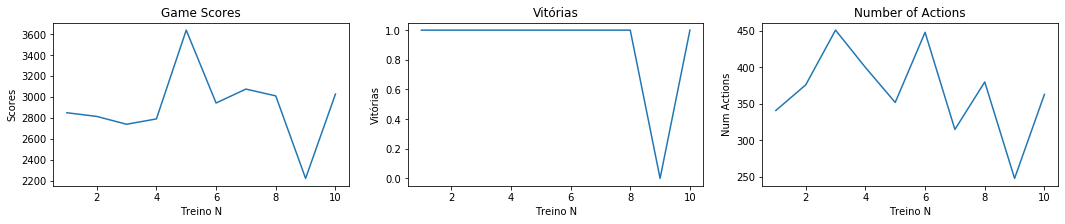

Wins:  9  Loss:  1
Avg Score:  2910.6
Avg NumActions:  367.4


In [36]:
printGraphs(gamesScores,results,numActions)

#### Análise para o resultado do treinamento
&emsp;&emsp;Percebemos através do treinamento que o pacman aprende o equilíbrio entre procurar por comidas e fugir dos fantasmas, e com as features de pílula e fantasmas comíveis, o agente aprende que essas outras interações do jogo são positivas e têm boa recompensa.\
&emsp;&emsp;Alguns desafios foram encontrados no começo do desenvolvimento, observamos que se em um futuro estado havia uma comida e um fantasma, o peso de comer a comida era maior que o de fugir do fantasma, e que o reforço negativo com a morte do agente, na feature *futureScore*, não era suficiente para equilibrar esses pesos. Assim, adicionamos um reforço negativo em *futureScore* caso houvesse um fantasma naquele estado, pois a função *getScore* do GameState não calculava a morte do pacman. Assim, o agente aprendeu que fugir do fantasma era mais importante que comer uma comida.\
&emsp;No entanto, com essa modificação o agente ficou enviesado para fugir dos fantasmas ao invés de buscar as comidas para ganhar o jogo, e o treinamento não era capaz de balancear esses pesos. Então, adicionamos um reforço positivo também em *futureScore*, para que, caso não ohouvesse um fantasma no próximo estado, o agente fosse em busca das comidas disponíveis.

### Teste 
&emsp;&emsp;Teste do modelo final do agente, resultante do treinamento anterior. Realizamos 30 jogos para cada um dos mapas.

In [37]:
layoutType='smallClassic'
pacman.setIsTrain(False)
gamesScores, results, numActions = approxQLearning(pacman, layoutType,30,pacman.n_train)

layout:  smallClassic
------------------------------------------ train --------------------
Action Score:  [3.2883929970838093, 3.2882533159563305]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2849628903338894, 3.2250113236547167]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.283898575654806, 0.7967835043322418]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2727151069090334, 0.7911878388096577]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.249706290979503, 3.2938479397724887, 0.7880139937402472]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.3171705343381515, 3.1946231270217194]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.3838065188114745, 3.2938479397724887, 0.7771

Action Score:  [3.155818407164408, -2.103932938144742, 3.1289889006233134]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-2.093137908660063, 3.1666134366490866]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.0698153140944004, -2.103932938144742, 3.1899360312147493]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7673970657741618, -2.093137908660063, 3.1666134366490866]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.0698153140944004, 3.155818407164408]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.677438486735176, 3.249706290979503]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2736531567229203, 0.7663953076992447]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588

Action Score:  [-0.2715194223885813, 0.08904703340824421]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.11611189786297854, -0.23686425560141455, 0.13857127342225545]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.1739705410171631, 0.285161380375145]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7289692321345435, -0.12444630100315182, 0.12191227730392477]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.16306101809067, 0.022143805949737694]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7456282282528742, 0.46595165770913616, 3.218144182048454]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.47181562434278856, 3.2146083951172164]
W:  [[3.04735653 1.4027604  2.01869448 0.479

Action Score:  [0.8041005016380167, 3.295747679190334]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.8063953633481948, 3.3016116458239866]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.313039110575971, 0.8103487250991477]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.3896244096019099, 0.1320226899985376]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.29824282237035915, 0.7997232486696775, 0.20828424333137333]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.1684490802805465, 0.37194453895517954]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [6.007871199384725, 0.7367280416879649, 0.7510162904427502]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:

Action Score:  [0.13432918340880157, 0.13432918340880157, 0.522970085366695]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.236486831376249, 2.0469668049794536, 0.236486831376249]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5172521418182552, 0.5172521418182552, 2.1085472527786937]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5329459445285196, 2.164553684053633]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5510365832315222, 2.2734403355889246]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.6973469368087829, 0.5518692576821309, 2.2750136852223224]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [1.2803830610531624, 0.5907111007490347, 2.169547303134981]
W:  [[3.04735653 1

Action Score:  [3.7436408349674175, 3.2562234037467155]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.3563238661368198, 0.8946315688975637, 0.9941923005101563]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2896878816634967, 1.226983232378852, 3.1899360312147493]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.1956248850966364, 3.266365287097834, 3.1666134366490866]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.28305291028781, 3.2287407510720607]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.283898575654806, 0.7943351864798015]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2803627887235685, 0.7835401569951231]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.775880

Action Score:  [3.3374595474534487, 3.3905161508121227, 0.9861168048525135]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [1.2690660442869173, 0.22764826159427026]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.3417457597774183, 0.4595599097379231, 0.7033718240721284]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.275109775304095, 1.2733522566108868, 3.3317706935715616]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.308448099005899, 3.300557571773137, 0.9092317281309741]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2708235629801257, 3.2976530695212203, 0.8468819559816209]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [6.355804628577701, 0.8235593614159579]
W:  [[3.0473565

Action Score:  [0.8025107509232803, 3.294223645725225]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.8048056126334584, 3.300087612358877]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.308448099005899, 0.8069003652976271]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.3850333980318381, 0.12857433019701697]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.2942842460675931, 0.7943351864798015, 0.20432566702860727]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.16306101809067, 0.36798596265241357]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.7289692321345435, 2.955126607623047, 0.7456282282528742]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  E

Action Score:  [0.8068714793587283, 3.303380316112259]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.808341399564696, 6.358239171415358]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Pacman emerges victorious! Score: 1345
Average Score: 1345.0
Scores:        1345.0
Win Rate:      1/1 (1.00)
Record:        Win
------------------------------------------ train --------------------
Action Score:  [3.2883929970838093, 3.2882533159563305]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2849628903338894, 3.2250113236547167]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.283898575654806, 0.7967835043322418]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.289762542288458, 0.7990783660424199]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]

Action Score:  [-0.002465302675116965, -2.4883021198911277]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.09370412647022026, -2.5278587790710034]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.31772524738111085, -0.002465302675116965, -2.517063749586325]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [1.127231381930105, -2.448320529207134]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.1956248850966364, -2.283553563037917, 0.7841927569202684]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2896878816634967, 1.127231381930105, 0.800512931749586]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.8671489162229089, 0.777190337183923, 3.2938479397724887]
W:  [[3.04735653 1.4027604

Action Score:  [-2.3627549228020777, -0.010536945797464198]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.466749871131624, -0.052402927526230894]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.521424227424829, -0.08038077716289202]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.548392021675689, -0.09699233170756721]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.568553536733416, -0.1102622250988145]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.579334689754676, -0.11848999968392365]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.13236071852689127, -2.598910451310403, -0.13236071852689127]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  N

Action Score:  [3.2438756423380872, 0.7880139937402472]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2146083951172164, 0.7741404034302332]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.955126607623047, 0.7231385834931278]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.4624158707778986, -3.576321476674173]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-3.6431325738992624, 0.01044919067466954]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-5.160689221281434, -0.14464108405272005]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-5.443358316408451, -0.1411052971214825]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-5.5391

Action Score:  [3.2633153533441437, 0.7663953076992447]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7776761903614707, 3.2438756423380872]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7569955541343547, 3.1464186535995182]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.6549488419754296, -0.5348289137360243]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.20757188529255685, -0.5993118312586976]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.053722535786226586, -2.11562755341981]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-2.3937069251264713, 0.022143805949737694]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.48

Action Score:  [-0.10803710059242652, -2.5669250842579228]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.11914722156768315, -0.11914722156768315, -2.582634758849017]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.10803710059242652, -2.5929238213403094]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.11914722156768315, -2.60003663822585, -0.09191763657771869]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.5929238213403094, -0.06722482482462147]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.582634758849017, -0.02652829706826132]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.0325270256241256, -0.06722482482462147, 0.1476437375935579]
W:  [[3.04735653 1.4027604  2.0186

Action Score:  [3.2675331373576846, 1.265775618664476, 3.3171705343381515]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.300557571773137, 0.9013412008982118, 3.283510136393712]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2629330357473636, 3.2708235629801257, 3.289762542288458]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.283510136393712, 0.811382621859226]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7835401569951231, 3.224008148682106, 0.8176577810454645]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7456282282528742, 3.218144182048454, 2.955126607623047]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [2.900043443665263, 0.285161380375145]
W:  [[3.04735653 1.4027

Action Score:  [0.34174748918908837, 0.17717840353163522, 0.11151551817184634]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7832705659095429, 0.17678732650646878]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2117565996718516, 0.34174748918908837, 0.3412752729392567]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2114983852320176, 0.7832705659095429, 3.2559717958715737]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.255656294883863, 3.2076559146698127, 0.7664813449699525]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.1463177070532105, 3.2072648376446464, 0.7662231305301184]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [5.9919948698162075, 0.7177743867430252]
W:  [[3.

Action Score:  [0.7856790910171543]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.007544631074382, 0.20669130273905306, 0.20148059878474386]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.09600713071302654, 0.09600713071302654, 1.2190443589819684]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.005476940194602778, 0.005476940194602778, 0.00808728155571872]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.0001017471532474036, -0.008285250143679458, 0.0001017471532474036]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.00808728155571872, 0.005476940194602778]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.0001017471532474036, -0.008285250143679458, 0.0001017471532474036]
W:  

Action Score:  [0.9149589747220125, 3.3108826418435555, 3.3141753455969374]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2732581058177823, 3.303380316112259]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8217076919296449, 3.2975163494786064]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.293980562547369, 0.8109126624449665]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2916857008371907, 0.8050486958113141]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.290687858793987, 0.8015129088800765]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.294223645725225, 0.8025107509232803]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score: 

Action Score:  [0.07340651944704052, 0.1003468303964205, 0.14407379322879496]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.09261972287911671, 0.10782065588173831, 0.3162055605049643]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.15842934704222997, 0.6818193311595326, 0.15355678268297673]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.3219235040534041, 0.2695361628992353, 3.1011974782356297]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5504032660237178, 3.162977283277675]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.533579261736324, 3.1583847474670064]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.764125074980228, 0.7735541838125111, 3.156246931816561]
W:  [[3.04735

Action Score:  [0.7605313410655923, 3.1666134366490866]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.0864915182889518, 0.2510892629077881]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.31772524738111085, 0.17013338235330433, 0.7456282282528742]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.3508411133565351, 3.094871276572972]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.5348289137360243, 0.677438486735176, 0.6607794906168453]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.3508411133565351, 3.094871276572972]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.149954440530756, 0.777190337183923, 0.7605313410655923]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.775880

Action Score:  [0.5336043758305489, 2.1237732998755403]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5429413421995181, 2.173083090066218, 2.134568329360219]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.2773085469325007, 2.0802834907793026]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [1.0720066660658225, 0.7058763428213682]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-5.5884832735512715, 0.012744052384847743]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-5.541489298104346, 0.46595165770913616]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-5.4410634546982735, 2.900043443665263]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Scor

Action Score:  [3.2287407510720607, 1.127231381930105, 3.2896878816634967]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.266365287097834, 3.266365287097834, 0.7673970657741618]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.1289889006233134, 3.2555702576131553, 3.1289889006233134]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.1666134366490866, 0.677438486735176]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.3167234893061939, 0.3167234893061939, 0.2510892629077881]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.07038153190455727, 0.677438486735176]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.2510892629077881, 0.3167234893061939, 3.1289889006233134]
W:  [[3.04735653 

Action Score:  [0.7663953076992447, 3.1464186535995182]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.6607794906168453, -0.54065956237744]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.3167234893061939, 3.0854715230080823]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7605313410655923, 3.1441237918893403]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7531273427907788, 0.7569955541343547, 3.1441237918893403]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7531273427907788, 0.7547006924241766, 3.1464186535995182]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7547006924241766, 3.149954440530756]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  W

Action Score:  [-5.4410634546982735, 0.022143805949737694]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-5.535658649462929, 0.48261065382746693]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-5.431663701133384, 2.9341610677156043]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.0007970521889273, -5.140494438231865, 2.9717856037413775]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-3.6031509832152686, 0.932403549022396, 2.9951081983070402]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.9717856037413775, -5.0505358591928795, 2.9717856037413775]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.9341610677156043, 0.5059332483931299, 3.224008148682106]
W:  [[3.04735653 1.4027604  2.

Action Score:  [0.7605313410655923, 3.08900730993932, 3.266365287097834]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.6666434572504977, 0.19345597691896732]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.21110767222379437, -0.5957760443274602, 0.22776666834212508]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.103932938144742, 0.09370412647022026]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.08749327636386886, -2.373512142076903, -0.002465302675116965]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.21292863959351455, -2.448320529207134]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.17076581386491718, -2.427105170547339, 0.6010912167296792]
W:  [[3.04735653 1.402760

Action Score:  [0.7776761903614707, 3.2123135334070385]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7702721920866571, 0.7741404034302332, 3.2123135334070385]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7702721920866571, 0.771845541720055, 3.2146083951172164]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.771845541720055, 3.218144182048454]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7741404034302332, 3.224008148682106]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.283510136393712, 3.218144182048454, 0.7776761903614707]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.289762542288458, 3.2117679763175975, 3.3238801663387996]
W:  [[3.04735653 1.4027604  2.01869448 0.4

Action Score:  [0.4624158707778986, 3.224008148682106]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.283510136393712, 3.2668511402753815, 0.7289692321345435]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.28305291028781, 3.1946231270217194, 3.3171705343381515]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2938479397724887, 3.205418156506398, 3.3838065188114745]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.3284802679491206, 3.7549505685783866, 3.2562234037467155]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [3.3341691218310077, 3.4008412208825414, 0.9847702345994405]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [1.271500587124574, 3.3342052364092183]
W:  [[3.04735653 1.

Action Score:  [-0.05101297414064289, -0.15048347265494702]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.15165942763839152, -0.04967320447779103]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.05101297414064289, -0.020594656714641734]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.022190551803136213, -0.018672842820016775]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.020594656714641734, -0.016329782604566377]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.04091516150187923, -0.018672842820016775]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.048077309389296545, -0.016329782604566377]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION: 

Action Score:  [3.2849628903338894, 3.2250113236547167]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.283898575654806, 0.7967835043322418]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2727151069090334, 0.7911878388096577]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.249706290979503, 3.2938479397724887, 0.7880139937402472]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.3284802679491206, 3.222105779696374]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.4008412208825414, 3.3108826418435555, 0.8159827234695469]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.7549505685783866, 3.2675331373576846]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  N

Action Score:  [0.8046729898585779, 3.2771889436541577, 3.249706290979503]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [3.222105779696374, 0.3509157739814968]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.8159827234695469, 0.7947236257408953, 3.2771889436541577]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8005875923745477, 3.2736531567229203]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7947236257408953, 3.271358295012742]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7919197290764026, 0.7911878388096577, 3.271358295012742]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7919197290764026, 0.7888929770994796, 3.2736531567229203]
W:  [[3.04735653 1.4027604  2.01869448

Action Score:  [0.02191319085095339]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.026561862672845583, 0.020105716126260678, 0.016660537590730877]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.025217198078521203, 0.02763113439939323, 0.05514516077631777]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.036044852127027335, 0.09489814924993253, 0.036044852127027335]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.09286159610544975, 0.7871367531775082, 0.09286159610544975]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.20265939304745248, 0.20739788075192994, 1.208053139763423]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.05200206449116193, -0.015796529695846103]
W:  [[3.04

Action Score:  [0.8450302864953079, 0.8483229902486897, 3.300087612358877]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8159827234695469, 0.21465073709902616]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.3612408440519157, 3.2334155133073432, 0.39535846810225694]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.8217076919296449, 0.8050486958113141, 3.288498677265127]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8051876939848686, 3.2736531567229203]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7993237273512162, 3.271358295012742]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7919197290764026, 0.7957879404199786, 3.271358295012742]
W:  [[3.04735653 1.4027604  2.018694

Action Score:  [-2.109796904778394, 3.149954440530756, 2.9717856037413775]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2461705040482656, 3.094871276572972]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.1751263902682127, 0.7605313410655923]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.3348063884159587, 3.1946231270217194]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7605313410655923, 0.7880139937402472, 3.283510136393712]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7938779603738996, 3.306832730959375]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.373468715432698, 0.811382621859226, 3.283510136393712]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]] 

Action Score:  [-0.059647552492830214, -0.05204783708197208, -0.30451011575964915]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.052117542513229864, 0.00022666773372659668]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.005885241555819574, 0.02550187769826031, 0.007995655897507052]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.0423683190095511, 0.015454135440126363]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.03906028528250824, 0.02368191002523553]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.019497979275310447, 0.01990436803705826]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.012191035645193811, 0.005287904392737838]
W:  [[3.04735653 1.4027604  2.01869448 0.4

Action Score:  [0.7952101546988439, 0.7957879404199786, 3.27806792701339]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7873196274660816, 0.7888929770994796, 3.2633153533441437]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.771845541720055, 3.218144182048454]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7254334452033059, 2.960990574256699]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.9717856037413775, -3.5821854433078255, 0.46595165770913616]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.960990574256699, -3.63726860726561, 2.9951081983070402]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.9717856037413775, -3.6264735777809314, 3.0617441827803633]
W:  [[3.04735653 1.

Action Score:  [3.2287407510720607, 3.2287407510720607, 3.2727151069090334]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2348031781667848, 0.7943351864798015]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7835401569951231, 3.224008148682106, 0.8176577810454645]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7943351864798015, 3.2668511402753815, 3.218144182048454]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [3.2117679763175975, 0.34420614198084865]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.8046729898585779, 0.7947236257408953, 3.2668511402753815]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7938779603738996, 3.2633153533441437]
W:  [[3.04735653 1.4027604  2.018

Action Score:  [3.2708235629801257, 1.2611755170541552, 3.3238801663387996]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.300557571773137, 0.9013412008982118, 3.283510136393712]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.245885600367939, 3.2629330357473636, 3.2727151069090334]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2348031781667848, 0.7943351864798015]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7348331987681959, 2.960990574256699, 0.7689508228185372]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7456282282528742, 2.955126607623047, 3.218144182048454]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.16306101809067, 3.2633153533441437]
W:  [[3.04735653 1.40

Action Score:  [0.12328936074343752, 0.033330781704451716, 0.031456034753691534]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.05567006146981214, 0.4788499364766369, 0.057672314241697054]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.1186892591331166, 0.12328936074343752, 0.4933881224572391]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.021921275602231574]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.028555369114581307, 0.022299841129963367, 0.017089137175654186]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.021921275602231574, 0.021921275602231574, 0.0380923329972296]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.024844203830738147, 0.04321861929788046, 0.0248442

Action Score:  [3.2555702576131553, 3.094871276572972, 3.2896878816634967]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.266365287097834, 0.8671489162229089, 3.1056663060576506]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.700761081300839, 0.800512931749586, 3.155818407164408]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.093137908660063, 0.07038153190455727]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-2.35018954751124, 0.020857291890546026, -2.3843071715615816]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.1603401109435431, -0.042036422693705444, -2.471643123772797]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-2.493741155020662, 0.447327592519812, -2.35018954751

Action Score:  [0.31772524738111085, 0.677438486735176, 0.17013338235330433]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.5899120776938078, 0.2510892629077881]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.31772524738111085, -2.093137908660063, 0.07038153190455727]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [1.127231381930105, -2.35018954751124]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.1956248850966364, -2.283553563037917, 0.7841927569202684]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.1289889006233134, 1.127231381930105, 3.2896878816634967]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.266365287097834, 3.2938479397724887, 0.8671489162229089]
W:  [[3.04735

Action Score:  [0.5260543544705226, 0.5260543544705226, 2.131830867805849]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5276277041039206, 2.135366654737086]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5394055552682805, 2.1789470566998705]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.134568329360219, 2.173083090066218, 0.5429413421995181]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [2.0802834907793026, 2.2867083004973905]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5603986636947162, 2.135366654737086, 2.297503329982069]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.1179999261084346, 2.90273664105434]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]

Action Score:  [3.2675331373576846, 1.265775618664476, 3.3171705343381515]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.305157673383458, 0.9059413025085328, 3.2938479397724887]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2675331373576846, 3.2732581058177823, 3.294362643898779]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2938479397724887, 0.8159827234695469]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7938779603738996, 3.2555702576131553, 0.8279955844242409]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.777190337183923, 3.249706290979503, 3.149954440530756]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [3.1946231270217194, 0.34420614198084865]
W:  [[3.04735653 

Action Score:  [-2.5710978994341906, -0.11160879535188764]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.5818790524554505, -0.11983656993699679]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.12460190897346982, -2.5911516417569813, -0.12697265633701527]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.12401844931477121, -2.59652016824027]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.1303816567113032, -2.5986965896213863, -0.11540022640037988]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.09374757936524623, -2.594612905717798]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.11606295246385545, -2.607149179932385]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77

Action Score:  [0.22776666834212508, 0.21110767222379437, -0.5957760443274602]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.2169716388574468, -2.103932938144742, 0.2510892629077881]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.677438486735176, 0.7673970657741618, -2.373512142076903]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.1289889006233134, 0.677559563537054, -2.35018954751124]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-2.003179329621078, 3.1666134366490866, -2.093137908660063]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.155818407164408, -2.0698153140944004]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.149954440530756, -2.093137908660063]
W:  [[3.0473565

Action Score:  [1.2744598624333114]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.7884807228842456, 0.3044136687123441, 0.3044136687123441]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [4.436457387230188, 0.5847879021291837, 2.1597558931715537]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2096242481687054, 3.2705713787601414, 0.789286956078993]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.253523943380717, 3.253523943380717, 0.7813964288462307]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [3.2096242481687054, 3.253523943380717, 0.7813964288462307]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [6.300880472952519, 0.7156420352398789, 0.7643489934668062]
W:  [[3.04735653 1.

Action Score:  [-5.431663701133384, -0.20808816506750438, -2.35018954751124]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-5.518999653344599, -0.1411052971214825, -0.25352325171974527]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-2.5278587790710034, 0.2169716388574468]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-2.4883021198911277, 0.053722535786226586, 0.677438486735176]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.3843071715615816, 3.1289889006233134]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7673970657741618, -2.093137908660063, 3.1666134366490866]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.700761081300839, 3.2555702576131553]
W:  [[3.04735653 1.4027604

Action Score:  [3.275109775304095, 3.27769422614879, 3.30193928184519]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.308448099005899, 0.8235593614159579]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.8127643319312795, 3.2976530695212203, 0.8468819559816209]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.8235593614159579, 3.296075315211538, 3.2917891028875683]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [3.240992151253754, 0.36453354780529745]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.8261438122606519, 0.808341399564696, 3.296075315211538]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8142053661983484, 3.290687858793987]
W:  [[3.04735653 1.4027604  2.01869448 0.4

Action Score:  [-0.022660085724685197, -2.5791033270272385]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.1411052971214825, -2.5642263268867533]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-5.431663701133384, -2.537258532635893]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Pacman died! Score: -112
Average Score: -112.0
Scores:        -112.0
Win Rate:      0/1 (0.00)
Record:        Loss
[True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, False, True, False, True, True, False, True, True, True, True, True, True, False]
Wins:  25  Loss:  5
[982.0, 1144.0, 1353.0, 978.0, 1345.0, 40.0, 962.0, 1337.0, 1374.0, 1330.0, 1374.0, 1368.0, 981.0, 977.0, 1351.0, 987.0, 1515.0, -201.0, 1351.0, -117.0, 1143.0, 974.0, -128.0, 1153.0, 1348.0, 1372.0, 1149.0, 1565.0, 1359.0, -112.0]


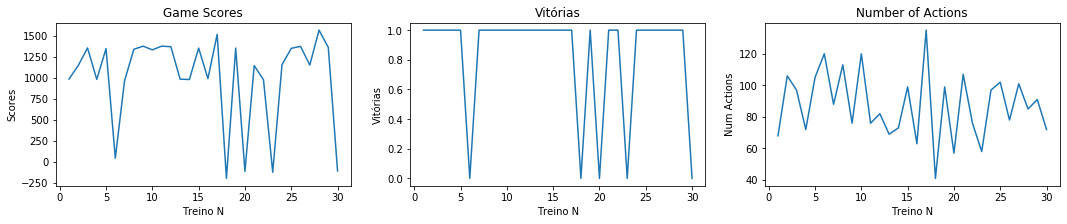

Wins:  25  Loss:  5
Avg Score:  1008.4666666666667
Avg NumActions:  87.53333333333333


In [38]:
printGraphs(gamesScores,results,numActions)

In [39]:
layoutType='mediumClassic'
pacman.setIsTrain(False)
gamesScores, results, numActions = approxQLearning(pacman, layoutType,30,pacman.n_train)

layout:  mediumClassic
------------------------------------------ train --------------------
Action Score:  [3.289586818532878, 3.287780421652424]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.288154269015412, 3.227224368086155]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2875459091989523, 0.7994894184713228]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2843851046127543, 0.797538284834433]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2859584542461526, 0.7983709592850418]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2849628903338894, 0.7976446975365006]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.271358295012742, 0.7934930787098005, 3.288498677265127, 3.282668

Action Score:  [3.2938479397724887, 3.2771889436541577, 0.7605313410655923]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.3284802679491206, 3.222105779696374]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.8159827234695469, 3.3951162524224436]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8393053180352099, 3.7549505685783866]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.4562694841154818, 2.501957632976472]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.085670038060759, 0.5063377166445892]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5063377166445892, 2.085670038060759]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score: 

Action Score:  [-0.02769301149149095, -0.22727932859582137, -0.03245149568811223]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.011617049367345603, -0.07202261570670071]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.005248352039695498, 0.0038690974395579267, 0.031351750114212734, 0.0038690974395579267]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.0665216210276702, 0.015865603307309205]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.1093831666687, 0.04266148372518179]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.06981204665011152, 0.174339474015612, 0.06981204665011152]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.10149263943593778, 0.31467717507375526, 0.10149263

Action Score:  [3.222105779696374, 3.3284802679491206]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.8159827234695469, 3.4008412208825414]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.760675537038485, 0.8450302864953079]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.501957632976472, 0.4619944525755798]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0865029878666754, 0.5071706664505057]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0960061016911666, 0.5114696935595214]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.123030736950289, 0.5209641056565882]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.1608438276119344

Action Score:  [2.078934960323414, 2.016558343844868]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.081305707686959, 2.078934960323414, 2.081305707686959, 0.5039669692810438]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0831256753599843, 2.01901200684245]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5063377166445892, 0.2303278136015491]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.2303278136015491, 2.0203585770955232]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5107020470183887, 2.081305707686959, 2.085670038060759, 0.5063377166445892]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.089381203344602, 2.022178544768548]
W:  [[3.04735653 1.4027604  2.01869448 0.47

Action Score:  [0.04039533889156201, -2.1231241016730587, 0.19778047532912982]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.19778047532912982, 0.7472041441709278]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.2975323257778769, 3.2029146161680573]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7859965304565517, 3.2638617467594933, 0.7746867968455826, 0.7859965304565517]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7859965304565517, 3.2638617467594933]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7859965304565517, 3.2638617467594933]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2751714803704624, 3.2638617467594933, 0.7859965304565517]
W:  [[3.04735653 1.4027604  2.

Action Score:  [2.091255340407914, 2.046082858246644]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.522263507353818, 2.087802389563905]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5162873493655441, 2.085573527850841]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5165455638053782, 2.0859646048760077]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5106055368084708, 2.092713002568268]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.513540976534412, 2.0990642633245122]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5234629550743378, 2.126837248724501]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.533579261736324, 2.1656

Action Score:  [0.06981204665011152, 0.174339474015612]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.1093831666687, 0.3317246104531798]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7813964288462307, 0.18223000124837424]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2096242481687054, 0.33961513768594204]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2705713787601414, 0.789286956078993, 0.789286956078993, 3.2705713787601414]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2638617467594933, 3.2142243497790264]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2363790940848385, 0.7746867968455826, 3.2638617467594933]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.775

Action Score:  [-0.02769301149149095, 0.03573824582958596, -0.29071058591689825]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.1085850804092602, -0.2668504486144098]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.265970216846828, -0.22727932859582137]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.15729203863618746, 0.15729203863618746, 0.7472041441709278, 0.1085850804092602]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.1754319634934025, 0.265970216846828]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2363790940848385, 0.7643489934668062, 0.7156420352398789]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2363790940848385, 0.7156420352398789]
W:  [[3.04735653 1.4027604 

Action Score:  [3.1457439916256655, 3.1940576124442437]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7660091287201208, 0.782725456791405, 0.782725456791405, 3.272231514013456]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7828772285011935, 3.2803360430562156]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7909470913323076, 3.2773038318736085]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7935956359799619, 3.277619332861319]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7938538504197958, 3.2780104098864857]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7884443829474084, 3.2671935459831594]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  We

Action Score:  [0.1359079971894984, 0.5296141453048535, 0.1359079971894984]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.061092327250986, 0.2397569224338321]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.5470714668000517, 0.5201311558506717, 2.095099146893042, 0.5201311558506717]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.089381203344602, 0.5296141453048535]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0831256753599843, 0.5144132123022319]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.03320619775367229, 0.06210327355144532, 0.03757052812747185]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.047226273410959946, 0.09620531492441022, 0.047226273410959946]
W:  [[3.047

Action Score:  [-0.03696618690961051, -0.08567314513653779]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.03771869893222745, -0.02575395246016396]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.026628383530834104, -0.0522124218611627]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.027380895553451044, -0.05323660513481877]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.05411103620548891, -0.026628383530834104]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.027380895553451044, -0.02575395246016396]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.01531864991986505, -0.02472976918650789]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East

Action Score:  [0.7859965304565517, 3.2751714803704624]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7859965304565517, 3.2638617467594933]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7746867968455826, 3.2363790940848385]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.1366272436360916, 0.7472041441709278]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.5481561106306887, 0.6474522937221807]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.6091032412221247, 0.19778047532912982]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.04039533889156201, -2.1231241016730587]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.03245149

Action Score:  [0.677438486735176, 3.3563238661368198]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.800512931749586, 3.7436408349674175]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.44495975050451275, 2.501957632976472]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0831256753599843, 0.508157684317614]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5063377166445892, 2.085670038060759]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5063377166445892, 2.085670038060759]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.508157684317614, 2.089381203344602]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5107020470183887, 2

Action Score:  [-2.1231241016730587, 3.1366272436360916, 0.6474522937221807, 0.6474522937221807]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-2.1231241016730587, 3.1366272436360916]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-2.501629316785792, -0.07202261570670071]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.0038690974395579267, -0.03245149568811223, 0.02772923474204635]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.02772923474204635, 0.09478300743528964]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.1676298420149639, 0.0665216210276702, 0.05521188741670116, 0.0665216210276702]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.3250149784525317, 0.1060927410462587]


Action Score:  [-0.15386288665423598, -0.15386288665423598]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.15461539867685292, -0.15298845558356583]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.15386288665423598, -0.15196427230990975]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.15298845558356583, -0.15075408287171238]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.15196427230990975, -0.15196427230990975, -0.04955810904425927]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.15075408287171238, -0.047815630747986206]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.04955810904425927, -0.045686572342533385, -0.14930995949300632, -0.045686572342533385]
W:  [[3.0473565

Action Score:  [3.28163095564155, 3.210285255063657]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5123621822717034, 2.0826347356321335]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2850494159032997, 0.7906360380546149]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2884270643273257, 0.7970282233245156]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2897722080709553, 0.7993636276935543]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7986196791461093, 3.2892703089414974]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7980128073123507, 3.2871877572262616]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.120609144437008

Action Score:  [0.2666972333832121, 2.034152016301606]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5296141453048535, 2.089381203344602, 0.5296141453048535]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.2397569224338321, 2.024722907469323]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5201311558506717, 0.5107020470183887, 0.5201311558506717, 2.085670038060759]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5144132123022319, 2.0831256753599843]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5144132123022319, 2.0831256753599843]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5107020470183887, 2.081305707686959]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.775880

Action Score:  [0.7643489934668062, 3.2705713787601414]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7813964288462307, 3.278461905992904]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.789286956078993, 3.2827481183168734]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.285332569161567, 0.7935731684029625]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2870099771617296, 0.7961576192476567]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [6.334366506733531, 0.7978350272478187]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Pacman emerges victorious! Score: 1527
Average Score: 1527.0
Scores:        1527.0
Win Rate:      1/1 (1.00)
Record:        Win
------------------------------------------ tr

Action Score:  [0.3417640880212295, 0.18889477678835595, 0.7959517316189747, 0.3417640880212295]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2243299564328867, 0.34337870846877305]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2851804316918094, 0.796005481777899, 0.7929209466371694]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2871619741073363, 0.7961021371104122]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2851804316918094, 0.796005481777899]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2819843832709408, 0.7959211574681561]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.796005481777899, 3.2820958965510805]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.7

Action Score:  [-2.5470499425993203, -0.09588275300918914]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.571722875140002, -0.11136889981609266]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.5865998752804877, -0.11136889981609266]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.5962556205639755, -0.09588275300918914]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.5962556205639755, -0.07202261570670071]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.5865998752804877, -0.03245149568811223]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.04039533889156201, -2.571722875140002]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  

Action Score:  [0.0014698417406962642, -5.572248882578304e-06]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.000929151731287426, -0.0011692175968115587, -0.000929151731287426, -0.0011692175968115587]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.007965144919512605, -0.004255126719401706]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.012238885342256478, -0.006894186056909529, -0.012238885342256478, -0.006894186056909529]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.004255126719401706, -0.004255126719401706]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.000929151731287426, -0.006894186056909529, -0.000929151731287426, -0.0011692175968115587]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTI

Action Score:  [2.124171809345568, 2.097231498396188, 0.522263507353818, 3.229208163429317]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.167869955812714, 2.9572543498792694]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.1067144878503696, 3.271490600094927, 0.7823156501810167, 3.162543089289441]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [3.1621520122642743, 3.264976857670475]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7786044848971734, 3.279990323566877, 3.279990323566877]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [3.219257194785439, 3.2243836372463064]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7973593306326558, 0.7994932079182087, 0.7994932079182087, 3.2

Action Score:  [0.7254334452033059, 3.2727151069090334]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.300557571773137, 0.7776761903614707, 3.283898575654806]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.3317706935715616, 3.2288154116970222]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.811382621859226, 3.3984066780448847]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.834705216424889, 3.758240994200828]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.45166938250516087, 2.5001376653034475]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.078934960323414, 0.5063377166445892]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [

Action Score:  [3.288154269015412, 3.227224368086155]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2875459091989523, 0.7994894184713228]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.286819647450411, 0.7989793191015019]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.282668028623711, 0.7965192897987288]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2803627887235685, 0.7952101546988439]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.261020491633966, 0.7888929770994796, 3.283898575654806, 3.27806792701339]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2976530695212203, 3.2194156581321325]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East


Action Score:  [2.894179477031611, 3.2348031781667848]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2581257727324475, 3.224008148682106, 0.47181562434278856]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.3247617572057706, 2.9108384731499415]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.7333030315886413, 0.7689508228185372]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.5139311045095303, 0.4346219471257363]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5144132123022319, 2.1045821363472235]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.1597558931715537, 0.5296141453048535]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Scor

Action Score:  [3.2638617467594933, 0.7746867968455826]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2029146161680573, 0.33632471206350073]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.7746867968455826, 3.2638617467594933, 0.7472041441709278, 0.7746867968455826]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7472041441709278, 3.2638617467594933]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.14014718934030906, 0.05521188741670116]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.19778047532912982, 0.06730035476063484]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.19778047532912982, 0.04039533889156201, -2.1231241016730587, 0.04039533889156201]
W:  [[3.04735653 1.4027

Action Score:  [0.5063377166445892, 2.085670038060759]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5063377166445892, 2.085670038060759]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.508157684317614, 2.089381203344602]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5144132123022319, 2.089381203344602, 2.1045821363472235]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.1220394578424218, 2.034152016301606]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.1220394578424218, 2.2675171369690736, 2.1220394578424218, 0.5470714668000517]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [2.0988087625801177, 2.8494278534756816]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.775880

Action Score:  [-2.1231241016730587, 3.1366272436360916]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-2.1231241016730587, 3.1366272436360916]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.6474522937221807, 3.2363790940848385]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7472041441709278, 3.2638617467594933]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2705713787601414, 0.7746867968455826]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.253523943380717, 0.7813964288462307]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2048169851537898, 0.7643489934668062]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.3343012213

Action Score:  [3.288154269015412, 3.227224368086155]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2875459091989523, 0.7994894184713228]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.288671316936724, 0.8001227356791272]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2859584542461526, 0.7983709592850418]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2803627887235685, 0.7952101546988439]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.271358295012742, 0.7934930787098005, 3.288498677265127, 3.282668028623711]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.294362643898779, 3.2127060261314844]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East

Action Score:  [0.4346219471257363, 2.5139311045095303]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.1045821363472235, 0.5144132123022319]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5144132123022319, 2.1045821363472235]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5201311558506717, 2.1220394578424218]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5201311558506717, 2.1220394578424218]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5470714668000517, 2.1220394578424218, 2.2675171369690736]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.8494278534756816, 2.0988087625801177]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Sco

Action Score:  [2.9417994107283825, -3.59551264020249, 0.4526244608144716, 2.9417994107283825]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.002952642421420709, -3.656459770793927]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.1544324940161471, -5.170480631244861, 0.002952642421420709]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-5.4508548646617, 0.4526244608144716]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.002952642421420709, 3.143869854562354]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2048169851537898, 3.253523943380717, 0.7156420352398789, 0.7643489934668062]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [3.192576812789281, 3.2705713787601414]
W:  [[3.0473

Action Score:  [2.02405268183186, 2.0918290558354586]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.087802389563905, 2.087802389563905, 0.512834398521535, 2.0979380764090654]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0271707599601796, 2.098430946116708]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5172521418182552, 2.1085472527786937]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.517745011525898, 0.517745011525898, 2.109379927229303]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5240962722821422, 0.5240962722821422, 2.1279626564622727]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5344119361869327, 2.1672524414248024]
W:  [[3.04735653 1.4027604  2.01869448 0.4797

Action Score:  [0.4526244608144716, 0.1085850804092602]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-3.656459770793927, 0.002952642421420709]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-5.170480631244861, -0.1544324940161471]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.22727932859582137, -5.4508548646617]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.2668504486144098, -5.548985846357595]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.2668504486144098, -5.594406472171123]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.22727932859582137, -5.619079404711805]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.154432

Action Score:  [3.2870099771617296, 0.7978350272478187, 0.7961576192476567]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2881600025643096, 0.7978350272478187]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2870099771617296, 0.7978350272478187]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.285332569161567, 0.7978350272478187]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7978350272478187, 3.285332569161567]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7978350272478187, 3.285332569161567]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7961576192476567, 3.2827481183168734]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:

Action Score:  [2.1045821363472235, 2.1045821363472235, 2.1597558931715537, 0.5296141453048535]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.2675171369690736, 2.061092327250986]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.2675171369690736, 0.5470714668000517]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [1.2744598624333114, 2.1597558931715537, 0.5847879021291837]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.5847879021291837, 2.1045821363472235, 0.5847879021291837]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.095099146893042, 0.5470714668000517]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.089381203344602, 0.5296141453048535]
W:  [[3.04735653 1.4027604  2.01869448 

Action Score:  [-0.0825643413540142, -0.03385738312708693]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.03506757256528429, -0.015365824368956322]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.013623346072683251, -0.01680994774766238]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.02854172304665499, -0.015365824368956322]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.030670781452107804, -0.01680994774766238]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.01802013718585975, -0.03241325974838087]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.008919420514900162, -0.01680994774766238]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North

Action Score:  [3.094871276572972, 3.2896878816634967]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.677438486735176, 3.3563238661368198]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.7436408349674175, 0.800512931749586]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.501957632976472, 0.44495975050451275]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0807920872398027, 0.5089906341235305]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0798419151215386, 0.5071053631857219]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0799262394312814, 0.5047999190869603]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.081047071874267

Action Score:  [3.253523943380717, 0.7813964288462307]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.3317246104531798, 3.192576812789281]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7643489934668062, 3.253523943380717, 0.7156420352398789, 0.7643489934668062]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7156420352398789, 3.253523943380717]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7643489934668062, 3.2705713787601414, 3.2705713787601414]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [3.2096242481687054, 3.217514775401468]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.789286956078993, 3.2827481183168734, 0.789286956078993, 0.7935731684029625]
W:  [[3.04735653 

Action Score:  [0.0033215112270092023, 0.0011378443287426692]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.009231937059817584, 0.0006824518895013794, 0.0066474862151234835, 0.003266902734195481]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.013505677482561457, 0.005905962071703305]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.009231937059817584, 0.019124717064464707]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.013505677482561457, 0.024134723597075462, 0.013505677482561457]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.030465762540719567, 0.016540266219770606]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.01984851127310586, 0.01984851127310586, 0.0380613821148608

Action Score:  [2.0967592821463565, 2.0260519354144972]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5158940119571946, 2.1064562734105357]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.106242271600538, 0.5312742805581682, 2.1618882446747]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.062966464314298, 2.2699649894599303]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.26964948847222, 2.26964948847222, 0.69468149742985, 3.326363677691968]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2108589704912016, 3.2391840225911412]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7400332135154062, 2.9942570868687364]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   - 

Action Score:  [0.5063377166445892, 2.078934960323414]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5049911463915161, 2.079959137433886]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.079959137433886, 0.5031699186612396]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.03320619775367229, 0.055368195814100324]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.04151537278408724, 0.07924407773497807]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.12466470354850609, 0.05457114519429618]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.2235927358642041, 0.07861164246767226]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.50253748

Action Score:  [3.288154269015412, 3.227224368086155]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2856942397126394, 0.7983460018936975]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2810946789903133, 0.7956866153481201]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.27806792701339, 0.7940847469610721]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2803627887235685, 0.7952101546988439]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.27806792701339, 0.7967835043322418, 3.2917891028875683, 3.2859584542461526]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.30193928184519, 3.2273061853648946]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East


Action Score:  [0.7907677557339556, 3.2724455158234536]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7909470913323076, 3.2727037302632875]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7911610931423052, 3.273019231250998]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.783528780349377, 3.25636287289674]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.766796845957663, 3.208148784377456]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7184809647559022, 2.9457645271598523]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.9465972016104613, 2.9451312099520486, 0.4559562600381377, -3.5907148493204106]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  Nort

Action Score:  [0.0033445886914564467, -0.008855228329722617]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.008963628273359697, 0.002361273891153884]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.01655808565066455, 0.009069557151554417]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.027175336918278257, 0.014688596733457668]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.04266148372518179, 0.02228305411076252]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.0619215194173493, 0.030465762540719567, 0.045951909347623096, 0.030465762540719567]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.08444520405651323, 0.038061382114860876]
W:  [[3.04735653 1.4027604  2.01869448 0.479779

Action Score:  [-2.278165500848041, 2.578587850788042]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.1597558931715537, 1.2744598624333114]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.6925491459267037, 2.1220394578424218]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.6925491459267037, 2.1220394578424218]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5847879021291837, 2.1045821363472235]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5847879021291837, 2.1045821363472235, 2.1220394578424218]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.1597558931715537, 2.061092327250986]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score

Action Score:  [-0.09588275300918914, -2.5470499425993203]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.07202261570670071, -2.571722875140002]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.03245149568811223, -2.5865998752804877]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.04039533889156201, -2.571722875140002]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.19778047532912982, -2.5470499425993203]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.6474522937221807, -2.501629316785792]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-2.4034983350898984, 3.0756801130446556]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-2.1

Action Score:  [2.0799262394312814, 0.5033704331998503]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.08239364212734, 0.5048739240791684]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0799262394312814, 0.5049582483889113, 2.082505155407479]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.020099941282831, 2.0844547033051586]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.084606475014947, 2.081158585154406, 0.5061905941120359, 2.084606475014947]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0873301733140734, 2.0216876050406976]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5078185162995519, 2.087544175124071]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096

Action Score:  [0.5296141453048535, 2.1597558931715537]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5296141453048535, 2.1597558931715537]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.2675171369690736, 0.5470714668000517]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.2666972333832121, 2.2065700063776377]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.6474522937221807, -0.5481561106306887, 0.6474522937221807, 0.6474522937221807]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.2975323257778769, 3.0756801130446556]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7472041441709278, 3.1366272436360916, 0.7472041441709278, 0.7472041441709278]
W:  [[3.04735653 1.4027604  2.0

Pacman emerges victorious! Score: 1741
Average Score: 1741.0
Scores:        1741.0
Win Rate:      1/1 (1.00)
Record:        Win
------------------------------------------ train --------------------
Action Score:  [3.289586818532878, 3.287780421652424]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.288154269015412, 3.227224368086155]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2875459091989523, 0.7994894184713228]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.288671316936724, 0.8001227356791272]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2859584542461526, 0.7983709592850418]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2849628903338894, 0.7976446975365006]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096

Action Score:  [2.085670038060759, 0.5063377166445892]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.265647083307938, 0.7891552383996522]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7739277706932524, 3.2206512903648536]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7801832986778703, 2.1045821363472235, 2.1045821363472235, 3.2206512903648536]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.1654221033218573, 2.9539225506556033]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.7371942839993829, 2.1220394578424218, 2.1220394578424218, 2.90240452889645]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.174905092776039, 2.9576337159394464]
W:  [[3.04735653 1.4027604  2.01869448 

Action Score:  [0.7898720244181259, 3.285801370875678]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7906874506916716, 3.2869873766364726]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7913190273213845, 3.2879353128914888]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7984448619898677, 3.2844226491868342]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7995574135973824, 3.2862620891475496]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5091766461606124, 2.089635154492229]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0998969377751213, 2.089001837284425, 0.5140338462420548, 2.0904678289428382]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  No

Action Score:  [3.253523943380717, 3.2705713787601414, 0.7813964288462307, 0.7643489934668062]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [3.2096242481687054, 3.278461905992904]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.789286956078993, 0.18223000124837424]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2142243497790264, 0.34204968052359874]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2638617467594933, 0.7859965304565517, 0.7859965304565517, 0.7746867968455826]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2363790940848385, 0.7746867968455826]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.06730035476063484, 0.19778047532912982]
W:  [[3.04735653 1.4027604  2

Action Score:  [2.077986537042926, 0.503018546000556, 2.0793373574241296]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0182787135525544, 2.0812881653790605]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.082786507341922, 2.080134408043934, 0.5051664170015636, 2.082786507341922]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0873301733140734, 2.0216876050406976]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5096384839725767, 2.091255340407914]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0910413385979165, 0.5160733475555466, 2.1067144878503696]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.030308209816478, 2.10702998883808]
W:  [[3.04735653 1.4027604  2.01869448 0.47

Action Score:  [3.3563238661368198, 3.1056663060576506]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.7436408349674175, 0.800512931749586]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.5082131609610903, 0.417477097829858]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5201311558506717, 2.085670038060759]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.095099146893042, 0.5201311558506717]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.1045821363472235, 0.5144132123022319]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.1597558931715537, 0.5296141453048535]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5470714668000517

Action Score:  [-0.03385738312708693, -0.036091755838940365]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.03506757256528429, -0.03506757256528429, -0.08112021797530815]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.01904432045951582, -0.03385738312708693]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.010129609953097533, -0.01802013718585975]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.006484877677243498, -0.0111537932267536]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.00584339762912793, -0.005040754298537441]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.0032982760022643703, -0.0031921739238617063]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77

Action Score:  [3.2803627887235685, 0.7952101546988439]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.27806792701339, 0.7967835043322418, 3.2917891028875683, 3.2859584542461526]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2976530695212203, 3.2194156581321325]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.3127343113298684, 3.296075315211538, 0.8026141529736575]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [3.240992151253754, 3.3386413567402258]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.8235593614159579, 3.405277341213549]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.7651116573694914, 0.8468819559816209]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.775880

Action Score:  [3.2199493182391246, 0.33632471206350073]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.7917214989166497, 3.2808964488305605, 0.7859965304565517]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2751714803704624, 0.7859965304565517]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2029146161680573, 0.33632471206350073]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2363790940848385, 0.7746867968455826, 0.7746867968455826, 0.7472041441709278]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.1366272436360916, 0.7472041441709278]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7472041441709278, 3.1366272436360916]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 

Action Score:  [0.027175336918278257, 0.05521188741670116]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.04266148372518179, 0.09478300743528964]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.15729203863618746, 0.0619215194173493]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.265970216846828, 0.08444520405651323]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.4526244608144716, 0.1085850804092602, 0.1085850804092602, 0.7156420352398789]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.002952642421420709, 3.143869854562354]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.253523943380717, 0.7156420352398789, 0.7156420352398789]
W:  [[3.04735653 1.4027604  2.01869448 0.4797790

Action Score:  [0.5168610647930887, 2.1079139355708896]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5172521418182552, 2.1085472527786937]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.126837248724501, 2.098430946116708, 0.5234629550743378, 2.0998969377751213]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.1279626564622727, 2.0381171327330763]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.1672524414248024, 0.5344119361869327, 2.112078684600472]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.0377998157298256, 3.1808282913958905]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [2.936841388099079, 0.7419920748814621, 3.233865782166542]
W:  [[3.04735653 1.4027604  2.0186944

Action Score:  [3.2886037470898613, 0.798460717844419]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2876356677583294, 0.798460717844419]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.07760515996641988, 0.039639524306145535]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.053745022663931455, 0.053745022663931455, 0.11511041325973845]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.1846645440860309, 0.07553929324114997]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.11181770950635667, 0.33632471206350073, 0.1060927410462587, 0.11181770950635667]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.17893957562593293, 0.7746867968455826]
W:  [[3.04735653 1.4027604  2.01869448 0.

Action Score:  [3.2803627887235685, 0.7952101546988439]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.261020491633966, 0.7888929770994796, 3.283898575654806, 3.27806792701339]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2976530695212203, 3.2194156581321325]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.3127343113298684, 3.296075315211538, 0.8026141529736575]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [3.240992151253754, 3.3386413567402258]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.8261438122606519, 3.4069547492137104]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.766789065369654, 0.8494664068263149]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096

Action Score:  [2.089381203344602, 0.5296141453048535]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.085670038060759, 0.5201311558506717]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.081305707686959, 0.5107020470183887]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.079959137433886, 0.508157684317614]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.022178544768548, 0.2246169129746764]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.085670038060759, 0.5063377166445892, 0.5063377166445892, 0.5063377166445892]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.095099146893042, 0.5107020470183887]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North


Action Score:  [0.14014718934030906, 0.06730035476063484]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.19778047532912982, 0.06730035476063484]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.19778047532912982, 0.04039533889156201, -2.1231241016730587, 0.04039533889156201]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.6474522937221807, 0.19778047532912982]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.2975323257778769, 3.0756801130446556]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2363790940848385, 0.7472041441709278, 0.6474522937221807]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2638617467594933, 0.7472041441709278]
W:  [[3.04735653 1.4027604  2.01869448 0.479

Action Score:  [0.7994693806953399, 3.2898914154129146]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.8013207557326082, 3.2900234893966873, 3.2910648067216552]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2915805046076274, 3.2303316779402174]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2311238735693317, 0.802794442627653]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.8030478259566458, 2.0768956005779975, 0.5015377220573614, 0.50220896147007]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5018476374246974, 2.0770295268805303]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.1236678340055656, 0.22243490637665317]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.775

Action Score:  [0.7967835043322418, 3.27806792701339, 0.7967835043322418, 3.2917891028875683]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2273061853648946, 3.30193928184519]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.315318762174563, 0.8069003652976271, 3.2986597660562316]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.3386413567402258, 3.240992151253754]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.8235593614159579, 3.405277341213549]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8494664068263149, 3.766789065369654]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.4681079809067489, 2.4947735500566375]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]

Action Score:  [3.28305291028781, 3.1852233734568296]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2938479397724887, 3.2771889436541577, 0.7605313410655923]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [3.222105779696374, 3.3284802679491206]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.8046729898585779, 3.3951162524224436]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.760675537038485, 0.8393053180352099]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.4987910950503744, 0.4619944525755798]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0821386574928757, 0.5047999190869603]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  

Action Score:  [0.5031699186612396, 2.079959137433886, 2.0781379097036097]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0831256753599843, 2.01901200684245]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.081305707686959, 2.081305707686959, 2.085670038060759, 0.5063377166445892]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.095099146893042, 2.024722907469323]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.1045821363472235, 0.5144132123022319]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.1597558931715537, 0.5296141453048535]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.2675171369690736, 0.5470714668000517]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]  

Action Score:  [-0.007965144919512605, -0.004255126719401706]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.012238885342256478, -0.006894186056909529]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.015564860330370758, -0.02033297807333139]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.039721538016911286, -0.01820391966787858]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.015564860330370758, -0.02033297807333139]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.012238885342256478, -0.006894186056909529]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.015564860330370758, -0.00902324446236234]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  W

Action Score:  [2.077986537042926, 0.503018546000556, 2.0793373574241296]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0176462782852487, 2.0802639882685883]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0789862740912666, 2.080134408043934, 0.5037369311144536, 2.0804157599783766]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0193168576771523, 2.0829658429402738]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5064719460464788, 2.0849998124232965]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0852580268631304, 2.0910413385979165, 0.5098178195709286]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [2.026597044532635, 2.0356328159565686]
W:  [[3.04735653 1.4027604  2.01869448 

Action Score:  [2.2675171369690736, 0.5470714668000517]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [1.2744598624333114, 2.2675171369690736, 0.5847879021291837]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [1.2744598624333114, 2.1597558931715537, 0.5847879021291837]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.1220394578424218, 0.6925491459267037]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.1220394578424218, 0.6925491459267037]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.1045821363472235, 2.1045821363472235, 2.1045821363472235, 0.5847879021291837]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.1045821363472235, 2.0988087625801177]
W:  [[3.04735653 1.4027604  2.01869

Action Score:  [-0.0009647010969603964, -0.0009647010969603964]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.005529253341608337, -0.003603760434468221, -0.005529253341608337, -0.003603760434468221]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.0009647010969603964, -0.008855228329722617]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.002361273891153884, -0.01149428766723044, -0.005529253341608337, -0.003603760434468221]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.001255512918864464, -0.008855228329722617]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.005529253341608337, -0.012683908716385757]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.001255512918864464

Action Score:  [3.2705713787601414, 0.7643489934668062]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2705713787601414, 3.2705713787601414, 0.7643489934668062]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2705713787601414, 3.192576812789281]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7643489934668062, 3.2705713787601414]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.278461905992904, 0.7813964288462307]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2827481183168734, 0.789286956078993]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.285332569161567, 0.7935731684029625]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  

Action Score:  [3.2837353783465835, 3.2181894662104966]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.277619332861319, 0.7926187553026591]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2659940982626394, 0.7888354599725749]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2657358838228054, 0.7884443829474084]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.265521882012808, 0.7881288819596979]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.20439541582302, 0.338198849126813]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.238039229338153, 0.7760158247907569, 0.7485331721161022, 0.7763469320988973]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North

Action Score:  [0.005791571937443923, -3.6524946543624566]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.15198464152529034, -5.167148832021195]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.22514697709267503, -5.448015935145677]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.26497631155109763, -5.546537993866738]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.2885782344137519, -5.592274120667976]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-5.617205267648492, -0.30374888023294505]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-5.631824053349144, -0.31468163248826914, -0.31468163248826914, -0.28787165640087503]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.7758

Action Score:  [0.08677620609212722, 0.2397569224338321]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.2975323257778769, 0.1676298420149639, 0.1676298420149639, 0.7746867968455826]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.2975323257778769, 3.2029146161680573]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7746867968455826, 0.7472041441709278, 3.2638617467594933]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2638617467594933, 0.7746867968455826]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2638617467594933, 0.7859965304565517]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2638617467594933, 0.7859965304565517, 3.2638617467594933, 3.2751714803704624]
W:  [[3.04735

Action Score:  [0.8167961297857989, 3.402875061975865]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.564010834597047, 2.5610847958948835]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.35027258565353014, 2.5001376653034475]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.079959137433886, 0.508157684317614]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5049911463915161, 2.0781379097036097]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5039669692810438, 2.078934960323414]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5031699186612396, 2.079959137433886]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5031699186612396,

Action Score:  [0.4526244608144716, -5.170480631244861]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.8808522801369465, -5.4508548646617]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-5.170480631244861, 0.4526244608144716, 2.9417994107283825]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.9417994107283825, -5.170480631244861]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.002952642421420709, -5.594406472171123]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.1544324940161471, -5.548985846357595, -0.1544324940161471, 0.4526244608144716]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-5.4508548646617, 2.8808522801369465]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.

Action Score:  [3.760675537038485, 0.8393053180352099]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.496969867320098, 0.4619944525755798]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.078970859509526, 0.5040028684671561]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0798419151215386, 0.5033051299350665]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0799262394312814, 0.5033704331998503]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.081047071874267, 0.5040768734593642]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.079129188811477, 0.5041611977691072, 2.081158585154406]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [

Action Score:  [2.089381203344602, 0.5296141453048535]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.089381203344602, 0.5296141453048535]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.095099146893042, 0.5201311558506717]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5107020470183887, 2.095099146893042]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5144132123022319, 2.089381203344602, 2.1045821363472235]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.1045821363472235, 2.028434072753166]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5201311558506717, 2.1220394578424218]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [

Action Score:  [-5.548985846357595, -0.2668504486144098]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.29071058591689825, -5.594406472171123, -0.29071058591689825]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-5.619079404711805, -0.3061967327238018]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-5.63395640485229, -0.29071058591689825]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.2668504486144098, -5.643612150135778]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.22727932859582137, -5.63395640485229]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.1544324940161471, -5.619079404711805]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
A

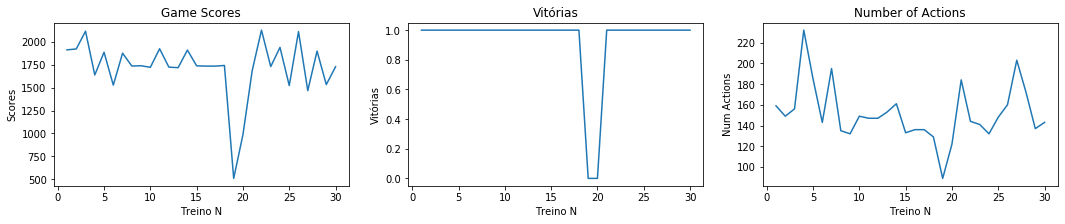

Wins:  28  Loss:  2
Avg Score:  1717.2666666666667
Avg NumActions:  151.73333333333332


In [40]:
printGraphs(gamesScores,results,numActions)

In [41]:
layoutType='originalClassic'
pacman.setIsTrain(False)
gamesScores, results, numActions = approxQLearning(pacman, layoutType,30,pacman.n_train)

layout:  originalClassic
------------------------------------------ train --------------------
Action Score:  [3.292020990504496, 3.2920188217393775]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.291909477224357, 3.2923588496692067, 3.231170625572977]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.292600426417089, 3.2311832044280813]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.292779762015441, 0.8030849653302606]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2929937638254385, 0.803236737040049]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.293333743561883, 0.8035150070634363]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.293477674214889, 0.8037290088734339]
W:  [[3.0

Action Score:  [2.0850020226895527, 2.0227856206140573]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.087296884399731, 0.5098901679008947]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.084491806188307, 0.5106664669144885, 2.090322454829723, 2.084491806188307]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.305446182837529, 3.233033431955933]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.3162412123222076, 0.808341399564696]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.3395638068878704, 0.8142053661983484]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.4061997913611934, 0.8250003956830267]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East

Action Score:  [2.639534981379478, 2.1578909239258817, 0.5829229328835118]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.686349094585562, 2.181037099302967]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.268129100091788, 0.5477811991790575]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.8499983399063686, 0.5854460353091672]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5853998652518979, 2.850039816598396]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.4871178819777784, 0.6931196323573908]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.2682268693480796, 0.5476834299227659]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  

Action Score:  [2.089381203344602, 0.508157684317614, 2.0831256753599843]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.095099146893042, 2.024722907469323]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.034152016301606, 0.5107020470183887]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5144132123022319, 0.5144132123022319, 2.1045821363472235, 0.5144132123022319]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.1045821363472235, 0.5144132123022319]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.5470714668000517, 2.095099146893042, 0.5201311558506717]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.085670038060759, 0.5201311558506717]
W:  [[3.04735653 1.4027604  2.01869448 0

Action Score:  [0.798985052650399, 0.19077807241719996]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2276566164984253, 0.349313234257348]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2886037470898613, 0.800133697470263, 0.7998076590560093]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2886037470898613, 0.800133697470263]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.800133697470263, 3.2886037470898613]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2876356677583294, 0.7994287971759505]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2862550193092117, 0.798460717844419]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3

Action Score:  [-0.00630097770638529, -0.005639870876591193]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.0070534897290022314, -0.006208906751075048]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.0077057376018611025, -0.00670830598227716]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.008274773476344957, -0.007148984364302348]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.008462249876950392, -0.00877417270754707]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.009214851089572259, -0.009214851089572259]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.00960566645457564, -0.012066876460928862]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTI

Action Score:  [3.2808964488305605, 0.7859965304565517]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2808964488305605, 0.7859965304565517]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2808964488305605, 0.7859965304565517]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.0011692175968115587, -0.000929151731287426]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.004255126719401706, -0.007965144919512605]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.006894186056909529, -0.000929151731287426]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.004255126719401706, -0.007965144919512605]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Sc

Action Score:  [3.296744741403827, 0.8058199882415922]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.298061832705308, 0.8064443837521449]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.300036503290589, 0.8073135331579993]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.8085666916665, 3.3031649858797296]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8104542490345812, 3.3084998109124903]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.319294840397169, 0.8134608943649275, 3.3019309439845257]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.3426174349628317, 3.2468477800267417]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3

Action Score:  [0.9092317281309741, 3.300557571773137]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.8425957436576512, 3.289762542288458]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.8192731490919882, 3.283898575654806]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8084781196073099, 3.2803627887235685]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8026141529736575, 3.27806792701339]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7990783660424199, 3.2764945773799923]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.07730859490336034, 0.17913726489769127]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.34553833630579295

Action Score:  [0.1183476024240587, 0.1183476024240587, 0.34606341765680815]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7955969928782238, 0.19155138986654405, 0.19231706076639224]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.224640238474244, 0.34970219720396006]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.286218945695393, 0.7991797115130292]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.8001226977248668, 3.2876198119037783]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8008469160361096, 3.288732363511293]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5060993207841901, 2.0841446372029826]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTI

Action Score:  [0.5069496797673033, 2.086379770439765]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5088158174975974, 2.0900393365245855, 2.083893321901117]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.1051940994699376, 2.029143805132172]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.1691367381180054, 0.5207892890306551]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.26730919650592627, 2.034861748680612]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5150713454822153, 0.5302722784848369, 2.090148849885735]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5303238776838594, 2.0902141531505185]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  We

Action Score:  [2.015630552523907, 2.077505474436304]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5020272668926884, 0.12466470354850609]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.015284476730137, 0.22165303347584875]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0759415924401496, 0.5009736013977794, 0.501609692072973]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5009736013977794, 2.0754866005218933]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5007281618151073, 2.075306265379212]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5003382743368415, 2.0750135918109334]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score: 

Average Score: 3489.0
Scores:        3489.0
Win Rate:      1/1 (1.00)
Record:        Win
------------------------------------------ train --------------------
Action Score:  [3.292020990504496, 3.2920188217393775]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2917882092024664, 3.2922599152441716, 3.2310716911479416]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.29241168695396, 3.2309525918911697]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.292591022552312, 0.8028543527933495]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.292805024362309, 0.8030061245031379]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2932519782652725, 0.803416072638401]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East

Action Score:  [3.0908595851979586, 0.3074141007004938]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.249263704527963, 0.7600887546140527, 0.7659194032554684, 3.1518826014427614]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.269784945379344, 3.1852233734568296]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.282668028623711, 0.7821833450988315]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2849628903338894, 0.7919197290764026]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7934930787098005, 3.288498677265127, 3.271358295012742]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.294362643898779, 3.2127060261314844]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588

Action Score:  [0.7771346493364394, 3.256855742604383]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7775257263616059, 3.257489059812187]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7847282280698968, 3.258321734262796]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7853615452777012, 3.2594471420005675]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7794845877276618, 3.2438756423380872]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7806099954654335, 3.2461705040482656]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2438756423380872, 0.7821833450988315, 3.2668511402753815]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3

Action Score:  [0.055406935314573455, 0.030314254385644505]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.07935139692680487, 0.04099680891804207]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.11901917227790652, 0.05655696071715369]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.1919775201377198, 0.08050142232938509]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.12016919768048676, 0.3494922367999421, 0.12016919768048676, 0.12016919768048676]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.1931275455403, 0.7993158269027814]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.3506422622025223, 3.227722981823608]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -

Action Score:  [0.5031699186612396, 2.079959137433886, 2.0781379097036097]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.5063377166445892, 2.017987829731978]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5025374833939338, 0.5039669692810438, 2.077505474436304]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5031699186612396, 2.0769952579350583]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5020272668926884, 2.076231607321573]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7978350272478187, 3.2881600025643096]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7978350272478187, 3.2881600025643096]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  Wes

Action Score:  [0.07224658948776819, 0.17893957562593293]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.33632471206350073, 0.11181770950635667]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7859965304565517, 0.1846645440860309]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2096242481687054, 0.33961513768594204]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.253523943380717, 0.7813964288462307, 0.7746867968455826]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.253523943380717, 0.7746867968455826]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.192576812789281, 0.3250149784525317]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action

Action Score:  [3.292600426417089, 3.2311832044280813]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.292779762015441, 0.8030849653302606]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.293075529122049, 0.8033356714650843]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.293333743561883, 0.8035150070634363]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.293477674214889, 0.8037290088734339]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2936604722999996, 0.8039872233132679]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2938970836757253, 0.8040944453609224]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2942102097586323, 0.8

Action Score:  [3.294905807589771, 3.2370042819363007]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2964791572231684, 0.8064816009036477]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.298774018933347, 0.8049082512702499]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.8064816009036477, 3.302309805864584, 3.2956565508175584]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.308173772498237, 3.2370042819363007]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.3189688019829156, 0.8123122495450634]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.3422913965485783, 0.8181762161787158]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  

Action Score:  [0.24052456897496477, 2.0619992820491104]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.26835008677499, 0.5479044166059682, 0.5480627459079193]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5856948569273084, 2.8501955000168144]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7691405195754888, 3.2109147797226716]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7217977439708876, 2.9503258668229364]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-3.5851009131701272, 0.45974643249382574]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.010132528262901674, -3.646113347026348]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action 

Action Score:  [2.076231607321573, 0.5020272668926884, 2.076231607321573]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [2.0160481273436224, 2.076231607321573]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5020272668926884, 2.076231607321573]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.501609692072973, 2.0759415924401496]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0759415924401496, 0.501609692072973]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0756961528574775, 0.5012636162792029]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0756961528574775, 0.5012636162792029]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [

Action Score:  [0.08205041541929373, 0.19418251587315016]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.3512073937439507, 0.12133568129347591]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.8004162947654234, 0.19382225730638292]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2280354783784837, 0.3507444763723725]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.798985052650399, 0.7998076590560093, 3.2889826089699197]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.798985052650399, 3.2889826089699197]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7994287971759505, 3.2893086473841735]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Sc

Action Score:  [-0.011394901559906334, -0.008071434511947011]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.011046700721644494, -0.007630756129921822]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.00713135689871971, -0.010655885356641113, -0.008071434511947011]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.006562321024235855, -0.010215206974615924]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.009715807743413811, -0.005910073151376984]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.009146771868929957, -0.007742011973454144]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.008494523996071085, -0.0111537932267536]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.

Action Score:  [-0.0042831300580899, -0.008494523996071085]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.0015815387842717929, -0.005157561128760042]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.0007786760565058051, -0.0014556966553476358, -0.0026057220579278643]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.0016984646292318665, -0.0004315133816915652]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.0020602944763873313, 0.000254341250525811]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.0021234861565702333, 0.0003178161801142597, 0.0003178161801142597, 0.004189352881840143]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-5.572248882578304e-06, 0.006828412219347967]
W:

Action Score:  [-0.07202261570670071, 0.14014718934030906]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.14014718934030906, -0.03245149568811223, 0.2975323257778769]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.04039533889156201, 0.7472041441709278]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.19778047532912982, 3.1754319634934025]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2363790940848385, 0.7472041441709278, 0.6474522937221807, 0.7472041441709278]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2363790940848385, 0.6474522937221807]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2363790940848385, 0.6474522937221807]
W:  [[3.04735653 1.4027604  2.01869448 0.47977

Action Score:  [3.291909477224357, 3.2923588496692067, 3.231170625572977]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.292600426417089, 3.2311832044280813]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.292779762015441, 0.8030849653302606]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.293075529122049, 0.8033356714650843]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.293333743561883, 0.8035150070634363]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.293477674214889, 0.8037290088734339]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2938687512400557, 0.8041587936479722]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.294

Action Score:  [0.501880556195904, 0.501880556195904, 0.501880556195904, 2.077665617555724]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5026009711808406, 2.078704922156824]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5031152013330692, 2.079466937648784]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0793373574241296, 0.5043693663817594, 2.081439937088849]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0193168576771523, 2.0829658429402738]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5078185162995519, 2.087544175124071]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.084785810613299, 0.5098178195709286, 2.091513554847748]
W:  [[3.04735653 1.4027604  2.01869448 0.47977

Action Score:  [0.5010890959102102, 2.076599725620133]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.05274135147087797, 0.12346813354547516]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.07746045406882911, 0.22154751604234663, 0.22112157493940024]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.5026392300154026, 0.12346813354547516]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.017128830275555, 0.2218935918361168]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0794680481992005, 0.5045000571568303, 0.503149446516648]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0804583872655282, 0.5037404050919267]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  AC

Action Score:  [-0.02712252506080376, 0.08510333723649667]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.003220911066288336, 0.1580017710151933]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.08510333723649667, 0.03639637900956939, 0.31544482161488796]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.10929481278826601, 0.7651819432727227]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.2667378633879607, 3.1934837675874057]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.237212043890755, 0.7164749850457954, 0.7653402725746737]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7165489900380035, 3.137394890177224]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   - 

Action Score:  [2.078934960323414, 0.5039669692810438, 2.081305707686959]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.01901200684245, 2.0831256753599843]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.508157684317614, 0.1359079971894984]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0203585770955232, 0.2303278136015491]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.078934960323414, 0.5039669692810438, 0.5063377166445892]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5049911463915161, 2.0781379097036097]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7981641799730343, 3.288780928963088]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  Sout

Action Score:  [0.789286956078993, 3.2827481183168734]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.789286956078993, 3.2827481183168734]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.789286956078993, 3.2808964488305605]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2751714803704624, 0.789286956078993]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7859965304565517, 3.2638617467594933]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7746867968455826, 3.2363790940848385]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7472041441709278, 3.2048169851537898, 0.6474522937221807]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  

Action Score:  [0.11717627998500836, 0.34878889945136804]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.19140376301380022, 0.7994287971759505]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.3497569787828996, 3.2283615167927375]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8006628390711542, 0.800133697470263, 3.289837788985065]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8006628390711542, 3.2902450933271616]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.0035777354247204757, -0.003158910346352466]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.0027182319643272775, -0.003229534586458635]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East

Action Score:  [0.07224658948776819, 0.0665216210276702, 0.1846645440860309]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.11181770950635667, 0.1060927410462587, 0.34204968052359874]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7917214989166497, 0.17893957562593293, 0.1846645440860309]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2199493182391246, 0.33632471206350073]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2808964488305605, 0.7917214989166497]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7917214989166497, 3.2751714803704624]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7859965304565517, 3.2638617467594933]
W:  [[3.04735653 1.4027604  2.01869448 0.4797790

Action Score:  [3.288747998835289, 0.8007101237742035]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2864771601352274, 0.7993590471113812]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.288226755789535, 0.7984780904480799, 0.7984780904480799, 0.7951196694450712]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.288617832814702, 0.7953778838849053]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2891107025223443, 0.7956933848726158]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2893979439363785, 0.7955742453965369]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2902306183869876, 0.7960671151041797]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTIO

Action Score:  [2.0203410347876245, 0.22887138534115511]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.507537164365109, 0.5051664170015636, 2.081439937088849]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5076667445897635, 2.084785810613299]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5078185162995519, 2.087544175124071]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0873301733140734, 0.5123621822717034, 2.097231498396188]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.036026153364918, 2.1244873103332784]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5317464968079998, 2.162594822687577]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West

Action Score:  [2.077528345810845, 0.5025603547684749, 0.5037818817839538]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0770769329469854, 0.5031079698246209]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.076410126705978, 0.5021427799487596]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.076136721349863, 0.5017628661108449]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5011966960809353, 2.0761111866708064]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.288995403488398, 0.8002482275483949]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.288973947003602, 0.8005487312835916]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  

Action Score:  [0.7486849438258905, 3.2382532311481507, 3.138108043291054]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [3.177092098746717, 3.2659940982626394]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7765609339088948, 3.277619332861319]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7881288819596979, 3.2837353783465835]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7941693514075063, 3.2860799175405395]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7945604284326728, 3.286713234748343, 0.7978531321860547, 0.7978531321860547]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7950532981403158, 3.2875459091989523]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77

Action Score:  [0.798460717844419, 3.2886037470898613]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.798460717844419, 3.2886037470898613]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.798460717844419, 3.2886037470898613, 3.2886037470898613]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [3.2266885371668934, 3.2886037470898613]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.798460717844419, 3.2886037470898613]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.798460717844419, 3.2886037470898613]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7994287971759505, 3.2893086473841735]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score: 

Action Score:  [-0.006031884201639685, -0.006192254213668577]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.006350009287023332, -0.006350009287023332]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.006031884201639685, -0.006192254213668577]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.005887091915445098, -0.005887091915445098]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.005671625634872472, -0.0057293368420903434]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.005887091915445098, -0.005887091915445098]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.006031884201639685, -0.006192254213668577]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   - 

Action Score:  [-0.012238730157384654, -0.010089898886758817]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.012467075472031696, -0.010278617044013134]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.012674349731452919, -0.010450929731435334]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.012863067888707235, -0.010608684804790087]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.010753477090984674, -0.010450929731435334]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.010278617044013134, -0.008931276804628052]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.009076069090822638, -0.010450929731435334]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTI

Action Score:  [-0.006031884201639685, -0.0057293368420903434]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.005557024154668145, -0.005887091915445098]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.005368305997413829, -0.0057293368420903434]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.0051610317379926045, -0.005557024154668145]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.005395603794923796, -0.005368305997413829]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.0051610317379926045, -0.005557024154668145]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.005395603794923796, -0.005368305997413829]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -

Action Score:  [0.001072774032631633, 0.006094336136937744]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.0028152523289047045, 0.008209060668465573]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.00557000133095775, 0.010154387207462246]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.006828412219347967, 0.01236226090493621]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.008088520482192336, 0.014688596733457668]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.02228305411076252, 0.010921226637867355, 0.01236226090493621]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.032900305378376224, 0.01798130048683946]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  A

Action Score:  [2.0879234662420636, 0.5083229456151822]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.089048873979835, 0.5089562628229866, 2.085882336053737]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0931665863140076, 2.0251563679776026]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.095461448024186, 0.5122609152644401]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.090622223613233, 0.5156542325708628, 2.0964528722546487, 2.0968777515978507]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.031969954731975, 2.095304401964453]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5181985952716376, 2.0998969377751213]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.775880

Action Score:  [0.5160733475555466, 2.1067144878503696]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5220052929139839, 2.1244873103332784]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.522263507353818, 2.124878387358445]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.16308769239522, 0.5320619977957103]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.163721009603024, 0.5324530748208768]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.272314927851153, 0.5504032660237178]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5510365832315222, 2.271482253400544, 2.2734403355889246]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.

Action Score:  [2.105489091145348, 0.5155011467426127]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.1228724076483383, 0.5211224349585393]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.1228071043835546, 0.5210381106487963]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.1604656255505597, 0.53044709511077]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5303817918459862, 2.1604140263515372]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5477811991790575, 2.268129100091788]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5477295999800351, 0.6931196323573908, 2.1226975910224053]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  

Action Score:  [-2.4031066786913615, -0.032010927195726624]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.07155408144087266, -2.5012142829724637, -0.07160758189337205]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.09538350317754718, -2.546609374106935]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-2.571254340874174, -0.11083581194030609]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.5861006254488457, -0.12141566465301919]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.595722532688189, -0.12137418796099218]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.11071076663610924, -2.602305081311186]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION

Action Score:  [-0.0060932212787064175, -0.005076087111823311]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.004032163448318394, -0.007409754987160567]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.0028005175253246256, -0.006517121378892165]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.004625720485208786, -0.005473197715387248]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.0060932212787064175, -0.00863158806382526, -0.006044309184857893]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.010350688945306757, -0.007226532849612817]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.011769277644955861, -0.008220000557454978]
W:  [[3.04735653 1.4027604  2.01869448 0.4797

Action Score:  [0.5296141453048535, 2.1597558931715537]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5470714668000517, 2.2675171369690736, 2.1220394578424218]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.8494278534756816, 2.0988087625801177]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.895954647320578, 0.5847879021291837]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [1.3394392426512023, 0.2686233050004421, 0.41217491250986404]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.08074517566121128, 0.19217236928862205]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.11893564723068216, 0.1172596679836779, 0.3491676182479242]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 

Action Score:  [0.5089906341235305, 2.0903724824524694]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5116090018165134, 2.0961870813334227]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5116933261262563, 2.096298594613562]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5155011467426127, 2.1059111642923978]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0908620029995646, 2.090580651065122, 0.5156126600227517, 2.1057815840677434]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0354810442467803, 2.1231273922828025]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5213306035711915, 0.5213306035711915, 2.123030736950289]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.7758809

Action Score:  [0.9135179404549436, 3.308448099005899]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8450302864953079, 3.294362643898779]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8159827234695469, 3.2771889436541577]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7938779603738996, 3.2461705040482656]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2438756423380872, 3.2438756423380872, 0.7605313410655923, 3.1441237918893403]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2423022927046894, 3.0854715230080823]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2438756423380872, 0.6549488419754296]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION: 

Action Score:  [-0.01071009456922098, -0.12121850454257369]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.004860376547425542, -0.12115320127778983]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.02881716918242713, -0.11046194501796805]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.06849980248115464, -0.09489147390132152]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.14147621728548337, -0.07093468126631994]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.031252047967592414, 0.06849980248115464, 0.29901312543283964]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.04172436683673632, 0.7488642794242424]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  AC

Action Score:  [2.07711077099113, 0.5015855645204935]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0771481695460303, 0.5015440878284665]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5017967041549894, 2.0776072210577725]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.50183410270989, 2.077653391115042]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.05362288172874376, 0.12474200066020609]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.07834198432669491, 0.0792697756476557, 0.22200310519726604]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.12423178415896069, 0.5020965660851194]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Sco

Action Score:  [2.089381203344602, 0.5296141453048535]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.089381203344602, 0.5296141453048535]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5201311558506717, 2.085670038060759]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5201311558506717, 2.085670038060759]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5144132123022319, 2.0831256753599843, 2.0831256753599843]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0831256753599843, 2.028434072753166]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.081305707686959, 0.5107020470183887]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2

Action Score:  [0.034751974864689165, 0.07409825897408112, 0.030465762540719567]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.11511041325973845, 0.050238121671592695]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.18651621357234383, 0.07668270981877522]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.11181770950635667, 0.33961513768594204, 0.1136693789926696]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.7813964288462307, 0.18223000124837424]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.192576812789281, 0.3317246104531798]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2048169851537898, 0.7472041441709278, 0.7643489934668062]
W:  [[3.04735653 1.4027604  2.01869448 0.479

Action Score:  [2.075859690337631, 0.5005378857613509]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0760739119203446, 0.5007037339485465]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0761392151851283, 0.5007553331475689]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5011059208779742, 2.076603107655602]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5013515592854396, 2.076932871548017]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.501880556195904, 2.077665617555724]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5022548953870705, 2.0781947056555783]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5031152013330692, 

Action Score:  [0.58692025363233, 2.852266782991705]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.8527596526993477, 0.5872357546200405]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [4.510179999810114, 0.695388075442727]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.292070062432002, 0.7985080274517158]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7992976520801067, 3.288862489472283, 3.293015135027092]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.228748033331456, 3.2945884846604896]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8014360694111688, 3.2967270389500816]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.29

Action Score:  [0.896423181586406, 0.5853209900049703]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.2691225548320841, 1.2979948227887788, 0.412674162341506]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.08045616216811087, 0.12450080254702832]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.11905802289290104, 0.07968464622736368, 0.2221522833074907]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.12513323781433414, 0.5025603547684749]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.3498002104113885, 3.228909160130268]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.289818892166804, 0.7995058668485839, 0.8007228174998207]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.775

Action Score:  [0.7838442813370875, 3.256855742604383]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7671879229828295, 3.2087821015852596, 0.7671879229828295, 0.7671879229828295]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.718973834463545, 2.9465972016104613]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7196071516713494, 2.947722609348233]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7204398261219581, 2.949295958981631]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7215652338597298, 3.2107401837736402, 2.947722609348233, 3.2146083951172164]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.1513664028156025, 3.2668511402753815]
W:  [[3.04735653 1.4027604  2.018694

Action Score:  [0.7998076590560093, 3.2881600025643096]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.798985052650399, 3.2870099771617296]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7978350272478187, 3.285332569161567]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7961576192476567, 3.2827481183168734]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7935731684029625, 3.278461905992904]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.789286956078993, 3.2705713787601414]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.253523943380717, 0.7813964288462307]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2048169851537898, 0.

Action Score:  [0.7156420352398789, 3.2048169851537898, 0.4526244608144716, 3.2048169851537898]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [2.8808522801369465, 3.2048169851537898]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.4526244608144716, 0.1085850804092602]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-3.656459770793927, 0.002952642421420709]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.4526244608144716, 0.1085850804092602]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.8808522801369465, 0.265970216846828]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.4526244608144716, 0.7156420352398789, 0.7156420352398789, 3.2048169851537898]
W:  [[3.04735653 1.4027604  2

Action Score:  [2.083958625165901, 2.0902141531505185, 0.5091489634254815]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.105489091145348, 2.0293410275512906]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.123030736950289, 0.5209641056565882]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.2686050714094543, 2.1229464126405464, 0.5479784215981763]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.8506273011962016, 2.099800041687985]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.78980975082942, 0.5858758365695645]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2970010945990262, 0.6937485936472235, 0.6937485936472235, 0.6937485936472235]
W:  [[3.04735653 1.4027604  2.01869448 

Action Score:  [2.076599725620133, 0.5023773386141057]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0763081159801917, 0.5019733486582088]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0762666392881646, 0.5019217494591863]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.07601968839768, 0.5015855645204935]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0760570869525803, 0.5015440878284665]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.075918228501926, 0.5012612496908938]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.021244941448010483, 0.013308453554997463]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.0163072546946

Action Score:  [3.2945269457097117, 0.8082521278078458]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2968051956374222, 0.8069253454291994]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.299629198948492, 0.8060568960901139]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.8081593873244031, 3.297334337238314, 3.303572290221826]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.239089372699153, 3.3097564479803756]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.814717531432813, 3.3208077357969716]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8205814980664654, 3.3441303303626344]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [

Action Score:  [2.085670038060759, 0.5063377166445892]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.095099146893042, 0.5107020470183887]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5144132123022319, 2.1045821363472235]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5201311558506717, 2.1220394578424218]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5470714668000517, 2.1220394578424218, 2.2675171369690736]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0988087625801177, 4.510544676424727]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2915642595074397, 0.8022377958815472]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:

Action Score:  [0.040986465517735854, 0.02195215046720697]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.056798650738893106, 0.03036921425012215]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.0406076036376771, 0.08065878804138152, 0.041312503931989576]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.12022990805997001, 0.05609375044458063]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.19307674263964425, 0.07995388774706905]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.11952500776565753, 0.35046187907721205, 0.11952500776565753]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.800133697470263, 0.19237184234533178]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096

Action Score:  [0.5306054244127211, 2.1609553408920736]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5858758365695645, 2.850756881420856]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0965799465480046, 2.096298594613562, 0.5213306035711915, 2.1232389055629417]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.044964033700962, 2.1608438276119344]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5859873498497036, 0.5308135930253733, 2.105573415455091]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5481594012404325, 2.0960061016911666]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5211224349585393, 2.0865029878666754]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096

Action Score:  [0.8036541675009055, 3.300337174056394, 3.2937515675624605]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.3073511660926265, 3.2358542565337203]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.3189688019829156, 0.8123122495450634]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.342900032257992, 0.8189988225843262]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.409536016731315, 0.8297938520690046]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.768761697177844, 0.8531164466346676]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.20027752167910887, 0.5076211707147867]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  

Action Score:  [0.5168610647930887, 2.0864574745836504]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5109966138336373, 2.0839242538653564, 0.5078300759075394, 0.5078300759075394]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5096695158682553, 2.0847569283159655]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5079320857125142, 2.08722890630681]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.508764760163123, 2.088802255940208]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.510914345011367, 2.089048873979835, 2.085882336053737, 2.0897505473973133]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.026508555095699, 2.0964528722546487]
W:  [[3.04735653 1.4027604  2.01869448 

Action Score:  [0.7978350272478187, 3.2881600025643096]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7978350272478187, 3.2881600025643096]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7978350272478187, 3.2881600025643096]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7978350272478187, 3.2881600025643096]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.798985052650399, 3.2889826089699197]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7998076590560093, 3.2889826089699197]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8004162947654234, 3.2889826089699197]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8004162947654234,

Action Score:  [-0.010765722758635412, -0.010129609953097533]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.008919420514900162, -0.01904432045951582]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.005040754298537441, -0.010129609953097533]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.00463320819093056, -0.0031921739238617063, -0.0032982760022643703]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.00584339762912793, -0.001748050545155649]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.0020487573462364588, -0.00463320819093056, -5.572248882578304e-06]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.003189084812224503, 0.0021234861565702333]
W:  [[3.04735653 1.402760

Action Score:  [3.278461905992904, 0.7813964288462307]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.789286956078993, 3.2827481183168734]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7935731684029625, 3.285332569161567]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7961576192476567, 3.2870099771617296]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7978350272478187, 3.2881600025643096]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.798985052650399, 3.2881600025643096]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.012059370462559848, 0.004944310734357516]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.017155717290914

Action Score:  [3.2957609876049156, 0.8050352598447217]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2968051956374222, 0.8054606299532334]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.298395157053288, 0.8060568960901139]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.8069253454291994, 3.300962864652994]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8082521278078458, 3.305446182837529]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.3162412123222076, 0.8104072662899658, 3.2975163494786064]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.3395638068878704, 3.242433185520823]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score: 

Action Score:  [0.5057587929326488, 2.084032630158109]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.2267964330336661, 2.0257141865771904]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0960061016911666, 0.5116090018165134, 0.5116090018165134, 0.5117899814587695]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.10541508615314, 0.5154044914100995]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.1605235397126865, 0.5305211001029781]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.22012735941479256, 0.09930564313902485]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.22984101886040753, 0.2134558130378726, 1.2402970666378805]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.

Action Score:  [0.8181762161787158, 3.3422913965485783]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8289712456633942, 3.4089273810219014]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.768761697177844, 3.3422913965485783, 0.8522938402290572]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.4939819155751133, 3.3479802504304654]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [1.2801953829733477, 3.342900032257992, 0.8531164466346676]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.9203610668174045, 3.319294840397169]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.8534424850489213, 3.3077949106181777]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:

Action Score:  [0.03896566132602991, 0.017793023419075026]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.054345477982459964, 0.025199955375834658]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.03549262242996656, 0.038492652615069914, 0.07799726602641294]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.050896466808491456, 0.11780140752520632]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.07813363217410466, 0.19316226467355777]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.12140423012018056, 0.3522671821204818, 0.12002358167106295, 0.12140423012018056]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.19475246545825947, 0.5027444159341656]
W:  [[3.04735653 1.4027604  2.018

Action Score:  [0.5296141453048535, 2.1597558931715537]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5470714668000517, 2.1220394578424218, 2.2675171369690736]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.2065700063776377, 3.29347915403795]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.4997266599836857, 2.0745365422092292]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.499643215671884, 2.0744694676404847]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.499643215671884, 2.0744694676404847]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.4995685511668593, 2.0745365422092292]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0

Action Score:  [-2.501629316785792, 0.19778047532912982, -0.03245149568811223]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.6474522937221807, -2.501629316785792]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.0756801130446556, -2.4034983350898984]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.6474522937221807, 3.1366272436360916, -2.1231241016730587]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-2.1231241016730587, 3.1366272436360916]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-2.1231241016730587, 3.1366272436360916]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-2.1231241016730587, 3.1366272436360916]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   

Action Score:  [0.8539716266498125, 3.770024181535086]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.4936202652785737, 0.4709357927300844]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0756036460600127, 0.5005378857613509]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.075917604499758, 0.5005840558186202]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0761392151851283, 0.5007553331475689]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5011059208779742, 2.076603107655602]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5015611116210238, 2.0772228864294404]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.501880556195904,

Action Score:  [0.05237063229117357, 0.11338287129133943]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.2718934154666789, 0.08841032048798368, 0.09036840267636415]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7231385834931278, 0.16208982951826673]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.1536612645257804, 0.32060037369360617]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.20007336104253, 0.771845541720055, 0.7289692321345435, 3.261020491633966]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7741404034302332, 3.2764945773799923]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7888929770994796, 3.2832596968749828]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0

Action Score:  [0.8022432058802529, 3.2909866584027316]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.079443110425915, 0.5044751193835452, 2.081469708927276]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.020029708628197, 2.0839242538653564]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5072987685047099, 2.0861034985690385]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0852708241184295, 0.5103028330760596, 2.09159323668061]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.026976335650627, 2.0968777515978507]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5203364109220828, 2.1143735463106506]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West


Action Score:  [0.5058240961974326, 2.0788476420826156]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5057587929326488, 2.0789055562447425]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0783384242422205, 0.5046767016600496]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0784124292344286, 0.5047346158221765]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.018531870656257103, 0.013347959987686767]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.016086678768567297, 0.024506387032805887]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.019042087157502503, 0.032034898110646665]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.

Action Score:  [0.5063377166445892, 2.078934960323414]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5063377166445892, 2.078934960323414]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5049911463915161, 2.0781379097036097]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0781379097036097, 0.5049911463915161]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.077505474436304, 0.5039669692810438]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.078934960323414, 0.5039669692810438]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5031699186612396, 2.079959137433886]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5049911463915161,

Action Score:  [-0.007103437282632086, -0.007103437282632086]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.007236649046055074, -0.007781251402047825]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.007926043688242412, -0.007926043688242412]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.0080592554516654, -0.008931276804628052]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.009076069090822638, -0.009076069090822638]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.00920928085424563, -0.010608684804790087]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.010753477090984674, -0.010753477090984674]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACT

Action Score:  [0.01798130048683946, 0.032900305378376224]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.025575757864144316, 0.04838645218527976]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.07224658948776819, 0.03619300913175802]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.11181770950635667, 0.05167915593866155]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.1846645440860309, 0.07553929324114997]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.11181770950635667, 0.11511041325973845, 0.3453423842769805]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.1846645440860309, 0.7950142026700314]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  Wes

Action Score:  [2.1062178003345684, 0.515354463787353]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.129250380018808, 0.52080085560129]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.195640924909459, 0.5312498092921982]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.555475241065402, 2.1290049404361358, 0.5545724038578612]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.4943185581383815, 2.1349392339006945]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.07601968839768, 0.5015855645204935]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.075805515210854, 0.5012986482457944]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5

Action Score:  [0.5058240961974326, 2.080668869812892]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5047346158221765, 2.082073354228092]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0865029878666754, 0.507047449023595]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0902881581427266, 0.5089253308587467]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.05747390552180422, 0.03549469603933394]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.04128664457998186, 0.08468362763300372]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.07493122701700244, 0.24514982018028003]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.122400062

Action Score:  [0.015157130999285718, 0.0367260970075446]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.026075007695786273, 0.05224964236934874]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.0367260970075446, 0.07285855261048237]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.04895693861596695, 0.10675087422624213]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.0671335841503844, 0.16824180513767806, 0.0671335841503844, 0.1068024734252645]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.09544114061527308, 0.29810281220856405]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.14075915246302326, 0.6480642568448949]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.775880

Action Score:  [0.750535943394594, 3.1414250345181705]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7511692606023983, 0.7511692606023983, 3.142550442255942]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7520019350530069, 3.1441237918893403]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.142550442255942, 3.142550442255942, 0.6533754923420316, -0.5383647006672616]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.1414250345181705, -0.6016066929688759]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.1405923600675614, -2.1172009030532077]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2397108933085046, 0.6522500846042599]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77

Action Score:  [-0.008009518010091133, -0.011376896331424932]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.014660516739881616, -0.014660516739881616, -0.012652389034406158]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.013734486470189104, -0.011376896331424932]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.012652389034406158, -0.009858767960510792]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.005651927871326963, -0.011376896331424932, -0.008031965354494729]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.009858767960510792, -0.006927420574308189]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.011376896331424932, -0.008009518010091133]
W:  [[3.04735653 1.4027604

Action Score:  [2.078934960323414, 0.5039669692810438, 2.081305707686959]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.081305707686959, 2.017987829731978]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.12965246920488047, 0.5049911463915161]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.2246169129746764, 2.0171907791121737]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.077505474436304, 0.5025374833939338, 0.5039669692810438]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0765776831153433, 0.5025374833939338]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.02348683425266184, 0.028895748001771495]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:

Action Score:  [3.291909477224357, 3.2923588496692067, 3.231170625572977]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.292600426417089, 3.2311832044280813]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.292779762015441, 0.8030849653302606]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2929937638254385, 0.803236737040049]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.293333743561883, 0.8035150070634363]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.293567479252983, 0.8038188139115279]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2937698168150202, 0.804077028351362]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2942

Action Score:  [2.0856344579568584, 2.090322454829723, 0.5095238151459373]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.3068268312866467, 3.2350992986812033]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.3185899401028562, 0.8117879147390834]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.3426174349628317, 0.8186199607042675]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.409253419436155, 0.8294149901889458]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.7683828352977855, 0.8527375847546088]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.46970175083488064, 2.4950635649380613]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:

Action Score:  [3.2966234733819366, 0.8057210538165568]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2981968230153345, 0.8065537282671655]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.3002058305811066, 0.8074485234680261]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.809021873101424, 3.303741617512344]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8110308806671958, 3.309245325579229]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.3200403550639077, 0.8142064090316662, 3.3029184415739987]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.3437232081963377, 3.248298194987793]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score: 

Action Score:  [0.5861169300743581, 2.8505157879160623]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.850419132583549, 0.5859873498497036]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2948631584377788, 0.6936370803670845]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0759829077645415, 0.5011732460241224]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2916793537503937, 0.8029168094167478]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.0430767032623567, 0.03299489614768776]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.05765268489985553, 0.032115179227442184, 0.03222469258859143]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Sc

Action Score:  [3.1852233734568296, 3.28305291028781]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7880139937402472, 3.305157673383458]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8051876939848686, 3.3342052364092183]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8217076919296449, 3.4041339246359232]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.7651116573694914, 3.3395638068878704, 0.8483229902486897]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.4963374320527922, 3.344330210622113]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [1.275936707455581, 3.3386413567402258, 0.8468819559816209]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  So

Action Score:  [2.0145151669757526, 2.0758008684791314]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5006532664256317, 0.1225316647636972]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.014431722663951, 0.22035303800100015]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.075246274588235, 0.5003529480508898, 0.5005596097896022]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.500336197707992, 2.075067121263902]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5002782835458651, 2.075020951206632]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5001596097780978, 2.0749247528840398]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  

Action Score:  [3.2885516589628465, 0.7982266836463559, 3.288600571056695]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.226477880383622, 3.288628536830138]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7982755957402043, 0.19242734765142216]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2248004723834605, 0.34863174312059586]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.285724225560104, 0.7939648248014997, 0.7965981877400423]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7939882022162912, 3.285702769075308]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7939648248014997, 3.285683028685459]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  S

Action Score:  [-0.012001802212590616, -0.01573319757268552]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.011738538087574088, -0.011738538087574088]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.009417351367896514, -0.011446985248715921]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.009154087242879987, -0.009154087242879987]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.007739943367734479, -0.00886253440402182]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.007476679242717952, -0.007476679242717952]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.007739943367734479, -0.00886253440402182]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACT

Action Score:  [0.010319871500198367, 0.02213115300980105]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.029877382096894327, 0.014705125203081267, 0.014705125203081267, 0.016382533203243302]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.038996560962697886, 0.02213115300980105]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.0521122587349049, 0.02819997409673229]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.07194439815325784, 0.036412110118003785]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.11183101915955676, 0.047826046410935304, 0.03993551917817308, 0.047826046410935304]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.18506893076439745, 0.06405387092049562]
W:  [

Action Score:  [3.2932737638156437, 0.8035017685871775]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.29340153797194, 0.8034654966939291]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2935588663781807, 0.803393913607421]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2937515675624605, 0.8032585087264981]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.293980562547369, 0.8030032680151522]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.8025107509232803, 3.294223645725225]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8015129088800765, 3.294362643898779]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.305157673383458, 0.7

Action Score:  [0.5004943065248184, 2.0758008684791314]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0761412370664925, 0.5007588724445533]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0763941998195925, 0.5009525555666877]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0768956005779975, 0.5013295534447091]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.077270620385324, 0.5016065439199039]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0777124069765356, 2.0768956005779975, 2.0768956005779975, 0.5019276095356271]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0778917425748875, 2.0160780502112154]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION: 

Action Score:  [3.257489059812187, 0.7196071516713494, 0.7702721920866571]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7204398261219581, 3.256855742604383]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7196071516713494, 3.25636287289674]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7676807926904723, 3.273019231250998]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.28059425749605, 0.784235358362254]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.284622255380185, 0.7917348085698497]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.036412110118003785, 0.02626707510022179]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [

Action Score:  [0.5089253308587467, 2.0902881581427266]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5115349968243053, 2.0960904260009094]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0960061016911666, 2.0960061016911666, 0.5210381106487963, 2.1231273922828025]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.044626284863655, 2.1609553408920736]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5858758365695645, 2.850756881420856]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2874839587409563, 0.8001722266933173, 3.2896285285416704]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.228529626240446, 2.0791656096896185]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.7758809

Action Score:  [0.7969252657887893, 3.2879169319598542]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7969905690535732, 3.288001256269597]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7987419820459434, 3.2864205036019483]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7947726161234824, 0.7971488983555242, 3.286532016882087]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.3449892844502924, 3.2257144665153055]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7950539680579253, 3.286532016882087, 0.7947726161234824, 0.7973570669681764]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7949021963481369, 3.2864205036019483]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.775880

Action Score:  [0.07712327831116082, 0.19127732224884192]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.11672236410319176, 0.11672236410319176, 0.34869629673055436]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.1895999142486799, 0.7984055136785058]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.3470188887303923, 3.226674809693008]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.798493160427802, 0.7967281056783437, 3.2876681103417127]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7967695823703709, 3.2877197095407356]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.006473223718736274, -0.004686302357424996]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   - 

Action Score:  [-0.04004859006537552, -0.023001154685950966]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.04039755261639124, -0.022611477155662127]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.04004859006537552, -0.022174491733389496, -0.023001154685950966]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.021682214152341936, -0.039658912535086674]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.02112490075901295, -0.039221927112814046]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.02049056161974524, -0.03872964953176649]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.019764308754678286, -0.0381723361384375]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.7758

Action Score:  [0.1833777541408922, 0.07508790304977263]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.10255694801665402, 0.3408565472144895, 0.11044747524941625]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.7905283656075404, 0.17540378259632827]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.218861790948937, 0.3328723633456978]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2796096588854216, 0.790633971626462, 0.7904347089715109, 0.7825441817387486]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.27952621457362, 0.7826378383747782]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2793844754998505, 0.782460737426947]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.775

Action Score:  [2.0904678289428382, 0.5096695158682553]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.095304401964453, 0.5121228007490845, 2.089048873979835]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.1025956951462907, 2.0295206983514023]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.131830867805849, 0.5260543544705226]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.1672524414248024, 0.5371106935581024, 2.117909333241888, 2.112078684600472]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.1656790917914046, 2.0534264157192146]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.2750136852223224, 0.5545680150533006]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.775

Action Score:  [0.8511438148264769, 3.3073511660926265]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.827821220260814, 3.300337174056394]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2951239791249947, 0.8170261907761356]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.290244666570122, 0.8094848161423212]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2843851046127543, 0.8033645783663895]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2753691696422207, 0.7967835043322418]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2594471420005675, 3.2745364951916116, 0.7873196274660816]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  

Action Score:  [3.289737977415059, 0.7992536156510754]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2898635692698317, 0.7990798509484832]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.8004266613534563, 3.29080368282792]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.8015003912668657, 2.075901634335222, 3.2913267410225897]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.228802085285123, 3.290229445383602]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8010778728844828, 3.2906152932409025]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8014617998117883, 3.290915743975951]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8

Action Score:  [3.2221514472493293, 3.285724225560104]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7965278191613974, 0.19119310623052865]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.224735898094023, 0.34855486525330487]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.7965278191613974, 3.2873422341480225, 0.7982052271615594]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7981854867717104, 3.2884754391772013]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7993173096366926, 3.2892824709000497]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.8001230956689007, 3.289876657581302]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score

Action Score:  [0.7901939108771177, 3.283515764858006]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.009902506957470952, 0.024967673402991997]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.03565892966281379, 0.015456243274590345]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.05122940077946031, 0.023116003916679055]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.0708999810904923, 0.03380726017650085]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.1026920871564576, 0.04694318845549071]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.15862106658136177, 0.06300945385773007]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.

Action Score:  [2.1045821363472235, 0.5144132123022319]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.1220394578424218, 0.5201311558506717]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5470714668000517, 2.2675171369690736]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.8494278534756816, 0.5847879021291837]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.1597558931715537, 0.5296141453048535]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [5.896784383047484, 0.5847879021291837]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Pacman emerges victorious! Score: 3457
Average Score: 3457.0
Scores:        3457.0
Win Rate:      1/1 (1.00)
Record:        Win
------------------------------------------ 

Action Score:  [0.5006812167478968, 2.0760570869525803]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5010516973553096, 2.076553555562864]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5012986482457944, 2.0768897405015565]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5013401249378214, 2.076941339700579]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.077345329656476, 0.5016317345777628, 2.0767092389812825]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [2.015704194227719, 2.07741063292126]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5020312628203356, 2.077902212733183]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.

Action Score:  [3.2350992986812033, 3.3068268312866467]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8104072662899658, 3.3176218607713253]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8176518813727358, 3.341912534668519]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8289712456633942, 3.4089273810219014]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.767939090772234, 0.8522938402290572]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.19945491527349854, 0.5082572613899804]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.03874588158825838, 0.023495749704125095]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.05323532924

Action Score:  [0.01844983475266751, 0.0367260970075446]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.026075007695786273, 0.05224964236934874]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.0367260970075446, 0.07615125636386416]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.05224964236934874, 0.1157685464397219]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.07615125636386416, 0.1906350776873968, 0.07821712308913406, 0.11582014563874427]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.1157685464397219, 0.3479787374329376]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.1885692109621269, 0.7976920325180155]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]

Action Score:  [0.22165303347584875, 2.015284476730137]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0759415924401496, 0.501609692072973, 0.5009736013977794]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5009736013977794, 2.0754866005218933]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5007281618151073, 2.075306265379212]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5003382743368415, 2.0750135918109334]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0750135918109334, 0.5003382743368415]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0748939136810067, 0.5001819669162548]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:

Action Score:  [-0.012028224297423744, -0.009146771868929957]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.009715807743413811, -0.008494523996071085]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.007742011973454144, -0.009146771868929957]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.006867580902784001, -0.008494523996071085]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.00584339762912793, -0.007742011973454144]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.006867580902784001, -0.00463320819093056]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.00584339762912793, -0.003189084812224503]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:

Action Score:  [3.2363790940848385, 0.7472041441709278, 0.6474522937221807]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.6474522937221807, 3.2363790940848385]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7472041441709278, 3.2638617467594933]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7746867968455826, 3.2751714803704624]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7859965304565517, 3.2808964488305605]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7917214989166497, 3.284189152583942]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [6.331545682155744, 0.7950142026700314]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Pacman emerg

Action Score:  [0.5041611977691072, 2.0793373574241296]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0800228947637946, 0.5036254178343146, 2.0788345023814783]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.082505155407479, 2.019187277452498]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5060790808318969, 2.0844547033051586]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5093571320381338, 2.0908620029995646]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.512031074963563, 2.0967592821463565]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.123913594905734, 0.5216119555056344]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  

Action Score:  [0.5210381106487963, 2.0867579725011396]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.507537164365109, 0.5116933261262563, 2.086869485781279]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.33741264650388153, 3.2042436441132316]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.265342546414456, 0.7484035918914476, 0.7758862445661024, 0.7758862445661024]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.265521882012808, 0.7485331721161022]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2657358838228054, 0.7486849438258905]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2659940982626394, 0.7488642794242424]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.7758

Action Score:  [0.5479044166059682, 0.5477811991790575, 2.2682268693480796]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.6933167924678364, 3.302726420368688]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5114117793973946, 2.0819176708096734]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5113601801983721, 2.0818761941176462]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5087696474403282, 2.0804922253096727]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.080529623864573, 0.5087281707483011]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.079546923446128, 0.5068708045203757]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  

Action Score:  [3.2123135334070385, 0.7691467843488854]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.951590820691809, 0.7215652338597298]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-3.588016091949241, 2.955126607623047, 0.46012100906772047]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.960990574256699, -3.6466683608304997]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2348031781667848, 0.46595165770913616]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.306832730959375, 0.7348331987681959]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.3905161508121227, 0.7943351864798015]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  

Action Score:  [0.0283965824419316, 0.013505677482561457, 0.015183085482723492, 0.015183085482723492]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.0390138337095453, 0.019124717064464707]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.05449998051644883, 0.026719174441769564]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.07836011781893726, 0.03733642570938327]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.11793123783752574, 0.052822572516286796, 0.05449998051644883, 0.05449998051644883]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.19077807241719996, 0.07668270981877522]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.3481632088547678, 0.11625382983736371]
W:  [[3.0

Action Score:  [-0.02472976918650789, -0.010765722758635412]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.02351957974831052, -0.012209846137341468, -0.00902324446236234]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.022075456369604465, -0.006894186056909529]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.02033297807333139, -0.004255126719401706]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.006894186056909529, -0.01820391966787858, -0.005529253341608337]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.015564860330370758, -0.018302948298289008]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.01820391966787858, -0.045686572342533385, -0.022576688721032884]
W:  [[3.04

Action Score:  [2.0783384242422205, 0.5023194244519789]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5027949134338211, 2.0790448645017343]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5028602166986049, 2.079129188811477]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5034444381920584, 2.0800228947637946]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5035287625018013, 2.080134408043934]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5042578531016204, 2.0812881653790605]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0796187093585723, 2.0793373574241296, 0.5043693663817594, 2.081158585154406]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  W

Action Score:  [2.1608438276119344, 2.044964033700962]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [1.2756593101538312, 2.160747172279421, 0.5859873498497036]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.1229464126405464, 0.6936370803670845]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.10541508615314, 0.5857791812370513]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.090148849885735, 0.5305211001029781]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.086379770439765, 0.5209641056565882]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5114696935595214, 2.0819638408669427]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.

Action Score:  [3.2809097584837605, 3.28179370521657, 0.7960210208938193]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2745364951916116, 3.220353704917491]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.258321734262796, 0.7847282280698968]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.257489059812187, 3.2107401837736402, 0.7683141098982766]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [3.1486676454444327, 3.256855742604383]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7196071516713494, 3.25636287289674]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7676807926904723, 3.273019231250998]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West


Action Score:  [0.8022482498872724, 3.2918836863559835]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8022388886470315, 3.291444613737582]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8023128936392396, 3.290932633360681]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8023301433802377, 3.2909894250102547]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2904116000164305, 0.8018181630033367]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.8010465903212989, 3.2894804208923833]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.8001536992686845, 3.2881404573074]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.08090522605461622,

Action Score:  [-0.0011848483894099223, 0.007468273980267119, 0.00139960245528418]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.008795760146648889, 0.0002592749892961349]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.011238286885769349, 0.0068358387129613014]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.008163324879343072, 0.013312060801574375, 0.008163324879343072]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.017000951700719115, 0.010441236265965206]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.020504471047217147, 0.012515010181770233]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.015179723970442675, 0.025239680322701546, 0.015179723970442675]
W:  [[3.04735653 1.

Action Score:  [0.11793123783752574, 0.11908126324010596, 0.349313234257348]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.1919280978197802, 0.7998076590560093]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.35013584066295833, 3.2276566164984253]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.798460717844419, 0.7994287971759505, 3.2886037470898613]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7994287971759505, 3.2893086473841735]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.800133697470263, 3.289837788985065]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8006628390711542, 3.2902450933271616]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  

Action Score:  [2.0968777515978507, 0.5156542325708628, 2.0964528722546487, 2.090622223613233]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.101022345512893, 2.03451431743275]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.1025956951462907, 0.5181985952716376]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.1143735463106506, 0.5203364109220828]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5219097605554808, 2.1027084002392664, 2.112078684600472]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.043943426265033, 2.1279626564622727]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5276277041039206, 2.126837248724501]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.7758809

Action Score:  [0.7691467843488854, 3.2123135334070385]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7702721920866571, 3.2594471420005675, 3.2107401837736402, 3.2633153533441437]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.20007336104253, 3.283898575654806]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7911878388096577, 3.2976530695212203]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8026141529736575, 3.3127343113298684]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8127643319312795, 3.3386413567402258]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.4069547492137104, 0.8261438122606519]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  S

Action Score:  [0.7870844648969324, 3.281803403628685, 0.7926284537147743]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7869878095644192, 3.281729398636477]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7869034852546763, 3.281664095371693]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7868294802624682, 3.2816061812095665]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7924891454577823, 3.2848472857639255]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.005472277873083862, 0.002672257599101521]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.008856167023325017, 0.004847486061823579]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action

Action Score:  [0.03780495997521132, 0.0746313468498677]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.11423986542335679, 0.05332182234792876]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.18712817669505805, 0.0772157976945618]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.34455948318989504, 0.1168243162680509]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7942829007819684, 0.18971262753975213]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.220716964780257, 0.3460005174569639]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7924312312956554, 0.7925544487225662, 3.2758812127494683]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action

Action Score:  [-0.010541830104039411, -0.01610021536865657]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.011457737866736557, -0.011457737866736557, -0.017362004005876314]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.012247648444254102, -0.01843235733680163]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.011457737866736557, -0.019348265099498777]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.020138175677016323, -0.010541830104039411]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.009471476773114097, -0.019348265099498777]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.008209688135894355, -0.01843235733680163]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0

Action Score:  [0.771845541720055, 0.771845541720055, 0.7289692321345435, 3.261020491633966]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7741404034302332, 3.2764945773799923]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7888929770994796, 3.2832596968749828]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.286713234748343, 0.7952101546988439, 3.286713234748343]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [3.2265987786075163, 3.28179370521657]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7932520725104635, 3.2734103082761647]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7847282280698968, 3.2559717958715737]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096

Action Score:  [0.013458413108971414, 0.024823860670171727, 0.013458413108971414]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.03557263587719563, 0.018053722106095703]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.09228788067790519, 0.034306850124353486]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.05302995737239386, 0.20195281503457557, 0.05302995737239386]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [1.2349845185675925, 0.20004912447542514]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.018739301305196233, 0.01101336118084493]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.02396726386193302, 0.022266759750048302, 0.014710574532479592]
W:  [[3.04735653 1.4027604  2.01

Action Score:  [2.0866613171686264, 0.5209641056565882]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5116090018165134, 2.08239364212734]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5091489634254815, 2.081158585154406]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5060790808318969, 2.0792258441439904, 0.5044989466064139]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0799262394312814, 0.5051664170015636]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.082212662485084, 0.5050549037214246]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0821386574928757, 2.0865029878666754, 0.5073289957524567]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  

Action Score:  [0.5852871519608257, 2.1051526227779105]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5476045546758382, 2.095711110015756]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5476419532307388, 2.0957572800730255]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5302261084275677, 2.090090935723608]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.090148849885735, 0.5302722784848369, 2.090148849885735]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [2.034861748680612, 2.0865029878666754]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5208988023918044, 0.5116090018165134]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [

Action Score:  [3.2945269457097117, 0.8082521278078458]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.29610029534311, 0.8059572660976677]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.298395157053288, 0.8043839164642699]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.8069253454291994, 3.29610029534311, 3.302635844278838]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2381529267561646, 3.3090289525133816]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8139900359658188, 3.3202312863401575]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8202613069415681, 3.343874072030717]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.

Action Score:  [0.02800828672419479, 0.01669855311322574, 0.06751290013553782]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.04356843852330641, 0.11290564394673745]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.0732378685956358, 0.1891566955599325]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.11826421442538915, 0.3466714122221548, 0.11619834770011925, 0.11826421442538915]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.1891566955599325, 0.7932022985716123]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.34337870846877305, 3.215884485032341]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7874773301115143, 3.2657358838228054, 0.7874773301115143]
W:  [[3.04735653 1.402760

Action Score:  [0.5025374833939338, 2.077505474436304]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0769952579350583, 0.5020272668926884, 2.0781379097036097]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0160481273436224, 2.0781379097036097]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5025374833939338, 0.12546175416831024]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.015630552523907, 0.22216324997709416]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.076231607321573, 0.5012636162792029, 0.5020272668926884]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5012636162792029, 2.0756961528574775]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION: 

Action Score:  [0.8004162947654234, 3.2900541620509123]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.8004162947654234, 3.2900541620509123]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.8004162947654234, 3.2900541620509123]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [6.337410691622715, 0.8004162947654234]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Pacman emerges victorious! Score: 3061
Average Score: 3061.0
Scores:        3061.0
Win Rate:      1/1 (1.00)
Record:        Win
------------------------------------------ train --------------------
Action Score:  [3.292020990504496, 3.2920188217393775]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2916532188924394, 3.2921505707291505, 3.230962346632921]
W:  [[3.04735653 1.4027604  2.0186944

Action Score:  [0.500752453346942, 2.076144733701877]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5009502374595557, 2.0764058852364835]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0764637993986104, 0.500996407516825, 2.0760739119203446]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [2.0152492023094633, 2.076774542246066]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.50149580835624, 2.0771385621196976]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5020965660851194, 2.077986537042926]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5025166468710976, 2.077484637913468, 2.077484637913468, 2.0785934088766846]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]

Action Score:  [2.0821386574928757, 2.0865029878666754, 0.5073289957524567]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.23480662542652495, 2.0230854995666725]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0807920872398027, 0.5089906341235305, 0.5091489634254815]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5090646391157386, 2.080726783975019]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5089906341235305, 3.285583877672258]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5071053631857219, 3.2767270874911505]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2597449553765094, 0.789864970778658]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:

Action Score:  [2.089381203344602, 0.508157684317614]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.095099146893042, 0.5107020470183887]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.1220394578424218, 0.5201311558506717]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.1597558931715537, 0.5296141453048535]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.1045821363472235, 0.5296141453048535, 2.1597558931715537]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.8494278534756816, 2.0988087625801177]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.4864597487977944, 0.6925491459267037]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score: 

Action Score:  [0.3517185161450975, 0.12174280345977265]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.8010701434132512, 0.1943333797075297]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.228890658393629, 0.3513983250202003]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.800133697470263, 3.289837788985065, 0.8006628390711542]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.8006628390711542, 0.19307674263964425]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.228890658393629, 0.35046187907721205]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.289837788985065, 0.8006628390711542, 0.800133697470263]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  No

Action Score:  [3.2638617467594933, 0.7746867968455826]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.1754319634934025, 0.3250149784525317]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7472041441709278, 0.7472041441709278, 3.1366272436360916, 0.7472041441709278]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.5481561106306887, 0.6474522937221807]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.19778047532912982, 0.19778047532912982, -0.6091032412221247, 0.19778047532912982]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.19778047532912982, -2.1231241016730587]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.6474522937221807, -2.4034983350898984]
W:  [[3.04735653 1.40276

Action Score:  [-0.05741572495367926, -0.05741572495367926, -0.15782734023680328]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.057024909588675884, -0.15751577624068816]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.15716757540242635, -0.056584231206650695]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.057024909588675884, -0.02860217930079377]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.029101578531995888, -0.016723409815340862]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.01729244568982472, -0.010346193482384023]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.009146771868929957, -0.010998441355242895, -0.012028224297423744]
W:  [[3.04735653 1.4027604  2.018

Action Score:  [-0.007475297136194105, -0.007475297136194105, -0.01149428766723044]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.008919420514900162, -0.013623346072683251]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.010129609953097533, -0.015365824368956322]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.0111537932267536, -0.01680994774766238]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.010129609953097533, -0.009593681459767082]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.016071161942481996, -0.00871925038909694]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.013420035575538839, -0.01531864991986505]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.7

Action Score:  [-0.028033143426309914, -0.017791844921026832]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.02860217930079377]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.05551579610096472, -0.029101578531995888]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.05608483197544858]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.15526764654971179, -0.056584231206650695]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.15583668242419563]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-2.6236268654584913, -0.15633608165539775]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.15583668242419563]
W:  [[3.04735653 1.4027604  2.0

Action Score:  [2.0178873717900423, 0.5026976265133538]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.29076660394598, 0.5028091397934928, 0.5028091397934928, 0.5037369311144536]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.288533997025292, 0.5033562948378627]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2854552950819076, 0.7991797115130292]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2860595853155115, 0.7990690322299576]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2900853648763193, 0.7995730489213787, 0.7995730489213787, 0.7966264209617671]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.080976839219633, 0.8005949139746984]
W:  [[3.04735653 1.4027604  2.0186

Action Score:  [2.0779067110605176, 0.5020615358381602]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5024630639997227, 2.078476057590021]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5025926442243772, 2.078655393188373]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5030904917279357, 2.079379611499616]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5032698273262877, 2.0791656096896185, 2.0787100346184895]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0796187093585723, 2.0179222644069346]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.079466937648784, 0.503687402146003]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  

Action Score:  [0.5106055368084708, 2.092713002568268]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5109966138336373, 2.0870907917914545, 0.5172521418182552, 0.5109966138336373]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5140338462420548, 2.0904678289428382]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5146671634498592, 2.101022345512893]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5192110031843111, 2.112078684600472]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5355373439247044, 2.1656790917914046, 2.1105053349670744, 2.1143735463106506]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [2.0685888755042345, 2.272314927851153]
W:  [[3.04735653 1.4027604  2.0186

Action Score:  [0.7917214989166497, 3.284189152583942]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7950142026700314, 3.2862550193092117]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2876356677583294, 0.7970800693953013]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2876356677583294, 0.798460717844419]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.798460717844419, 3.2862550193092117]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.05167915593866155, 0.027641624589414222]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.03825887585702793, 0.07553929324114997, 0.03825887585702793]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Sc

Action Score:  [-0.004896687196349309, -0.0048343724926059265]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.004486171654344086, -0.004616794887829767]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.004095356289340705, -0.004305230891714652]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.0036546779073155164, -0.003957030053452811]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.003155278676113402, -0.00356621468844943]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.003125536306424242, -0.0025862428016295473]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.003155278676113402, -0.002638895223083153]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  A

Action Score:  [0.7859965304565517, 3.2808964488305605]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2808964488305605, 0.7859965304565517]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2808964488305605, 0.7859965304565517]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.032900305378376224, 0.008963628273359697]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.02228305411076252, 0.01655808565066455, 0.04266148372518179]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.05521188741670116, 0.027175336918278257]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.06730035476063484, 0.031351750114212734]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  Eas

Action Score:  [2.095461448024186, 0.5122609152644401]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.090622223613233, 0.5156542325708628, 2.1027084002392664, 2.090622223613233]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.108572366872919, 2.031969954731975]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.1193673963575974, 0.5214848812122785]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.1484079344717, 0.5298932105467057]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.2150439189450233, 0.540688240031384]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.5843612245551477, 2.14268999092326, 0.5677219998808902]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -

Action Score:  [3.271358295012742, 0.7880139937402472]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2423022927046894, 0.7844782068090096]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.1414250345181705, 0.7547006924241766]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.947722609348233, 3.2087821015852596, 0.7215652338597298]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [3.1486676454444327, 3.256855742604383]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7683141098982766, 3.2734103082761647]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7847282280698968, 3.281300835508927]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score: 

Action Score:  [0.5068062509104172, 2.079349994136743, 2.079349994136743]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.7954058590685685, 3.2203898867315095]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7864650647223796, 0.7921365327299783, 3.281311482643889]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7864370989489373, 3.2812881052290974]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7864115642698803, 3.2812666487443014]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7921131553151868, 3.284539612107834]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7953844025837721, 3.2865872762955055]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  Wes

Action Score:  [0.7939054253892561, 3.285632431091697]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.793888605015854, 3.2856179820635356]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2856045527716624, 0.7938730303330925]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.053082052823592324, 0.11395479189463743]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.07437024258417631, 0.1825298631785042]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.33204004706607126, 0.10966857957066783]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7646812504530998, 0.174639335945742]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.1442203140

Action Score:  [0.7771346493364394, 3.2739031779838075]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7775257263616059, 3.257489059812187]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7676807926904723, 3.2096147760358686]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7196071516713494, 2.947722609348233]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7204398261219581, 2.949295958981631]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7215652338597298, 2.951590820691809]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.949295958981631, 0.7231385834931278, 3.218144182048454]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.15

Action Score:  [3.3374979401626, 3.239140481767441]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.4008412208825414, 0.8217076919296449]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.8450302864953079, 3.7549505685783866]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.5082131609610903, 0.4562694841154818]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.095808879272048, 0.5113140101411029]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.1228071043835546, 0.5207892890306551]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.1605888429774702, 0.5303238776838594]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5855555486703165

Action Score:  [2.043943426265033, 2.1279626564622727]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5371106935581024, 2.164553684053633]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5355373439247044, 2.163721009603024, 2.1105053349670744]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [2.065890118133065, 2.2708489361927398]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5510365832315222, 2.270356066485097]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5881197013528499, 2.852266782991705]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.587626831645207, 4.5066192196844685]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score: 

Action Score:  [0.7921131553151868, 3.2236825904848914]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7954827369358595, 0.7921365327299783, 3.284604186397271]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7921620674090353, 3.284580808982479]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7954292364833601, 3.2866252192229526]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7974717257938384, 3.2879861272822213]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7988309177581596, 3.288936004076154]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7997792566998423, 3.2896591069080654]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0

Action Score:  [0.7998693656683361, 3.2880273241568663]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7988757516577476, 3.286670053122541]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.285773137653953, 0.7982266836463559]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7965726530609853, 3.283216652582701]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.02457529208946107, 0.04645115917926506]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.03093429680654762, 0.07028058091593957, 0.02310832318374393]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.11225827799874227, 0.04316073355682375]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action 

Action Score:  [0.7169710631850532, 3.2546118778210973]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7168414829603987, 3.2545152224885845]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7167299696802597, 3.2544308981788417]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7166333143477465, 3.2543568931866336]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7165489900380035, 3.2542915899218494]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.0063607497344493336, -0.05296345976009165]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.053028763024875504, 0.021920901533560952]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.0

Action Score:  [2.0139467830895708, 0.2193524265668461]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.5000456007685631, 2.0748939136810067, 0.4998203166197152]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0750135918109334, 0.4999259226386368]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.075149957958625, 0.4999259226386368]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.075306265379212, 0.5000456007685631]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0756961528574775, 0.5003382743368415]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0759415924401496, 0.5005186094795231]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [

Action Score:  [2.08226675954708, 0.5056177711520964]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0839242538653564, 0.5060088481772629]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0847569283159655, 0.5065017178849057]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.08722890630681, 0.5079320857125142, 2.084858158943265]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.088802255940208, 2.0227856206140573]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0929170853234114, 0.510914345011367]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0931665863140076, 0.513834264897838, 2.0946329045816237, 2.090622223613233]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.7758809

Action Score:  [1.226983232378852, 3.2896878816634967, 0.700761081300839]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7673970657741618, 3.266365287097834]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.700761081300839, 3.2555702576131553]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.677438486735176, 3.249706290979503]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2461705040482656, 0.6666434572504977]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.271358295012742, 0.7605313410655923]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2810946789903133, 0.7844782068090096]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.

Action Score:  [0.5207892890306551, 2.086240524491446]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0862031259365454, 0.5207431189733859]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0836249251916263, 0.514983698732919]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0817742419527874, 0.5112351348941753]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5068369664762311, 2.0793755288157993]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5054596806573441, 2.0785529435169385, 2.0785529435169385]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.7954058590685685, 3.2236825904848914]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score: 

Action Score:  [3.203265075691949, 0.3366401486763922]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7750569967593233, 0.7863287874428453, 3.2755416802842032]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7863469899804434, 3.2812881052290974]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7920916988303903, 3.284604186397271]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.284580808982479, 0.7954058590685685, 3.285773137653953]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.225722922531105, 3.2858011034273957]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7975206378876869, 0.1895999142486799]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  Eas

Action Score:  [-0.010849402826212926, 0.056118842214825784]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.004702047245474461, 0.09577428654315726]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.16853679681308847, 0.056118842214825784, 0.028636189540170973, 0.05629982185708193]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.3258479282584482, 0.06829163386850245]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7867641769976843, 0.16853679681308847]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2036243485470632, 0.33715766186941726]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7754544433867153, 0.7478622773509112, 3.264629393300626]
W:  [[3.04735653 1.4027604  2.018694

Action Score:  [3.233033431955933, 3.305446182837529]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8104072662899658, 3.3176218607713253]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8176518813727358, 3.341912534668519]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8294149901889458, 3.409253419436155]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.7690877355920978, 0.8534424850489213]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.20113270169425387, 0.5069858436538489]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.036569827161134306, 0.020586808268027047]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.051327149171

Action Score:  [2.078970859509526, 2.0807920872398027, 0.5041611977691072]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.082212662485084, 2.0188947845301026]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0822969867948267, 0.5047999190869603]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.084213609800365, 2.080866092232011, 0.5058981011896407]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.090580651065122, 2.0231698238764153]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0354810442467803, 0.5117899814587695]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0965799465480046, 0.5213306035711915, 0.5213306035711915, 0.5482709145205715]
W:  [[3.04735653 1.4027604  2.01869448

Action Score:  [2.0216876050406976, 2.0873301733140734]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5096384839725767, 2.091255340407914]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0910413385979165, 0.5160733475555466, 2.1067144878503696]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.036026153364918, 2.1244873103332784]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.549203818303198, 2.270356066485097]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.1622037456624104, 0.5872357546200405, 4.508529549720901]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2256295613171524, 3.290287329668729]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West


Action Score:  [-0.03454084279604279, 0.006336286480076277]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.001354826229741743, 0.028374784638798067]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.043990511670356086, 0.01764602009104533]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.03409975309889604, 0.06800242068263293]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.04971548013045406, 0.10775287629957331]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.07372738914273091, 0.18081371268924515]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.11347784475967128, 0.3379848473168154, 0.11151551817184634]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTI

Action Score:  [0.5019648805056469, 2.0777771308358632]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5023515507195837, 2.0783242858802327]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0789862740912666, 2.0777771308358632, 0.5028091397934928, 2.078704922156824]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0805950955767285, 2.0178873717900423]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0818332744971983, 0.5046507183162023]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0852580268631304, 0.5066512816448308]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.082406989924743, 0.5068652834548283, 0.5068652834548283, 0.5100318213809262]
W:  [[3.04735653 1.4027604  2.0186

Action Score:  [0.5166252456382396, 2.104890556856469]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.1025956951462907, 2.1025956951462907, 0.5276277041039206, 2.135366654737086]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.1536612645257804, 2.960990574256699]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2123135334070385, 3.2123135334070385, 0.7231385834931278, 2.894179477031611]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2107401837736402, 2.890643690100373]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2123135334070385, 0.46012100906772047]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2146083951172164, 0.4585476594343225]
W:  [[3.04735653 1.4027604  2.0186944

Action Score:  [0.46643057290658685, 2.495409640731831]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.501609692072973, 2.0765776831153433]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0769952579350583, 0.5012636162792029]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.077505474436304, 0.501609692072973]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5020272668926884, 2.0781379097036097]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5025374833939338, 2.078934960323414]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5025374833939338, 2.078934960323414, 2.077505474436304]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [

Action Score:  [0.6474522937221807, 3.2363790940848385]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2363790940848385, 0.6474522937221807]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2363790940848385, 0.6474522937221807]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2363790940848385, 0.6474522937221807]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.7156420352398789, 3.2363790940848385, 0.6474522937221807]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.1754319634934025, 0.19778047532912982]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.7156420352398789, 3.2363790940848385, 0.7472041441709278, 0.6474522937221807]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.775

Action Score:  [3.2876356677583294, 0.7970800693953013]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2876356677583294, 0.7970800693953013]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2876356677583294, 0.7970800693953013]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2876356677583294, 0.7970800693953013]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.021427815661226975, 0.010154387207462246]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.02902227303853183, 0.014428127630206119, 0.027641624589414222]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.039639524306145535, 0.02004716721210937]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  Nor

Action Score:  [0.7859965304565517, 0.1676298420149639]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2199493182391246, 0.33632471206350073]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2808964488305605, 0.7917214989166497, 0.7859965304565517]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7859965304565517, 3.2808964488305605]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7859965304565517, 3.2808964488305605]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7859965304565517, 3.2808964488305605]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2808964488305605, 0.7859965304565517]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Sco

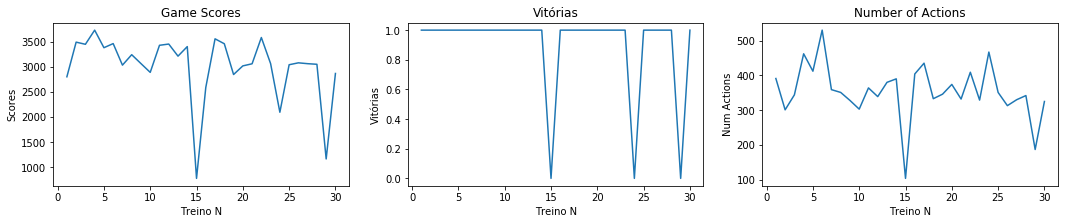

Wins:  27  Loss:  3
Avg Score:  3009.5
Avg NumActions:  354.5


In [42]:
printGraphs(gamesScores,results,numActions)

#### Análise dos resultados dos testes
&emsp;&emsp;Percebemos que as considerações do passo de treinamento quanto às features e aos reforços foram bem sucedidos, como podemos ver no desempenho do modelo nos casos de teste. \
&emsp;&emsp;Fomos capazes de resolver alguns desafios do jogo, mas não todos. Percebemos que quase todas as vezes que o pacman morre, é por que ele foi encurralado por dois fantasmas, um cenário que não é previsto no nosso modelo.\
&emsp;&emsp;Como consideração final, esta seria uma melhoria a ser implementada.

## Comparação de Algoritmos
&emsp;&emsp;Com os dois algoritmos treinados, podemos comparar o desempenho dos dois em cada um dos mapas. Executamos dez jogos para cada um dos mapas com o melhor indíviduo da população final do modelo evolutivo e o agente resultante do treinamento de aprendizagem por reforço.\
&emsp;&emsp;Nos gráficos abaixo, podemos observar que os dois algoritmos atingem um número alto de vitórias, porém o algoritmo de Aprendizado por Reforço apresenta um melhor desempenho, com scores maiores e um número maior de vitórias.\
&emsp;&emsp;Percebemos que ambos algoritmos enfrentaram dificuldades quando o pacman é encurralado, por isso tiveram mais dificuldade no mapa menor. No mapa médio e original, os dois modelos responderam muito melhor, mas ainda assim, o evolutivo não superou os resultados do RL. 

In [23]:
winsDict[str(30)] = []
NUM_GAMES=10
avgScoreSGP, scoresSGP, winsSGP = trainIndividual(fittestInd, 30, layoutType='smallClassic')

layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
                        eatFood
                        add
                           mul
                              1.0
                              minGhostDist
                           1.0
                     encounterGhost
                  mul
                     add
                        mul
                           m

In [43]:
pacman.setIsTrain(False)
gamesScores, results, numActions = approxQLearning(pacman,"smallClassic",10,pacman.n_train)

layout:  smallClassic
------------------------------------------ train --------------------
Action Score:  [3.2883929970838093, 3.2882533159563305]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2849628903338894, 3.2250113236547167]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.283898575654806, 0.7967835043322418]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2727151069090334, 0.7911878388096577]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.218144182048454, 3.283510136393712, 0.7776761903614707]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.306832730959375, 3.16306101809067]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.373468715432698, 3.283510136393712, 0.7456282282

Action Score:  [3.2849628903338894, 3.2250113236547167]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.283898575654806, 0.7967835043322418]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2727151069090334, 0.7911878388096577]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.218144182048454, 3.283510136393712, 0.7776761903614707]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.306832730959375, 3.16306101809067]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.373468715432698, 3.283510136393712, 0.7456282282528742]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.684596073361714, 3.1971786421410116]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
A

Action Score:  [0.677438486735176, 3.249706290979503]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2736531567229203, 0.7663953076992447]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.282668028623711, 0.7880139937402472]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.290687858793987, 0.7957879404199786]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2975163494786064, 0.7992180471698984]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.8048056126334584, 3.303380316112259]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.3141753455969374, 0.8104072662899658]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.336056905895531, 

Action Score:  [-2.093137908660063, 3.1666134366490866]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.0698153140944004, -2.103932938144742, 3.1899360312147493]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.003179329621078, -2.093137908660063, 3.1666134366490866]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.0698153140944004, 2.960990574256699]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-2.093137908660063, -3.5821854433078255]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Pacman died! Score: -172
Average Score: -172.0
Scores:        -172.0
Win Rate:      0/1 (0.00)
Record:        Loss
------------------------------------------ train --------------------
Action Score:  [3.2883929970838093, 3.2882533159563305]
W:  [[3.04735653 1.4027604 

Action Score:  [3.3228593882200386, 3.3951162524224436, 0.9879367725255384]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [1.254465885053507, 3.3171705343381515]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.9013412008982118, 3.283510136393712, 3.300557571773137]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.245885600367939, 3.289762542288458]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7943351864798015, 3.283898575654806]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2803627887235685, 0.7835401569951231]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.27806792701339, 0.7776761903614707]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  Nort

Action Score:  [3.2562234037467155, 3.294362643898779]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8046729898585779, 3.288498677265127]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2849628903338894, 0.7938779603738996]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.282668028623711, 0.7880139937402472]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2849628903338894, 0.7844782068090096]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.288498677265127, 0.7821833450988315]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7957879404199786, 3.28305291028781]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.266365287097834, 0

Action Score:  [-3.63726860726561, 0.022143805949737694]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.46595165770913616, 0.7456282282528742, 0.053722535786226586]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.1971786421410116, 0.2169716388574468]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.83558680729186, 3.266365287097834, 0.677438486735176]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2555702576131553, 0.700761081300839]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.249706290979503, 0.677438486735176]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2461705040482656, 0.6666434572504977]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  N

Action Score:  [3.3295690202206867, 3.300557571773137, 3.308448099005899]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [3.2629330357473636, 1.2611755170541552, 3.306832730959375]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.300557571773137, 3.283510136393712, 0.9013412008982118]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2629330357473636, 3.289762542288458, 3.2708235629801257]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.283510136393712, 0.811382621859226]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.33386833860207227, 0.285161380375145, 0.36798596265241357]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7943351864798015, 0.13857127342225545, 0.8842937655187872]

Action Score:  [0.4585476594343225, 0.7231385834931278, 3.2146083951172164]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.46012100906772047, 3.218144182048454]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7254334452033059, 3.155818407164408]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.1666134366490866, -0.5348289137360243, 0.6607794906168453]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2555702576131553, 3.094871276572972, 3.2896878816634967]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.266365287097834, 3.205418156506398, 3.2565720156880724]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2287407510720607, 3.2727151069090334, 3.2896878816634967]
W:  [[3.04735653 

Action Score:  [0.12289741447340177, -5.518999653344599, 0.48261065382746693]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-5.397546077083042, 2.900043443665263]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.218144182048454, 0.48261065382746693, 0.7289692321345435]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.224008148682106, 0.7348331987681959]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.9717856037413775, 0.7289692321345435, 3.149954440530756]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.900043443665263, -0.5383647006672616]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-3.5655264471894945, 0.46595165770913616, 2.894179477031611]
W:  [[3.04735653 1.4027604  2.0186

Action Score:  [0.5981150990238483, 0.15860547844536882]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.2257611699059545, 0.27648864334663914]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.879414046488677, 0.7058763428213682, 0.5981150990238483]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.3427159117042615, 0.7117403094550206, 2.320825924547732]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.073621198768783, 2.1193673963575974]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [5.195764464043503, 0.564010834597047, 0.5393223193789887]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Pacman emerges victorious! Score: 1168
Average Score: 1168.0
Scores:        1168.0
Win Rate:      1/1 (1.00)
Rec

Action Score:  [0.36798596265241357, 3.16306101809067]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.218144182048454, 0.7943351864798015, 0.7776761903614707]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.224008148682106, 0.7835401569951231]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.9717856037413775, 0.7289692321345435, 3.218144182048454]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.16306101809067, 3.2633153533441437]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7776761903614707, 3.27806792701339]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7873196274660816, 0.7741404034302332, 3.27806792701339]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]  

Action Score:  [-0.005832793416366274, -0.005832793416366274, -0.0025949914660870887]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.010364748278944274, -0.0054133864019468]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.01390472507705614, -0.007694216517188036]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.0095662750381156, -0.01672312001291585]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.019003950128157088, -0.010880818192167161]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.020876008649084652, -0.009284923103672682]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.022190551803136213, -0.018672842820016775]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.7

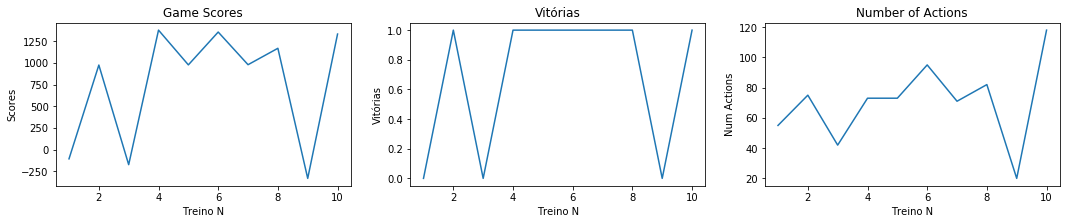

Wins:  7  Loss:  3
Avg Score:  755.6
Avg NumActions:  70.4


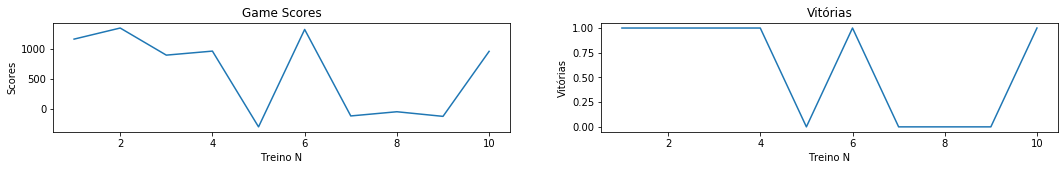

In [44]:
# graficos de RL
printGraphs(gamesScores,results,numActions)

# graficos de GP
fig = plt.figure(figsize=(18, 2))
plt.subplot(121)
plt.xlabel('Treino N')
plt.ylabel('Scores')
plt.title('Game Scores')
plt.plot(range(1,len(scoresSGP)+1),scoresSGP[:])

plt.subplot(122)
plt.xlabel('Treino N')
plt.ylabel('Vitórias')
plt.title('Vitórias')
plt.plot(range(1,len(winsSGP)+1),winsSGP[:])

In [24]:
avgScoreMGP, scoresMGP, winsMGP = trainIndividual(fittestInd, 30, layoutType='mediumClassic')

layout:  mediumClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
                        eatFood
                        add
                           mul
                              1.0
                              minGhostDist
                           1.0
                     encounterGhost
                  mul
                     add
                        mul
                           

In [45]:
gamesScores, results, numActions = approxQLearning(pacman,"mediumClassic",10,pacman.n_train)

layout:  mediumClassic
------------------------------------------ train --------------------
Action Score:  [3.289586818532878, 3.287780421652424]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.288154269015412, 3.227224368086155]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2856942397126394, 0.7983460018936975]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.286819647450411, 0.7989793191015019]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.282668028623711, 0.7965192897987288]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2736531567229203, 0.7919197290764026]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.271358295012742, 0.7934930787098005, 3.288498677265127, 3.2826680

Action Score:  [3.261282752934138, 3.2150123103585813]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7707612327671545, 0.2755489940732742]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.27238245614717627, 3.1971678243593527]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7210300974297549, 0.7683075697695723, 3.2102050473436656, 0.7683075697695723]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.9471874729182583, 0.719600611542645]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-3.5877538306490684, 0.4580125230043476]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.8872645194372946, 0.2705612284168999]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTIO

Action Score:  [3.2705713787601414, 0.789286956078993]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2705713787601414, 0.789286956078993]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2705713787601414, 0.789286956078993]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2705713787601414, 0.789286956078993]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2705713787601414, 0.789286956078993]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2705713787601414, 0.789286956078993]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.3317246104531798, 3.192576812789281]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7643489934668062, 3.2

Action Score:  [0.5121828466733515, 2.0831798447502714]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5079978518979038, 2.0852580268631304]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5068652834548283, 2.085573527850841]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5084700681477354, 2.0885089675767823]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5087855691354459, 2.089001837284425]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5109966138336373, 2.093346319776072]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0998969377751213, 2.089001837284425, 0.5140338462420548, 2.0998969377751213]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  Nor

Action Score:  [0.7813964288462307, 3.278461905992904]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.278461905992904, 0.7813964288462307]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.278461905992904, 0.7813964288462307]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2751714803704624, 0.7813964288462307]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2638617467594933, 0.7813964288462307]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2363790940848385, 0.7746867968455826]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2363790940848385, 0.7746867968455826]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2363790940848385, 0

Action Score:  [2.100137790525292, 2.851087988728996]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5310949449598162, 2.161630030234866]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.1618882446747, 2.851087988728996, 0.5864480373824984]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [3.2114983852320176, 3.2189955750564305]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7830565640995454, 0.7906159840241673, 0.7906159840241673, 3.2801220412462184]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7828772285011935, 3.2803360430562156]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7830565640995454, 3.28059425749605]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]] 

Action Score:  [0.34993416065612637, 2.0171907791121737]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.5031699186612396, 2.079959137433886, 0.5031699186612396]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0831256753599843, 0.5049911463915161]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.278461905992904, 3.278461905992904, 3.2705713787601414, 0.789286956078993]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.278461905992904, 3.2096242481687054]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7813964288462307, 3.2705713787601414]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.253523943380717, 0.7813964288462307]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.7758809

Action Score:  [0.265970216846828, 2.8808522801369465]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.4526244608144716, 2.9417994107283825, 0.4526244608144716, -5.170480631244861]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-5.170480631244861, 2.9417994107283825]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-5.594406472171123, -0.22727932859582137]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.2668504486144098, -5.619079404711805, -0.1544324940161471]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-5.594406472171123, 0.002952642421420709]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7156420352398789, 0.1085850804092602, -0.1544324940161471, 0.1085850804092602]
W:  [[3

Action Score:  [0.7924029592501745, 3.2711239460126817]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7814101599188007, 3.244451468638501, 3.27011289358288]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2687909062159766, 3.1818971121267863]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.207274429095037, 0.7528228557270085]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.7785622908071569, 3.2406093267871636, 0.778280938872714, 0.7517157288076958]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7485331721161022, 3.137715178076472]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.14134663706082887, 0.19897992304964962]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588

Action Score:  [0.7907943213386308, 3.2856942397126394]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7899616468880222, 3.2810946789903133]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7907943213386308, 3.271358295012742]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2461705040482656, 0.7806099954654335]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.149954440530756, 0.7547006924241766]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.5289649471023719, 0.6572437036856077]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [3.08900730993932, 0.3050288740311257]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.155818407164408

Action Score:  [3.288154269015412, 3.227224368086155]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2856942397126394, 0.7983460018936975]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2843851046127543, 0.797538284834433]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.282668028623711, 0.7965192897987288]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2803627887235685, 0.7952101546988439]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.27806792701339, 0.7967835043322418, 3.2917891028875683, 3.2859584542461526]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.30193928184519, 3.2273061853648946]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East


Action Score:  [0.7838442813370875, 3.256855742604383]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7671879229828295, 3.2087821015852596]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.9465972016104613, 3.208148784377456, 0.718973834463545, 3.2096147760358686]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.8848173965684163, 3.2107401837736402]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2096147760358686, 0.4574222516965508, 2.949295958981631]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [2.886775478756797, 3.2087821015852596]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7204398261219581, 3.258321734262796]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096

Action Score:  [-0.008855228329722617, -0.005732818839921033]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.01149428766723044, -0.007475297136194105]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.005732818839921033, -0.00463320819093056]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.003258946784433828, -0.003189084812224503]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.005732818839921033, -0.00463320819093056]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.00584339762912793, -0.007475297136194105]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.008919420514900162, -0.006867580902784001]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  

Action Score:  [-0.31681398399141547, -0.06700990652521628]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.3244084413687203, -0.07128364694796016]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.06700990652521628, -0.3300274809506236]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.3343012213733675, -0.061390866943313034]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.3300274809506236, -0.06700990652521628, -0.05379640956600819, -0.06700990652521628]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.04317915829839448, -0.3244084413687203]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.02769301149149095, -0.31681398399141547]
W:  [[3.04735653 1.4027604  2.01869448 0.47977

Action Score:  [0.1935403033264262, 0.1935403033264262, 0.7993636276935543]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.3495802960203643, 3.2252560426469903]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.082786507341922, 2.080134408043934, 0.5051664170015636, 0.5078185162995519]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0873301733140734, 2.0216876050406976]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5096384839725767, 0.23591311594870448]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.2356991141387069, 2.023507572713722]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5121828466733515, 2.082505155407479, 0.507537164365109, 0.5121828466733515]
W:  [[3.04735653

Action Score:  [0.3509162940824351, 0.12125088519318529]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.19353115764486728, 0.19353115764486728, 0.799774729636174]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.226534693294071, 0.3499225761004416]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2891592318856686, 0.7988423284356918, 3.2880172783496024, 0.7999842819717582]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.290099704952665, 3.2284575408769047]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5009736013977794, 0.22059936798093965]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.22035392839826756, 2.015284476730137]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0

Action Score:  [2.0960904260009094, 0.5211224349585393, 2.1232389055629417]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0621802616913665, 2.268846164914248]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [4.501034572200527, 2.2687165846895936, 0.6937485936472235, 2.2689979366240363]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2746262083200675, 3.2207835057349974]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.785271922807805, 3.2584288654258344]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2749162232014912, 0.7857412732875805, 3.259104654685384]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2820919603718055, 3.2141830944200525]
W:  [[3.04735653 1.4027604  2.0186944

Action Score:  [0.1650508481896089, 0.0673095816072253]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.2755489940732742, 0.09085744335686152]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.731476340450943, 0.1668708158626337, 0.1668708158626337, 0.7739277706932524]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.3268003150009763, 3.2173830577221265]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.081305707686959, 0.5107020470183887, 0.5063377166445892]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.508157684317614, 2.079959137433886]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5049911463915161, 2.0781379097036097]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.775

Action Score:  [0.33632471206350073, 3.2199493182391246, 0.34204968052359874, 0.33632471206350073]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7859965304565517, 6.328252978402363]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Pacman emerges victorious! Score: 1935
Average Score: 1935.0
Scores:        1935.0
Win Rate:      1/1 (1.00)
Record:        Win
------------------------------------------ train --------------------
Action Score:  [3.289586818532878, 3.287780421652424]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.288154269015412, 3.227224368086155]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2875459091989523, 0.7994894184713228]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2843851046127543, 0.797538284834433]
W:  [[3.04735653 

Action Score:  [3.2753691696422207, 0.7691467843488854, 3.27806792701339]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2633153533441437, 3.1985000114091315]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.218144182048454, 0.771845541720055]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.951590820691809, 0.7254334452033059, 3.2146083951172164, 3.224008148682106]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.894179477031611, 3.2348031781667848]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2581257727324475, 3.224008148682106, 0.47181562434278856]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.3247617572057706, 2.9108384731499415]
W:  [[3.04735653 1.4027604  2.01869448 0

Action Score:  [0.14014718934030906, -0.07202261570670071]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.2975323257778769, -0.03245149568811223]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.3250149784525317, 0.14014718934030906, 0.7746867968455826, 0.14014718934030906]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2142243497790264, 0.3250149784525317]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2808964488305605, 0.7917214989166497, 0.7859965304565517]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.284189152583942, 0.7917214989166497]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2862550193092117, 0.7950142026700314]
W:  [[3.04735653 1.4027604  2.01869448 0.47977

Action Score:  [0.5049911463915161, 2.079959137433886, 2.0831256753599843]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0831256753599843, 2.01901200684245]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.085670038060759, 2.081305707686959, 2.085670038060759, 0.5063377166445892]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.085670038060759, 2.0203585770955232]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.508157684317614, 0.23403897888539227]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.2303278136015491, 2.0203585770955232]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5107020470183887, 2.081305707686959, 2.085670038060759, 0.5063377166445892]
W:  [[3.04735653 1.40

Action Score:  [0.7917214989166497, 3.284189152583942]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7917214989166497, 3.284189152583942]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2808964488305605, 0.7917214989166497]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2751714803704624, 0.7917214989166497]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2751714803704624, 0.7917214989166497]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.33632471206350073, 0.11181770950635667]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.1846645440860309, 0.1846645440860309, 0.7859965304565517]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Sco

Action Score:  [2.106062936002186, 2.090580651065122, 0.5156126600227517, 2.0908620029995646]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.106242271600538, 2.0297631006983403]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5216119555056344, 2.123913594905734]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.1236995930957363, 0.5217912911039864, 2.097231498396188]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.1235202574973844, 2.036026153364918]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5312742805581682, 2.161084921116728]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.1609553408920736, 0.5310949449598162]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.7758809

Action Score:  [2.089381203344602, 2.0436350057557875]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5201311558506717, 2.085670038060759]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5107020470183887, 2.081305707686959]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.508157684317614, 2.079959137433886]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.508157684317614, 2.079959137433886]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5063377166445892, 2.081305707686959]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5039669692810438, 2.081305707686959]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5063377166445892, 2.0856

Pacman emerges victorious! Score: 1535
Average Score: 1535.0
Scores:        1535.0
Win Rate:      1/1 (1.00)
Record:        Win
[True, True, True, True, True, True, True, True, True, True]
Wins:  10  Loss:  0
[1938.0, 1540.0, 1927.0, 1911.0, 1874.0, 1739.0, 1935.0, 2145.0, 1932.0, 1535.0]


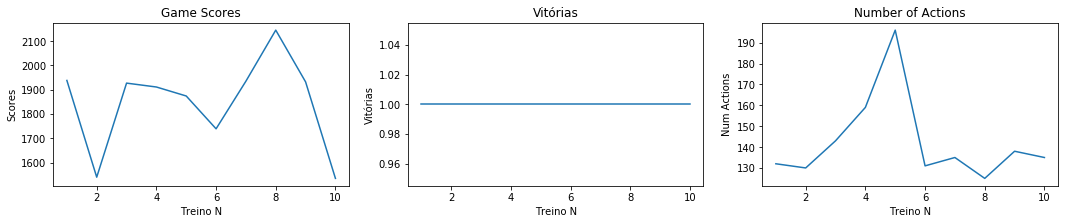

Wins:  10  Loss:  0
Avg Score:  1847.6
Avg NumActions:  142.4


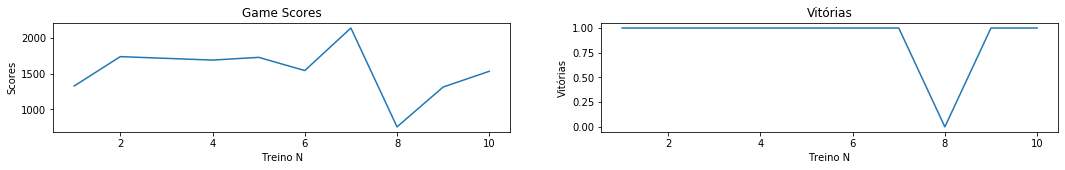

In [46]:
# graficos de RL
printGraphs(gamesScores,results,numActions)

# graficos de GP
fig = plt.figure(figsize=(18, 2))
plt.subplot(121)
plt.xlabel('Treino N')
plt.ylabel('Scores')
plt.title('Game Scores')
plt.plot(range(1,len(scoresSGP)+1),scoresMGP[:])

plt.subplot(122)
plt.xlabel('Treino N')
plt.ylabel('Vitórias')
plt.title('Vitórias')
plt.plot(range(1,len(winsSGP)+1),winsMGP[:])

In [25]:
avgScoreOGP, scoresOGP, winsOGP = trainIndividual(fittestInd, 30, layoutType='originalClassic')

layout:  originalClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         2.0
         encounterGhost
      mul
         add
            mul
               minDistToFood
               minGhostDist
            add
               eatFood
               1.0
         add
            add
               add
                  add
                     eatFood
                     minGhostDist
                  add
                     eatFood
                     1.0
               1.0
            add
               eatFood
               add
                  mul
                     add
                        eatFood
                        add
                           mul
                              1.0
                              minGhostDist
                           1.0
                     encounterGhost
                  mul
                     add
                        mul
                         

In [47]:
gamesScores, results, numActions = approxQLearning(pacman,"originalClassic",10,pacman.n_train)

layout:  originalClassic
------------------------------------------ train --------------------
Action Score:  [3.292020990504496, 3.2920188217393775]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2916532188924394, 3.2921505707291505, 3.230962346632921]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.29241168695396, 3.2309525918911697]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.292591022552312, 0.8028543527933495]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.292805024362309, 0.8030061245031379]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2932519782652725, 0.803416072638401]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.293477674214889, 0.8037290088734339]
W:  [[3.0

Action Score:  [0.5071234978946624, 2.0859646048760077]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5087855691354459, 2.089001837284425]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7921258855950162, 3.2745364951916116]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7926187553026591, 3.2753691696422207]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7932520725104635, 3.2764945773799923]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.27806792701339, 0.7940847469610721]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2803627887235685, 0.7952101546988439]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7967835043322418,

Action Score:  [2.501957632976472, 3.3398940902911054]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [1.265775618664476, 3.3342052364092183, 0.8393053180352099]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.9059413025085328, 3.3108826418435555]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.8393053180352099, 3.300087612358877]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.8159827234695469, 3.294223645725225]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.290687858793987, 0.8051876939848686]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2883929970838093, 0.7993237273512162]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  

Action Score:  [0.778700533978792, 3.240151737713254]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7510883010794827, 3.1410668825454797]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.6515710131443668, -0.5432905795297978]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.20201070803145488, -0.6041533858114909]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.04172436683673632, -2.122036167232678]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-2.4022988873693785, 0.19926127498409255, -0.031252047967592414]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.6491124289754954, -2.500300288840618]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Ac

Action Score:  [0.508157684317614, 2.079959137433886]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.081305707686959, 0.5063377166445892]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5039669692810438, 2.081305707686959]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5049911463915161, 2.0831256753599843]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.056392372924572616, 0.12965246920488047]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.08241187571832766, 0.2303278136015491, 0.08241187571832766]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.5107020470183887, 0.12783250153185569]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action S

Action Score:  [0.005248352039695498, 0.031351750114212734]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.011617049367345603, 0.015865603307309205, 0.05521188741670116]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.0038690974395579267, 0.09478300743528964]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.02772923474204635, 0.15729203863618746]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.08444520405651323, 0.06730035476063484, 0.265970216846828]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.1085850804092602, 0.4526244608144716]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.002952642421420709, -3.656459770793927]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588

Action Score:  [-0.0070534897290022314, -0.00871925038909694]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.00630097770638529, -0.006562321024235855]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.004987623003732322, -0.005426546635715147]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.00423511098111538, -0.00488491302407382]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.003606974554614716, -0.0033606799104452375]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.002336496636789166, -0.0028544625319977725]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.0011263071985917967, -0.00198003146132763]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACT

Action Score:  [3.223242021992506, 0.3474082510022504]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.284189152583942, 0.7970800693953013]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7970800693953013, 3.284189152583942]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7970800693953013, 6.331545682155744]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Pacman emerges victorious! Score: 3183
Average Score: 3183.0
Scores:        3183.0
Win Rate:      1/1 (1.00)
Record:        Win
------------------------------------------ train --------------------
Action Score:  [3.292020990504496, 3.2920188217393775]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2916532188924394, 3.2921505707291505, 3.230962346632921]
W:  [[3.04735653 1.4027604  2.01869448 0

Action Score:  [2.092713002568268, 0.5106055368084708]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0990642633245122, 0.513540976534412]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.126837248724501, 0.5234629550743378]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.1105053349670744, 0.533579261736324, 2.1656790917914046]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.8569244017289304, 2.103606553462197]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.305729279727206, 0.6984723445465546]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0899048800100077, 0.5100340316471826]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3

Action Score:  [2.0208267592480014, 2.0852708241184295]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5083229456151822, 2.0879234662420636]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.093346319776072, 0.5121228007490845, 2.089048873979835]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [2.0295206983514023, 2.098430946116708]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5240962722821422, 2.124878387358445]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5329459445285196, 2.1622037456624104]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.851560204978828, 0.587626831645207]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3

Action Score:  [0.5100318213809262, 2.0918290558354586]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5165455638053782, 2.107421065863247]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5225790083415285, 2.125371257066088]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.522970085366695, 2.126004574273892, 0.522970085366695, 0.522970085366695]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5329459445285196, 2.164553684053633]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.533579261736324, 2.1656790917914046]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5518692576821309, 2.2750136852223224]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  S

Action Score:  [0.5003382743368415, 2.0750135918109334]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5003382743368415, 2.0750135918109334]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5001819669162548, 2.0748939136810067]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5001819669162548, 2.0748939136810067]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5000456007685631, 2.0750135918109334]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5000456007685631, 2.075306265379212]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5001819669162548, 2.0754866005218933]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5003382743368415,

Action Score:  [0.1093831666687, 0.050238121671592695, 0.050238121671592695, 0.050238121671592695]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.18223000124837424, 0.07409825897408112]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.33961513768594204, 0.1136693789926696]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.789286956078993, 0.18651621357234383]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.217514775401468, 0.3439013500099116]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.278461905992904, 0.7935731684029625, 0.789286956078993]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.278461905992904, 0.7935731684029625]
W:  [[3.04735653 1.4027604  2.01869448 0.4797790

Action Score:  [0.34204968052359874, 3.2142243497790264]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2808964488305605, 0.7917214989166497, 0.7859965304565517]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.284189152583942, 0.7917214989166497]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2862550193092117, 0.7950142026700314]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2876356677583294, 0.7970800693953013]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.798460717844419, 3.2876356677583294]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.798460717844419, 3.2862550193092117]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score

Action Score:  [2.4963374320527922, 2.1379326017839593]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.077528345810845, 0.5037818817839538]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.076730857153215, 0.5025977533233755]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5021427799487596, 2.07711077099113]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5014728512294213, 2.0771481695460303]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5017967041549894, 2.0776072210577725]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5021801785036601, 2.0781636076162875]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5026392300154026,

Action Score:  [0.8051876939848686, 3.3342052364092183]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8217076919296449, 3.4041339246359232]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.763968240791866, 0.8483229902486897]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.4673530230542315, 2.496969867320098]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.503149446516648, 2.07964469270242]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5031956165739172, 2.0797026068645468]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5038796510402455, 2.078970859509526, 2.0807920872398027]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [

Action Score:  [0.5107020470183887, 0.5063377166445892, 2.085670038060759]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.508157684317614, 2.089381203344602]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5144132123022319, 2.1045821363472235]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.095099146893042, 0.5201311558506717, 2.1220394578424218]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.061092327250986, 2.2675171369690736]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5847879021291837, 0.895954647320578]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.07768385114671147, 0.07704776047151778, 0.22059936798093965]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.7758809

Action Score:  [3.2283615167927375, 3.289837788985065]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.800133697470263, 3.289837788985065]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.800133697470263, 3.289837788985065]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.289837788985065, 0.800133697470263]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.05732779233978438, 0.12022990805997001]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.08065878804138152, 0.19237184234533178]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.3497569787828996, 0.12022990805997001]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.799428797175950

Action Score:  [0.7859965304565517, 0.1846645440860309]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2029146161680573, 0.33632471206350073]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2638617467594933, 0.7472041441709278, 0.7746867968455826]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2705713787601414, 0.7643489934668062]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2705713787601414, 0.7643489934668062]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2705713787601414, 0.7643489934668062]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7643489934668062, 3.2705713787601414]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Sc

Action Score:  [2.1025956951462907, 0.5276277041039206, 2.1084263437877064, 2.1295360060956705]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.070883737214413, 2.2734403355889246]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5922844503824326, 4.511079532597746]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2906718110511095, 0.5084606820137847, 2.082900076754884]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [2.0227856206140573, 3.2900384938433054]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5071350350927101, 3.289035407634417]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.8003533274281494, 3.2835944676717954]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588

Action Score:  [3.273019231250998, 0.766796845957663]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2734103082761647, 0.7664813449699525]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.766796845957663, 3.2739031779838075]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2745364951916116, 0.7671879229828295]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2753691696422207, 0.7676807926904723]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2764945773799923, 0.7683141098982766]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.27806792701339, 0.7691467843488854]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2803627887235685, 0

Action Score:  [0.747816107293642, 3.2644737098822074, 0.7752987599682968, 3.254233675759723]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [3.176090096673386, 3.264519879939477]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.747816107293642, 3.264571479138499]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7650071266467896, 3.271229511940125, 3.271339025301274]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2103339805477114, 3.2792948557988204]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7900546026201256, 3.283655073114998]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.28358106812279, 0.7901199058849095, 3.283739397424741]
W:  [[3.04735653 1.4027604  2.01869448 0.4797

Action Score:  [0.8053315755010675, 3.2986597660562316]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.30193928184519, 0.8059490292110836]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.3127343113298684, 3.2917891028875683, 0.8069003652976271]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.336056905895531, 3.2367059389297843]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.3984066780448847, 0.8192731490919882]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.8425957436576512, 3.758240994200828]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.4595599097379231, 2.5001376653034475]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  

Action Score:  [3.264519879939477, 0.7477746306016149, 0.775344930025566]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2758812127494683, 0.7752987599682968]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.281664095371693, 0.786654663636535]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7924312312956554, 3.2850221023898585]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7957818492111641, 3.2862395239596918]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7979130192012178, 3.2863238482694346]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7970645740457813, 3.2838360527572537]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  

Action Score:  [2.081305707686959, 0.5107020470183887]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.078934960323414, 0.5063377166445892]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5049911463915161, 2.079959137433886]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.079959137433886, 0.5031699186612396]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.081305707686959, 0.5039669692810438]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [5.128662237258762, 0.5039669692810438]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Pacman emerges victorious! Score: 3453
Average Score: 3453.0
Scores:        3453.0
Win Rate:      1/1 (1.00)
Record:        Win
------------------------------------------ train

Action Score:  [3.289321714262834, 0.7990375944572831, 0.7990375944572831, 0.7957448907039013]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2900588670817705, 0.7962485447264074]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.08083727365997, 0.8004928401426934]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.08210302613508, 0.5048661964087117]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0847569283159655, 0.5065017178849057]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.08722890630681, 0.5079320857125142, 2.084858158943265]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0931665863140076, 2.0251563679776026]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.775880

Action Score:  [0.225523867772801, 2.0229461913096807]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5071706664505057, 0.5114117793973946, 2.082015440065965]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0819638408669427, 0.5114696935595214]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0805711005566003, 0.5088674166966198]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.080529623864573, 0.5088158174975974]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0794680481992005, 0.5069496797673033]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.079505446754101, 0.5069082030752763]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [

Action Score:  [0.2407482015416997, 2.025922355189843]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5212190902910525, 2.086999066005933, 0.5117899814587695, 0.5117899814587695]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5156126600227517, 2.084606475014947]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5157422402474062, 2.084785810613299]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5121828466733515, 2.0831798447502714, 2.082786507341922]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [2.0263830427226375, 2.0834380591901054]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5100318213809262, 2.082406989924743]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.7758

Action Score:  [2.0754866005218933, 0.5005186094795231]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0754866005218933, 0.5001819669162548]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7998076590560093, 3.2881600025643096]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.798985052650399, 3.2870099771617296, 3.2881600025643096]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2260628465702936, 3.2881600025643096]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7978350272478187, 3.2881600025643096]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7978350272478187, 3.2881600025643096]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:

Action Score:  [0.7935731684029625, 0.18910066441703793]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2218009877254374, 0.3464858008546058]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.278461905992904, 0.7935731684029625, 0.7935731684029625]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.789286956078993, 3.2705713787601414]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7813964288462307, 3.253523943380717]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7643489934668062, 3.2048169851537898]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.9417994107283825, 0.7156420352398789]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:

Action Score:  [-0.0042831300580899, -0.0020487573462364588, -0.006867580902784001]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.0015815387842717929, 0.001072774032631633, -0.003258946784433828]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.0020487573462364588, 0.0028152523289047045, -0.0020487573462364588]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.004944310734357516, -0.0006046339675304015]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.00758337007186534, 0.0011378443287426692]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.01090934505997962, 0.003266902734195481]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.013505677482561457, 0.00758337007186534]
W:  [[3.0473

Action Score:  [3.3395638068878704, 3.242433185520823]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.4061997913611934, 0.8270662624082966]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.8517695054230772, 3.766034107517136]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.4958272155515466, 0.4687336715033491]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.07821520681531, 0.5022216551956872]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0782731209774368, 0.5022678252529564]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.078970859509526, 0.5027369992716942]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5027949134338211

Action Score:  [3.2042436441132316, 3.276831615623777]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7761675965005453, 3.2770456174337745]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.276831615623777, 0.7763469320988973, 3.2773038318736085]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2047887532313695, 3.277619332861319]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7768191483487289, 3.2780104098864857]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.277619332861319, 0.7771346493364394, 3.2785032795941285]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.2057535456840807, 3.2791365968019326]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  Wes

Action Score:  [0.1285422339108615, 0.5115349968243053]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.22673112976888224, 2.0256298622674476]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0865029878666754, 0.5089906341235305, 0.5154044914100995]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5090646391157386, 2.0864376846018917]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5071706664505057, 2.086379770439765]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5089253308587467, 2.090148849885735]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0902141531505185, 0.5088674166966198]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score

Action Score:  [0.7765609339088948, 3.238826946575695]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7768191483487289, 3.239218023600862]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7771346493364394, 3.2397108933085046]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7775257263616059, 3.2678268631909635, 0.750043073686951, 0.7775257263616059]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7780185960692487, 3.2799692712525417]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7899616468880222, 3.2810946789903133]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7965192897987288, 3.282668028623711]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION

Action Score:  [0.800133697470263, 3.289837788985065]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.800133697470263, 3.289837788985065]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.800133697470263, 3.289837788985065]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.800133697470263, 3.289837788985065]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.800133697470263, 3.289837788985065]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.800133697470263, 3.289837788985065]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8006628390711542, 3.2902450933271616]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8010701434132512, 3.29056528

Action Score:  [3.2751714803704624, 0.7746867968455826]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.031351750114212734, 0.01655808565066455]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.015865603307309205, 0.02772923474204635]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.03245149568811223, 0.0038690974395579267]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.011617049367345603, -0.07202261570670071]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.09588275300918914, -0.02223430063495931]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.11136889981609266, -0.029828758012264166, -0.029828758012264166]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]  

Action Score:  [0.5024426418788895, 2.0784967535441714]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.502934221690813, 2.0792258441439904]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.503018546000556, 2.0793373574241296]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5036254178343146, 2.0802639882685883]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0789862740912666, 2.078704922156824, 0.5037369311144536, 2.080134408043934]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.018519807057348, 2.081047071874267]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5061905941120359, 0.5043693663817594, 2.079129188811477]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]] 

Action Score:  [0.5015440878284665, 2.0771481695460303]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5021427799487596, 2.078117437559018]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5025977533233755, 2.078796042883593, 2.0775657443657454]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.080668869812892, 2.017802742234888]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.082073354228092, 0.5046251024610272]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0865029878666754, 0.507047449023595]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0902881581427266, 0.5089253308587467]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [

Action Score:  [3.766789065369654, 0.8511438148264769]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.19830488987091832, 0.5091850527109412]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.03959479766229157, 0.041103158796329135]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.0306088862010099, 0.05705050610455605]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.041103158796329135, 0.041103158796329135, 0.08312160809733346]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.1329644784467879, 0.058397076357629196]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.2348719286913088, 0.08494157577035824]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  Eas

Action Score:  [0.5063377166445892, 2.085670038060759]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.085670038060759, 0.5063377166445892, 2.081305707686959]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [2.024722907469323, 2.095099146893042]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5144132123022319, 2.1045821363472235]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5296141453048535, 2.1597558931715537]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5470714668000517, 2.2675171369690736]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.6925491459267037, 3.3235247481759442]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [

Action Score:  [-2.571722875140002, -0.09588275300918914]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-2.5865998752804877, -0.07202261570670071]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.09588275300918914, 0.06730035476063484]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.02772923474204635, 0.1676298420149639]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.09478300743528964, 0.3250149784525317]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.1676298420149639, 0.7472041441709278]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.2975323257778769, 3.0756801130446556]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.1366

Action Score:  [-0.0063831013843967215, -0.0063831013843967215]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.006611446699043764, -0.007098808423084621]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.007351180715928284, -0.007351180715928284]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.007579526030575327, -0.008479456872202229]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.00873182916504589, -0.00873182916504589]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.008960174479692933, -0.010545323597472138]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.0107976958903158, -0.0107976958903158]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTI

Action Score:  [-0.010998441355242895, -0.00877417270754707]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.012507554842954051, -0.01156747722972675]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.016723409815340862, -0.012066876460928862]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.01823252330305202, -0.01729244568982472]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.028033143426309914, -0.017791844921026832]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.029542256914021077, -0.02860217930079377]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.028033143426309914, -0.017791844921026832]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  We

Action Score:  [-0.0063831013843967215, -0.0063831013843967215]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.005906546404731287, -0.006130729091553058]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.005678201090084245, -0.005678201090084245]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.0053774048038400125, -0.005425828797240583]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.00514905948919297, -0.00514905948919297]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.0053774048038400125, -0.005425828797240583]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.005678201090084245, -0.005678201090084245]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -

Action Score:  [-0.00514905948919297, -0.00514905948919297]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.00497010046174305, -0.004896687196349309]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.0047417551470960075, -0.004616794887829767]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.004489382854252344, -0.004305230891714652]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.004209490545732804, -0.0035497257113558485, -0.003957030053452811]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.003897926549617688, -0.0028387192214552534]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.003229534586458635, -0.002398040839430065]
W:  [[3.04735653 1.4027604  2.01869448 0.4797

Action Score:  [3.292779762015441, 0.8030849653302606]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2929937638254385, 0.803236737040049]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2932519782652725, 0.803416072638401]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.293378739789854, 0.8036300744483985]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2937698168150202, 0.804077028351362]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2942626865226634, 0.8043925293390725]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2947866592154464, 0.8046938013261449]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2956193336660555, 0.8

Action Score:  [0.5036254178343146, 2.0802639882685883]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.286686908121152, 0.5043693663817594, 2.081439937088849]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [3.2258693577543704, 3.2808504263809146]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7917869897471433, 3.2712652651677088]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.7924725270868085, 3.272527511111039]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7947466191178407, 3.276817836492631]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5090646391157386, 2.090148849885735]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [

Action Score:  [3.409782561037046, 0.8301198904832583]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.8537250823440817, 3.7698332502588365]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.47068924842435356, 2.493725871297495]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5007553331475689, 2.0756255549336475]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.075720444389312, 0.5007037339485465]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.07601968839768, 0.500793930038969]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5009087607675287, 2.0762666392881646]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.5010516973553096

Action Score:  [0.7989012863368046, 3.2866466757077486]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.286670053122541, 0.7988757516577476]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2866955878015975, 0.7988523742429561]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2867235535750403, 0.7988757516577476]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.7975793192269433, 3.2866955878015975, 0.7989012863368046]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2248004723834605, 0.34863174312059586]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.7940137368953482, 3.285724225560104, 0.7965492756461938, 0.7965981877400423]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588

Action Score:  [3.0778124645478018, -2.401838199836584]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.1390750961269482, -2.1212499646097465, 0.6493264307854929, 0.6493264307854929]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.1394661731521145, -2.1209917501699125]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.1399590428597577, -2.120676249182202]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2403442105163087, 0.650291223238204]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2686595376415726, 0.750535943394594]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2423022927046894, 0.7786519132770531, 3.269784945379344]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0

Action Score:  [2.0831256753599843, 0.508157684317614, 0.5144132123022319]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0831256753599843, 0.5144132123022319]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0831256753599843, 0.5144132123022319]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0831256753599843, 0.5107020470183887]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5107020470183887, 2.089381203344602]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.095099146893042, 0.5107020470183887]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.1220394578424218, 0.5201311558506717]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:

Action Score:  [0.006094336136937744, 0.012881976868170174]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [0.008733395474445568, 0.009556001880055894, 0.017155717290914047]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.012059370462559848, 0.022774756872817298]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.017155717290914047, 0.029546607844511824]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.020802125064626743, 0.02195215046720697, 0.039639524306145535]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.0283965824419316, 0.053745022663931455]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.03825887585702793, 0.07553929324114997]
W:  [[3.04735653 1.4027604  2.01869448 0.4797790

Action Score:  [0.014428127630206119, 0.004762545494078057]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.020802125064626743, 0.010154387207462246]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.026719174441769564, 0.015183085482723492]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.03733642570938327, 0.019124717064464707, 0.016540266219770606, 0.019124717064464707]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.052822572516286796, 0.024134723597075462]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.07668270981877522, 0.034751974864689165]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.11793123783752574, 0.052822572516286796]
W:  [[3.04735653 1.4027604  2.01869448 0.

Action Score:  [0.5181985952716376, 2.0998969377751213]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.093346319776072, 0.5203364109220828, 2.1085472527786937]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.0389498071836853, 2.125371257066088]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5240962722821422, 2.124878387358445]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.10702998883808, 0.5329459445285196, 2.1622037456624104]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [2.046473935271811, 2.1622037456624104]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.5495193192909085, 2.270356066485097]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
A

Action Score:  [2.0817930488171377, 0.5065017178849057]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.083428673056155, 0.5065025998254042]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0850020226895527, 0.5064074829550522]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0879293196670368, 0.5079504655125393]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0856344579568584, 2.090322454829723, 0.5095238151459373]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.306201140690046, 3.2341768485335587]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.318146195577305, 0.8111622241424832]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.

Action Score:  [0.012895348780722793, 0.009602645027341001, 0.026187720986858502]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.015259083164144854, 0.036851142311741455]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.022895017233476714, 0.05238888831766735]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.036851142311741455, 0.03355843855835966, 0.07630693978228265]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.049096184564285564, 0.115943363065655]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.07301423602890086, 0.1888642026375373]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.11265065931227321, 0.11265065931227321, 0.3463336633848481]
W:  [[3.04735653 1.4027604  2.01869

Action Score:  [2.089381203344602, 0.508157684317614]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.1045821363472235, 0.5144132123022319]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.1220394578424218, 0.5201311558506717]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.1220394578424218, 0.5201311558506717]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.1597558931715537, 0.5296141453048535, 2.1045821363472235]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.1597558931715537, 2.0436350057557875]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.2065700063776377, 0.5470714668000517]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Sco

Action Score:  [-2.571722875140002, -0.11136889981609266]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-2.5865998752804877, -0.12198615108370638]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-2.5962556205639755, -0.11136889981609266]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.09588275300918914, -2.602875567741873]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.07202261570670071, -2.5962556205639755]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.03245149568811223, -2.5865998752804877]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-2.571722875140002, 0.04039533889156201]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:

Action Score:  [3.2951239791249947, 0.8037582258676697]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.8036541675009055, 3.296075315211538]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.8033645783663895, 3.2976530695212203]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.308448099005899, 0.8026141529736575, 3.283898575654806]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.3317706935715616, 3.2367059389297843]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.3905161508121227, 0.8192731490919882]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.834705216424889, 3.7333030315886413]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score: 

Action Score:  [0.8046729898585779, 3.2771889436541577]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.7938779603738996, 3.2736531567229203]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [3.282668028623711, 3.271358295012742, 0.7880139937402472, 3.282668028623711]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2810946789903133, 3.2127060261314844]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.282668028623711, 0.7821833450988315]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.2849628903338894, 0.7806099954654335]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7821833450988315, 3.288498677265127, 3.282668028623711]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.775880

Action Score:  [3.2830288003337067, 0.7978531321860547]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2770456174337745, 0.7941693514075063]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.017525738560623824, 0.018690437153810885]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.007122489103007702, 0.029623189409135015]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.007380703542841829, 0.045500413241205004]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [0.07557838871143432, 0.029623189409135015]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.11907552969120891, 0.051225381701302974]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score: 

Action Score:  [2.084213609800365, 0.5058981011896407, 2.080866092232011]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.090580651065122, 2.0231698238764153]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [2.0354810442467803, 0.5117899814587695]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.5485522664550144, 0.5213306035711915, 2.096298594613562, 0.5213306035711915]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0904691377849827, 0.5309431732500278]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [0.5308135930253733, 2.0903724824524694, 0.5308135930253733]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [2.0865769928588835, 0.5212190902910525]
W:  [[3.04735653 1.4027604  2.0186944

Action Score:  [0.7988523742429561, 0.19281241083771739]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2270587370806343, 0.3501720125962282]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2879861272822213, 0.7997792566998423, 0.7998204535744876]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [3.287967924744623, 0.7997989970896912]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.7997792566998423, 3.2879511043712215]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.287967924744623, 0.7997610541622441]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2879861272822213, 0.799744233788842]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score: 

Action Score:  [-0.007314081203324022, -0.0038434545825782995, -0.007265169109475497]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.0029904799967045556, -0.0066384559156735775]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.00198603711289733, -0.005909321307848209]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.0007561072848511147, -0.003028422924151661, -0.005056346721974465]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.0007094725786513404, -0.0040519038381672395]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.00040946156444607654, -0.0028219740101210243]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [0.0025640546489558384, -0.0013563941466185683, -0.001356394146618

Action Score:  [3.29074474378319, 0.8012216319106438]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2906707387909817, 0.8011249765781305]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [3.2906054355261976, 0.8010406522683876]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.0024158039274184365, -0.001753292995713012]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.0023876321349807234, -0.0017319404249585323]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.002458193290025487, -0.0018631834241301607]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.002700019756490095, -0.0022727454700644566]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action 

Action Score:  [-0.022190551803136213, -0.013356284408814128]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  East
Action Score:  [-0.025637104422966496, -0.02353032146598808]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  West
Action Score:  [-0.022190551803136213, -0.024666018019783176]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.02353032146598808, -0.020594656714641734]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.022190551803136213, -0.018672842820016775]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  South
Action Score:  [-0.009284923103672682, -0.016329782604566377]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTION:  North
Action Score:  [-0.010880818192167161, -0.007363109209047723]
W:  [[3.04735653 1.4027604  2.01869448 0.47977909 0.77588096]]   -  ACTI

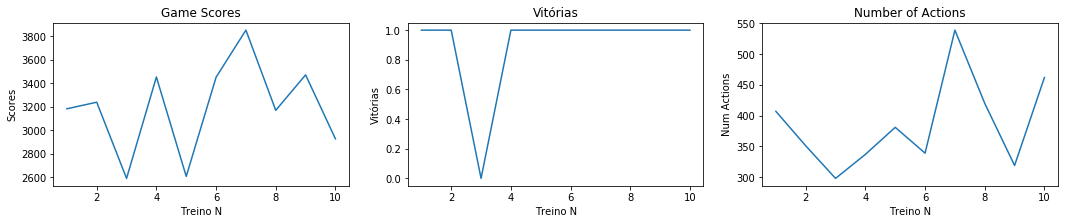

Wins:  9  Loss:  1
Avg Score:  3194.7
Avg NumActions:  385.3


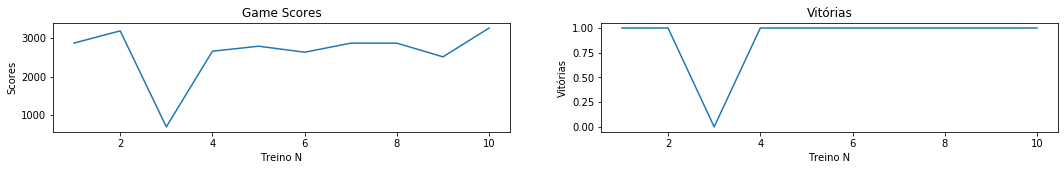

In [49]:
# graficos de RL
printGraphs(gamesScores,results,numActions)

# graficos de GP
fig = plt.figure(figsize=(18, 2))
plt.subplot(121)
plt.xlabel('Treino N')
plt.ylabel('Scores')
plt.title('Game Scores')
plt.plot(range(1,len(scoresSGP)+1),scoresOGP[:])

plt.subplot(122)
plt.xlabel('Treino N')
plt.ylabel('Vitórias')
plt.title('Vitórias')
plt.plot(range(1,len(winsOGP)+1),winsOGP[:])

## Conclusão
&emsp;&emsp;Podemos concluir que os dois modelos são capazes de resolver o problema do Pac-man, porém o algoritmo de Aprendizagem por Reforço seria o mais apropriado, tanto pelo melhor desempenho, quenato pelo tempo de treinamento, que é muito inferior ao tempo necessário para treinar o algoritmo evolutivo.\
&emsp;&emsp;Percebemos que o mapeamento e manipulação das features (variáveis de estado) do jogo também é uma parte chave do processo de treinamento, sendo indispensável para o bom resultado obtido. 

### Participação do trabalho
&emsp;Dividimos o trabalho da seguinte forma
- Algoritmo evolutivo: Felipe e Miguel
- Algoritmo de Aprendizagem por Reforço: Miguel